In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles, return_all=False):
        outputs = []

        # 原始 forward 到最后一个隐藏层
        for i in range(self.depth - 1):
            x = self.layers[i * 2](x)
            x = self.layers[i * 2 + 1](x)
        if return_all:
            outputs.append(x.clone())

        # 重复循环 hidden 部分
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1):  # 从第一个隐藏层开始传递
                x = self.layers[i * 2](x)
                x = self.layers[i * 2 + 1](x)
            if return_all:
                outputs.append(x.clone())

        if return_all:
            return torch.stack(outputs, dim=1)  # shape: [batch, cycles, hidden_dim]
        else:
            return x


In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
    
    
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1 + residual_2 + residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles, return_all=False):
        x = torch.tensor(x, requires_grad=True).float().to(device)
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles, return_all=return_all)
        
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output


In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
eigenvector_solution_df.columns = ['state_0', 'state_1', 'state_2']

N_u = 1
N_f = 2500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([60000.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 100 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
    

        # 获取所有循环隐藏状态
        y_all = model.hidden_predict(X_f_train_new, 100, return_all=True)
        y_all_perturbed = model.hidden_predict(x_ssss, 100, return_all=True)

        # 取最后20次循环（即最后20个时间步的输出）
        y_recent = y_all[:, -20:, :]
        y_recent_perturbed = y_all_perturbed[:, -20:, :]

        # 计算逐时间步的距离，然后取平均（每个点一个chaos值）
        chaos = np.linalg.norm(y_recent - y_recent_perturbed, axis=2).mean(axis=1)


        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)
        

        #计算信息量
        xinxi = 0.2 * abs_residual + 0.8 * chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    up = 80000
    n_star = 5000+1
    x_star = np.linspace(lb, up, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 50)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 4/1500 [00:00<00:37, 39.53it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 449.26it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 579.41it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 609.57it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 655.21it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 661.57it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 676.95it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 698.64it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 700.14it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 716.01it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 724.47it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:00, 732.42it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 725.98it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 732.62it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 706.23it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 694.49it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 695.55it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 707.79it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 712.80it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 709.04it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 679.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.48it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 721.93it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 729.00it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 732.96it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 730.56it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 721.37it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 698.73it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 718.94it/s]

Adam:  44%|████▍     | 666/1500 [00:00<00:01, 727.22it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 731.34it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 739.00it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 714.18it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 727.52it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 698.29it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 716.48it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 723.15it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 731.70it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 706.36it/s]

Adam:  94%|█████████▍| 1412/1500 [00:01<00:00, 671.17it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 681.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 711.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.67it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 677.29it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 694.58it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 716.41it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 731.83it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 735.95it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 741.56it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 744.58it/s]

Adam:  44%|████▍     | 667/1500 [00:00<00:01, 748.87it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 747.25it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:00, 748.11it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 748.17it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 740.41it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 715.40it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 724.31it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 726.75it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 727.17it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 718.15it/s]

Adam:  94%|█████████▍| 1410/1500 [00:01<00:00, 706.88it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 676.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 719.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.14it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 748.34it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 674.30it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 696.68it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 705.40it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 716.21it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 726.86it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 736.53it/s]

Adam:  45%|████▍     | 672/1500 [00:00<00:01, 716.58it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 727.04it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:00, 711.26it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 683.73it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 666.26it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 670.02it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 691.61it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 705.15it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 703.60it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 706.17it/s]

Adam:  93%|█████████▎| 1398/1500 [00:01<00:00, 719.92it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 699.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 751.99it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 705.73it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:01, 721.81it/s]

Adam:  20%|██        | 300/1500 [00:00<00:01, 713.26it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 717.40it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 719.53it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 728.40it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 739.56it/s]

Adam:  45%|████▍     | 672/1500 [00:00<00:01, 730.42it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 736.91it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:00, 736.80it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 739.86it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 739.23it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 744.92it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 746.28it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 738.45it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 701.09it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 694.42it/s]

Adam:  94%|█████████▍| 1417/1500 [00:01<00:00, 705.83it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 721.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 725.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 587.72it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 650.51it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 680.11it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 708.43it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 725.05it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 731.99it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 689.70it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 673.84it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 683.44it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 701.81it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:00, 716.38it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 721.00it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 725.12it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 734.42it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 720.47it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 712.96it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 706.34it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 681.03it/s]

Adam:  92%|█████████▏| 1377/1500 [00:01<00:00, 678.81it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 673.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 737.88it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 740.67it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 746.06it/s]

Adam:  20%|██        | 300/1500 [00:00<00:01, 745.71it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 743.44it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 732.93it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 739.67it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 716.59it/s]

Adam:  45%|████▍     | 672/1500 [00:00<00:01, 703.96it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 712.44it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:00, 722.03it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 717.98it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 720.63it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 710.66it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 712.97it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 719.62it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 728.16it/s]

Adam:  89%|████████▉ | 1337/1500 [00:01<00:00, 735.63it/s]

Adam:  94%|█████████▍| 1411/1500 [00:01<00:00, 731.27it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 737.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 727.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 744.57it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 735.68it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 739.36it/s]

Adam:  20%|██        | 301/1500 [00:00<00:01, 744.48it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 746.79it/s]

Adam:  30%|███       | 452/1500 [00:00<00:01, 745.65it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 740.72it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 725.80it/s]

Adam:  45%|████▌     | 676/1500 [00:00<00:01, 728.73it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 722.51it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:00, 733.07it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 727.35it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 723.26it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 725.33it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 718.56it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 708.06it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 721.12it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 725.06it/s]

Adam:  94%|█████████▍| 1417/1500 [00:01<00:00, 732.98it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 699.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 724.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 726.92it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 732.92it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 732.91it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 737.67it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 737.78it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 737.21it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 720.98it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 727.81it/s]

Adam:  44%|████▍     | 666/1500 [00:00<00:01, 716.08it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 716.90it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:00, 721.63it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 728.68it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 685.03it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 703.11it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 717.15it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 702.37it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 710.28it/s]

Adam:  89%|████████▊ | 1330/1500 [00:01<00:00, 714.85it/s]

Adam:  93%|█████████▎| 1402/1500 [00:01<00:00, 690.76it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 700.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 567.31it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 630.84it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 681.74it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 705.93it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 673.96it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 679.95it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 678.33it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 670.89it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 686.42it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 705.03it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 715.94it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 712.07it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 711.97it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 718.74it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 689.26it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 693.97it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 651.12it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 652.24it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 659.94it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 681.55it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 701.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 732.98it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 730.11it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 734.03it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 738.56it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 734.66it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 727.49it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 728.59it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 729.77it/s]

Adam:  44%|████▍     | 666/1500 [00:00<00:01, 709.16it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 717.66it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:00, 725.64it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 725.36it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 724.05it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 662.37it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 682.92it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 694.14it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 705.62it/s]

Adam:  89%|████████▊ | 1330/1500 [00:01<00:00, 716.52it/s]

Adam:  94%|█████████▎| 1404/1500 [00:01<00:00, 722.12it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 721.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 716.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.69it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 714.14it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 725.88it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 666.04it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 671.39it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 689.59it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 689.08it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 697.66it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 710.39it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 696.21it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 698.97it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:00, 684.70it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 701.31it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 710.95it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 723.93it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 722.50it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 728.91it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 717.03it/s]

Adam:  92%|█████████▏| 1380/1500 [00:01<00:00, 689.82it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 684.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 696.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 723.68it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 680.91it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 696.94it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 706.88it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 704.99it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 714.27it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 704.76it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 710.10it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 720.80it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 705.01it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 698.63it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 700.20it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 712.65it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 724.61it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 724.14it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 709.60it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 712.91it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 722.33it/s]

Adam:  93%|█████████▎| 1390/1500 [00:01<00:00, 726.11it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 722.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.37it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 704.96it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 703.96it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 718.40it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 718.66it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 725.91it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 708.16it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 693.74it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 701.33it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 704.56it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 670.71it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 693.00it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 702.40it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 715.32it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 693.50it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 707.51it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 718.72it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 688.34it/s]

Adam:  92%|█████████▏| 1386/1500 [00:01<00:00, 703.64it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 690.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 739.09it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 742.31it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 626.75it/s]

Adam:  20%|██        | 300/1500 [00:00<00:01, 670.92it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 694.03it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 677.34it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 649.05it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 666.20it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 653.83it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 679.37it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 694.63it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 706.68it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 719.87it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 721.12it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 724.01it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 717.83it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 720.16it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 685.68it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 703.50it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 714.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 696.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.08it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 712.07it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 726.12it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 728.73it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 727.38it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 711.79it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 690.69it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 694.19it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 700.78it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 707.48it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:00, 719.21it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 701.22it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 716.85it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 710.70it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 721.15it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 722.95it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 723.28it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 731.32it/s]

Adam:  93%|█████████▎| 1392/1500 [00:01<00:00, 731.79it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 736.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 718.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.94it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.79it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 706.46it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 708.50it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 717.47it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 691.23it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 702.66it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 710.14it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 723.21it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 726.76it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:00, 701.49it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 715.39it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 680.17it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 695.44it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 694.77it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 662.64it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 660.81it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 679.65it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 684.81it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 667.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.32it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 557.08it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 615.58it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 668.22it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 698.43it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 711.91it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 702.72it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 712.64it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 701.39it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 711.92it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 703.48it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 700.57it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 703.67it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 702.20it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 710.40it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 716.13it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 724.27it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 715.61it/s]

Adam:  90%|████████▉ | 1349/1500 [00:01<00:00, 701.49it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 656.71it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 683.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.60it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 700.21it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 708.83it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 681.65it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 694.33it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 701.11it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 710.84it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 693.33it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 691.98it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 703.75it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 679.08it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 678.04it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 700.00it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 705.82it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 710.46it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 713.60it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 709.88it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 706.58it/s]

Adam:  91%|█████████ | 1368/1500 [00:01<00:00, 693.68it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 688.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 746.35it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 745.58it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 738.24it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 725.67it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 730.53it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 716.78it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 724.07it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 665.03it/s]

Adam:  45%|████▍     | 668/1500 [00:00<00:01, 686.24it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 698.87it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 673.45it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 693.64it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 703.43it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 712.61it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 683.52it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 679.13it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 692.44it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 689.78it/s]

Adam:  93%|█████████▎| 1391/1500 [00:01<00:00, 700.17it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 689.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 700.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 729.07it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 734.96it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 738.36it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 742.74it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 731.06it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 733.88it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 696.69it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 695.45it/s]

Adam:  44%|████▍     | 666/1500 [00:00<00:01, 709.54it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 722.42it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:00, 721.18it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 730.47it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 701.66it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 711.44it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 721.36it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 722.41it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 728.56it/s]

Adam:  89%|████████▉ | 1335/1500 [00:01<00:00, 724.49it/s]

Adam:  94%|█████████▍| 1411/1500 [00:01<00:00, 732.74it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 724.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 720.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 707.46it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 722.78it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 727.90it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 735.27it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 736.88it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 732.63it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 736.99it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 708.32it/s]

Adam:  44%|████▍     | 663/1500 [00:00<00:01, 679.59it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 672.11it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 661.94it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 684.78it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 697.94it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 698.87it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 705.64it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 716.29it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 718.99it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 727.93it/s]

Adam:  93%|█████████▎| 1388/1500 [00:01<00:00, 715.36it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 679.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 696.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.40it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 654.87it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 691.70it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 678.70it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 699.90it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 716.43it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 727.91it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 734.09it/s]

Adam:  44%|████▍     | 660/1500 [00:00<00:01, 692.45it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 706.66it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:00, 698.69it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 713.23it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 703.48it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 708.80it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 707.26it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 716.29it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 724.52it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 696.12it/s]

Adam:  93%|█████████▎| 1393/1500 [00:01<00:00, 701.16it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 658.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 745.27it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 737.50it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 729.14it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 727.37it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 733.71it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 696.33it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 701.70it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 717.71it/s]

Adam:  44%|████▍     | 666/1500 [00:00<00:01, 700.25it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 711.47it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 724.69it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 708.70it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 722.02it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 730.08it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 731.59it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 726.50it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 712.11it/s]

Adam:  89%|████████▉ | 1334/1500 [00:01<00:00, 690.08it/s]

Adam:  94%|█████████▎| 1406/1500 [00:01<00:00, 698.63it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 695.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.83it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 681.68it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 642.19it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 673.28it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 695.15it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 702.61it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 671.91it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 654.82it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 678.43it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 685.53it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 684.18it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 699.52it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 709.65it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 711.67it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 720.31it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 727.08it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 732.99it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 736.33it/s]

Adam:  92%|█████████▏| 1377/1500 [00:01<00:00, 733.82it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 735.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 705.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.45it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 666.55it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 702.45it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 685.64it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 673.53it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 664.57it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 606.66it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 646.16it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 665.60it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 683.05it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 699.76it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 714.35it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 690.72it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 680.38it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 701.25it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 692.84it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 710.00it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 690.94it/s]

Adam:  91%|█████████ | 1367/1500 [00:01<00:00, 707.05it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 712.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.06it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 641.19it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 684.03it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 707.83it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 714.90it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 719.24it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 722.43it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 714.09it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 707.64it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 719.62it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:00, 727.95it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 723.95it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 723.64it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 726.90it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 720.33it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 726.55it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 726.67it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 696.32it/s]

Adam:  92%|█████████▏| 1383/1500 [00:01<00:00, 688.65it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 706.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 712.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 747.90it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 700.44it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:01, 724.19it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 674.95it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 676.08it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 680.06it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 687.95it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 700.09it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 709.24it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 717.99it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:00, 722.46it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 730.11it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 735.01it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 728.70it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 728.87it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 732.35it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 704.28it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 710.75it/s]

Adam:  93%|█████████▎| 1395/1500 [00:01<00:00, 717.19it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 726.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 610.35it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 620.79it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 678.14it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 655.32it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 679.92it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 688.90it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 706.36it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 715.34it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 725.30it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 732.52it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:00, 737.45it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 721.16it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 724.01it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 724.63it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 732.11it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 730.68it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 719.00it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 673.68it/s]

Adam:  91%|█████████▏| 1370/1500 [00:01<00:00, 665.69it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 676.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 573.96it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 673.80it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 701.61it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 717.86it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 696.57it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 707.43it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 715.49it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 721.24it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 725.32it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 722.78it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:00, 730.71it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 735.14it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 737.51it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 731.34it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 707.06it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 663.74it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 673.49it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 673.38it/s]

Adam:  92%|█████████▏| 1376/1500 [00:01<00:00, 686.53it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 700.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.28it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 711.93it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 722.83it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 735.95it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 709.84it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 713.12it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 713.75it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 719.49it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 695.19it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 680.87it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:00, 698.70it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 716.06it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 725.41it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 721.79it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 691.27it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 708.41it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 690.42it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 673.44it/s]

Adam:  93%|█████████▎| 1390/1500 [00:01<00:00, 684.61it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 671.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.64it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 686.63it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 696.10it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 714.97it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 688.63it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 702.99it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 715.57it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 693.57it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 709.25it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 708.54it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 692.58it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 703.84it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 673.04it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 681.35it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 690.89it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 707.18it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 715.46it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 718.79it/s]

Adam:  92%|█████████▏| 1380/1500 [00:01<00:00, 695.63it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 711.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 700.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 759.05it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 744.33it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:01, 748.26it/s]

Adam:  20%|██        | 303/1500 [00:00<00:01, 746.39it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:01, 745.61it/s]

Adam:  30%|███       | 454/1500 [00:00<00:01, 747.16it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 740.68it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 734.43it/s]

Adam:  45%|████▌     | 679/1500 [00:00<00:01, 738.08it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 739.32it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 736.95it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 727.67it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 717.63it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 715.81it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 706.20it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 712.97it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 722.87it/s]

Adam:  89%|████████▉ | 1340/1500 [00:01<00:00, 718.44it/s]

Adam:  94%|█████████▍| 1414/1500 [00:01<00:00, 722.34it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 727.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 729.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 623.54it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 697.37it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 715.54it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 726.96it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 724.95it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 694.64it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 694.47it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 710.07it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 719.73it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 725.64it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:00, 722.41it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 729.98it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 706.26it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 715.60it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 725.68it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 722.10it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 720.55it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 722.66it/s]

Adam:  93%|█████████▎| 1392/1500 [00:01<00:00, 729.85it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 734.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 719.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 733.91it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 738.34it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:01, 727.19it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 721.96it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 716.42it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 702.01it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 708.95it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 701.34it/s]

Adam:  44%|████▍     | 660/1500 [00:00<00:01, 713.56it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 720.67it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:00, 727.61it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 723.55it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 729.13it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 731.75it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 720.48it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 723.11it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 730.77it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 732.99it/s]

Adam:  93%|█████████▎| 1401/1500 [00:01<00:00, 732.10it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 712.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 718.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 716.77it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 728.81it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 735.99it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 733.54it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 717.32it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 706.98it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 697.82it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 708.57it/s]

Adam:  44%|████▍     | 660/1500 [00:00<00:01, 716.31it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 721.82it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:00, 725.65it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 698.80it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 711.18it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 712.29it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 721.99it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 729.16it/s]

Adam:  83%|████████▎ | 1252/1500 [00:01<00:00, 731.65it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 725.58it/s]

Adam:  93%|█████████▎| 1402/1500 [00:01<00:00, 735.09it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 703.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 716.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.12it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:01, 685.81it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 651.76it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 672.11it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 696.39it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 713.68it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 722.14it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 727.61it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 724.34it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 728.99it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:00, 724.70it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 730.22it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 711.72it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 711.99it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 717.29it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 720.49it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 729.90it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 728.49it/s]

Adam:  92%|█████████▏| 1384/1500 [00:01<00:00, 716.21it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 709.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 712.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.76it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 656.03it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 677.76it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 698.67it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 703.49it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 689.35it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 682.25it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 674.08it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 675.79it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 672.76it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 693.18it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 692.31it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 643.64it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 663.33it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 685.04it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 691.77it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 664.67it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 659.53it/s]

Adam:  90%|████████▉ | 1346/1500 [00:01<00:00, 683.53it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 683.42it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 690.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 671.28it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 669.65it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 668.65it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 656.31it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 658.13it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 681.26it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 683.66it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 699.97it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 705.83it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 719.16it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 701.46it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 714.84it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 722.23it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 696.89it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 682.02it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 680.40it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 697.49it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 708.05it/s]

Adam:  90%|█████████ | 1352/1500 [00:01<00:00, 696.94it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 698.92it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 709.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 695.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 722.76it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 726.39it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 714.66it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 726.19it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 727.03it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 659.93it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 682.83it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 670.69it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 660.04it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 681.51it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 696.21it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 705.54it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 714.92it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 724.67it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 727.64it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 732.75it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 726.33it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 721.01it/s]

Adam:  93%|█████████▎| 1392/1500 [00:01<00:00, 725.47it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 729.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 709.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 726.83it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 720.81it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 715.50it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 685.10it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 689.12it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 664.06it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 689.48it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 695.57it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 706.26it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 717.16it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:00, 723.60it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 722.50it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 723.75it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 676.66it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 670.44it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 692.05it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 697.00it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 702.47it/s]

Adam:  92%|█████████▏| 1378/1500 [00:01<00:00, 694.10it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 705.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.33it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 719.50it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 716.37it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 712.77it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 716.91it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 725.22it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 687.14it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 696.79it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 684.66it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 684.43it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 699.26it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 665.82it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 680.97it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 693.24it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 703.02it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 714.72it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 714.13it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 709.24it/s]

Adam:  92%|█████████▏| 1376/1500 [00:01<00:00, 714.68it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 713.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.37it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 716.04it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 689.19it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 710.46it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 718.54it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 726.81it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 732.52it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 716.41it/s]

Adam:  44%|████▍     | 662/1500 [00:00<00:01, 721.79it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 713.20it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:00, 723.92it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 720.89it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 731.04it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 733.47it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 735.98it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 734.26it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 706.88it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 688.49it/s]

Adam:  93%|█████████▎| 1398/1500 [00:01<00:00, 694.62it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 700.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 715.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 732.05it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 733.34it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 735.81it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 740.95it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 742.11it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 742.09it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 711.78it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 705.13it/s]

Adam:  44%|████▍     | 667/1500 [00:00<00:01, 711.12it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 720.00it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:00, 695.14it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 701.60it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 710.45it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 689.02it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 689.95it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 663.20it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 684.15it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 688.07it/s]

Adam:  92%|█████████▏| 1387/1500 [00:01<00:00, 655.55it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 666.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 696.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 738.12it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 723.94it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 699.62it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 714.50it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 698.24it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 713.94it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 717.77it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 726.24it/s]

Adam:  44%|████▍     | 665/1500 [00:00<00:01, 731.67it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 709.09it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:00, 719.56it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 724.50it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 723.35it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 701.12it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 697.03it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 696.54it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 698.63it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 714.05it/s]

Adam:  93%|█████████▎| 1395/1500 [00:01<00:00, 689.60it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 704.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 709.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 740.26it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 735.24it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 735.02it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 701.03it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 719.04it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 687.73it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 706.91it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 712.43it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 592.74it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 618.23it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 637.14it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 659.09it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 651.04it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 671.98it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 680.84it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 675.36it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 681.37it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 665.39it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 655.83it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 682.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.33it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.60it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 707.32it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 723.10it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 720.06it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 675.07it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 686.43it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 696.60it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 695.60it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 710.75it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:00, 707.16it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 704.57it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 700.75it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 629.34it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 470.77it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 486.00it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 374.40it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 367.27it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 393.42it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 416.25it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 447.08it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 470.18it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 494.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 557.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.95it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 547.21it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 526.14it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 523.54it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 511.54it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 497.16it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 505.75it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 570.41it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 617.78it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 610.55it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 647.56it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 673.71it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 685.15it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 694.93it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 688.34it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 681.65it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 661.89it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 672.37it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 694.32it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 701.30it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 713.09it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 716.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 639.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.19it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 710.25it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 721.76it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 672.54it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 695.58it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 690.54it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 699.81it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 711.23it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 714.73it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 717.34it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:00, 720.72it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 725.23it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 706.99it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 666.45it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 681.38it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 696.88it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 704.64it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 713.77it/s]

Adam:  92%|█████████▏| 1381/1500 [00:01<00:00, 711.32it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 710.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.35it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 703.69it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 680.73it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 678.90it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 701.94it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 714.58it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 714.82it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 717.53it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 726.14it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 729.63it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 698.09it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 684.33it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 682.50it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 693.46it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 695.87it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 702.04it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 697.81it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 709.32it/s]

Adam:  91%|█████████▏| 1369/1500 [00:01<00:00, 685.16it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 683.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 724.13it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 736.48it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 723.69it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 724.95it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 730.28it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 735.80it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 740.40it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 738.52it/s]

Adam:  45%|████▍     | 669/1500 [00:00<00:01, 739.15it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 708.79it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 716.91it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 723.67it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 721.65it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 697.12it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 679.02it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 674.53it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 691.84it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 663.97it/s]

Adam:  93%|█████████▎| 1389/1500 [00:01<00:00, 666.17it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 682.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 718.29it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 705.99it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 705.32it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 716.55it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 718.13it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 711.21it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 684.66it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 694.07it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 681.33it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 668.20it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 684.72it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 698.04it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 709.51it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 707.40it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 711.75it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 701.01it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 698.88it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 609.36it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 642.69it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 641.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.29it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 647.44it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 677.97it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 629.32it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 650.54it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 659.08it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 683.67it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 700.90it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 635.26it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 658.82it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 676.21it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 694.16it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 700.27it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 709.17it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 710.86it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 712.38it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 718.34it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 704.05it/s]

Adam:  90%|█████████ | 1356/1500 [00:01<00:00, 687.56it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 671.44it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 657.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.40it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 648.89it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 686.11it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 703.72it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 713.81it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 715.62it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 705.97it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 717.62it/s]

Adam:  44%|████▎     | 655/1500 [00:00<00:01, 710.17it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 689.42it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:00, 707.73it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 698.30it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 706.89it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 678.90it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 687.97it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 699.86it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 707.48it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 716.36it/s]

Adam:  92%|█████████▏| 1385/1500 [00:01<00:00, 721.04it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 712.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 702.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.67it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 720.56it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 730.71it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 707.31it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 707.48it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 716.44it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 715.63it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 718.24it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 705.42it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 697.67it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 694.54it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 708.79it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 701.01it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 660.92it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 679.83it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 685.08it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 700.99it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 704.80it/s]

Adam:  92%|█████████▏| 1378/1500 [00:01<00:00, 708.26it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 714.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.04it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 719.64it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 728.82it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 692.97it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 704.84it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 641.32it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 662.68it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 686.88it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 673.13it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 631.96it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 655.19it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 672.07it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 676.01it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 689.71it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 654.55it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 663.88it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 659.74it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 682.28it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 696.86it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 706.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 718.41it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 731.79it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 713.38it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 653.70it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 620.50it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 634.80it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 667.63it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 682.45it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 693.30it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 689.06it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 657.84it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 657.30it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 670.19it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 679.77it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 692.16it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 689.91it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 671.90it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 671.79it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 689.45it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 701.65it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 711.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 746.86it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 717.09it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 717.01it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 709.32it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 712.86it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 725.04it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 731.49it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 727.95it/s]

Adam:  44%|████▍     | 663/1500 [00:00<00:01, 723.83it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 713.69it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:00, 724.23it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 728.67it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 717.75it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 723.01it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 729.35it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 733.07it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 737.99it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 739.05it/s]

Adam:  94%|█████████▎| 1406/1500 [00:01<00:00, 705.87it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 707.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 720.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.97it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 689.57it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 699.82it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 716.50it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 723.55it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 677.29it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 643.59it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 667.86it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 676.77it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 686.56it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 685.97it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 686.18it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 590.55it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 629.08it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 644.54it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 673.20it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 679.40it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 677.57it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 631.56it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 652.98it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 660.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 674.73it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 671.15it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 683.80it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 698.45it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 712.57it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 724.17it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 721.74it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 726.01it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 726.27it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 727.33it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:00, 731.72it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 733.94it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 733.82it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 725.89it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 728.57it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 724.33it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 730.04it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 724.88it/s]

Adam:  93%|█████████▎| 1390/1500 [00:01<00:00, 730.28it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 727.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 722.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.20it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 661.16it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 686.37it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 693.85it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 709.53it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 721.96it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 719.37it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 731.18it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 734.90it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 736.11it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:00, 739.49it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 731.64it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 731.53it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 733.17it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 727.38it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 708.75it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 712.77it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 665.12it/s]

Adam:  93%|█████████▎| 1389/1500 [00:01<00:00, 666.95it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 688.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 709.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 736.12it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 730.18it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 720.03it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 709.76it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 719.68it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 727.85it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 715.63it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 664.46it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 665.57it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 685.76it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 693.27it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 677.86it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 668.65it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 679.14it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 696.44it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 696.78it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 701.49it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 710.15it/s]

Adam:  92%|█████████▏| 1375/1500 [00:01<00:00, 711.37it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 700.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.90it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 694.46it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 715.13it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 691.78it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 680.50it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 694.02it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 709.87it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 719.13it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 710.45it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 718.43it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:00, 714.37it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 681.19it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 694.84it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 707.45it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 646.09it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 655.47it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 679.64it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 662.95it/s]

Adam:  91%|█████████▏| 1369/1500 [00:01<00:00, 678.79it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 694.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 725.74it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 699.75it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 624.82it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 622.16it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 662.36it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 667.48it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 684.54it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 701.05it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 713.54it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 708.13it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 700.62it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 705.68it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 709.81it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 707.05it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 716.08it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 701.71it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 712.25it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 700.17it/s]

Adam:  91%|█████████ | 1368/1500 [00:01<00:00, 700.66it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 692.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 730.35it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 728.84it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:01, 735.55it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 737.50it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 655.51it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 652.98it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 678.88it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 642.65it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 671.16it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 692.28it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 680.04it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 681.16it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 695.73it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 678.80it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 652.19it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 644.07it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 666.79it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 684.44it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 698.51it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 709.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.87it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 719.28it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 724.76it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 730.14it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 715.66it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 664.65it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 635.66it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 666.07it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 678.98it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 685.44it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 700.83it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 687.57it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 691.16it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 706.33it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 713.57it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 677.69it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 668.15it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 675.26it/s]

Adam:  91%|█████████ | 1366/1500 [00:01<00:00, 672.68it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 683.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 725.50it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 702.67it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 708.32it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 699.05it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 677.76it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 685.84it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 695.68it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 700.89it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 712.10it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 709.76it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:00, 714.34it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 720.31it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 702.20it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 704.10it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 714.82it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 721.90it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 727.03it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 705.81it/s]

Adam:  92%|█████████▏| 1378/1500 [00:01<00:00, 706.56it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 717.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 709.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 712.08it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 663.89it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 668.94it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 683.66it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 697.62it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 693.83it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 701.47it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 713.24it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 715.26it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 719.47it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 699.28it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 678.52it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 690.29it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 679.35it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 697.57it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 707.04it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 696.64it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 706.14it/s]

Adam:  91%|█████████ | 1367/1500 [00:01<00:00, 668.63it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 638.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 712.15it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 640.42it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 646.06it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 629.73it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 636.86it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 641.11it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 638.63it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 637.45it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 669.98it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 671.23it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 689.38it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:00, 704.68it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 684.66it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 692.56it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 684.09it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 692.09it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 664.09it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 661.34it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 686.93it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 694.96it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 707.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 741.18it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 646.14it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 655.94it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 674.11it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 696.23it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 711.17it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 722.61it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 729.90it/s]

Adam:  44%|████▍     | 661/1500 [00:00<00:01, 732.25it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 734.98it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:00, 720.41it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 708.08it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 674.12it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 686.91it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 682.96it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 702.27it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 693.72it/s]

Adam:  87%|████████▋ | 1312/1500 [00:01<00:00, 697.94it/s]

Adam:  92%|█████████▏| 1386/1500 [00:01<00:00, 708.13it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 711.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.52it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 650.79it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 636.04it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 666.88it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 679.86it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 693.31it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 703.54it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 715.56it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 706.77it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 697.70it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 697.74it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 652.15it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 672.24it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 673.06it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 685.50it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 682.16it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 686.80it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 703.37it/s]

Adam:  90%|█████████ | 1354/1500 [00:01<00:00, 713.48it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 657.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.48it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.74it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 713.30it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 698.80it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 704.58it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 707.17it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 716.03it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 709.49it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 717.25it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 710.52it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 704.87it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 710.42it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 714.75it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 704.79it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 703.37it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 692.83it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 694.64it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 703.73it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 713.80it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 679.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 569.41it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 668.23it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 648.58it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 634.92it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 624.19it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 652.31it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 663.24it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 689.25it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 703.09it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 702.67it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 706.25it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:00, 716.18it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 715.76it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 724.06it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 726.75it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 722.38it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 713.00it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 718.83it/s]

Adam:  90%|████████▉ | 1346/1500 [00:01<00:00, 699.01it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 687.15it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 670.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 687.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 632.98it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 692.72it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 672.51it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 700.15it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 712.29it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 707.57it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 711.12it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 696.37it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 667.91it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 679.67it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 697.07it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 706.10it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 706.86it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 711.66it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 706.17it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 712.30it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 718.17it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 686.10it/s]

Adam:  91%|█████████ | 1365/1500 [00:01<00:00, 674.43it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 688.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 741.36it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 740.14it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:01, 746.84it/s]

Adam:  20%|██        | 301/1500 [00:00<00:01, 723.41it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:01, 703.15it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 712.75it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 717.18it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 703.91it/s]

Adam:  44%|████▍     | 664/1500 [00:00<00:01, 703.33it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 703.66it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:00, 713.07it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 720.77it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 727.20it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 721.06it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 724.05it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 719.79it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 693.39it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 689.28it/s]

Adam:  93%|█████████▎| 1390/1500 [00:01<00:00, 654.11it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 654.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.01it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 707.58it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 718.08it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 706.83it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 711.90it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 719.60it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 709.20it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 706.14it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 713.35it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 691.77it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 687.59it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 700.96it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 707.39it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 717.47it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 709.75it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 701.64it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 699.79it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 710.84it/s]

Adam:  92%|█████████▏| 1376/1500 [00:01<00:00, 683.85it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 647.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 696.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.29it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 710.69it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 598.85it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 651.17it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 668.76it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 693.45it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 707.92it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 670.88it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 692.67it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 706.53it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:00, 704.43it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 703.99it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 694.50it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 682.92it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 700.56it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 706.15it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 714.89it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 709.87it/s]

Adam:  92%|█████████▏| 1381/1500 [00:01<00:00, 717.52it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 691.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 724.58it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 704.13it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 720.98it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 708.22it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 627.09it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 657.73it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 676.73it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 696.47it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 697.49it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 711.52it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:00, 716.04it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 714.71it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 723.73it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 727.74it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 715.90it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 723.46it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 723.16it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 718.41it/s]

Adam:  93%|█████████▎| 1392/1500 [00:01<00:00, 721.67it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 719.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 706.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.60it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 674.70it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 679.97it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 692.40it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 698.58it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 701.12it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 711.51it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 716.68it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 680.14it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 663.45it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 683.89it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 693.98it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 696.23it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 708.79it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 698.76it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 704.20it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 692.39it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 707.08it/s]

Adam:  91%|█████████ | 1363/1500 [00:01<00:00, 716.65it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 723.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 722.91it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 729.46it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 718.87it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 709.17it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 720.74it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 714.78it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 697.68it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 698.35it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 703.05it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 694.40it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 698.49it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 692.63it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 667.24it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 683.70it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 698.34it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 708.58it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 696.29it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 706.14it/s]

Adam:  92%|█████████▏| 1374/1500 [00:01<00:00, 710.44it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 712.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 733.91it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 736.69it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 708.89it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 710.60it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 718.12it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 696.07it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 688.76it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 648.09it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 672.89it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 685.79it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 642.18it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 662.41it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 673.82it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 693.45it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 686.93it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 701.43it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 711.37it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 717.86it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 672.61it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 692.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 554.79it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 617.87it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:01, 667.41it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 693.87it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 708.33it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 721.20it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 724.48it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 728.78it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 732.78it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 710.40it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:00, 720.41it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 684.85it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 694.89it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 695.84it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 701.47it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 708.34it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 707.58it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 717.45it/s]

Adam:  91%|█████████▏| 1369/1500 [00:01<00:00, 716.88it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 719.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 707.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.46it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 693.33it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 707.52it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 664.36it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 644.48it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 674.29it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 683.90it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 695.48it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 702.46it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 670.55it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 687.46it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 640.12it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 627.17it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 656.42it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 660.61it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 677.09it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 687.84it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 693.44it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 708.18it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 695.90it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 708.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.92it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 735.42it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:01, 738.28it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 736.99it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 725.54it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 728.96it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 709.30it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 708.02it/s]

Adam:  44%|████▍     | 661/1500 [00:00<00:01, 701.65it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 713.61it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:00, 716.82it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 682.93it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 694.18it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 706.46it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 703.51it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 705.73it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 683.82it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 676.72it/s]

Adam:  92%|█████████▏| 1379/1500 [00:01<00:00, 663.54it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 640.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 726.63it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 700.16it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 714.95it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 711.07it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 711.59it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 697.54it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 710.00it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 716.98it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 724.04it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 723.09it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:00, 728.97it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 714.72it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 720.08it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 719.54it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 726.69it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 706.04it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 705.76it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 676.78it/s]

Adam:  93%|█████████▎| 1388/1500 [00:01<00:00, 688.97it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 678.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 706.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 734.27it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 721.29it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 719.63it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 729.41it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 731.60it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 677.93it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 691.55it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 703.95it/s]

Adam:  44%|████▍     | 662/1500 [00:00<00:01, 705.29it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 663.48it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 672.02it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 679.05it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 648.57it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 673.53it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 686.80it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 663.39it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 657.25it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 679.44it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 693.63it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 684.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 736.05it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 740.31it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 719.03it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 694.77it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 697.69it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 693.40it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 704.89it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 715.20it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 720.07it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 723.55it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:00, 716.80it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 717.03it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 714.37it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 635.17it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 604.44it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 640.03it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 666.97it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 686.47it/s]

Adam:  92%|█████████▏| 1380/1500 [00:01<00:00, 691.75it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 704.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.01it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 683.09it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 707.84it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 685.97it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 695.73it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 700.34it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 712.22it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 701.36it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 714.61it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 705.05it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 707.67it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 674.06it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 688.98it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 678.82it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 697.68it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 703.76it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 713.53it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 716.31it/s]

Adam:  91%|█████████▏| 1370/1500 [00:01<00:00, 710.07it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 702.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 695.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.32it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 532.30it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 629.31it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 676.13it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 702.51it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 709.88it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 722.08it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 729.84it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 702.29it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 703.54it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 672.58it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:00, 689.05it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 697.64it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 709.98it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 705.62it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 686.09it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 686.25it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 703.92it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 689.27it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 706.03it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 713.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 740.67it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 731.99it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 735.62it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 696.35it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 707.40it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 712.19it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 700.52it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 710.07it/s]

Adam:  44%|████▍     | 663/1500 [00:00<00:01, 706.19it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 700.50it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:00, 708.20it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 695.00it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 684.62it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 674.95it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 666.86it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 659.82it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 679.07it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 696.44it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 704.45it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 700.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.77it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 728.05it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 704.86it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 713.09it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 712.00it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 668.31it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 640.48it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 653.10it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 675.88it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 690.86it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 704.62it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 714.11it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 705.70it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 714.51it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 692.36it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 705.86it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 708.23it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 710.84it/s]

Adam:  92%|█████████▏| 1376/1500 [00:01<00:00, 682.13it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 681.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 729.82it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 731.71it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 688.03it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 697.59it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 693.28it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 693.81it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 709.68it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 717.96it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 715.87it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 691.16it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 695.23it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 681.08it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 680.01it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 693.26it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 706.01it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 708.35it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 710.97it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 717.30it/s]

Adam:  92%|█████████▏| 1373/1500 [00:01<00:00, 690.55it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 701.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 702.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.46it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 709.07it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 626.45it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 654.84it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 669.01it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 686.75it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 701.46it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 714.10it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 707.09it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 720.32it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 684.96it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 677.91it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 698.08it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 685.36it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 698.18it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 705.32it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 713.77it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 702.33it/s]

Adam:  92%|█████████▏| 1377/1500 [00:01<00:00, 708.80it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 718.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 721.50it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 737.19it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 695.09it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 702.65it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 710.83it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 701.09it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 705.05it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 710.99it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 686.63it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 694.12it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:00, 703.96it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 714.62it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 679.59it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 696.61it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 710.96it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 718.23it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 725.71it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 730.70it/s]

Adam:  93%|█████████▎| 1394/1500 [00:01<00:00, 713.00it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 717.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 708.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 638.25it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 653.43it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 693.32it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 700.57it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 711.28it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 700.11it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 706.48it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 715.39it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 720.70it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 698.44it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 673.25it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 686.40it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 700.03it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 710.73it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 714.62it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 705.46it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 701.96it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 700.51it/s]

Adam:  91%|█████████▏| 1369/1500 [00:01<00:00, 710.83it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 712.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.01it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 630.00it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 669.63it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 651.30it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 681.93it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 670.61it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 668.14it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 662.88it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 681.73it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 679.04it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 686.99it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 695.55it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 708.25it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 706.17it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 712.96it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 698.64it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 693.23it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 705.87it/s]

Adam:  89%|████████▉ | 1334/1500 [00:01<00:00, 677.60it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 690.44it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 696.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.97it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 675.24it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 698.81it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 699.77it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 668.31it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 689.91it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 695.21it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 697.81it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 695.10it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 679.87it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 683.87it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 700.09it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 711.04it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 701.61it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 659.89it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 680.86it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 679.76it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 681.45it/s]

Adam:  90%|█████████ | 1357/1500 [00:01<00:00, 696.80it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 705.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 728.02it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 689.34it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 704.49it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 717.96it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 724.15it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 705.08it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 696.31it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 677.59it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 676.93it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 692.71it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 699.31it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 691.99it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 702.10it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 698.92it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 702.16it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 709.13it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 671.94it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 689.88it/s]

Adam:  91%|█████████▏| 1369/1500 [00:01<00:00, 653.42it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 677.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.83it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 712.82it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 703.30it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 684.61it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 697.50it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 678.66it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 695.33it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 693.16it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 703.61it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 691.98it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 701.03it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 674.95it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 669.76it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 664.65it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 676.62it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 692.98it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 667.27it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 674.54it/s]

Adam:  90%|█████████ | 1355/1500 [00:01<00:00, 689.35it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 700.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 731.60it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 669.84it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 687.04it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 688.02it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 703.82it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 694.44it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 704.59it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 663.97it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 672.96it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 652.80it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 673.58it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:00, 691.20it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 702.90it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 692.28it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 692.65it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 705.74it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 713.63it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 709.07it/s]

Adam:  91%|█████████ | 1368/1500 [00:01<00:00, 706.34it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 680.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.79it/s]

Training time: 219.2246
当前为第1次循环，种子为0
Error y : 2.977965e-02
MAE: 1.342161e-02
MSE: 2.702829e-04
Chaos: 1.939966e-03
Residual: 3.678755e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 4/1500 [00:00<00:37, 39.44it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 330.08it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 479.59it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 550.09it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 582.09it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 620.60it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 640.56it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 630.59it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 620.39it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 605.77it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 592.26it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 617.62it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 637.51it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 642.39it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 658.21it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 667.18it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 673.42it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 668.42it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 670.38it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 678.08it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 679.74it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 681.31it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 655.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 623.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.08it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 686.44it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 661.56it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 670.42it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 620.56it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 642.11it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 644.07it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 653.71it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 651.85it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 648.01it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 661.05it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 666.02it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 623.17it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 641.48it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 654.88it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 666.81it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 671.79it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 650.43it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 653.01it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 632.70it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 652.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.10it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 650.78it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 629.28it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 645.70it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 638.70it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 656.27it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 643.87it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 650.30it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 659.64it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 665.72it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 675.27it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 681.03it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 670.35it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 667.20it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 672.33it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 651.62it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 648.04it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 657.30it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 654.95it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 660.79it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 644.02it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 649.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.98it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 590.78it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 589.85it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 601.71it/s]

Adam:  21%|██        | 316/1500 [00:00<00:01, 603.91it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 611.66it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 622.67it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 633.84it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 648.35it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 650.42it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 598.60it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 609.83it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 610.48it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 612.13it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 631.50it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 645.99it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 655.87it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 658.43it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 662.41it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 637.23it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 642.49it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 650.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.72it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 672.05it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 659.22it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 668.40it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 674.52it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 676.58it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 670.83it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 667.69it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 643.12it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 648.66it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 658.93it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 663.05it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 617.43it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 632.98it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 643.51it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 625.84it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 622.97it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 638.64it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 638.93it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 625.45it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 634.41it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 646.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.04it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.97it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 678.27it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 657.58it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 639.75it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 587.23it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 595.95it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 593.61it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 620.88it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 641.29it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 635.41it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 622.38it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 641.10it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 645.43it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 657.81it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 661.72it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 668.00it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 671.53it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 661.57it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 650.28it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 660.92it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 655.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 603.72it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 618.04it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 630.04it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 648.39it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 662.35it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 643.67it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 658.74it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 668.32it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 663.23it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 668.96it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 639.80it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 647.40it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 632.67it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 648.88it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 650.80it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 650.60it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 661.46it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 669.89it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 672.63it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 663.19it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 647.75it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 649.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 632.30it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 657.03it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 634.66it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 651.53it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 649.18it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 631.11it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 588.11it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 613.26it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 634.91it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 643.51it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 654.77it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 665.06it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 671.90it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 669.07it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 670.91it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 648.32it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 622.83it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 629.65it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 644.72it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 641.06it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 650.92it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 659.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<09:37,  2.59it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:11, 128.77it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:07, 181.67it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:06, 211.91it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 333.89it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 426.79it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 499.23it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:02, 528.73it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:01, 565.86it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:01, 578.34it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 551.71it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 575.44it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 586.36it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 610.16it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 625.33it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 638.41it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:00, 645.37it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 650.19it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 647.20it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 639.01it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 632.63it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 641.24it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 631.20it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 623.31it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 618.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 516.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.43it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 648.43it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 649.97it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 645.25it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 648.38it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 652.10it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 645.78it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 646.42it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 642.92it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 650.44it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 654.67it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 631.94it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 642.56it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 639.67it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 638.42it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 623.96it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 639.02it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 640.13it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 647.62it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 643.09it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 648.90it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 650.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.13it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 631.91it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 630.20it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 639.30it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 650.02it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 640.00it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 633.00it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 625.10it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 631.97it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 644.44it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 645.57it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 646.82it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 616.24it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 630.58it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 629.79it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 630.04it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 642.82it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 649.86it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 648.54it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 632.10it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 641.47it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 613.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 660.40it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 628.35it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 640.09it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 635.40it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 631.45it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 616.53it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 616.35it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 606.37it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 625.18it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 636.11it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 644.74it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 647.49it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 645.46it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 642.04it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 643.40it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 631.77it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 635.62it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 641.38it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 649.06it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 652.83it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 641.98it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 651.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 639.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.26it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 647.35it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 593.13it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 614.80it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 634.18it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 630.88it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 644.21it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 642.50it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 629.05it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 641.16it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 650.52it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 647.93it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 633.39it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 644.68it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 648.54it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 654.44it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 653.47it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 659.21it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 643.64it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 649.58it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 636.67it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 612.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 588.40it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 615.45it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 635.39it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 651.60it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 630.86it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 630.03it/s]

Adam:  30%|███       | 454/1500 [00:00<00:01, 638.04it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 638.22it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 625.22it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 628.86it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 606.88it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 630.44it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 630.93it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 640.72it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 652.99it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 652.07it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 638.62it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 651.22it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 661.14it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 615.69it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 625.61it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 627.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.41it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 576.29it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 598.71it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 616.65it/s]

Adam:  21%|██        | 308/1500 [00:00<00:01, 628.12it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 646.29it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 638.93it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 653.24it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 661.27it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 672.18it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 681.30it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 683.78it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 687.32it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 678.59it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 677.40it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 673.72it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 663.55it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 664.35it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 647.30it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 659.78it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 654.69it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 665.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 644.19it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 671.47it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 671.29it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 666.34it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 644.26it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 658.78it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 652.72it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 652.58it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 653.23it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 651.90it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 660.23it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 650.81it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 665.77it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 647.80it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 663.53it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 660.00it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 658.37it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 661.03it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 645.40it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 631.07it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 646.92it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 621.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 585.07it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 633.98it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:01, 653.28it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 669.14it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 670.17it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 651.07it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 657.34it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 662.39it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 671.51it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 680.08it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 678.66it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 656.66it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 634.74it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 644.65it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 635.82it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 654.07it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 647.39it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 638.25it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 654.67it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 661.72it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 664.59it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 649.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.67it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 668.86it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 677.38it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 629.59it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 647.91it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 658.12it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 668.01it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 652.46it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 664.53it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 669.48it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 664.66it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 664.94it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 673.55it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 647.64it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 658.13it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 667.27it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 668.72it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 635.82it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 648.82it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 645.38it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 642.72it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 651.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.59it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 667.03it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 640.26it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 632.67it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 650.46it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 655.24it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 622.98it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 602.83it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 611.45it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 609.63it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 628.86it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 644.97it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 659.58it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 668.95it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 656.42it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 664.09it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 661.95it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 659.49it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 649.21it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 647.47it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 659.18it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 667.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.15it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.02it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 689.85it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 670.68it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 511.37it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 548.85it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 586.57it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 588.95it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 556.46it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 590.44it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 603.39it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 627.85it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 640.72it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 655.43it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 649.83it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 633.64it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 647.26it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 618.97it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 625.92it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 637.49it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 638.83it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 622.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 618.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 639.67it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 618.17it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 651.27it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 667.57it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 662.27it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 654.77it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 660.41it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 672.40it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 666.38it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 668.00it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 675.14it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 678.76it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 681.03it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 683.03it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 639.26it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 653.46it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 644.25it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 658.01it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 664.92it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 668.08it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 657.87it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 663.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 557.80it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 584.62it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 595.03it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 621.08it/s]

Adam:  21%|██        | 314/1500 [00:00<00:01, 645.07it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:01, 650.49it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 621.19it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 640.05it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 629.01it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 644.45it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 641.92it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 655.39it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 666.43it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 647.82it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 653.64it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 667.16it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 676.20it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 675.98it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 680.13it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 677.11it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 662.44it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 669.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 612.33it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 592.75it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 637.97it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 660.11it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 663.33it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 671.47it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 662.72it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 667.91it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 669.88it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 670.77it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 678.53it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 679.46it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 676.01it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 679.73it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 681.80it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 673.90it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 677.66it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 659.67it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 649.26it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 648.35it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 659.25it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 669.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 617.69it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 633.63it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 643.26it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 657.10it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 628.30it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 623.39it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 645.44it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 658.96it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 670.45it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 665.75it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 651.88it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 662.89it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 662.56it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 663.95it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 675.06it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 638.29it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 620.50it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 611.87it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 627.94it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 634.18it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 652.46it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 654.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.84it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 658.70it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 674.22it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 606.98it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 613.34it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 635.62it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 621.74it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 647.02it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 656.70it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 669.44it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 677.46it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 646.04it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 656.55it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 602.19it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 586.19it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 615.80it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 637.95it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 650.36it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 652.81it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 651.96it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 658.79it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 644.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.43it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 686.90it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 666.66it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 675.28it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 683.97it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 655.41it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 666.96it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 649.95it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 648.94it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 658.68it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 667.74it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 665.69it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 661.10it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 672.83it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 678.56it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 668.45it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 656.64it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 659.31it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 670.24it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 677.74it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 681.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.78it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.63it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 690.72it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 693.16it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 672.08it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 664.97it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 660.34it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 632.84it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 620.07it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 627.87it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 643.63it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 656.42it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 664.60it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 652.31it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 664.07it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 672.92it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 677.07it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 681.85it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 658.21it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 664.36it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 666.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.92it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 638.64it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 604.35it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 624.91it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 618.99it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 628.78it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 634.95it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 618.75it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 607.00it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 600.51it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 614.99it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 620.29it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 640.38it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 623.62it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 634.50it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 615.15it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 638.20it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 633.28it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 650.59it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 648.66it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 660.70it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 631.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.56it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 566.11it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 589.21it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:01, 630.73it/s]

Adam:  21%|██        | 310/1500 [00:00<00:01, 636.38it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 643.81it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 647.29it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 650.20it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 662.34it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 666.30it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 658.21it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 668.39it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 668.32it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 675.20it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 671.44it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 669.76it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 665.65it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 661.20it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 666.37it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 627.30it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 634.85it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 636.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.94it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 652.18it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 642.39it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 643.90it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 645.74it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 644.86it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 652.68it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 650.20it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 633.25it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 648.62it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 644.85it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 651.20it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 628.67it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 628.18it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 629.58it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 649.56it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 633.51it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 614.52it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 606.87it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 624.34it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 641.51it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 655.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 559.46it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 631.48it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 648.94it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 662.17it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 642.89it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 660.39it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 656.91it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 652.86it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 663.08it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 670.52it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 664.28it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 673.36it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 680.79it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 659.76it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 656.70it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 665.65it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 658.96it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 663.57it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 670.59it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 656.15it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 613.01it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 629.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 631.54it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 593.46it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 620.26it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 648.42it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 664.68it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 672.02it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 645.25it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 660.11it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 670.45it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 678.89it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 659.70it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 667.30it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 673.24it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 680.11it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 671.07it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 650.27it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 645.44it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 646.14it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 651.05it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 654.17it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 620.03it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 632.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.37it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 679.25it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 686.40it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 646.47it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 659.01it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 653.11it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 660.23it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 659.92it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 665.67it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 671.01it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 650.14it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 663.81it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 661.43it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 668.50it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 630.98it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 644.24it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 658.24it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 666.30it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 672.44it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 671.80it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 670.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 646.31it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 655.01it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 647.56it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 656.08it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 663.40it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 624.02it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 636.84it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 635.09it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 650.72it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 647.19it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 650.90it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 650.74it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 651.86it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 663.00it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 642.23it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 650.99it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 664.32it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 662.86it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 671.20it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 665.03it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 646.35it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 644.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 615.68it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 629.26it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 597.74it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 631.17it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 650.40it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 649.05it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 645.18it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 651.60it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 661.53it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 665.66it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 664.54it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 655.76it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 666.44it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 665.38it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 675.57it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 683.33it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 673.20it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 673.28it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 677.07it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 677.10it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 673.76it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 640.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 592.60it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 637.28it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 632.23it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 651.02it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 632.86it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 652.21it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 645.20it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 629.30it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 627.83it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 621.85it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 618.90it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 618.74it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 620.83it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 630.59it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 646.29it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 652.95it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 658.57it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 665.64it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 666.91it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 670.80it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 673.37it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 671.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.70it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 660.15it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 654.57it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 665.35it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 645.60it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 658.42it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 633.59it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 649.56it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 624.94it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 636.39it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 651.01it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 640.68it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 656.16it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 656.27it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 663.59it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 644.24it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 658.69it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 652.82it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 652.10it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 652.50it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 657.71it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 641.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 627.32it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 655.49it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 663.17it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 669.38it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 675.35it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 677.85it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 682.93it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 643.84it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 631.47it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 641.83it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 647.09it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 653.08it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 643.47it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 656.09it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 662.64it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 658.75it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 612.29it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 597.12it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 618.22it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 619.07it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 636.04it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 640.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 582.76it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 648.32it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 666.65it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 646.27it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 638.37it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 600.44it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 588.70it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 606.73it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 617.49it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 620.98it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 630.97it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 624.85it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 628.82it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 638.81it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 641.19it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 646.53it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 634.00it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 651.32it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 635.71it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 649.35it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 634.63it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 650.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 588.62it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 543.97it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 583.87it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 618.35it/s]

Adam:  21%|██        | 318/1500 [00:00<00:01, 636.32it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:01, 622.00it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 611.32it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 581.14it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 609.12it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 628.05it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 642.48it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 650.05it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 663.99it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 654.51it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 656.06it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 656.18it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 662.41it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 663.13it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 668.65it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 666.31it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 614.65it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 618.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.41it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 642.42it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 659.44it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 668.15it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 654.23it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 666.43it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 671.82it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 650.17it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 661.31it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 666.74it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 663.85it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 667.62it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 666.49it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 675.01it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 678.35it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 662.71it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 641.80it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 639.74it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 655.45it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 662.04it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 667.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 697.05it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 684.34it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 686.52it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 651.54it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 604.69it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 612.22it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 605.00it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 600.23it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 597.69it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 619.20it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 640.28it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 656.39it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 648.99it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 637.49it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 653.74it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 643.46it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 643.22it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 624.70it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 623.17it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 634.18it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 645.82it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 653.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 614.34it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 647.86it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 643.16it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 663.24it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 654.87it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 662.76it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 666.59it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 675.17it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 679.06it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 680.39it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 684.30it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 665.61it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 672.52it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 679.12it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 676.75it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 675.61it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 674.62it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 679.32it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 682.88it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 672.83it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 662.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 641.31it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 662.50it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 672.97it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 674.78it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 643.50it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 637.81it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 624.86it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 615.55it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 634.37it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 648.87it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 657.12it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 614.24it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 625.68it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 646.54it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 657.94it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 669.29it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 671.65it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 662.51it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 634.97it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 647.74it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 659.49it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 668.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.13it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.58it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 647.61it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 626.87it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 631.97it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 621.63it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 641.71it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 649.05it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 656.69it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 668.41it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 671.38it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 676.22it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 679.90it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 680.92it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 663.53it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 663.71it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 668.33it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 675.59it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 663.70it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 673.44it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 678.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.74it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 667.65it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 667.78it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 675.90it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 679.84it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 661.26it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 662.02it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 636.80it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 648.62it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 656.64it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 668.33it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 646.52it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 630.73it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 641.95it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 643.83it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 652.46it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 642.02it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 627.88it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 647.43it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 643.63it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 655.73it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 659.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.40it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 673.72it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 672.98it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 682.46it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 674.22it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 667.71it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 671.19it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 678.08it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 678.97it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 672.05it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 672.84it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 674.96it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 679.20it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 683.18it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 683.89it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 683.69it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 687.53it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 657.35it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 654.40it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 629.41it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 650.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 626.62it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 664.47it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 669.27it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 677.58it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 681.77it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 686.76it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 679.88it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 685.02it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 685.51it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 663.07it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 663.62it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 674.33it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 681.35it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 672.50it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 655.84it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 642.08it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 646.72it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 644.61it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 657.50it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 634.24it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 650.64it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 638.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 651.45it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 667.97it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 592.81it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 616.12it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 635.65it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 651.37it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 658.53it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 658.38it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 657.65it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 661.28it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 666.04it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 676.11it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 658.11it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 657.14it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 665.87it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 672.89it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 670.59it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 669.60it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 652.07it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 661.19it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 649.59it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 649.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 618.61it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 653.84it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 642.92it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 660.32it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 668.07it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 667.68it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 672.15it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 650.12it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 639.36it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 643.92it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 639.22it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 634.90it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 622.27it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 622.03it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 626.27it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 620.97it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 639.72it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 655.46it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 656.67it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 655.39it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 652.87it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 658.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.76it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 660.78it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 653.58it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 665.21it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 664.72it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 665.74it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 671.08it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 639.33it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 652.78it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 622.42it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 632.73it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 641.34it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 606.36it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 627.11it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 632.86it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 650.36it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 631.09it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 624.75it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 643.01it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 645.18it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 660.64it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 670.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.32it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 676.66it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 681.90it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 677.33it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 665.81it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 674.93it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 677.51it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 677.23it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 674.68it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 674.59it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 641.75it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 647.05it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 657.36it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 665.77it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 665.75it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 659.25it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 661.77it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 639.10it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 650.38it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 642.97it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 626.06it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 626.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.26it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 634.09it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 613.05it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 619.30it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 644.46it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 662.30it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 652.91it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 629.58it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 647.18it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 660.88it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 669.02it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 666.15it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 672.19it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 675.12it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 675.91it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 679.74it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 672.97it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 656.79it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 660.22it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 658.72it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 655.23it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 630.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.59it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 663.01it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 658.27it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 670.16it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 678.14it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 682.40it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 659.98it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 637.86it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 653.23it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 662.42it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 667.49it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 665.81it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 663.10it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 663.04it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 672.00it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 672.08it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 662.66it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 641.68it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 657.64it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 631.68it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 646.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 646.17it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 666.56it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 675.45it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 661.39it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 665.63it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 669.82it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 649.62it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 653.37it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 667.48it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 675.04it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 670.81it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 676.07it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 664.17it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 658.65it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 665.71it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 670.47it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 642.49it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 647.99it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 657.20it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 663.09it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 668.71it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 647.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.37it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 673.93it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 668.75it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 663.97it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 661.76it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 628.70it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 646.52it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 659.27it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 668.85it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 649.48it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 640.34it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 651.06it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 630.72it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 647.60it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 659.19it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 661.38it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 672.42it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 666.92it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 625.82it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 638.14it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 650.14it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 658.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.98it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 669.17it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 677.35it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 680.16it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 675.76it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 658.79it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 636.84it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 618.30it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 636.09it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 650.04it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 661.56it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 667.51it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 668.17it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 674.07it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 675.82it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 679.44it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 678.43it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 666.17it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 671.76it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 677.09it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 680.84it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 682.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.79it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 687.54it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 687.20it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 667.72it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 643.56it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 657.40it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 667.64it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 669.37it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 671.14it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 673.43it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 679.68it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:00, 677.99it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 677.67it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 679.10it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 667.22it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 674.65it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 678.91it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 676.35it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 679.20it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 680.73it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 684.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 568.59it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 607.04it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 636.95it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 654.28it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 665.75it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 671.88it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 677.95it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 663.98it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 657.29it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 660.79it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 667.40it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 656.56it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 637.33it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 639.05it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 651.26it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 659.39it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 670.01it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 665.15it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 671.03it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 633.95it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 647.56it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 656.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.05it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 690.32it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 689.37it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 678.94it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 645.49it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 644.01it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 616.26it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 636.95it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 623.37it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 638.57it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 649.87it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 659.02it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 661.55it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 659.51it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 626.34it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 644.01it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 656.17it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 655.64it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 637.64it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 637.37it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 636.54it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 634.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.62it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 656.87it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 665.92it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 636.96it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 620.80it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 629.63it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 647.87it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 661.84it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 668.62it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 666.82it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 673.48it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 656.37it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 662.72it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 639.82it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 648.42it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 640.31it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 654.67it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 659.37it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 661.90it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 665.04it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 669.10it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 652.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 598.27it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 633.66it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 644.67it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 664.53it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 671.72it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 679.11it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 679.63it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 684.45it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 648.89it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 662.27it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 669.20it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 666.59it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 666.21it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 667.94it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 652.23it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 662.79it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 664.19it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 664.16it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 671.69it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 666.48it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 664.92it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 647.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.95it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 663.58it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 676.81it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 679.87it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 655.60it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 665.03it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 663.25it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 661.60it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 646.73it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 645.05it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 637.90it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 628.37it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 642.16it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 643.78it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 639.25it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 653.46it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 656.95it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 650.43it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 661.33it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 658.84it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 661.51it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 629.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.65it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 657.57it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 674.34it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 681.45it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 680.88it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 683.56it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 634.18it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 626.07it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 641.05it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 651.82it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 662.71it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 656.82it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 659.59it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 654.83it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 649.17it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 656.62it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 662.63it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 664.88it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 670.99it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 669.18it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 660.21it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 637.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.88it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 588.25it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 613.88it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 601.36it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 601.64it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 630.82it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 645.00it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 654.12it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 645.79it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 655.30it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 664.72it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 659.00it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 663.51it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 656.54it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 666.81it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 665.07it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 666.14it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 658.70it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 652.15it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 647.69it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 661.30it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 643.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.36it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 623.32it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 614.74it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:01, 631.91it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:01, 612.87it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:01, 620.76it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 627.67it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 636.90it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 649.69it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 656.33it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 648.76it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 662.17it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 658.38it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 665.50it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 672.63it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 678.84it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 682.85it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 649.40it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 625.47it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 642.93it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 653.06it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 663.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.64it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 677.39it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 668.25it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 673.66it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 663.86it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 630.12it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 649.63it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 643.73it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 619.73it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 614.66it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 618.20it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 637.53it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 626.80it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 635.23it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 638.73it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 653.65it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 645.84it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 627.23it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 607.60it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 631.08it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 635.92it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 632.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 586.02it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 586.96it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 632.18it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:01, 637.38it/s]

Adam:  21%|██        | 316/1500 [00:00<00:01, 631.33it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:01, 647.65it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 649.89it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 662.26it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 669.96it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 673.46it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 678.16it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 678.50it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:00, 640.00it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 649.93it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 658.21it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 664.20it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 670.93it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 678.62it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 644.53it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 650.32it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 637.08it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 627.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.50it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 673.94it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 666.08it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 666.69it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 672.68it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 662.75it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 668.74it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 659.56it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 668.42it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 646.13it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 654.54it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 628.99it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 645.37it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 646.62it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 626.87it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 628.81it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 624.56it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 634.50it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 645.22it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 651.17it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 657.26it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 661.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 651.33it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 677.18it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 678.24it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 680.24it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 676.37it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 679.52it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 662.43it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 671.05it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 675.99it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 678.71it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 658.51it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 666.27it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 671.92it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 646.88it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 656.23it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 654.86it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 660.68it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 646.21it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 642.88it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 628.97it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 627.07it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 633.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.41it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 673.24it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 671.84it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 657.23it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 673.03it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 677.23it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 672.15it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 676.68it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 680.30it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 684.73it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 683.88it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 684.57it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 678.66it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 663.15it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 640.77it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 624.51it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 609.87it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 626.67it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 626.08it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 637.65it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 647.46it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 647.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.01it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 676.98it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 682.15it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 675.44it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 678.92it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 681.00it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 678.37it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 683.90it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 670.30it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 636.12it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 643.61it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 651.06it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 647.75it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 658.98it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 646.31it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 651.87it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 662.89it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 670.87it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 667.67it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 657.98it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 668.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.61it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 674.68it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 648.68it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 664.99it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 666.17it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 645.26it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 639.44it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 653.41it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 656.48it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 664.68it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 663.26it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 659.51it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 634.70it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 651.35it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 662.89it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 662.86it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 641.43it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 635.04it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 650.93it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 664.17it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 671.28it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 674.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.75it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 607.52it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 640.00it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:01, 642.96it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 637.48it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 655.04it/s]

Adam:  30%|███       | 452/1500 [00:00<00:01, 647.29it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 659.03it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 664.25it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 652.27it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 656.81it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 664.11it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 643.30it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 656.90it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 593.59it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 604.70it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 603.22it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 624.98it/s]

Adam:  83%|████████▎ | 1252/1500 [00:01<00:00, 607.87it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 625.97it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 631.72it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 644.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 573.16it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 627.16it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 635.50it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:01, 635.09it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:01, 651.15it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 656.30it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 659.84it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 646.69it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 648.51it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 659.91it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 660.65it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 665.56it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 655.47it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 668.35it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 651.14it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 664.80it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 634.11it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 646.61it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 636.78it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 643.22it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 632.12it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 640.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.40it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 682.05it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 678.63it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 656.89it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 670.16it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 675.85it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 679.32it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 666.81it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 663.12it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 670.11it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 660.19it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 660.09it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 661.02it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 657.05it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 642.63it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 635.15it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 646.37it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 659.24it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 664.33it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 662.92it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 645.15it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 649.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 648.71it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 654.09it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 653.62it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 652.51it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 624.57it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 638.82it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 639.98it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 644.71it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 652.35it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 662.73it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 673.19it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 677.08it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 656.29it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 638.73it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 642.29it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 648.02it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 655.09it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 666.55it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 662.88it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 672.63it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 658.11it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 651.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 675.84it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 606.66it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 606.64it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 605.81it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:01, 593.69it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 614.56it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 629.64it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 626.06it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 626.64it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 624.60it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 625.47it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 618.38it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 631.98it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 618.96it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 636.06it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 650.17it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 651.54it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 662.19it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 647.32it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 646.01it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 650.52it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 649.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.12it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 676.82it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 619.71it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 618.91it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 644.65it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 635.98it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 565.18it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 587.66it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 615.52it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 613.17it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 586.82it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 611.05it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 617.71it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 608.68it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 609.54it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 630.35it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 640.12it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 640.83it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 648.35it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 650.94it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 663.84it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 672.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.85it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 537.65it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 591.49it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 610.63it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 636.82it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 627.38it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 631.26it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 647.73it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 655.64it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 658.59it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 666.48it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 671.07it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 673.95it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 675.25it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 663.45it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 655.16it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 642.84it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 649.72it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 658.88it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 666.75it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 675.30it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 647.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 573.68it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 638.33it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 621.80it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 645.82it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 661.39it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 654.52it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 643.57it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 638.47it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 647.35it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 639.15it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 654.67it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 663.32it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 621.31it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 631.40it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 644.60it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 647.76it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 638.28it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 632.25it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 636.29it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 640.10it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 642.46it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 652.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.29it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 671.09it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 679.26it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 668.00it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 672.13it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 672.11it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 642.32it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 643.60it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 651.84it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 621.11it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 621.53it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 639.18it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 617.10it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 630.79it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 634.01it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 630.29it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 644.10it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 655.33it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 659.29it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 665.83it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 671.67it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 640.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 590.94it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 618.10it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 628.67it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 620.72it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:01, 641.37it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 644.63it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 656.26it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 653.46it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 624.49it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 606.02it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 587.75it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 613.95it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 634.64it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 648.15it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 648.37it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 636.89it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 633.19it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 627.09it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 641.24it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 648.16it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 658.38it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 658.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 594.71it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 646.39it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 639.58it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 648.09it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 639.49it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 634.83it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 648.31it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 659.95it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 662.55it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 666.90it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 657.67it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 655.04it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 665.32it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 671.34it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 661.52it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 668.21it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 672.13it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 676.92it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 680.51it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 682.90it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 672.82it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 659.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.47it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 680.25it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 680.81it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 674.07it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 653.56it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 647.87it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 649.14it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 660.78it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 659.34it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 669.80it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 675.53it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 670.11it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 666.83it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 668.12it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 654.44it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 660.51it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 670.26it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 677.75it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 642.58it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 629.91it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 630.57it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 630.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 641.30it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 642.76it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 630.07it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 616.87it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 641.50it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 657.48it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 666.88it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 672.14it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 677.75it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 666.00it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 656.16it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 631.51it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 645.89it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 647.98it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 659.12it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 667.46it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 664.91it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 640.77it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 644.09it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 639.77it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 655.37it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 661.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.60it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 673.12it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 670.80it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 668.18it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 675.02it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 677.51it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 667.69it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 658.63it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 663.16it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 665.09it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 667.24it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 672.12it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 666.87it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 667.66it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 669.14it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 673.08it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 631.01it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 629.35it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 640.59it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 651.37it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 657.57it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 661.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.04it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 676.45it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 681.10it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 679.32it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 451.99it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 505.95it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 553.65it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 559.08it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 592.28it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 610.39it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 633.19it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 645.22it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 633.16it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 608.99it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 621.80it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 634.81it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 647.86it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 659.56it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 663.78it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 662.37it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 658.69it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 575.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 607.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.73it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 644.64it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 621.34it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 635.54it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 645.37it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 647.05it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 648.99it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 637.06it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 644.53it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 644.35it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 653.66it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 661.79it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 669.43it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 670.09it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 670.60it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 673.61it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 669.85it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 675.23it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 675.75it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 677.90it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 678.97it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 674.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.31it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 669.46it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 671.94it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 677.93it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 669.21it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 668.86it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 670.05it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 673.51it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 676.86it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 676.59it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 677.44it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 677.02it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 648.34it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 647.94it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 658.49it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 668.86it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 671.59it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 673.09it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 673.36it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 672.90it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 675.53it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 664.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 618.07it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 629.26it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 632.31it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 621.17it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:01, 629.73it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 644.99it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 657.10it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 664.00it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 667.03it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 664.43it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 667.66it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 669.62it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 674.03it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 652.10it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 659.11it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 658.79it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 652.58it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 658.03it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 645.66it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 647.95it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 650.52it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 649.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 578.93it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 637.00it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 657.32it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 667.72it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 671.99it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 677.89it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 679.02it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 673.76it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 675.30it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 637.00it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 641.55it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 629.22it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 639.11it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 646.91it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 655.11it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 659.84it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 644.46it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 653.48it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 657.62it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 648.84it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 626.78it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 628.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 639.81it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 650.31it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 638.06it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 648.95it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 654.50it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 659.63it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 665.96it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 667.99it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 671.34it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 665.18it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 666.93it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 668.07it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 620.39it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 614.01it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 613.96it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 622.48it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 627.35it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 638.02it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 635.36it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 646.77it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 655.68it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 657.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.94it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 674.07it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 679.23it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 680.53it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 681.02it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 680.99it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 659.84it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 669.68it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 653.61it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 627.61it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 618.67it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 638.90it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 654.31it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 651.05it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 656.95it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 664.35it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 672.16it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 674.58it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 672.58it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 654.58it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 650.31it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 646.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.95it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 618.80it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 643.25it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 648.09it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:01, 655.31it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 638.50it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 633.83it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 645.30it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 632.63it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 636.38it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 639.82it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 653.54it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 657.45it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 657.01it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 645.06it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 647.51it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 663.64it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 665.44it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 671.86it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 676.86it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 666.61it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 675.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.00it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 668.33it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 677.55it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 683.01it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 676.27it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 672.38it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 681.00it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 672.15it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 675.92it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 650.58it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 654.83it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 664.41it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 651.56it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 661.78it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 663.55it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 668.22it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 674.99it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 677.77it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 663.56it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 652.84it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 660.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 607.85it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 639.60it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:01, 654.26it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 669.01it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 674.76it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 680.35it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 683.20it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 679.86it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 683.50it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 662.52it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 669.33it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 663.01it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 660.68it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 664.86it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 669.05it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 669.19it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 662.81it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 667.81it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 652.36it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 664.58it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 666.36it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 672.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 644.51it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 663.07it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 667.07it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 672.43it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 655.95it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 653.03it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 660.01it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 664.22it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 669.85it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 670.60it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 672.06it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 667.97it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 668.91it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 664.29it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 662.21it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 659.03it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 658.85it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 657.29it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 649.71it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 652.16it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 650.78it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 643.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 612.26it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 616.38it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 583.40it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 609.12it/s]

Adam:  21%|██        | 318/1500 [00:00<00:01, 626.91it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:01, 615.70it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 631.56it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 630.05it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 636.37it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 646.39it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 648.26it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 653.59it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 653.69it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 654.01it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 651.87it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 648.21it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 613.03it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 612.81it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 625.23it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 636.79it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 646.15it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 641.03it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 626.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.17it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 618.49it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 618.73it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 630.07it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:01, 637.43it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 641.02it/s]

Adam:  30%|███       | 453/1500 [00:00<00:01, 634.67it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 625.76it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 636.47it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 642.29it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 647.50it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 637.03it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 629.17it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 631.96it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 639.34it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 627.02it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 634.42it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 634.84it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 620.24it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 634.99it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 626.73it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 622.36it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 618.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.42it/s]

Training time: 234.1374
当前为第2次循环，种子为1
Error y : 1.953407e-02
MAE: 9.595757e-03
MSE: 1.490222e-04
Chaos: 2.138165e+04
Residual: 3.431416e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 679.01it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 687.99it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 692.15it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 691.28it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 690.47it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 694.03it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 696.06it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 688.92it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 676.83it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 655.54it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 616.12it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 639.49it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 649.38it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 663.82it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 664.62it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 676.10it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 649.48it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 665.96it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 675.86it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 682.33it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 667.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.58it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 660.68it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 671.49it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 679.33it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 647.88it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 667.09it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 667.90it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 674.76it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 656.81it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 670.55it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 668.63it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:00, 676.21it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 645.95it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 656.90it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 670.32it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 672.06it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 679.19it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 656.13it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 649.18it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 663.62it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 659.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.11it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 638.66it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 640.29it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 660.96it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 656.61it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 668.57it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 680.75it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 658.58it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 673.12it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 652.32it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 667.00it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 668.46it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 678.43it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 639.25it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 633.56it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 603.84it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 605.35it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 627.80it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 648.00it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 635.42it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 640.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 693.37it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 677.18it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 687.59it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 663.36it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 665.61it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 669.62it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 648.98it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 632.72it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 636.40it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 654.94it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 663.13it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 661.21it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 671.65it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 677.58it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 676.73it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 679.92it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 666.22it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 676.51it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 657.73it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 667.48it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 676.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.58it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 670.00it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 683.71it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 653.61it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 636.72it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 653.58it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 650.43it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 664.93it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 669.45it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 676.73it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 679.78it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:00, 688.30it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 689.03it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 688.93it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 688.08it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 645.22it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 660.50it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 653.90it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 663.14it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 671.40it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 647.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.37it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 644.20it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 666.42it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 676.35it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 678.61it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 667.51it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 672.01it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 639.71it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 650.66it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 646.93it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 643.34it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 655.60it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 666.38it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 676.27it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 658.00it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 655.63it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 664.92it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 651.36it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 651.05it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 664.74it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 657.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.77it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 683.91it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 687.55it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 684.04it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 676.68it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 645.08it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 633.62it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 639.46it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 644.74it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 655.58it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 659.29it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 657.88it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 668.27it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 676.52it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 680.25it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 683.51it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 687.19it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 650.14it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 656.39it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 660.21it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 657.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 599.88it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 648.85it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 641.34it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 646.88it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 659.44it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 663.33it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 663.37it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 673.24it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 681.74it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 685.71it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 688.75it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 650.72it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 615.80it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 626.52it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 638.43it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 652.25it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 655.50it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 658.41it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 667.52it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 649.60it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 662.17it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 668.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.81it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 698.84it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 697.76it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 694.08it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 688.04it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 690.42it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 681.57it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 685.28it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 683.87it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 674.17it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 639.83it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 654.81it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 654.63it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 665.46it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 648.44it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 657.93it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 667.71it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 675.57it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 672.47it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 653.47it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 659.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 660.86it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 648.22it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 642.71it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 662.72it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 673.75it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 679.98it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 675.25it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 680.36it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 683.51it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 683.70it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 664.62it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 653.86it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 666.48it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 677.69it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 673.09it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 676.51it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 675.71it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 683.09it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 685.83it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 687.39it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 687.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.90it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.20it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 672.18it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 674.42it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 669.62it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 667.07it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 676.16it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 673.98it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 678.92it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 671.28it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 676.57it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 662.98it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 654.01it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 655.35it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 666.64it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 653.35it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 662.66it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 648.88it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 621.78it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 628.16it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 639.32it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 627.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.17it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 677.50it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 680.35it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 688.63it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 690.72it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 689.40it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 689.75it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 680.54it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 685.95it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 678.23it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 683.13it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 687.35it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 687.66it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 688.41it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 645.60it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 659.76it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 650.38it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 659.74it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 653.40it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 657.74it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 656.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.64it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 657.04it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 671.54it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 678.33it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 674.15it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 677.33it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 683.57it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 680.30it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 684.68it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 678.10it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 647.78it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 660.60it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 666.47it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 653.72it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 665.63it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 672.65it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 656.10it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 663.86it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 665.00it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 653.60it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 660.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 615.56it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 653.13it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 622.61it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 638.23it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 644.66it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 661.87it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 652.83it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 630.03it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 649.09it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 661.72it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 662.27it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 671.12it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 667.69it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 666.95it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 672.62it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 680.28it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 684.50it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 667.34it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 643.62it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 626.64it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 622.13it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 642.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.31it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 687.36it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 690.29it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 687.60it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 687.49it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 687.51it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 689.36it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 673.69it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 670.99it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 613.65it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 635.05it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 645.06it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 660.61it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 670.71it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 662.05it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 647.43it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 653.74it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 652.22it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 659.83it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 664.78it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 677.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.42it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 701.89it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 690.76it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 676.69it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 656.00it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 668.19it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 677.74it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 660.04it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 668.25it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 606.31it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 597.55it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 624.65it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 641.49it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 660.01it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 666.97it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 670.37it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 672.67it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 642.80it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 630.00it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 600.39it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 616.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 665.18it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 614.91it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 648.00it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 650.00it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 650.62it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 657.22it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 665.96it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 672.06it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 680.18it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 635.25it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 653.72it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 664.27it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 675.66it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 682.48it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 686.92it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 674.13it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 653.99it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 658.97it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 669.89it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 664.37it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 651.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.34it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 664.76it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 612.88it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 634.87it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 654.27it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 643.13it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 616.42it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 617.91it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 599.27it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 621.11it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 643.16it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 646.15it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 642.44it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 652.74it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 659.48it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 670.35it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 673.57it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 681.43it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 684.49it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 661.95it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 639.14it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 654.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 622.15it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 660.99it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 673.65it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 658.79it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 666.94it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 677.59it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 679.71it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 672.60it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 681.93it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 678.83it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 664.98it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 667.36it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 672.11it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 679.16it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 684.19it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 679.55it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 684.23it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 686.48it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 676.41it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 677.68it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 677.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 629.94it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 661.24it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 665.02it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 679.15it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 654.31it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 660.22it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 660.47it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 655.00it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 665.32it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 665.80it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 675.11it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 652.44it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 650.11it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 612.89it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 624.54it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 643.20it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 656.69it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 665.65it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 656.90it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 647.93it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 632.44it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 650.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.93it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 681.67it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 681.17it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 691.31it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 684.06it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 656.08it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 668.52it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 674.73it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 679.65it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 681.58it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 664.88it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 660.73it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 664.65it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 667.32it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 655.97it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 658.65it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 659.03it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 659.25it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 633.00it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 605.07it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 622.66it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 638.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.77it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 663.99it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 579.22it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 618.85it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 644.37it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 646.23it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 630.48it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 634.88it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 649.67it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 656.95it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 645.29it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 607.82it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 626.23it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 586.68it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 603.69it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 624.25it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 639.01it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 643.68it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 648.31it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 647.02it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 658.66it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 656.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.84it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 683.34it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 674.37it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 659.69it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 661.64it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 672.96it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 674.63it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 679.35it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 678.80it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 664.79it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 668.22it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 670.02it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 676.19it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 684.69it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 688.76it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 671.51it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 664.03it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 670.06it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 633.20it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 637.52it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 637.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.52it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 701.03it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 700.44it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 699.53it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 693.95it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 663.04it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 654.47it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 652.92it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 647.92it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 659.36it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 648.74it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 654.53it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 654.83it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 599.96it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 605.24it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 587.96it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 614.98it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 632.66it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 652.74it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 629.57it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 646.80it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 663.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.65it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 594.77it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 540.03it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 596.00it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 630.63it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 656.10it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 671.24it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 679.69it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 684.69it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 685.11it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 687.68it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:00, 686.95it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 681.85it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 685.74it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 682.68it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 673.45it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 661.10it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 670.60it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 654.79it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 654.26it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 651.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.82it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 669.59it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 663.77it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 668.06it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 668.34it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 678.69it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 675.24it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 659.52it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 619.10it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 642.23it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 656.02it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 665.75it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 672.10it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 667.13it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 675.03it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 681.52it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 686.08it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 689.10it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 678.16it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 654.43it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 645.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.80it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 690.68it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 690.98it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 681.35it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 684.26it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 681.58it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 685.14it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 686.16it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 687.64it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 681.53it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 686.36it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:00, 688.52it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 692.77it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 682.58it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 682.20it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 689.00it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 690.28it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 690.48it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 694.34it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 684.58it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 650.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 597.86it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 622.26it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 634.35it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 650.25it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:01, 659.87it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 666.48it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 678.03it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 683.96it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 689.51it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 690.08it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 696.80it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 696.53it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 675.16it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 662.28it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 656.60it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 665.61it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 667.66it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 670.59it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 663.36it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 668.77it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 674.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 599.02it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 650.95it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 651.42it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 661.41it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 620.38it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 642.50it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 656.71it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 656.97it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 658.79it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 642.21it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 630.16it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 634.25it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 653.17it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 666.03it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 667.19it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 675.22it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 658.19it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 656.27it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 652.93it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 654.04it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 650.78it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 632.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.07it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 615.21it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 655.00it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 657.90it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 676.62it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 675.99it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 675.42it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 676.10it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 666.84it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 674.23it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 681.79it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 663.10it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 672.64it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 681.56it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 688.31it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 681.40it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 685.45it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 684.48it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 689.33it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 652.00it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 647.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.84it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 704.78it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 702.49it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 689.99it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 687.92it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 689.99it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 695.78it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 695.14it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 692.55it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 676.92it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 648.86it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 658.40it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 656.69it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 654.92it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 650.47it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 664.35it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 673.14it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 680.64it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 688.13it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 669.93it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 674.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.87it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 689.52it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 684.48it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 665.14it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 661.17it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 662.50it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 669.83it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 676.86it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 670.18it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 678.86it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 650.88it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 637.71it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 631.83it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 632.55it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 649.69it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 662.27it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 671.83it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 659.26it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 670.97it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 679.76it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 657.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.97it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 670.33it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 677.33it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 674.71it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 682.49it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 684.63it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 689.52it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 691.65it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 659.37it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 665.80it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 658.28it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 612.79it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 610.46it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 612.68it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 623.05it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 609.33it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 629.11it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 642.17it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 642.89it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 650.91it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 629.07it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 649.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.52it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 683.16it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 667.84it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 675.74it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 665.17it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 669.86it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 677.33it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 676.97it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 659.05it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 668.09it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 667.14it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 671.47it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 660.58it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 650.23it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 655.58it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 666.27it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 672.09it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 673.11it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 682.54it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 684.10it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 681.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.78it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 689.55it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 678.63it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 685.22it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 685.37it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 688.66it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 647.20it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 637.71it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 653.60it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 632.76it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 603.12it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 626.27it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 609.50it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 625.28it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 643.80it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 638.40it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 644.57it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 634.77it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 630.69it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 647.43it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 659.65it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 635.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 639.36it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 670.88it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 681.04it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 678.20it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 682.53it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 679.96it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 682.27it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 680.24it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 682.43it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 675.51it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 677.54it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:00, 676.57it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 676.38it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 650.17it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 661.53it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 667.22it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 676.59it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 681.70it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 668.69it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 674.83it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 647.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.63it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 623.45it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 652.71it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 664.59it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 669.67it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 658.17it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 641.30it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 651.62it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 630.52it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 625.53it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 635.89it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 641.11it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 650.24it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 663.05it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 669.65it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 670.40it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 646.44it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 655.07it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 660.35it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 664.01it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 671.23it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 673.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 604.42it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 656.15it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 572.25it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 595.55it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 599.58it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 617.51it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 642.01it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 656.92it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 630.79it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 642.27it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 658.18it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 671.39it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 679.71it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 683.47it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 668.55it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 660.25it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 645.46it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 660.05it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 657.23it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 667.41it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 656.12it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 660.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 660.88it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 640.90it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 630.19it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 638.62it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 654.15it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 669.83it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 680.35it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 679.72it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 689.34it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 689.14it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 691.43it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 665.47it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 663.12it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 671.89it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 667.93it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 674.52it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 674.52it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 680.25it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 684.13it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 652.14it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 637.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.78it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 589.72it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 629.76it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 656.63it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 664.90it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 671.86it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 678.61it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 673.31it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 664.17it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 665.64it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 636.26it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 655.38it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 644.90it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 635.84it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 632.68it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 647.47it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 660.44it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 663.16it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 668.58it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 668.55it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 629.00it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 644.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.89it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.05it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 687.65it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 686.24it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 684.12it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 676.25it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 677.29it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 675.93it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 658.62it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 664.45it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 667.29it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 642.71it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 645.25it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 657.34it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 643.51it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 633.97it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 648.19it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 657.03it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 652.25it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 646.60it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 624.82it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 645.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 646.57it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 670.64it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 682.72it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 659.61it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 661.88it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 640.31it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 656.33it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 665.94it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 676.25it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 681.50it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 684.65it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:00, 682.25it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 686.83it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 688.74it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 666.52it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 666.24it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 631.65it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 650.77it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 661.96it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 659.24it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 669.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 671.54it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 679.83it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 686.12it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 657.43it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 668.63it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 664.76it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 673.74it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 676.11it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 681.69it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 665.99it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 668.75it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 668.39it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 672.13it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 646.12it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 637.85it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 640.30it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 644.06it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 644.05it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 600.55it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 621.77it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 642.16it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 636.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.46it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 643.31it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 642.49it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 657.41it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 632.96it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 645.54it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 643.72it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 656.43it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 667.30it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 667.22it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 675.42it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 676.06it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 637.29it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 639.91it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 637.28it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 628.16it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 630.54it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 643.86it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 660.32it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 648.76it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 632.68it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 642.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.66it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 675.95it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 674.50it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 653.57it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 634.44it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 653.66it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 646.59it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 653.03it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 630.45it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 647.27it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 653.42it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 661.95it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 665.17it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 657.00it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 666.00it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 656.28it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 650.63it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 660.23it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 663.71it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 669.27it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 665.26it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 663.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 627.72it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 642.10it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 640.51it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 642.31it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 630.94it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 639.87it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 640.98it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 653.76it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 662.36it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 638.24it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 620.73it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 642.35it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 649.67it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 641.28it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 651.24it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 660.06it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 667.92it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 669.66it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 659.24it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 669.30it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 662.62it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 672.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.54it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 679.37it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 681.44it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 677.97it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 683.62it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 677.55it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 643.23it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 637.57it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 635.56it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 642.95it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 657.28it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 652.47it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 640.72it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 655.81it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 658.55it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 649.87it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 640.43it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 640.18it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 645.77it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 631.49it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 650.43it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 660.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.51it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 671.07it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 658.44it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 659.63it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 666.06it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 658.13it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 669.12it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 624.24it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 643.05it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 656.53it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 667.51it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 675.24it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 677.01it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 677.33it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 683.54it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 665.91it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 652.59it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 653.62it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 658.79it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 659.12it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 617.43it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 614.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 598.49it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 639.29it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 657.62it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 662.26it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 663.69it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 663.57it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 638.13it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 629.79it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 617.22it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 606.08it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 608.42it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 631.51it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 644.57it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 658.82it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 654.20it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 660.15it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 643.84it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 650.22it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 651.79it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 655.48it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 650.74it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 663.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.58it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 688.38it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 692.62it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 686.18it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 680.18it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 680.23it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 683.53it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 666.76it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 643.29it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 639.89it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 613.77it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 626.34it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 644.41it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 636.82it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 653.44it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 661.80it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 639.37it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 642.18it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 647.91it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 660.51it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 666.11it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 670.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 569.31it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 642.88it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:01, 654.77it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 625.94it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 650.24it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 636.70it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 652.27it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 650.45it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 652.43it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 637.40it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 638.82it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 652.46it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 659.20it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 657.66it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 629.62it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 624.81it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 637.07it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 644.20it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 631.62it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 639.85it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 651.36it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 662.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 614.52it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 656.16it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 616.22it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 643.55it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 589.25it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 610.01it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 628.03it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 643.43it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 622.84it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 615.27it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 629.82it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 646.43it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 659.34it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 666.89it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 649.87it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 650.91it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 646.42it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 644.02it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 652.19it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 638.76it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 641.31it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 656.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.98it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 607.18it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 637.27it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 589.60it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 624.51it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 614.07it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 627.72it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 652.71it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 666.71it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 673.97it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 664.49it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 648.90it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 656.73it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 667.41it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 622.08it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 629.82it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 627.54it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 628.00it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 648.02it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 659.57it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 670.18it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 658.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.67it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 646.96it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 613.11it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 632.41it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 649.77it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 662.24it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 665.76it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 673.13it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 647.03it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 655.54it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 647.88it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 659.60it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 670.63it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 673.14it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 648.44it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 656.15it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 638.08it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 652.04it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 630.65it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 638.73it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 642.85it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 654.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 658.42it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 675.28it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 681.54it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 636.28it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 639.59it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 615.54it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 631.85it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 638.27it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 652.24it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 621.69it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 642.00it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 629.58it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 647.92it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 657.84it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 646.07it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 655.43it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 659.71it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 640.85it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 619.84it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 636.06it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 644.60it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 645.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.88it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 634.50it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 652.02it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 665.37it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 671.34it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 640.32it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 646.97it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 661.92it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 633.53it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 583.15it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 609.05it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 631.55it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 638.46it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 649.50it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 625.49it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 643.79it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 654.74it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 665.62it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 633.64it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 644.59it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 650.23it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 663.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.47it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 680.74it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 685.54it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 643.34it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 660.50it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 661.97it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 671.59it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 658.88it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 646.93it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 657.94it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 669.01it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 631.66it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 644.58it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 651.42it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 657.15it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 661.47it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 664.20it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 650.36it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 659.22it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 657.45it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 668.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 594.32it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 651.66it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 670.14it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 669.92it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 667.72it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 673.65it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 676.99it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 681.60it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 630.23it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 643.84it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 655.98it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 665.79it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 671.96it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 678.69it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 681.57it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 678.82it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 676.88it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 676.60it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 664.18it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 664.12it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 653.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.54it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 620.10it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 651.54it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 667.43it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 666.11it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 678.18it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 678.61it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 677.91it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 660.82it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 663.02it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 659.16it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 640.94it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 650.52it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 654.50it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 657.35it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 650.40it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 646.65it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 632.26it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 633.62it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 648.51it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 641.61it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 609.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 650.73it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 632.18it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 655.02it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 671.50it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 651.45it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 663.19it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 668.83it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 663.08it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 651.19it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 664.74it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 656.84it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 660.65it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 658.50it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 667.12it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 674.88it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 677.47it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 682.62it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 692.41it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 673.83it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 668.74it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 661.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.53it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 674.81it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 684.71it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 681.82it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 679.54it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 650.91it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 638.96it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 624.18it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 634.33it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 626.63it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 637.66it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 640.15it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 656.65it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 660.51it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 663.27it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 639.77it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 646.51it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 633.54it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 632.22it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 638.19it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 634.00it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 628.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.55it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 686.82it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 671.21it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 645.34it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 651.87it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 663.83it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 669.84it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 675.31it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 670.48it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 664.77it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 669.68it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:00, 676.38it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 646.21it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 658.46it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 638.78it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 634.50it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 629.28it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 648.15it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 647.63it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 646.57it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 655.87it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 661.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 627.75it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 648.15it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 660.96it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 656.70it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 656.95it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 648.14it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 647.85it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 648.86it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 659.35it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 664.90it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 674.35it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 657.95it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 666.62it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 634.33it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 618.12it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 640.32it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 654.21it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 665.99it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 674.42it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 658.03it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 662.31it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 645.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.98it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 656.89it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 641.23it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 640.98it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 660.06it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 675.11it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 677.48it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 680.15it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 650.32it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 651.80it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 660.11it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 670.39it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 659.53it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 664.37it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 672.71it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 658.43it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 644.71it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 658.49it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 667.12it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 673.13it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 680.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 653.46it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 620.65it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 640.42it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 623.78it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 648.05it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 659.64it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 668.95it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 678.42it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 678.18it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 682.89it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 673.92it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 657.90it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 666.13it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 659.62it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 661.34it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 655.80it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 666.30it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 663.64it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 643.07it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 656.00it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 663.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.08it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 637.91it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 614.23it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 620.91it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 641.30it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 656.24it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 657.02it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 655.17it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 669.21it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 629.96it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 649.71it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 663.75it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 623.12it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 638.67it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 652.92it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 665.72it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 671.90it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 677.10it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 677.32it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 686.98it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 684.17it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 687.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.22it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 619.89it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 611.72it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:01, 641.22it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 657.30it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 657.18it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 658.45it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 664.75it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 650.10it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 643.19it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 643.67it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 649.37it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 661.46it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 640.08it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 655.67it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 661.61it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 671.28it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 653.10it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 663.69it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 666.39it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 655.64it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 667.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.12it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 584.92it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 616.01it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:01, 642.93it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 651.79it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:01, 650.84it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 659.64it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 667.96it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 680.35it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 632.00it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 646.86it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 661.95it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 669.86it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 674.02it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 662.00it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 667.89it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 653.67it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 658.84it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 657.51it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 652.55it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 660.90it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 662.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 606.01it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 621.18it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 654.12it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 664.99it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 631.03it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 650.96it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 665.18it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 671.21it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 676.07it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 679.25it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 681.03it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 681.80it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 669.51it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 673.48it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 680.40it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 649.12it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 660.21it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 662.31it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 672.80it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 677.75it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 678.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.26it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 633.13it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 661.17it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 655.48it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 663.75it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 649.70it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 658.94it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 667.11it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 672.98it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 677.27it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 636.31it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 640.37it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 648.07it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 660.73it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 669.42it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 678.34it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 658.47it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 654.28it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 637.65it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 651.71it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 635.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.91it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 682.37it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 674.64it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 656.21it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 660.58it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 669.31it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 669.54it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 676.64it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 673.22it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 673.05it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 681.32it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:00, 681.13it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 511.82it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 544.96it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 574.02it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 601.71it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 611.82it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 616.11it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 629.26it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 646.43it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 657.72it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 664.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.24it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 494.31it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 508.81it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 526.61it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 573.67it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 542.88it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 512.15it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 542.24it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 564.53it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 596.43it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 573.56it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 574.99it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 595.40it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 617.83it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 632.80it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 615.40it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 617.67it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 636.26it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 650.39it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 644.89it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 655.19it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 661.11it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 669.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 604.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.94it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 614.34it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 588.04it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 583.19it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 619.05it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 627.74it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 646.07it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 660.03it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 663.42it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 671.92it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 678.10it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 669.27it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 670.61it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 676.58it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 676.43it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 666.41it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 673.09it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 677.39it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 680.72it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 682.24it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 681.21it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 682.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 603.48it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 614.98it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 636.88it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 602.29it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 629.66it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 640.30it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 658.42it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 670.03it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 664.63it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 657.45it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 662.12it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 663.92it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 579.61it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 580.37it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 595.25it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 595.18it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 570.14it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 576.30it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 579.41it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 587.39it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 562.50it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 548.23it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 522.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 598.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.88it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 674.33it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 675.30it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 670.64it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 673.05it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 644.56it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 625.31it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 644.77it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 622.49it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 632.06it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 622.76it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 616.87it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 638.57it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 653.21it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 645.74it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 658.12it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 653.64it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 658.54it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 655.93it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 667.74it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 664.08it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 665.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 469.38it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 604.83it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 610.84it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:01, 637.81it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 658.21it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:01, 664.93it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 674.61it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 674.34it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 653.94it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 630.04it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 637.32it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 631.24it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 647.99it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 656.68it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 664.12it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 652.77it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 657.78it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 651.39it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 638.93it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 647.68it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 636.73it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 619.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.15it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 668.03it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 651.61it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 595.04it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 614.04it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 636.25it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 620.20it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 611.81it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 636.01it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 650.31it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 661.96it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 671.21it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 676.87it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 675.58it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 665.32it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 651.04it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 664.07it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 669.88it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 677.01it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 679.53it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 683.54it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 685.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 606.80it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 651.68it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 630.98it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 647.87it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 661.45it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 650.51it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 662.32it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 667.73it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 670.02it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 652.95it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 656.62it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 658.65it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 644.71it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 660.44it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 669.66it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 669.45it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 676.12it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 683.33it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 683.94it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 681.99it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 669.40it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 635.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.88it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 682.92it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 685.30it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 683.84it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 686.53it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 684.39it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 667.26it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 663.21it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 656.98it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 653.01it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 664.06it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 666.14it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 653.56it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 649.30it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 663.14it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 672.15it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 671.33it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 670.17it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 643.90it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 651.75it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 645.67it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 648.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.78it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 673.15it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 677.03it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 655.55it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 646.69it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 643.41it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 638.92it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 642.09it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 654.52it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 663.72it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 651.14it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 664.01it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 665.35it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 670.49it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 672.30it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 673.00it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 669.40it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 666.00it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 676.21it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 659.71it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 669.13it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 656.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.43it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 660.31it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 667.79it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 663.73it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 646.20it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 659.07it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 655.81it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 662.16it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 667.40it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 673.14it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 678.24it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 676.22it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 670.04it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 668.92it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 673.41it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 678.86it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 680.89it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 654.71it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 639.38it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 637.18it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 650.46it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 656.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.81it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 671.79it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 663.67it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 674.60it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 679.37it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 673.54it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 680.58it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 675.90it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 662.97it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 665.50it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 657.53it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 641.42it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 653.03it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 661.82it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 663.48it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 654.50it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 643.62it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 640.80it/s]

Adam:  86%|████████▌ | 1286/1500 [00:01<00:00, 641.62it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 653.12it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 632.93it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 644.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.53it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 610.45it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 625.45it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:01, 635.51it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:01, 654.47it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 636.25it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 622.04it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 623.92it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 643.65it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 656.63it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 665.22it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 668.55it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 668.88it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 674.49it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 664.20it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 668.16it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 671.85it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 655.83it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 649.50it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 656.78it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 647.15it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 656.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 628.96it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 578.45it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 611.15it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 637.30it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 656.14it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 666.63it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 673.16it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 678.70it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 660.68it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 620.46it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 640.27it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 653.41it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 656.53it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 647.62it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 656.09it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 638.77it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 643.90it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 633.63it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 639.03it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 650.06it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 654.44it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 641.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 579.23it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 616.68it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 635.66it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 650.91it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 664.67it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 673.03it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 683.01it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 657.06it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 664.41it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 641.33it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 642.59it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 657.13it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 650.82it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 640.99it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 640.97it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 647.36it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 658.16it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 647.61it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 649.52it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 638.37it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 651.39it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 659.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.84it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 654.61it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 646.49it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 629.99it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 641.60it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 650.21it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 634.42it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 618.42it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 640.79it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 654.65it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 661.30it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 656.99it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 669.25it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 679.86it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 633.05it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 644.97it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 635.59it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 652.90it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 664.22it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 672.94it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 679.57it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 665.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.90it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 639.44it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 660.82it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 670.32it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 677.21it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 673.59it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 677.54it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 678.82it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 679.95it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 682.84it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 654.40it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 640.25it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 653.67it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 657.57it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 647.55it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 641.63it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 657.07it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 650.73it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 663.79it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 671.71it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 670.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 476.47it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 534.81it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 579.33it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 626.08it/s]

Adam:  21%|██        | 311/1500 [00:00<00:01, 649.57it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:01, 655.78it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 666.20it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 654.44it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 661.47it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 664.66it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 671.91it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 661.10it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 671.09it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 670.20it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 680.84it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 650.41it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 661.21it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 655.49it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 662.48it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 670.12it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 656.01it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 655.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.44it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 687.48it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 674.46it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 679.81it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 663.04it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 669.48it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 652.62it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 662.91it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 671.08it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 645.16it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 640.78it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 642.65it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 641.76it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 619.68it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 615.86it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 599.28it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 625.94it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 635.14it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 646.91it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 659.77it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 670.06it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 675.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.35it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 628.29it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 617.86it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 614.86it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 636.26it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 633.43it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 650.27it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 655.05it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 665.45it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 631.30it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 648.13it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 658.21it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 664.49it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 670.22it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 663.01it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 668.85it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 661.85it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 667.70it/s]

Adam:  86%|████████▌ | 1286/1500 [00:01<00:00, 672.32it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 677.54it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 678.19it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 667.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 585.87it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 627.83it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 608.92it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 638.11it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:01, 644.31it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 643.19it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 624.10it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 612.28it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 607.08it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 630.17it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 651.27it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 662.18it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 662.49it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 656.46it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 662.44it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 671.92it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 680.30it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 679.05it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 674.80it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 678.09it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 662.87it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 662.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.23it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 677.53it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 682.50it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 676.33it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 680.79it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 665.50it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 663.49it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 672.49it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 676.91it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 682.30it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 683.63it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 666.11it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 661.41it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 647.51it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 640.08it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 646.46it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 656.98it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 659.99it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 658.47it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 653.71it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 661.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.35it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 669.90it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 664.62it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 672.75it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 670.46it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 675.35it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 680.45it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 675.10it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 650.92it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 627.20it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 647.35it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 659.63it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 669.81it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 629.51it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 621.83it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 630.62it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 645.44it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 651.14it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 664.53it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 651.19it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 637.87it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 647.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.98it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 681.40it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 674.48it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 679.23it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 670.06it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 677.28it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 654.61it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 665.50it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 660.20it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 666.66it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 673.88it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 675.52it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 665.53it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 673.27it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 675.03it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 682.09it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 680.25it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 681.90it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 685.99it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 660.89it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 665.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.51it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 671.28it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 683.17it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 615.97it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 632.74it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 653.65it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 649.79it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 651.17it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 660.92it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 668.90it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 665.69it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 653.29it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 666.73it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 646.84it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 644.05it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 623.32it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 613.50it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 634.90it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 649.71it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 660.41it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 670.00it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 667.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.31it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 640.59it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 660.67it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 660.40it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 652.21it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 638.64it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 652.48it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 662.70it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 643.46it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 644.24it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 646.71it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 656.20it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 638.07it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 626.62it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 625.34it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 634.88it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 649.27it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 650.92it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 656.42it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 642.70it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 647.30it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 637.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 651.38it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 669.11it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 613.08it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 637.46it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 654.46it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 625.48it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 628.40it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 631.76it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 640.25it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 644.73it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 654.54it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 666.83it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 670.94it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 678.37it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 683.85it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 682.23it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 666.73it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 672.83it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 664.17it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 667.62it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 661.15it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 669.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 584.47it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 643.07it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 646.02it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 606.93it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:01, 603.58it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 620.88it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 619.78it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 631.64it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 648.93it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 660.55it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 666.62it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 669.96it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 671.14it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 675.47it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 633.99it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 650.33it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 652.87it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 628.51it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 635.35it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 644.89it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 655.66it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 664.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.33it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 669.17it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 680.41it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 686.91it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 688.68it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 677.97it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 682.26it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 677.24it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 681.93it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 676.22it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 678.04it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 659.98it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 669.50it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 665.22it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 672.89it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 674.12it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 677.17it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 682.62it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 671.63it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 673.92it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 677.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.20it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 661.75it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 643.42it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 646.17it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 626.11it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 626.86it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 612.48it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 634.45it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 650.23it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 660.38it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 667.98it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 662.79it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 660.51it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 643.29it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 632.98it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 637.80it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 641.27it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 645.90it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 622.12it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 611.67it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 619.31it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 604.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.47it/s]

Training time: 231.6319
当前为第3次循环，种子为12
Error y : 3.024912e-02
MAE: 1.420724e-02
MSE: 3.152194e-04
Chaos: 1.363286e-02
Residual: 3.483356e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 7/1500 [00:00<00:24, 60.61it/s]

Adam:   1%|          | 14/1500 [00:00<00:27, 54.17it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:05, 264.47it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 419.22it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 496.17it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 559.22it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 598.00it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 609.61it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 597.34it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 612.73it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 636.54it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 630.30it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 647.80it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 647.73it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 634.93it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 637.82it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 630.65it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 622.88it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 635.64it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 648.97it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 659.32it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 668.44it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 666.14it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 675.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 590.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.12it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 685.34it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 666.58it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 630.08it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 649.89it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 661.00it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 665.72it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 675.24it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 672.03it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 673.38it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 672.29it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:00, 680.83it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 683.57it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 686.92it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 689.66it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 660.72it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 655.25it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 664.16it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 672.00it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 675.64it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 674.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.03it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 673.20it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 682.49it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 676.51it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 650.12it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 666.35it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 650.14it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 653.43it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 659.54it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 661.42it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 669.18it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 663.47it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 664.17it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 644.98it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 634.00it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 650.24it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 660.59it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 668.97it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 674.56it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 668.68it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 667.79it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 650.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 607.61it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 653.41it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 666.08it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 674.47it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 677.32it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 682.93it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 670.57it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 670.44it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 675.29it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 679.61it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 682.59it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 647.97it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 637.04it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 635.80it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 643.07it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 656.88it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 634.01it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 647.55it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 624.42it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 612.25it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 631.70it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 626.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.72it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 684.98it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 671.56it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 649.26it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 662.35it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 647.14it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 656.81it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 660.77it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 628.72it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 639.10it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 653.53it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 663.45it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 668.52it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 676.65it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 680.22it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 664.50it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 656.50it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 662.56it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 639.36it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 649.64it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 658.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 625.50it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 603.05it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 623.93it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 637.61it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:01, 649.30it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 630.80it/s]

Adam:  30%|███       | 454/1500 [00:00<00:01, 629.93it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 616.22it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 621.52it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 609.97it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 631.62it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 645.22it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 654.93it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 635.95it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 618.25it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 620.68it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 625.74it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 641.39it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 653.66it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 659.84it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 665.49it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 666.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 639.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 660.67it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 661.65it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 675.37it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 673.83it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 678.45it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 680.32it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 677.96it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 676.21it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 668.00it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 662.43it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 658.25it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 649.62it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 649.53it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 660.59it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 649.68it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 663.22it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 649.65it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 656.71it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 662.23it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 665.83it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 668.55it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 677.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 579.04it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 646.64it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 646.44it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 658.78it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 668.60it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 643.12it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 658.34it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 635.88it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 653.57it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 653.17it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 657.45it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 666.61it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 675.46it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 668.51it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 660.23it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 668.08it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 649.97it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 661.68it/s]

Adam:  86%|████████▌ | 1286/1500 [00:01<00:00, 672.71it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 663.33it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 674.64it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 667.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<11:05,  2.25it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:15, 93.90it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:07, 200.26it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 288.46it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 354.05it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 385.85it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:03, 400.72it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:02, 433.34it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 474.03it/s]

Adam:  31%|███       | 468/1500 [00:01<00:01, 517.12it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 542.20it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 569.12it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 562.99it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 579.35it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 593.45it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 613.75it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:00, 593.27it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:00, 611.22it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 617.87it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 615.87it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 625.69it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 629.04it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 637.39it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 643.46it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 652.95it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 650.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 631.93it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 639.91it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 628.27it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 629.60it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 641.09it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 632.62it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 639.51it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 623.14it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 609.56it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 622.55it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 634.69it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 630.50it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 615.77it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 615.54it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 625.14it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 637.53it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 645.76it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 630.39it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 639.94it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 640.57it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 612.38it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 621.76it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 630.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 601.78it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 605.69it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 613.94it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 613.65it/s]

Adam:  21%|██        | 311/1500 [00:00<00:01, 620.93it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:01, 630.73it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 642.58it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 651.97it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 657.85it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 658.13it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 650.27it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 652.54it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 657.49it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 649.59it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 630.19it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 631.30it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 640.09it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 645.33it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 626.22it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 626.44it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 618.90it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 633.61it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 640.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 665.55it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 646.48it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 655.87it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 655.38it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 649.99it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 607.08it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 623.06it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 626.18it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 639.07it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 634.21it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 632.92it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 641.59it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 630.81it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 636.69it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 644.76it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 648.76it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 620.73it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 633.43it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 637.44it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 647.93it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 643.55it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 639.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 605.98it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 634.45it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 643.84it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 650.66it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 649.62it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 654.42it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 652.24it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 639.20it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 623.97it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 632.60it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 640.19it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 648.47it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 654.41it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 658.96it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 661.22it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 646.64it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 633.45it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 630.29it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 621.33it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 601.87it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 616.69it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 616.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.72it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 669.22it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 671.78it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 676.39it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 662.38it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 639.64it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 646.43it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 657.49it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 664.35it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 643.54it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 637.17it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 644.13it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 652.95it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 647.95it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 653.08it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 642.25it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 641.38it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 608.72it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 621.03it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 633.87it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 608.03it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 588.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.88it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 654.34it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 652.43it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 664.45it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 650.26it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 646.39it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 648.57it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 650.97it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 649.50it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 639.18it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 648.74it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 649.04it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 639.86it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 624.03it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 619.46it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 630.22it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 587.25it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 608.76it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 629.77it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 644.70it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 612.25it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 611.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 642.79it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 658.45it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 668.16it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 628.85it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 645.64it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 646.76it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 656.22it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 641.49it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 650.40it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 655.37it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 659.06it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 661.17it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 652.73it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 630.06it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 636.33it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 647.81it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 635.93it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 630.33it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 638.49it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 643.31it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 641.83it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 633.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 587.86it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 613.02it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 581.95it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 620.36it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 643.70it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 650.72it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 661.13it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 667.75it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 669.73it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 670.18it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 668.23it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 671.51it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 641.86it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 625.90it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 627.44it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 634.47it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 647.35it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 618.12it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 606.24it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 618.27it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 631.35it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 641.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 658.97it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 656.17it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 665.57it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 581.59it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 612.07it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 615.13it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 624.94it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 637.19it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 639.19it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 648.97it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 646.17it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 635.71it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 633.66it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 647.17it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 654.24it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 660.46it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 645.17it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 655.28it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 659.69it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 651.51it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 654.13it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 651.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 621.59it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 636.11it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 656.48it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 639.19it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 652.46it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 587.16it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 602.07it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 622.59it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 641.48it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 625.83it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 634.83it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 644.75it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 647.06it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 658.60it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 631.09it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 624.11it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 631.56it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 646.24it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 659.83it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 667.77it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 637.15it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 613.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.81it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 678.48it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 640.60it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 645.40it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 657.23it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 641.68it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 632.14it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 647.83it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 655.94it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 665.71it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 667.80it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 640.12it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 653.41it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 625.91it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 641.69it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 655.60it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 663.89it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 667.14it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 671.85it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 664.71it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 670.52it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 673.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 607.18it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 632.27it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 629.45it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 649.83it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 666.74it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 644.82it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 654.92it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 663.46it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 661.08it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 666.08it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 657.01it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 666.28it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 647.22it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 638.29it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 649.69it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 659.61it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 648.56it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 646.17it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 647.66it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 659.20it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 667.21it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 671.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.21it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 649.69it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 651.63it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 663.55it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 662.43it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 666.21it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 663.99it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 669.73it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 672.42it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 646.81it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 647.49it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 656.98it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 652.90it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 654.78it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 639.60it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 637.93it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 654.35it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 636.89it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 648.69it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 640.88it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 652.90it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 652.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.18it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 656.78it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 666.23it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 673.34it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 668.69it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 673.63it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 660.63it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 659.51it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 663.85it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 649.16it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 658.76it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 664.49it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 668.38it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 672.39it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 647.54it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 649.92it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 612.20it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 634.92it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 640.92it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 643.34it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 621.15it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 619.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 635.19it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 592.27it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 597.80it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 618.35it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 630.51it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 651.06it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 661.73it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 670.01it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 670.59it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 671.69it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 679.30it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 663.94it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 668.38it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 662.17it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 668.92it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 672.26it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 663.12it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 659.12it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 656.32it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 665.01it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 650.94it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 641.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.41it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 688.38it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 686.37it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 626.44it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 648.71it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 648.92it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 647.55it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 653.73it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 657.63it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 669.78it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 655.67it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 665.55it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 673.86it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 655.39it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 631.40it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 634.25it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 623.86it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 622.28it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 632.59it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 631.69it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 635.42it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 651.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 641.06it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 666.16it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 674.17it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 680.60it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 669.58it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 664.59it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 671.54it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 675.44it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 666.54it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 662.61it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 634.52it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 640.38it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 633.95it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 648.09it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 651.96it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 663.60it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 649.06it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 662.71it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 670.46it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 664.35it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 669.92it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 671.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.01it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 677.74it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 663.47it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 647.10it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 650.65it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 666.06it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 666.33it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 636.76it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 644.10it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 627.44it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 635.75it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 650.68it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 613.32it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 635.71it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 650.25it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 657.21it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 656.90it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 644.93it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 658.76it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 653.39it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 661.46it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 654.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.62it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 690.14it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 687.30it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 692.14it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 655.47it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 654.87it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 668.63it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 654.00it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 651.89it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 650.19it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 651.33it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 626.31it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 633.69it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 649.92it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 644.69it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 651.01it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 655.42it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 660.64it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 665.08it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 670.89it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 648.48it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 662.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.58it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.98it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 579.02it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 617.53it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 634.63it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 636.57it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 648.64it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 656.52it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 668.87it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 666.94it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 675.21it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 676.53it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 684.71it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 686.10it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 689.68it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 689.71it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 690.01it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 659.76it/s]

Adam:  87%|████████▋ | 1312/1500 [00:01<00:00, 669.42it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 666.05it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 669.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.54it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 681.01it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 688.33it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 688.37it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 684.77it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 690.09it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 693.79it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 692.20it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 681.32it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 641.83it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 656.59it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 667.19it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 662.93it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 666.38it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 668.06it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 676.73it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 678.06it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 654.61it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 652.74it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 664.90it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 663.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.14it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 635.36it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 658.79it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 665.91it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 676.00it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 683.86it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 615.87it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 638.77it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 644.34it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 655.94it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 662.10it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 669.37it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 654.13it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 665.06it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 672.94it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 679.62it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 682.53it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 683.21it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 639.52it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 644.99it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 659.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.22it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 687.73it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 670.87it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 658.92it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 671.18it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 677.73it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 667.20it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 639.37it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 604.31it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 622.86it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 643.24it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 656.17it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 663.67it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 666.05it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 671.85it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 675.45it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 677.49it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 682.30it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 678.26it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 670.84it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 674.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.29it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 669.94it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 674.42it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 634.09it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 632.75it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 635.97it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 655.82it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 663.56it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 662.51it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 635.74it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 643.87it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 618.71it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 629.16it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 648.17it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 657.86it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 661.97it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 669.19it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 677.91it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 676.42it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 679.73it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 649.11it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 662.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 619.10it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 635.18it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 662.03it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 664.79it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 629.97it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 645.49it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 660.01it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 666.51it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 646.18it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 661.26it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 647.56it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 614.99it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 618.53it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 605.91it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 628.89it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 646.01it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 637.86it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 630.55it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 612.22it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 627.32it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 624.04it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 613.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.14it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 648.31it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 655.62it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 664.96it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 669.85it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 631.96it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 640.09it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 641.04it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 655.80it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 645.26it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 638.51it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 631.50it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 649.16it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 660.97it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 668.69it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 666.86it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 673.45it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 672.81it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 679.08it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 674.37it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 658.29it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 642.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.90it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 633.22it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 653.05it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 664.66it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 657.82it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 660.52it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 668.66it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 652.85it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 657.86it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 660.67it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 669.04it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 656.76it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 650.47it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 657.30it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 644.16it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 651.05it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 645.75it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 654.61it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 659.78it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 649.42it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 648.12it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 632.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.22it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 643.97it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 666.83it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 652.65it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 646.50it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 653.53it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 629.82it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 647.18it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 659.99it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 666.41it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 660.20it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 651.02it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 659.82it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 650.30it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 661.07it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 651.22it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 620.92it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 640.05it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 635.54it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 638.38it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 624.43it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 627.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.74it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 639.46it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 633.78it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 608.01it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 636.16it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 611.74it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 636.80it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 639.44it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 612.69it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 633.68it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 630.44it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 628.02it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 632.55it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 628.84it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 639.08it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 648.92it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 641.33it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 653.18it/s]

Adam:  83%|████████▎ | 1252/1500 [00:01<00:00, 663.65it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 673.90it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 680.48it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 649.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 626.18it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 660.42it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 636.86it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 636.75it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 649.48it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 641.23it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 641.66it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 647.58it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 602.59it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 598.65it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 617.11it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 637.12it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 654.38it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 664.81it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 647.70it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 661.30it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 667.01it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 646.41it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 657.87it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 644.65it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 635.00it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 632.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 594.29it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 633.73it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 652.47it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 664.67it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 675.78it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 680.93it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 679.00it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 669.80it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 673.81it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 659.62it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 660.54it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 657.24it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 647.06it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 653.81it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 663.77it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 669.08it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 639.13it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 627.28it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 643.89it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 634.37it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 643.05it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 607.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.16it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 669.53it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 636.06it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 625.26it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 641.20it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 653.41it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 662.72it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 657.99it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 660.74it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 659.03it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 666.73it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 671.35it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 675.35it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 682.21it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 677.06it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 673.33it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 664.79it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 647.88it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 656.01it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 666.44it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 681.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.92it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 713.27it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 710.81it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 685.23it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 685.13it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 656.77it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 667.50it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 681.53it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 686.83it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 694.64it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 692.56it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 694.03it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 631.94it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 651.99it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 667.65it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 673.69it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 669.09it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 669.24it/s]

Adam:  89%|████████▉ | 1335/1500 [00:01<00:00, 665.66it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 664.16it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 670.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.02it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 687.24it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 697.91it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 681.77it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 673.08it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 686.29it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 694.11it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 701.59it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 705.11it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 704.47it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 704.51it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 703.94it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 708.78it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 705.06it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 693.83it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 692.98it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 694.04it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 694.33it/s]

Adam:  90%|████████▉ | 1345/1500 [00:01<00:00, 688.52it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 671.38it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 673.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.00it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 687.50it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 701.95it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 711.76it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 718.05it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 724.12it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 726.80it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 724.75it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 723.16it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 714.87it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 691.19it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 649.71it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 632.08it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 652.35it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 666.02it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 659.81it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 671.12it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 669.55it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 679.13it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 683.93it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 685.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.91it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 687.79it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 667.64it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 685.64it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 694.06it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 658.09it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 621.69it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 632.40it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 620.14it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 534.25it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 530.37it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 544.95it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 564.37it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 576.41it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 603.40it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 594.16it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 628.68it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 643.93it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 663.27it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 676.01it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 692.49it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 695.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 715.63it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 668.03it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 676.93it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 660.56it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 666.67it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 678.32it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 679.96it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 677.80it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 684.11it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 665.45it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 672.38it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 607.64it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 636.72it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 648.09it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 601.91it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 617.80it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 597.20it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 592.44it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 624.41it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 632.29it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 641.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.28it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 619.93it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 619.67it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 626.00it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 641.07it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 665.64it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 669.72it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 681.05it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 674.44it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 574.49it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 593.09it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 623.87it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 643.34it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 658.03it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 671.21it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 631.68it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 602.93it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 616.78it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 600.83it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 631.82it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 636.46it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 647.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 637.31it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.96it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 681.71it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 687.79it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 666.79it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 658.85it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 662.53it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 653.53it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 654.98it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 651.11it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 663.69it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 671.89it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 662.53it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 643.39it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 598.40it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 625.08it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 643.08it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 648.25it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 643.97it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 641.36it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 619.85it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 561.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.92it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 619.00it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 649.97it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 669.26it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 666.77it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 657.25it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 659.35it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 625.73it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 628.01it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 638.08it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 597.13it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 614.66it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 616.92it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 631.49it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 608.79it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 595.69it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 604.85it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 558.70it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 569.90it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 605.74it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 605.76it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 606.67it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 630.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 619.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 651.13it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 669.35it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 678.15it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 616.82it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 584.59it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 604.10it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 635.80it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 647.82it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 657.05it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 670.69it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 676.93it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 673.31it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 653.70it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 665.96it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 654.82it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 653.11it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 649.88it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 652.59it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 662.22it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 672.83it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 661.33it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 656.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 577.42it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 614.76it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:01, 654.45it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 677.25it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 688.18it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 690.02it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 685.27it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 678.18it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 678.03it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 636.42it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 651.63it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 651.77it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 628.16it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 633.57it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 652.04it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 664.73it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 678.53it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 673.92it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 684.70it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 688.84it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 688.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 563.27it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 477.84it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 530.83it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 509.21it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 571.46it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 575.38it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 591.05it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 575.53it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 554.48it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 578.03it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 592.17it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 621.06it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 641.38it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 572.63it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 591.06it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 621.61it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 635.90it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 639.46it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 567.19it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 590.70it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 604.11it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 624.84it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 647.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 596.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.84it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 697.53it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 675.06it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 680.86it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 674.04it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 662.61it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 670.99it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 681.79it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 676.91it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 622.61it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 644.17it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 661.40it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 672.31it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 677.40it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 688.78it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 687.71it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 690.97it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 693.94it/s]

Adam:  89%|████████▊ | 1328/1500 [00:01<00:00, 692.89it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 660.49it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 672.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 585.03it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:02, 602.67it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 626.31it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 654.53it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 672.72it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 679.86it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 687.38it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 690.52it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 696.10it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 689.65it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 668.93it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 581.89it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 600.97it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 607.62it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 627.43it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 651.00it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 666.27it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 644.37it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 608.13it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 627.69it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 644.04it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 645.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 669.62it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 644.39it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 604.04it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 620.28it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 651.98it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 655.72it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 633.57it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 645.29it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 669.34it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 516.15it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 560.00it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 583.30it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 619.23it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 632.26it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 659.24it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 671.90it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 654.24it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 647.37it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 662.90it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 664.85it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 672.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.35it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 661.44it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 667.88it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 681.59it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 641.69it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 654.03it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 607.11it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 604.66it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 632.19it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 644.72it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 648.04it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 664.13it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 678.06it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 672.50it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 673.40it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 676.58it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 687.77it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 690.92it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 678.14it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 680.72it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 637.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.58it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 692.12it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 664.24it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 626.75it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 645.69it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 667.46it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 680.72it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 689.50it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 679.54it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 684.95it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 685.07it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 632.89it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 621.08it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 633.18it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 651.31it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 658.80it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 658.56it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 676.41it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 680.48it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 678.10it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 665.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 626.27it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 674.51it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 691.70it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 631.51it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 647.13it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 653.42it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 671.77it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 672.99it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 673.19it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 677.14it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 683.96it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 688.27it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 692.25it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 674.60it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 686.86it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 690.23it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 689.38it/s]

Adam:  84%|████████▎ | 1254/1500 [00:01<00:00, 700.42it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 663.24it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 674.26it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 662.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.53it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 669.46it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 688.01it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 698.07it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 685.82it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 682.85it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 683.86it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 686.47it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 696.03it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 698.82it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 653.51it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:00, 666.40it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 670.28it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 675.30it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 663.01it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 661.43it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 666.91it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 650.90it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 658.02it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 622.42it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 607.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.07it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 690.33it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 632.71it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 643.54it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 659.75it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 674.37it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 682.34it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 665.65it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 660.16it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 671.39it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 665.94it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 674.95it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 676.44it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 674.66it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 691.43it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 669.56it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 657.53it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 659.79it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 664.74it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 677.32it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 655.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 488.97it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 521.91it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 600.98it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 547.69it/s]

Adam:  20%|██        | 307/1500 [00:00<00:01, 601.30it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 616.24it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 622.63it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 619.51it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 624.23it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 533.05it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 578.73it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 617.54it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 638.85it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 659.27it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 672.83it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 680.59it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 672.77it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 683.14it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 663.41it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 667.05it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 611.42it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 639.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 666.92it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 621.98it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 622.65it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 649.54it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 604.14it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 586.26it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 617.52it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 644.98it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 661.01it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 670.22it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 644.83it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 618.97it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 513.00it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 561.29it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 567.66it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 595.99it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 622.66it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 626.77it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 637.88it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 653.72it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 668.44it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 678.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.70it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 673.19it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 666.56it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 627.51it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 658.80it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 674.51it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 635.58it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 654.56it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 661.24it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 671.93it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 682.44it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:00, 683.75it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 681.79it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 675.85it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 675.48it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 684.75it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 688.92it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 691.28it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 703.43it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 699.04it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 667.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.71it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 694.38it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 703.95it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 706.84it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 703.18it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 704.19it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 706.13it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 709.88it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 693.80it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 649.46it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 671.33it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 683.30it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 679.95it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 672.15it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 665.66it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 677.73it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 649.71it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 591.31it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 528.05it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 563.79it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 581.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.61it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 642.92it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 679.33it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 663.64it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 647.27it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 642.53it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 662.74it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 678.49it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 690.49it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 698.50it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 703.05it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:00, 696.71it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 679.70it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 685.92it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 679.95it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 608.14it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 615.09it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 647.10it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 670.09it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 610.62it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 640.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.03it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 708.62it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 712.42it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 705.77it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 623.46it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 616.02it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 634.84it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 659.14it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 666.88it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 683.69it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 675.64it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 692.08it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 685.43it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 677.56it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 666.55it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 681.11it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 689.80it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 680.84it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 648.65it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 586.33it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 559.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.46it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 644.37it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 581.44it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 603.92it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 606.53it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 597.93it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 584.23it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 602.72it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 636.83it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 657.32it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 658.64it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 649.38it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 673.14it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 690.79it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 698.38it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 705.95it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 707.52it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 710.54it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 713.12it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 682.52it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 672.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.42it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 656.62it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:01, 656.99it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 669.82it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 676.17it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 659.61it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 653.61it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 587.97it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 615.51it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 640.79it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 658.12it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 673.91it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 665.45it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 651.50it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 662.58it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 672.16it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 678.92it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 683.21it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 688.74it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 697.42it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 694.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.09it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 681.80it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 689.30it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 700.28it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 695.84it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 697.99it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 685.64it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 671.60it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 678.57it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 687.57it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 693.17it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 699.39it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 702.79it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 699.22it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 678.16it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 683.65it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 655.19it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 671.70it/s]

Adam:  90%|████████▉ | 1344/1500 [00:01<00:00, 682.46it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 674.03it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 664.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.70it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 671.37it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 686.58it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 695.14it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 668.58it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 678.18it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 688.85it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 699.66it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 671.28it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 669.78it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 678.25it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 681.52it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 677.93it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 691.40it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 701.04it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 672.46it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 687.44it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 697.11it/s]

Adam:  90%|████████▉ | 1348/1500 [00:01<00:00, 702.45it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 707.33it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 708.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.09it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 695.69it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 673.51it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 681.93it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 693.83it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 621.63it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 595.68it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 592.47it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 603.34it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 610.71it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 599.19it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 599.09it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 607.77it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 634.32it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 655.98it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 671.96it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 680.57it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 690.07it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 670.45it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 680.66it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 689.73it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 697.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.34it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 680.60it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 692.04it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 695.67it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 704.00it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 663.79it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 656.42it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 671.45it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 674.30it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 669.10it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 672.86it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 677.36it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 686.26it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 692.19it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 694.18it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 691.25it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 687.39it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 687.49it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 678.48it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 680.86it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 594.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.44it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 693.88it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 699.56it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 697.26it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 666.57it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 671.60it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 681.74it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 575.65it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 606.26it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 621.20it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 650.65it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 669.41it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 683.79it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 692.91it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 698.28it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 696.83it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 683.90it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 672.25it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 682.43it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 651.70it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 611.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.44it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 692.05it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 685.12it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 682.59it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 683.53it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 669.80it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 672.66it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 675.47it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 687.69it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 672.86it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 644.91it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 660.73it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 674.48it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 673.17it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 680.77it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 676.68it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 662.67it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 669.30it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 671.61it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 680.92it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 682.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.73it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 635.61it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 668.23it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 653.64it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 621.66it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 625.99it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 624.85it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 565.50it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 603.56it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 615.85it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 642.00it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 641.43it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 642.82it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 641.30it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 636.16it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 646.82it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 627.28it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 604.30it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 627.20it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 633.78it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 652.30it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 661.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 635.67it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 680.66it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 687.03it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 695.21it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 683.63it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 678.83it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 685.40it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 675.78it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 684.02it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 568.53it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 589.27it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 618.22it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 628.84it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 644.77it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 643.59it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 653.81it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 670.15it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 680.71it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 690.85it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 698.40it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 700.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.13it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 612.60it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 543.42it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 600.61it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 633.50it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 659.59it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 670.70it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 632.96it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 629.26it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 648.54it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 660.49it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 674.11it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 679.06it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 664.55it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 679.44it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 674.75it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 683.61it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 669.92it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 679.38it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 694.87it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 662.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.64it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 653.13it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 668.59it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 668.80it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 672.87it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 664.26it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 632.12it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 596.25it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 584.34it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 580.45it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 598.00it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 620.52it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 530.64it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 577.20it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 616.98it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 647.33it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 667.61it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 683.19it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 693.06it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 693.05it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 706.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 497.67it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:03, 448.29it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 541.75it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 589.63it/s]

Adam:  20%|██        | 306/1500 [00:00<00:01, 629.23it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 648.57it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 633.52it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 645.51it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 645.71it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 664.31it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 685.62it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 642.08it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 658.11it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 533.21it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 579.65it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 616.93it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 644.03it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 663.81it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 680.77it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 692.50it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 696.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.34it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 689.85it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 687.22it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 645.50it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 642.44it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 649.70it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 617.56it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 625.87it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 641.40it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 667.42it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 672.49it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:00, 679.27it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 693.54it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 705.51it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 708.35it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 715.39it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 711.26it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 710.37it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 628.59it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 596.61it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 602.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.23it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.39it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 674.51it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 660.23it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 673.91it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 682.00it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 670.61it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 683.36it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 691.01it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 680.31it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 666.61it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 676.06it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 688.58it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 695.20it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 700.75it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 705.16it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 711.97it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 698.32it/s]

Adam:  89%|████████▉ | 1342/1500 [00:01<00:00, 683.50it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 692.35it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 681.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.40it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 636.69it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 675.59it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 687.34it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 677.47it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 640.13it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 604.47it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 614.77it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 633.71it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 656.16it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 667.51it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 660.55it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 665.44it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 658.49it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 555.81it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 527.32it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 472.92it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 435.34it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 459.36it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 514.65it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 568.75it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 573.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 592.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 693.06it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 692.47it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 653.76it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 673.38it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 665.49it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 679.83it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 691.90it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 698.59it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 659.53it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 668.47it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 655.52it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 641.06it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 662.85it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 677.34it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 679.10it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 672.07it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 686.38it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 576.19it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 585.81it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 575.22it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 581.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.44it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 703.31it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 675.74it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 687.05it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 681.32it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 693.29it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 680.27it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 679.91it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 638.67it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 650.11it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 640.39it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 651.61it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 628.53it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 616.51it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 642.96it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 654.02it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 667.83it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 680.77it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 663.78it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 676.78it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 661.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.29it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 692.58it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 699.80it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 696.24it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 665.20it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 668.44it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 658.97it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 656.77it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 666.27it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 651.87it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 672.70it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:00, 685.79it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 696.73it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 683.45it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 669.70it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 666.21it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 665.77it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 649.50it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 660.85it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 650.41it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 647.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 707.86it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 635.61it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 664.01it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 678.32it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 630.90it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 652.94it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 649.24it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 662.66it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 674.68it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 681.51it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 654.60it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 672.44it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 669.91it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 681.07it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 633.23it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 646.94it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 625.69it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 621.30it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 610.37it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 634.34it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 652.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 671.34it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.83it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 691.53it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 684.41it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 686.20it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 647.03it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 666.19it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 678.14it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 685.87it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 696.05it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 684.16it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:00, 679.13it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 651.88it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 660.97it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 673.10it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 597.48it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 586.10it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 618.75it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 637.35it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 648.02it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 667.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 641.28it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 638.34it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 602.22it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 646.75it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 645.55it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 646.95it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 637.97it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 654.02it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 675.33it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 658.40it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 663.76it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 659.30it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 669.60it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 680.77it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 675.59it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 680.74it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 658.73it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 671.24it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 675.69it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 657.01it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 655.70it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 642.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.87it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.04it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 625.52it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 648.56it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 667.45it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 668.06it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 633.56it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 636.73it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 622.25it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 639.84it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 645.27it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 663.41it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 610.37it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 595.50it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 604.85it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 629.89it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 650.75it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 632.08it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 600.87it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 626.54it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 633.28it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 647.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 648.59it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 677.06it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 663.38it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 661.72it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 654.98it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 661.30it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 650.14it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 667.34it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 632.17it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 641.34it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 655.56it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 669.56it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 681.67it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 684.90it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 664.87it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 656.34it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 664.72it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 656.85it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 668.83it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 677.93it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 688.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 587.33it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 605.77it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 632.22it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 652.87it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 623.50it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 624.26it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 645.93it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 656.01it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 663.85it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 596.69it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 577.68it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 606.16it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 629.54it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 647.83it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 660.86it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 669.13it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 673.65it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 665.78it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 677.07it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 617.89it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 582.01it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 615.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 711.15it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 710.11it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 690.65it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 632.14it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 656.82it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 665.47it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 678.62it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 687.95it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 656.43it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 640.31it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 605.65it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 596.47it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 609.77it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 595.01it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 576.39it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 581.70it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 615.27it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 641.95it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 658.49it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 670.30it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 661.66it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 672.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.91it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 695.48it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 638.21it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 645.19it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 644.36it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 650.98it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 656.30it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 642.14it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 660.38it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 635.18it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 649.91it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 650.32it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 594.70it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 609.04it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 629.81it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 647.57it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 665.39it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 679.71it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 687.04it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 692.11it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 672.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 622.07it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 665.14it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 645.09it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 647.92it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 645.82it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 644.28it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 665.83it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 675.71it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 686.73it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 688.35it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 675.61it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 673.61it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 674.08it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 680.35it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 676.34it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 590.12it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 608.59it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 607.02it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 640.05it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 643.33it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 656.34it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 645.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 689.83it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 623.14it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 653.44it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 653.92it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 658.76it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 667.62it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 656.37it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 492.72it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 535.74it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 578.67it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 566.37it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 597.01it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 627.69it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 640.13it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 663.15it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 654.03it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 673.63it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 671.42it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 672.80it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 638.26it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 638.37it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 636.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 626.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 625.16it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 647.20it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 647.39it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 668.57it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 671.71it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 629.15it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 636.55it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 653.10it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 657.98it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 669.72it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 647.66it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 665.75it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 656.84it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 653.55it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 644.83it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 663.79it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 650.17it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 645.65it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 636.93it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 647.80it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 657.73it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 663.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.28it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 683.18it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 629.62it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 658.91it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 665.67it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 667.97it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 665.18it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 675.40it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 685.11it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 654.45it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 651.21it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 666.47it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 676.14it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 682.71it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 676.76it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 661.48it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 676.72it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 683.24it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 671.75it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 670.28it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 670.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.23it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 681.98it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 693.22it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 686.89it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 688.53it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 638.44it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 649.95it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 668.87it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 676.27it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 689.03it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 667.46it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 631.22it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 576.58it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 596.89it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 591.43it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 609.31it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 604.50it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 630.70it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 610.57it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 632.27it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 640.38it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 577.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.77it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 637.67it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 666.40it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 680.39it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 690.54it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 686.06it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 670.89it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 668.25it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 674.83it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 652.74it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 644.27it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 563.52it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 537.21it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 557.65it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 591.87it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 623.44it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 595.79it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 606.96it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 601.33it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 630.13it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 637.59it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 647.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.32it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 698.30it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 689.09it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 648.37it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 627.64it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 629.46it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 638.38it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 600.56it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 599.83it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 626.81it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 642.87it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 638.21it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 637.79it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 657.03it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 668.64it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 668.04it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 659.90it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 675.22it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 680.66it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 683.04it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 689.20it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 694.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.07it/s]

Training time: 234.1301
当前为第4次循环，种子为33
Error y : 3.769715e-02
MAE: 1.621957e-02
MSE: 4.095323e-04
Chaos: 1.172753e-03
Residual: 2.969296e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 3/1500 [00:00<00:54, 27.62it/s]

Adam:   0%|          | 7/1500 [00:00<00:44, 33.69it/s]

Adam:   1%|          | 14/1500 [00:00<00:30, 49.45it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 294.82it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 395.33it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 445.28it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 522.53it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 576.02it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 618.00it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:01, 633.22it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 651.96it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 658.91it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 665.10it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 654.62it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 662.70it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 669.56it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 674.80it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 682.45it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 693.26it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 687.10it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 608.97it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 602.67it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 620.18it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 636.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 580.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 605.21it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 664.37it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 675.18it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 678.06it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 667.54it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 641.16it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 657.65it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 674.60it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 684.34it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 656.99it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 658.30it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 628.18it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 644.84it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 645.60it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 539.37it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 565.18it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 585.09it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 596.61it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 624.37it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 625.85it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 643.66it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 657.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.89it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 697.57it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 568.26it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 554.43it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 603.76it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 630.35it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 650.90it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 661.12it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 661.20it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 583.74it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 597.42it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 587.21it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 616.87it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 611.10it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 635.53it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 631.52it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 644.16it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 637.95it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 646.29it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 633.85it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 651.41it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 634.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 627.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.88it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 644.81it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 656.93it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 673.02it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 670.09it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 667.43it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 672.48it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 676.52it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 682.32it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 677.87it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 675.20it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 667.90it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 676.56it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 687.92it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 692.31it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 687.77it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 660.77it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 660.81it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 611.04it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 623.23it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 624.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.47it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 646.55it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 636.12it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 650.38it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 661.25it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 662.63it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 672.08it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 637.02it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 643.16it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 650.71it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 664.96it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 673.27it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 667.72it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 675.48it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 677.56it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 677.20it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 684.39it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 630.68it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 528.90it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 544.01it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 571.03it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 604.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 644.89it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 676.71it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 700.87it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 690.29it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 690.23it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 680.42it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 694.45it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 699.48it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 649.25it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 667.57it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 655.02it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:00, 663.75it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 529.90it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 508.85it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 482.51it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 476.39it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 533.84it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 564.59it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 586.76it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 614.75it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 633.87it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 628.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 611.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.20it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 678.33it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 621.61it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 566.97it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 588.82it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 568.03it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 609.26it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 622.03it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 648.20it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 650.22it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 666.06it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 676.02it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 674.98it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 681.75it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 664.92it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 640.71it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 661.99it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 655.87it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 650.94it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 629.21it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 624.33it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 626.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 378.65it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 402.48it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 534.70it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 599.08it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 613.05it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 644.98it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 642.45it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 653.04it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 654.89it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 644.47it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 654.46it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 652.49it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 656.34it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 651.79it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 658.19it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 671.18it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 678.28it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 608.47it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 593.91it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 607.09it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 601.65it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 592.62it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 616.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 619.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<16:23,  1.52it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:25, 56.51it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:09, 150.00it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:05, 236.88it/s]

Adam:  13%|█▎        | 197/1500 [00:01<00:04, 321.46it/s]

Adam:  16%|█▋        | 245/1500 [00:01<00:03, 343.37it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:03, 319.36it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 347.20it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 415.16it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 436.81it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 498.30it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 540.76it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 565.24it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:01, 579.24it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 590.50it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 579.61it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:00, 607.42it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:00, 606.76it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 613.14it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 617.33it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 622.65it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 628.77it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 636.54it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 640.44it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 644.67it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 650.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 453.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 640.11it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 626.23it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 593.80it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 590.43it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:01, 619.96it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 629.34it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 646.66it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 658.06it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 656.38it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 640.27it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 648.18it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 536.74it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 556.35it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 572.34it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 595.36it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 618.82it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 624.87it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 624.89it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 606.93it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 614.70it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 602.99it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 603.23it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 623.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.03it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 656.19it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 667.87it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 548.78it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 583.14it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 599.20it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 625.23it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 640.15it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 649.30it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 635.91it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 639.84it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 637.72it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 642.72it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 654.03it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 667.02it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 675.61it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 642.55it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 651.76it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 622.37it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 630.16it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 623.67it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 643.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 697.13it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 698.52it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 695.35it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 684.95it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 665.72it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 659.51it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 647.44it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 639.32it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 651.18it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 661.87it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 656.43it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 648.05it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 649.41it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 651.83it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 660.85it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 667.11it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 669.67it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 668.37it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 671.75it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 674.39it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 668.34it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 673.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.83it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 651.59it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 634.04it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 654.68it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 609.78it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 632.15it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 632.59it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 642.32it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 653.63it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 659.41it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 642.42it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 655.16it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 655.96it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 643.27it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 636.29it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 636.39it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 631.65it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 641.30it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 632.78it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 625.01it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 628.06it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 633.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 639.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 570.26it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 556.43it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 579.09it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 579.30it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 591.39it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 627.36it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 634.68it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 650.16it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 661.36it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 656.59it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 646.38it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 579.52it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 597.95it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 580.26it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 588.26it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 607.53it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 627.67it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 644.90it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 616.70it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 581.20it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 596.59it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 599.58it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 607.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 610.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.15it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 674.22it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 683.70it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 682.52it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 599.89it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 556.41it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 577.36it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 607.17it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 582.34it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 532.62it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 563.01it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 573.17it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 569.58it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 582.91it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 612.88it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 616.35it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 594.56it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 606.97it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 615.89it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 612.12it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 628.55it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 642.19it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 636.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 606.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.76it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 654.69it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 662.62it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 667.53it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 649.96it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 650.14it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 658.51it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 664.39it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 667.71it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 669.74it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 641.89it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 626.33it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 625.95it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 598.64it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 586.06it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 592.13it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 613.67it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 629.32it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 639.63it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 551.56it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 538.61it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 570.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.05it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 668.05it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 679.05it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 683.44it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 646.77it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 615.26it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 614.12it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 578.95it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 604.65it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 600.60it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 622.56it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 640.07it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 627.80it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 637.65it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 654.09it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 651.29it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 621.20it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 582.25it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 576.87it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 609.70it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 633.23it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 635.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 626.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 660.83it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 565.57it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 393.14it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 474.96it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 536.15it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 574.95it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 589.44it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 606.90it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 631.02it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 648.89it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 554.65it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 589.45it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 610.03it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 633.21it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 644.41it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 653.96it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 665.94it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 647.46it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 652.67it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 660.80it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 668.14it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 674.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 611.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.51it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 673.00it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 663.96it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 640.16it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 654.26it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 642.86it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 655.30it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 669.11it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 670.49it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 660.55it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 663.08it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 649.66it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 661.45it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 670.28it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 671.55it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 648.96it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 653.28it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 652.76it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 660.92it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 611.87it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 615.64it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 632.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 619.01it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 631.19it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 630.65it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 641.94it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:01, 646.87it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 651.61it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 648.09it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 654.44it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 637.64it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 583.44it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 531.01it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 537.20it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 574.81it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 586.27it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 612.47it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 632.68it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 635.76it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 651.14it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 667.02it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 669.39it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 662.04it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 662.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.61it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 653.97it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 660.75it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 667.56it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 663.16it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 668.88it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 646.27it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 610.34it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 628.69it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 581.75it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 584.16it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 604.35it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 625.52it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 637.17it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 619.58it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 631.13it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 625.71it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 632.25it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 634.42it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 641.14it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 584.38it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 586.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.55it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 660.15it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 648.79it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 642.16it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 661.67it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 669.27it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 611.34it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 611.89it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 631.30it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 640.59it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 636.82it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 620.81it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 601.84it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 617.48it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 633.21it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 593.42it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 580.59it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 549.49it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 589.58it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 609.06it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 634.83it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 651.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 626.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.34it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 690.27it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 691.68it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 679.84it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 675.09it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 681.41it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 632.39it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 598.79it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 617.40it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 622.89it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 646.90it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 657.17it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 668.38it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 658.92it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 660.75it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 657.33it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 630.21it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 626.44it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 638.82it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 643.11it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 655.86it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 656.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 582.08it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 642.62it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 662.83it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 673.48it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 661.40it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 658.56it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 572.31it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 584.91it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 606.90it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 602.30it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 581.55it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 564.37it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 575.58it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 605.00it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 631.24it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 630.93it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 640.51it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 578.34it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 592.93it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 614.25it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 630.98it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 529.14it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 554.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 598.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 657.12it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 677.82it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 626.13it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 511.95it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 570.15it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 593.44it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 599.77it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 623.53it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 634.01it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 638.08it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 655.03it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 659.21it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 620.28it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 603.08it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 618.34it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 629.71it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 610.53it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 606.76it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 623.35it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 631.71it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 646.86it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 608.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 614.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.81it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 707.28it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 704.98it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 683.73it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 669.62it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 677.36it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 665.90it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 671.90it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 681.68it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 683.55it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 688.82it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 695.40it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 700.52it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 705.33it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 707.16it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 693.98it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 689.09it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 640.93it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 650.14it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 634.37it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 652.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.37it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 625.39it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 646.52it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 648.41it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 616.40it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 643.05it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 641.02it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 584.90it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 519.27it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 570.61it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 593.72it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 623.47it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 563.53it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 500.26it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 525.41it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 540.66it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 555.99it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 596.99it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 618.60it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 628.39it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 644.26it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 653.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 601.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.09it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 689.40it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 705.91it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 702.90it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 686.75it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 666.38it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 673.52it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 684.26it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 679.74it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 679.78it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 663.64it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 654.15it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 652.07it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 620.31it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 643.88it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 661.19it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 664.28it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 674.74it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 669.91it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 638.16it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 654.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.05it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 678.87it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 693.28it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 699.43it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 704.51it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 704.62it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 698.45it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 707.61it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 706.71it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 706.57it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 699.13it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 698.73it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 699.66it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 527.76it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 474.46it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 513.98it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 556.80it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 588.90it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 610.55it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 592.54it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 615.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.05it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 673.28it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 638.30it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 665.43it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 668.56it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 683.16it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 666.54it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 640.32it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 632.30it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 625.68it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 604.94it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 634.09it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 655.75it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 669.81it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 679.80it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 687.67it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 683.78it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 657.72it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 670.78it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 680.56it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 687.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.21it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 667.04it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 636.08it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 629.94it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 616.32it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 610.76it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 641.33it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 660.43it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 672.13it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 679.38it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 689.51it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:00, 690.15it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 697.26it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 675.84it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 681.76it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 686.75it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 693.06it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 673.79it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 660.30it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 644.92it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 626.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.28it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 687.24it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 659.77it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 644.47it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 664.69it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 660.40it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 654.81it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 607.97it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 639.78it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 653.68it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 650.47it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 658.63it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 591.58it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 622.36it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 641.71it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 626.36it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 645.48it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 656.44it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 672.55it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 684.11it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 691.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.99it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 671.26it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 683.74it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 673.65it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 665.89it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 612.46it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 599.72it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 628.48it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 651.85it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 644.58it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 662.65it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 570.05it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 591.02it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 620.97it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 511.33it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 546.42it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 588.93it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 621.26it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 630.50it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 598.26it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 602.67it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 629.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 616.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.17it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 638.02it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 659.94it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 660.55it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 654.07it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 656.51it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 671.28it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 679.55it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 690.01it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 666.47it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 666.07it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 659.31it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 661.77it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 659.73it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 645.09it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 641.38it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 629.50it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 606.48it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 622.47it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 642.93it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 647.64it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 661.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 627.08it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 485.69it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 558.82it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 604.13it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 455.62it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 498.11it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 549.26it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 579.39it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 598.81it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 630.32it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 649.07it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 631.31it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 618.10it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 628.72it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 651.70it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 668.84it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 680.74it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 670.47it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 681.90it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 671.20it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 603.99it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 631.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 611.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.93it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 663.06it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 687.18it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 700.08it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 702.53it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 706.83it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 712.10it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 707.44it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 702.73it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 612.62it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 614.79it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 635.25it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 619.41it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 641.93it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 644.54it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 572.70it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 602.50it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 634.02it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 644.93it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 643.25it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 661.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.18it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 682.70it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 691.12it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 688.32it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 677.54it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 690.13it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 689.28it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 669.42it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 666.56it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 660.34it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 626.76it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 552.94it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 580.61it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 599.19it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:01, 393.23it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 457.48it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 512.43it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 559.93it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 596.11it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 605.11it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 631.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 599.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.77it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 642.89it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 628.65it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 636.07it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 649.27it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 645.81it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 650.86it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 603.31it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 613.64it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 592.34it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 587.71it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 606.78it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 621.53it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 649.64it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 668.37it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 683.62it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 692.18it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 673.69it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 682.73it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 679.84it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 687.14it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 675.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 586.86it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:02, 606.14it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 433.65it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 500.27it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 561.47it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:01, 582.00it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 610.61it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 635.27it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 645.79it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 654.18it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 663.74it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 670.99it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 662.53it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 677.51it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 683.94it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 688.42it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 688.34it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 668.80it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 622.83it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 630.85it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 652.06it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 615.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.64it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 604.34it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 623.13it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 641.99it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 657.93it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 671.90it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 650.99it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 661.93it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 653.95it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 670.62it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 681.09it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:00, 689.25it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 697.84it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 660.86it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 666.21it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 679.79it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 673.17it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 679.73it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 675.37it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 665.35it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 673.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 689.11it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 659.35it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 642.41it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 646.59it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 669.09it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 675.51it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 644.23it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 663.69it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 662.19it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 646.10it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 626.24it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 626.18it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 607.01it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 629.51it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 586.54it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 504.47it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 540.92it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 579.66it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 609.70it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 618.83it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 641.94it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 652.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.86it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 590.05it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 567.75it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 586.08it/s]

Adam:  20%|██        | 305/1500 [00:00<00:01, 609.51it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 609.97it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 632.88it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 636.37it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 649.02it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 650.29it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 629.82it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 549.27it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 542.30it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 566.14it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 506.79it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 537.25it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 544.44it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 591.44it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 618.00it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 627.83it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 649.95it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 665.32it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 676.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 606.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.65it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 674.54it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 679.16it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 690.02it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 694.77it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 669.64it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 660.78it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 654.75it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 652.11it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 662.04it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 673.93it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 611.13it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 636.63it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 635.67it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 571.39it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 603.10it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 629.74it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 638.68it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 662.31it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 675.21it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 679.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.25it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 671.27it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 668.83it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 677.32it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 682.53it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 665.21it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 670.89it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 684.16it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 680.85it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 561.29it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 509.14it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 530.54it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 547.67it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 566.11it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 606.28it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 634.21it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 656.64it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 669.25it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 665.49it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 670.75it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 676.60it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 643.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.86it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 658.99it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 658.85it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 669.83it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 681.98it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 671.74it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 677.48it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 659.38it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 642.11it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 637.82it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 645.99it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 658.63it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 643.51it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 642.20it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 624.90it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 649.97it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 657.93it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 654.77it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 660.91it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 646.37it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 645.19it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 656.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 562.86it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 594.96it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:01, 658.59it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 649.56it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 623.55it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 641.86it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 656.98it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 625.96it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 643.64it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 663.69it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 680.37it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 676.91it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 680.15it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 679.41it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 687.72it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 686.22it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 684.90it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 636.32it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 610.27it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 626.73it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 644.07it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 658.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.59it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 697.28it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 699.90it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 680.27it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 688.02it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 695.03it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 697.53it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 700.04it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 701.00it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 703.63it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 700.53it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 698.60it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 687.31it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 696.38it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 642.46it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 656.26it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 670.49it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 675.43it/s]

Adam:  89%|████████▉ | 1342/1500 [00:01<00:00, 683.48it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 688.89it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 685.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.40it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 716.63it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 670.29it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 678.55it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 692.69it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 696.45it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 697.10it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 701.45it/s]

Adam:  43%|████▎     | 641/1500 [00:00<00:01, 702.18it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 696.42it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 665.62it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 672.31it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 677.70it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 686.27it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 690.17it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 646.55it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 662.50it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 676.01it/s]

Adam:  90%|████████▉ | 1344/1500 [00:01<00:00, 659.29it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 670.61it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 687.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.39it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 714.94it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 644.15it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 637.24it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 671.16it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 686.36it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 694.02it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 692.74it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 700.09it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 685.04it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 695.59it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 696.07it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 582.08it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 592.67it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 609.17it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 620.38it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 614.51it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 626.70it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 634.89it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 618.12it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 645.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 628.46it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 578.08it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 548.48it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 601.79it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:01, 634.57it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 655.94it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 641.30it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 647.82it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 658.94it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 671.33it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 575.56it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 598.72it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 585.00it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 592.84it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 515.15it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 550.44it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 553.25it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 588.81it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 607.02it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 633.42it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 655.83it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 668.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 614.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.42it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 704.10it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 686.55it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 561.76it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 505.49it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 508.14it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 570.85it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 599.13it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 627.09it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 600.89it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 601.22it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 631.22it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 652.38it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 668.62it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 678.61it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 685.61it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 689.75it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 673.35it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 680.59it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 676.55it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 687.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 653.39it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 660.75it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 636.72it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 627.92it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 627.49it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 619.57it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 637.06it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 632.23it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 653.22it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 669.80it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 675.32it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 682.14it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 678.16it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 678.06it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 665.95it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 612.12it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 637.32it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 643.62it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 656.35it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 671.75it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 667.21it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 667.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.28it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 607.66it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 652.46it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 663.36it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 664.67it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 671.87it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 675.76it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 665.19it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 676.99it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 653.51it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 668.09it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 663.48it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 656.44it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 645.84it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 649.04it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 653.57it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 649.00it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 603.05it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 633.90it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 625.80it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 602.44it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 608.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.57it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 690.55it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 676.52it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 641.06it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 664.32it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 681.86it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 696.33it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 695.25it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 680.69it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 668.05it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 675.37it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 661.81it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 654.91it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 666.38it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 655.83it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 627.96it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 650.44it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 653.18it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 668.84it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 665.74it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 675.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.74it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 611.43it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 648.94it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 669.76it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 597.16it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 630.60it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 647.39it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 668.80it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 677.90it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 683.76it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 687.32it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 674.31it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 622.96it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 583.48it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 601.88it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 599.16it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 546.85it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 557.56it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 594.96it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 626.26it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 648.48it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 647.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.95it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 563.82it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 500.98it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 484.60it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 531.57it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 550.47it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 569.44it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 584.70it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 555.43it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 581.10it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 617.99it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 634.94it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 654.08it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 668.04it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 675.94it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 683.84it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 688.93it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 686.65it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 694.21it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 694.03it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 692.28it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 695.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.46it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 705.81it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 697.85it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 698.35it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 700.63it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 689.61it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 675.32it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 690.43it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 697.29it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 693.22it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 615.75it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 643.16it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 644.06it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 659.98it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 665.32it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 656.62it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 655.90it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 666.77it/s]

Adam:  89%|████████▊ | 1329/1500 [00:01<00:00, 668.11it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 655.95it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 619.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 626.74it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 653.09it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 651.94it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 681.72it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 657.95it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 671.36it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 663.09it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 628.90it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 531.15it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 563.18it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 580.30it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 601.70it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 632.05it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 590.19it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 582.22it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 617.49it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 645.35it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 617.75it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 608.84it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 595.51it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 589.49it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 599.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.96it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 678.21it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 681.87it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 675.66it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 676.54it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 683.89it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 665.11it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 633.64it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 624.88it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 595.80it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 619.18it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 640.48it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 656.31it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 568.12it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 601.28it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 619.40it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 643.00it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 663.23it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 672.44it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 643.79it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 629.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 693.41it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 678.28it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 630.07it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 651.18it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 646.31it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 645.71it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 634.89it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 615.61it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 634.85it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 656.83it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 664.18it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 618.35it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 635.56it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 649.95it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 648.64it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 659.55it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 660.63it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 666.08it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 667.34it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 615.79it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 568.80it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 521.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 618.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.16it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 678.97it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 692.11it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 650.47it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 662.17it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 659.39it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 658.42it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 621.25it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 642.43it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 637.36it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 654.15it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 644.53it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 622.97it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 618.44it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 607.01it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 630.90it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 653.45it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 666.40it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 639.48it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 650.32it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 665.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 448.51it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 502.29it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 587.19it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 606.79it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 625.06it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 651.51it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 665.80it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 684.23it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 687.65it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 657.50it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 661.93it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 671.80it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 678.42it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 681.23it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 684.55it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 676.32it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 668.35it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 648.93it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 645.20it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 628.55it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 653.50it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 663.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.69it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 653.41it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 655.32it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 603.26it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 631.59it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 644.57it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 654.08it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 651.51it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 620.06it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 621.73it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 639.62it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 653.16it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 628.88it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 600.21it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 610.82it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 610.07it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 627.87it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 627.09it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 646.75it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 658.33it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 659.95it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 638.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 546.76it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 592.70it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 607.34it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 618.82it/s]

Adam:  21%|██        | 313/1500 [00:00<00:01, 634.56it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 642.63it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 658.65it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 655.53it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 631.56it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 593.77it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 619.41it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 628.51it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 643.86it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 618.22it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 626.28it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 629.81it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 594.28it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 623.12it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 648.40it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 665.01it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 668.23it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 650.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.84it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 686.14it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 571.89it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 524.30it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 461.74it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 482.69it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 545.55it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 559.49it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 545.63it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 585.68it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 620.12it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 638.36it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 656.20it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 653.82it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 664.48it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 654.71it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 644.08it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 599.15it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 600.70it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 616.95it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 640.48it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 636.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 604.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.31it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 701.75it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 694.09it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 645.46it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 547.32it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 553.11it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 583.18it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 611.54it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 639.46it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 658.95it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 676.47it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:00, 680.11it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 685.05it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 690.19it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 680.58it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 676.42it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 681.07it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 666.51it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 658.31it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 649.24it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 664.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.37it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 527.33it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 573.51it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 592.92it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 601.87it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 630.41it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 613.72it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 642.78it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 659.81it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 671.62it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 661.05it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 636.94it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 656.94it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 676.83it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 681.88it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 667.35it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 636.91it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 651.30it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 662.50it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 571.12it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 571.07it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 577.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 570.16it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 613.48it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 578.60it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 465.39it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 461.19it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 528.47it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 576.99it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 605.98it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 635.89it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 648.42it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 635.72it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 626.37it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 627.94it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 641.60it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 647.74it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 621.15it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 635.04it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 634.80it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 649.23it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 594.60it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 609.20it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 611.99it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 639.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 607.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 562.67it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 612.31it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 632.96it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:01, 626.34it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 615.04it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:01, 631.12it/s]

Adam:  30%|███       | 452/1500 [00:00<00:01, 651.77it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 625.26it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 613.84it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 634.62it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 633.66it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 577.65it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 610.48it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 604.01it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 616.45it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 638.35it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 611.20it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 637.65it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 657.84it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 662.12it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 639.80it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 646.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.25it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 703.75it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 667.98it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 686.15it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 685.30it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 640.86it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 652.62it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 645.20it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 634.65it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 615.55it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 635.21it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 582.94it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 617.07it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 641.62it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 646.46it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 662.43it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 657.42it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 595.83it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 466.12it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 510.64it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 554.38it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 591.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 612.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.50it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 683.14it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 688.91it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 660.36it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 678.38it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 669.52it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 658.06it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 671.39it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 658.63it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 672.01it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 683.96it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 688.16it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 687.15it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 641.07it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 650.62it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 648.63it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 657.21it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 660.19it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 660.22it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 675.06it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 656.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.04it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 469.59it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:02, 544.83it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 580.02it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 597.08it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 611.11it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 634.78it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 644.53it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 652.62it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 612.67it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 612.46it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 582.00it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 481.52it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 504.90it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 557.71it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 562.43it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 602.44it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 564.94it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 590.10it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 624.81it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 637.23it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 640.18it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 645.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 593.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 653.82it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 687.53it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 691.60it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 688.71it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 666.10it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 654.53it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 669.20it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 682.28it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 689.01it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 684.94it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 667.52it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 680.86it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 687.00it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 673.28it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 671.15it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 660.26it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 650.86it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 648.53it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 662.36it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 672.28it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 654.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 618.15it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 623.48it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 627.19it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 656.38it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 673.08it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 670.95it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 674.35it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 680.08it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 689.14it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 667.39it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 661.60it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 673.88it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 616.31it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 614.48it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 605.48it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 553.76it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 536.52it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 575.20it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 583.00it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 571.00it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 611.12it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 637.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 627.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.89it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 697.92it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 692.82it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 680.37it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 674.41it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 660.38it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 642.32it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 572.01it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 598.16it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 577.90it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 564.01it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 556.38it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 598.64it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 628.93it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 654.40it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 670.17it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 685.90it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 671.14it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 683.31it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 681.49it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 656.77it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 647.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 657.41it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 651.25it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 618.04it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 640.44it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 662.02it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 673.68it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 680.81it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 684.06it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 680.51it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 677.77it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 670.06it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 659.29it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 658.72it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 670.40it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 662.13it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 665.59it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 676.17it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 679.68it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 671.72it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 671.34it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 628.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 498.10it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 559.19it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 610.55it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:01, 634.42it/s]

Adam:  21%|██        | 313/1500 [00:00<00:01, 639.40it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 632.76it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 647.62it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 656.81it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 642.46it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 539.37it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 529.72it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 479.89it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 461.31it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 483.90it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 528.33it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 557.49it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 549.45it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 597.14it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 610.17it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 620.61it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 638.55it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 634.29it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 554.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 576.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.70it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 690.65it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 687.89it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 671.81it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 678.88it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 670.98it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 670.64it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 657.62it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 665.02it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 672.36it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 666.37it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 664.38it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 674.78it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 615.26it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 607.69it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 618.42it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 646.71it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 639.58it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 655.49it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 664.67it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 648.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 629.40it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 609.17it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 621.54it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 613.30it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:01, 635.74it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 659.69it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 657.38it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 647.43it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 651.83it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 670.72it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 672.04it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 670.64it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 683.94it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 680.81it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 682.67it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 663.94it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 670.15it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 641.63it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 646.85it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 660.59it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 601.41it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 619.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 589.49it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 518.65it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 535.38it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 594.86it/s]

Adam:  21%|██        | 314/1500 [00:00<00:01, 621.84it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 604.77it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 632.97it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 638.23it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 657.73it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 670.39it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 683.18it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 647.15it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 662.79it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 660.82it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 650.64it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 643.07it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 622.49it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 628.42it/s]

Adam:  84%|████████▍ | 1264/1500 [00:01<00:00, 644.56it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 631.19it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 618.85it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 626.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.48it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.56it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 681.71it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 681.67it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 652.01it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 619.92it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 599.63it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 617.30it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 624.66it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 591.66it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 572.63it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 592.05it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 616.73it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 628.62it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 626.37it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 643.72it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 589.10it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 595.74it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 609.83it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 623.03it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 650.99it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 651.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 627.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 644.88it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:01, 682.29it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 678.80it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 639.02it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 644.81it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 627.59it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 642.93it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 660.35it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 655.40it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 654.32it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 657.64it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 673.87it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 684.77it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 674.72it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 684.76it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 671.93it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 688.39it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 700.60it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 704.51it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 710.67it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 702.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.47it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 706.24it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 705.41it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 700.48it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 689.52it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 688.31it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 657.96it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 658.66it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 667.94it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 679.55it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 684.90it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 689.79it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 692.52it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 677.04it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 683.43it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 694.89it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 682.55it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 676.88it/s]

Adam:  89%|████████▉ | 1334/1500 [00:01<00:00, 669.12it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 673.45it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 638.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 601.06it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 636.61it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 610.45it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 632.78it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 562.90it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 598.66it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 634.87it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 659.54it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 670.25it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 639.74it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 568.13it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 604.38it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 633.92it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 625.00it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 644.47it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 648.34it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 659.90it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 653.63it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 659.33it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 666.84it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 673.31it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 651.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 619.34it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 560.58it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 533.12it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 589.95it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 553.73it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 595.16it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 629.69it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 617.06it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 608.63it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 634.80it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 656.19it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 651.20it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 655.02it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 660.62it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 638.85it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 651.84it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 661.76it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 673.42it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 682.16it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 684.47it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 641.46it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 655.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.34it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 672.93it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 650.94it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 645.41it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 555.88it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 601.96it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 457.88it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 506.25it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 542.20it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 575.18it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 603.64it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 596.27it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 622.58it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 644.45it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 656.38it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 667.42it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 672.92it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 684.72it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 671.88it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 599.63it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 629.22it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 634.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 611.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.08it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 711.08it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 706.97it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 653.40it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 675.08it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 688.15it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 682.87it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 682.77it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 682.97it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 689.57it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 699.51it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 701.29it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 668.27it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 681.49it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 648.09it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 656.42it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 672.26it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 654.87it/s]

Adam:  90%|████████▉ | 1345/1500 [00:01<00:00, 669.65it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 663.61it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 661.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 642.52it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 591.75it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 633.13it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 637.94it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 634.77it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 637.67it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 660.82it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 669.56it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 641.20it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 643.02it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 626.89it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 578.94it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 586.90it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 561.44it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 560.01it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 555.66it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 596.34it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 627.98it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 603.73it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 613.28it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 581.09it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 581.09it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 603.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 608.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.25it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 612.29it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 628.07it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 657.95it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 667.74it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 651.64it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 643.49it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 651.62it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 664.26it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 677.44it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 643.85it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 625.05it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 648.63it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 648.39it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 664.12it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 678.92it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 672.55it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 683.75it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 686.98it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 687.71it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 678.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 642.80it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 680.28it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 683.92it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 652.47it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 668.14it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 673.44it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 683.57it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 692.88it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 699.19it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 702.93it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 685.52it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:00, 687.51it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 689.55it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 673.53it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 682.29it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 690.18it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 691.48it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 614.86it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 582.76it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 616.45it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 641.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.82it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 703.49it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 696.04it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 695.95it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 678.54it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 680.70it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 689.26it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 684.33it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 691.73it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 676.46it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 684.87it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 688.19it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 690.61it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 685.57it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 686.59it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 688.44it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 693.53it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 700.39it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 705.76it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 707.83it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 711.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.56it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.83it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 705.24it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 706.81it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 549.48it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 588.48it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 614.08it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 643.42it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 657.38it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 670.79it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 680.42it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 688.11it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 688.04it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 695.12it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 673.39it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 640.42it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 656.12it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 673.57it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 682.86it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 689.74it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 637.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.48it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 704.51it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 679.50it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 649.27it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 471.31it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 500.48it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 561.16it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 598.93it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 629.00it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 633.06it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 649.02it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 654.29it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 671.81it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 678.65it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 684.63it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 687.34it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 697.69it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 695.96it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 684.07it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 691.36it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 700.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 525.59it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 551.97it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 597.68it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 620.51it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 650.86it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 670.44it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 635.81it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 596.19it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 596.17it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 625.45it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 642.36it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 621.25it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 636.12it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 653.79it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 658.20it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 666.06it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 655.68it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 674.06it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 663.71it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 679.34it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 667.40it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 669.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.30it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 691.15it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 698.66it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 644.72it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 673.49it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 684.27it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 691.92it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 667.63it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 670.37it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 671.01it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 684.22it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 688.82it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 683.12it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 675.17it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 689.02it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 685.58it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 688.00it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 687.03it/s]

Adam:  89%|████████▉ | 1333/1500 [00:01<00:00, 695.08it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 681.66it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 671.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.82it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 701.54it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 709.58it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 705.53it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 691.43it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 661.40it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 583.91it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 619.98it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 644.29it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 657.16it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 643.79it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 603.32it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 631.25it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 636.39it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 650.17it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 648.50it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 658.78it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 658.30it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 673.41it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 662.84it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 674.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.39it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 710.28it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 704.47it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 637.92it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 660.63it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 643.56it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 640.44it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 663.74it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 669.10it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 681.04it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 685.19it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 689.37it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 691.65it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 676.24it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 663.78it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 676.42it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 682.94it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 668.00it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 620.77it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 646.34it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 655.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.30it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 510.27it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 412.61it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 515.40it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 573.31it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 603.77it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 624.95it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 617.14it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 607.79it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 599.02it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 619.18it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 627.79it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 643.02it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 630.27it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 617.41it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 618.80it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 641.51it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 660.89it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 671.65it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 644.50it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 638.26it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 633.83it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 639.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 609.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.44it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 505.37it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 559.71it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 619.19it/s]

Adam:  20%|██        | 306/1500 [00:00<00:01, 629.48it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 622.07it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 651.36it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 666.23it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 663.16it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 655.59it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 661.15it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 646.33it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 642.67it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 639.93it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 633.04it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 652.37it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 664.84it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 677.78it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 689.03it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 625.11it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 625.95it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 649.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.82it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 639.58it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 653.58it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 665.34it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 654.15it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 664.89it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 676.45it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 685.42it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 694.20it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 699.05it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 696.82it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 678.18it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 685.74it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 690.92it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 666.95it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 670.39it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 675.32it/s]

Adam:  83%|████████▎ | 1252/1500 [00:01<00:00, 604.31it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 604.22it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 627.66it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 634.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.77it/s]

Training time: 239.1666
当前为第5次循环，种子为123
Error y : 1.949597e-02
MAE: 9.041470e-03
MSE: 1.299212e-04
Chaos: 5.002872e+03
Residual: 3.149921e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 4/1500 [00:00<00:42, 35.37it/s]

Adam:   1%|          | 8/1500 [00:00<00:39, 37.77it/s]

Adam:   1%|          | 12/1500 [00:00<00:38, 38.19it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 291.33it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 416.43it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 515.38it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 514.63it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 548.77it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 544.01it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:01, 533.20it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 586.51it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 626.65it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 536.46it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 581.07it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 611.56it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 622.87it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 634.16it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 645.37it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 645.87it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 657.68it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 672.56it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 679.63it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 687.43it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 686.43it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 690.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 568.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.65it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 653.96it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 671.27it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 657.51it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 639.39it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 606.97it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 589.78it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 596.90it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 626.41it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 637.71it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 627.13it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 600.52it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 611.28it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 558.96it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 580.85it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 614.90it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 641.74it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 609.98it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 623.07it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 636.92it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 635.21it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 640.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 622.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.37it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 668.07it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 658.73it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 666.05it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 681.07it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 688.54it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 663.50it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 561.09it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 575.92it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 611.25it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 616.35it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 600.17it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 542.92it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 585.78it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 607.18it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 628.59it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 634.52it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 637.23it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 660.39it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 639.77it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 657.08it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 661.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.08it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 455.26it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 528.52it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 592.92it/s]

Adam:  20%|██        | 307/1500 [00:00<00:01, 626.76it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 650.72it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 663.00it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 669.74it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 675.10it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 683.64it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 671.89it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 653.96it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 626.57it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 622.56it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 633.78it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 648.98it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 664.15it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 631.53it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 636.59it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 630.33it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 615.19it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 629.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.78it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 698.82it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 705.40it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 705.25it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 704.91it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 697.86it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 692.99it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 671.30it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 670.69it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 680.42it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 657.71it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 670.45it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 658.81it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 669.43it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 668.23it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 669.41it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 679.43it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 681.42it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 683.93it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 686.59it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 679.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.21it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.77it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 645.86it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 671.64it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 680.99it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 684.97it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 679.90it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 671.27it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 667.12it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 658.34it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 650.08it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 640.41it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 640.26it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 637.83it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 649.26it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 595.57it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 620.02it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 600.25it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 618.53it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 633.23it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 656.18it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 664.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 716.14it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 713.10it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 708.08it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 706.91it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 700.45it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 701.49it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 668.56it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 680.90it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 681.07it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 518.48it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 529.94it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 573.80it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 608.30it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 620.36it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 636.29it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 643.76it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 635.22it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 649.72it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 668.13it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 678.66it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 612.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 619.01it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 629.89it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:01, 660.70it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 602.96it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 617.58it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 643.39it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 656.97it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 656.80it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 654.60it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 569.33it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 608.59it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 635.00it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 657.08it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 671.41it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 680.52it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 683.03it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 692.66it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 695.21it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 686.18it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 674.09it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 653.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<16:09,  1.55it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:34, 42.72it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:09, 146.59it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:05, 253.06it/s]

Adam:  13%|█▎        | 201/1500 [00:01<00:03, 336.42it/s]

Adam:  17%|█▋        | 259/1500 [00:01<00:03, 397.74it/s]

Adam:  21%|██        | 311/1500 [00:01<00:03, 356.37it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:02, 399.86it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 460.22it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:01, 515.95it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 544.23it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 578.16it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:01, 430.79it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:01, 441.40it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 488.01it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 525.38it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 551.63it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:00, 566.83it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 567.41it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 595.16it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 617.99it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 637.63it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 647.92it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 656.05it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 661.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 448.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.60it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 591.00it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 626.25it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 640.25it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 644.86it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 649.09it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 658.36it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 642.15it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 641.29it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 648.93it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 630.55it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 635.39it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 627.73it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 625.74it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 519.25it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 562.07it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 588.33it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 615.60it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 630.65it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 644.69it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 646.26it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 653.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 628.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.80it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 635.25it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 629.59it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 628.17it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 612.46it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 589.79it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 588.41it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 589.32it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 565.64it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 556.50it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 592.91it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 501.83it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 473.90it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 505.80it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 556.61it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 592.96it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 600.92it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 624.99it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 612.26it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 633.22it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 647.23it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 657.91it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 663.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 597.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.73it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 674.47it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 440.24it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 516.84it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 572.31it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 614.52it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 639.27it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 657.35it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 665.93it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 666.96it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 669.28it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:00, 673.88it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 671.55it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 666.34it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 671.44it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 677.33it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 679.90it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 655.34it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 654.92it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 644.79it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 654.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 639.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 644.11it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 671.55it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 647.91it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 657.48it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 669.86it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 677.98it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 683.30it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 679.92it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 674.37it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 669.89it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 657.17it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 634.75it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 598.34it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 622.48it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 636.46it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 646.39it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 631.04it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 587.27it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 583.73it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 612.34it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 634.19it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 647.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.53it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.08it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 694.17it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 666.11it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 660.86it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 665.79it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 661.19it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 665.44it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 638.14it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 649.62it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 623.91it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 614.66it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 630.89it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 607.15it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 623.49it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 634.64it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 650.89it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 661.07it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 673.19it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 663.89it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 656.50it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 659.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 627.63it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 543.46it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 587.75it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 621.77it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:01, 604.42it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 609.60it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 579.53it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 596.10it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 601.87it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 613.28it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 590.88it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 605.35it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 509.46it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 504.76it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 552.37it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 571.92it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 602.72it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 591.65it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 590.41it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 609.01it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 633.11it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 642.46it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 659.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 598.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.84it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.84it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 658.85it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 641.81it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 522.76it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 544.51it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 583.13it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 599.60it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 623.99it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 628.64it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 616.04it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 636.76it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 652.78it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 645.98it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 591.68it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 612.73it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 622.57it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 643.82it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 652.73it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 620.75it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 574.42it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 601.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 614.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.84it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 653.53it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 645.84it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 624.87it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 641.07it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 623.38it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 636.61it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 655.06it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 661.85it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 673.57it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 666.85it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 661.47it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 618.53it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 623.72it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 641.36it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 652.57it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 604.56it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 632.83it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 636.56it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 647.29it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 658.01it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 656.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.19it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 670.29it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 600.84it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 625.00it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 634.34it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 645.03it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 663.44it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 672.14it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 668.43it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 655.03it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 642.53it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 655.64it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 661.71it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 656.09it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 655.29it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 633.72it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 607.18it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 548.36it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 584.03it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 563.50it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 559.10it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 594.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 622.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.50it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 668.19it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 676.67it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 675.37it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 676.09it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 671.29it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 676.24it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 683.50it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 691.51it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 669.61it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 651.92it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 647.54it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 654.64it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 665.44it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 609.86it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 630.33it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 647.53it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 660.93it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 639.18it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 639.57it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 656.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.61it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 680.27it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 595.95it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 634.54it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 644.09it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 664.16it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 660.91it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 637.59it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 619.20it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 625.49it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 637.05it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 636.50it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 650.42it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 647.46it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 658.27it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 656.84it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 563.72it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 591.40it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 620.65it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 617.06it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 620.42it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 640.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.50it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 689.42it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 664.68it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 647.77it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 639.16it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 596.24it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 597.06it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 597.27it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 601.83it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 620.09it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 637.24it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 650.17it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 610.88it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 600.70it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 602.19it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 612.72it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 631.75it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 644.13it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 657.10it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 667.84it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 676.78it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 671.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 572.74it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 637.40it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 648.33it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 664.42it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 652.18it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 659.44it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 650.03it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 662.48it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 631.85it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 643.76it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 643.21it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 661.77it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 660.04it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 667.56it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 673.71it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 642.49it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 611.69it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 591.68it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 617.14it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 637.60it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 635.12it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 558.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 626.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.04it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 657.25it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 675.48it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 678.45it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 618.20it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 625.58it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 614.56it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 620.45it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 630.01it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 614.04it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 638.00it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 658.72it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 653.84it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 658.20it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 644.61it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 640.70it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 649.00it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 661.17it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 655.17it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 631.72it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 652.23it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 626.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 593.13it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 631.67it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 655.35it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 668.24it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 682.81it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 690.59it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 694.85it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 700.19it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 697.38it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 666.44it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 676.88it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:00, 683.23it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 658.38it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 654.06it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 600.92it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 586.73it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 615.06it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 637.50it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 651.45it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 570.36it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 573.24it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 584.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.25it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 689.86it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 660.85it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 652.12it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 673.40it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 679.95it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 676.35it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 672.74it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 655.76it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 646.14it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 656.31it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 647.13it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 661.54it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 670.38it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 651.93it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 664.45it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 656.40it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 664.52it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 534.26it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 460.38it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 515.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 619.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 653.17it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.92it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 676.95it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 672.21it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 653.98it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 649.37it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 647.55it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 614.59it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 637.78it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 637.90it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 652.70it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 670.01it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 658.94it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 669.22it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 648.37it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 653.82it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 667.20it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 632.95it/s]

Adam:  86%|████████▌ | 1286/1500 [00:01<00:00, 628.89it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 645.18it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 663.49it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 672.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 617.32it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 596.44it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 491.48it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 560.74it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 605.56it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 627.66it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 649.17it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 642.70it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 655.57it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 644.99it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 627.10it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 577.86it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 600.21it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 588.32it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 587.07it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 615.57it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 620.07it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 642.86it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 662.25it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 661.55it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 666.09it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 595.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 612.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 595.51it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 650.23it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 661.81it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 676.25it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 634.08it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 590.66it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 563.73it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 596.51it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 593.78it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 628.66it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 658.08it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 671.17it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 661.88it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 669.97it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 684.21it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 688.59it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 680.91it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 678.65it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 665.41it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 665.12it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 675.65it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 685.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.69it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 646.08it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 662.78it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 640.49it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 628.31it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 646.37it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 635.04it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 632.41it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 631.80it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 654.85it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 668.80it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 628.32it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 648.60it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 643.42it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 628.21it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 639.73it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 644.73it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 658.10it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 666.65it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 624.61it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 640.54it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 647.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.54it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 681.23it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 658.39it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 673.90it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 667.70it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 679.73it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 657.31it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:02, 446.05it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 429.90it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 487.33it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 533.41it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 564.90it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 583.59it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 611.27it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 608.56it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 556.70it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 596.05it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 591.77it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 609.06it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 615.29it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 554.87it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 592.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 582.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.16it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 682.79it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 624.85it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 644.91it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 656.18it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 662.67it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 609.35it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 607.74it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 636.21it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 634.74it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 626.97it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 623.70it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 644.30it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 644.20it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 627.36it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 629.82it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 635.44it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 634.58it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 653.36it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 656.20it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 650.01it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 626.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.48it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 599.60it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 640.11it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 608.90it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 581.13it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 591.25it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 602.39it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 615.72it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 504.23it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 544.05it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 592.75it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 604.03it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 617.01it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 633.28it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 649.39it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 654.14it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 672.01it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 671.13it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 684.05it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 688.37it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 653.92it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 605.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 608.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.32it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 687.12it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 662.09it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 682.34it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 668.04it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 686.84it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 678.50it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 673.76it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 661.18it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 657.72it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 673.09it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 681.97it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 667.66it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 670.58it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 517.39it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 559.05it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 599.07it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 615.45it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 638.62it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 648.70it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 662.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.08it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 691.60it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 703.99it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 712.09it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 712.70it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 712.26it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 706.04it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 706.22it/s]

Adam:  43%|████▎     | 641/1500 [00:00<00:01, 664.81it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 676.80it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 687.90it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 692.65it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 690.65it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 677.56it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 672.48it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 684.99it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 693.88it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 703.93it/s]

Adam:  90%|█████████ | 1352/1500 [00:01<00:00, 707.91it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 687.29it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 693.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.85it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 633.57it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 642.16it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 644.86it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 609.62it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 634.47it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 644.60it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 598.94it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 521.05it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 541.84it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 567.54it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 589.36it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 601.64it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 629.66it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 653.07it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 664.31it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 648.04it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 662.33it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 674.36it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 666.87it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 655.99it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 624.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 621.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.72it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 634.27it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 609.72it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 587.46it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 624.78it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 631.24it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 647.22it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 612.12it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 626.93it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 634.33it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 636.64it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 620.27it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 478.98it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 523.91it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 516.19it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 563.51it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 596.59it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 623.56it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 629.85it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 636.85it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 651.51it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 659.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 610.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.71it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 570.24it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 569.82it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 520.05it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 530.19it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 570.53it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 602.48it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 615.09it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 646.80it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 662.39it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 677.67it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 684.14it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:00, 692.69it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 619.11it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 640.79it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 659.06it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 659.06it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 663.41it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 663.55it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 668.65it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 641.60it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 658.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.94it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 684.04it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 690.30it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 703.43it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 678.44it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 689.19it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 699.01it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 694.09it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 589.58it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 552.24it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 591.02it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 613.15it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 635.43it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 639.76it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 595.21it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 625.51it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 646.28it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 663.61it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 674.05it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 663.89it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 664.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.68it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.20it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 699.02it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 603.30it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 579.58it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 578.43it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 601.77it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 629.50it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 643.40it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 663.77it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 671.01it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 670.00it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 668.65it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 581.40it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 604.51it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 547.57it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 585.84it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 552.53it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 534.73it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 578.77it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 611.17it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 622.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.48it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 629.90it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 655.54it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 636.95it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 651.31it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 638.28it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 627.85it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 639.96it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 631.76it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 618.91it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 638.32it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 660.09it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 670.07it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 682.73it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 576.21it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 584.75it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 601.82it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 630.13it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 650.18it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 650.93it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 667.25it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 667.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 657.14it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 676.18it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 685.74it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 677.68it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 655.74it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 650.61it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 652.93it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 661.04it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 585.76it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 619.80it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 608.34it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 640.88it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 659.69it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 667.53it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 642.36it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 659.56it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 617.78it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 613.44it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 555.55it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 597.26it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 604.22it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 604.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.24it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 685.13it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 669.78it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 542.61it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 564.83it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 599.36it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 590.73it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 621.27it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 634.81it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 619.29it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 635.62it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 658.30it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 679.23it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 640.97it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 555.82it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 569.09it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 595.92it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 596.49it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 605.23it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 620.47it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 623.81it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 640.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 617.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.51it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 674.94it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 690.79it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 694.60it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 690.12it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 694.36it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 697.24it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 704.64it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 711.61it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 707.50it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 706.62it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 710.77it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 707.13it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 706.55it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 698.88it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 695.47it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 699.33it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 697.49it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 682.54it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 688.54it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 671.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.87it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 686.92it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 689.25it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 686.88it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 677.04it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 656.39it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 672.01it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 665.95it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 674.31it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 675.35it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 675.59it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:00, 677.26it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 649.15it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 665.11it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 671.48it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 678.94it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 679.04it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 678.16it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 617.98it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 627.30it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 635.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.11it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 662.89it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 669.14it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 682.76it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 665.73it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 656.32it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 673.29it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 687.30it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 681.01it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 675.37it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 685.06it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 689.40it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 672.12it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 596.36it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 575.10it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 609.91it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 623.79it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 626.94it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 644.39it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 663.11it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 672.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.44it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 672.32it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 680.65it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 691.70it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 701.38it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 660.18it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 638.77it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 531.86it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 575.05it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 593.29it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 593.05it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 591.67it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 622.35it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 631.60it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 640.59it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 639.08it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 575.23it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 575.25it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 601.29it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 630.19it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 648.98it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 647.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 707.75it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 639.71it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 576.47it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 608.71it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 584.77it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 581.76it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 609.84it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 553.74it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 555.13it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 596.15it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 621.39it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 629.37it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 643.98it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 663.11it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 669.40it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 672.71it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 602.28it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 611.02it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 639.64it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 645.99it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 617.03it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 633.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 619.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.01it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 670.46it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 665.28it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 675.84it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 654.55it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 660.10it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 666.50it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 660.39it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 675.44it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 665.12it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 627.10it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 643.44it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 648.29it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 659.98it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 676.42it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 684.39it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 691.85it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 698.96it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 683.49it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 685.67it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 679.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 643.79it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 655.35it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 425.74it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 463.63it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 514.50it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 571.16it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 612.97it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 645.27it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 665.28it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 659.75it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 635.68it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 551.14it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 591.97it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 622.18it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 639.22it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 614.35it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 598.15it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 592.76it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 423.50it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 442.50it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 430.56it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 497.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 555.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 616.00it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 650.65it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 647.01it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 624.46it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 548.81it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 582.17it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 613.33it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 577.91it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 586.12it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 611.64it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 627.53it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 633.97it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 631.64it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 634.73it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 647.42it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 656.39it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 667.61it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 667.43it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 668.68it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 677.32it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 687.77it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 688.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.55it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 561.53it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 626.06it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 660.41it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 674.43it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 680.00it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 660.83it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 640.48it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 651.72it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 645.99it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 626.82it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 651.53it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 654.17it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 648.38it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 665.76it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 676.73it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 671.86it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 682.52it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 688.01it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 694.86it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 673.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.69it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 696.04it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 666.50it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 675.44it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 685.51it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 668.15it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 664.42it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 676.76it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 664.49it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 651.22it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 658.52it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 665.97it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 655.51it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 664.96it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 675.81it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 685.09it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 671.43it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 679.03it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 675.58it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 667.61it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 578.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.94it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 632.09it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:01, 656.04it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 671.11it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 672.49it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 684.00it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 672.21it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 677.49it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 682.27it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 608.86it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 619.19it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 637.55it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 645.30it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 656.44it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 671.19it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 679.06it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 683.49it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 671.19it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 667.96it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 668.56it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 676.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.59it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 673.46it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 658.22it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 653.37it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 609.30it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 625.07it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 619.16it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 618.50it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 612.39it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 630.02it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 651.32it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 668.58it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 679.54it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 677.68it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 667.26it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 660.31it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 668.00it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 675.30it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 683.73it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 684.64it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 687.69it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 691.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 711.10it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 700.30it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 682.73it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 693.64it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 666.30it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 677.64it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 657.36it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 651.20it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 655.45it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 670.44it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 679.16it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 681.77it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 683.83it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 688.64it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 689.90it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 678.98it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 677.30it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 635.49it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 646.84it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 667.73it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 652.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.48it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 584.82it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 491.56it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 511.95it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 533.60it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 564.51it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 610.65it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 631.06it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 637.99it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 630.06it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 646.19it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 648.06it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 643.02it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 467.60it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 472.00it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 529.03it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 578.49it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 605.73it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 633.18it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 641.51it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 651.99it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 667.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 598.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.03it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 669.71it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 689.34it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 663.74it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 678.28it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 685.35it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 685.94it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 688.41it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 638.51it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 638.66it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 654.30it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 667.54it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 664.84it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 653.22it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 629.62it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 653.45it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 609.82it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 627.04it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 628.90it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 628.23it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 638.88it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 653.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 625.36it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 669.40it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 675.27it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 666.21it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 672.08it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 653.86it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 611.38it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 571.09it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 583.18it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 593.39it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 611.94it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 639.28it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 618.53it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 587.23it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 618.70it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 638.68it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 633.53it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 648.92it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 669.98it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 673.32it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 656.00it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 651.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 704.24it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 707.55it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 694.57it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 697.16it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 704.94it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 704.61it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 709.20it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 710.43it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 713.08it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 711.31it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 706.63it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 705.67it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 699.97it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 702.18it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 702.89it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 700.04it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 698.92it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 682.39it/s]

Adam:  90%|█████████ | 1352/1500 [00:01<00:00, 672.68it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 674.40it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 683.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 696.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.70it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 520.03it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 604.45it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:01, 637.68it/s]

Adam:  21%|██        | 318/1500 [00:00<00:01, 654.48it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 671.72it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 689.51it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 675.38it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 680.49it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 678.89it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 673.93it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 669.66it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 650.88it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 617.41it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 636.29it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 620.96it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 637.06it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 646.41it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 627.05it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 638.78it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 600.94it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 624.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.47it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 647.30it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 642.72it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 625.15it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 628.84it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 588.49it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 497.33it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 524.30it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 541.26it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 589.04it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 615.68it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 620.78it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 633.07it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 583.74it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 598.95it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 601.58it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 496.10it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 532.11it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 568.23it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 588.95it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 612.46it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 640.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 595.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 616.13it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 621.98it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 645.41it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 678.04it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 681.50it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 659.33it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 662.06it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 640.71it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 634.75it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 642.44it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 657.78it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 663.19it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 674.98it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 685.51it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 692.38it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 687.12it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 678.64it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 686.93it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 677.04it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 672.34it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 678.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 719.22it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 713.09it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 706.49it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 703.97it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 679.48it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 675.96it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 681.91it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 684.81it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 678.60it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 663.36it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 682.93it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 498.18it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 536.34it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 578.88it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 604.38it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 607.81it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 602.71it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 626.98it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 644.87it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 662.81it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 682.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 715.29it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 712.09it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 705.27it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 701.45it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 700.81it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 696.18it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 696.07it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 642.93it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 608.35it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 637.78it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 602.39it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 618.89it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 649.41it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 644.86it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 668.41it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 681.16it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 696.85it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 704.39it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 711.54it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 706.56it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 713.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.90it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 699.30it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 660.92it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 656.26it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 674.16it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 691.83it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 701.53it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 706.97it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 711.88it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 701.69it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 711.76it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 697.98it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 674.69it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 576.96it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 610.69it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 643.65it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 658.29it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 663.75it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 653.96it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 664.60it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 677.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.64it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 681.90it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 693.35it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 676.64it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 680.96it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 675.94it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 681.68it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 689.92it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 690.58it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 684.85it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 683.33it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 623.20it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 648.52it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 626.02it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 637.47it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 637.25it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 647.34it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 661.25it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 659.82it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 660.08it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 667.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 687.06it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 599.20it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 632.52it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 665.14it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 681.64it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 673.59it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 671.11it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 600.46it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 627.49it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 648.70it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 665.60it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 671.93it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 676.70it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 684.45it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 689.37it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 689.79it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 676.35it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 684.04it/s]

Adam:  89%|████████▊ | 1329/1500 [00:01<00:00, 687.62it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 657.58it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 671.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.98it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 721.91it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 714.51it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 709.33it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 680.88it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 685.52it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 657.12it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 601.33it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 629.94it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 642.08it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 632.33it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 634.50it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 655.18it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 614.82it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 638.02it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 638.38it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 658.64it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 659.26it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 660.94it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 673.79it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 671.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 641.18it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 666.09it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 660.25it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 678.75it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 692.47it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 676.14it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 678.69it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 661.17it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 578.32it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 589.54it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 616.34it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 640.14it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 647.13it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 661.63it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 646.15it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 646.81it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 661.86it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 657.90it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 663.88it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 677.49it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 651.06it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 627.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.77it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 618.35it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 605.77it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 646.06it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 665.47it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 676.76it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 680.81it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 680.88it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 683.68it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 648.94it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 662.85it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 608.58it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 630.23it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 615.19it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 633.49it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 656.65it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 671.25it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 682.35it/s]

Adam:  87%|████████▋ | 1312/1500 [00:01<00:00, 686.96it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 688.29it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 695.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.61it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 701.69it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 699.25it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 697.77it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 653.28it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 631.38it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 644.16it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 656.06it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 656.49it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 635.98it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 647.47it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 644.43it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 663.20it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 672.27it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 672.71it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 671.92it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 662.54it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 675.51it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 684.45it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 690.39it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 598.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 632.84it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 617.81it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 631.43it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 649.59it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 653.77it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 656.33it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 674.02it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 684.46it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 692.63it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 676.49it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 684.97it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:00, 687.30it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 634.98it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 646.07it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 648.01it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 660.92it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 625.26it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 544.76it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 539.18it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 560.54it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 594.08it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 621.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.49it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 657.15it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 637.08it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 630.56it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 608.86it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 630.41it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 650.69it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 635.92it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 654.75it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 482.19it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 528.23it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 572.78it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 595.95it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 620.22it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 629.05it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 642.77it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 651.60it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 663.97it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 668.72it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 661.17it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 672.06it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 678.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 628.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.93it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 610.36it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 649.47it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 667.48it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 681.14it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 686.02it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 687.80it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 672.51it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 682.79it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 652.88it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 657.54it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 663.52it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 660.61it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 672.69it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 676.22it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 646.07it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 657.81it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 667.01it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 678.00it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 667.87it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 664.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 606.25it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 611.50it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 609.28it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 638.25it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:01, 642.12it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 663.46it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 676.57it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 663.19it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 676.03it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 679.55it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 685.69it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:00, 692.13it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 661.62it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 657.88it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 669.01it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 680.06it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 660.69it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 651.88it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 666.59it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 653.68it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 659.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.87it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 686.76it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 690.96it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 674.34it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 656.39it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 672.99it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 689.38it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 694.94it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 694.71it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 653.29it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 420.00it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 415.61it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 464.38it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 492.73it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 549.32it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 578.30it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 612.27it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 595.83it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 620.78it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 634.62it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 618.11it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 639.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 595.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 711.88it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 712.63it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 694.53it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 692.76it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 700.82it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 710.68it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 707.01it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 706.85it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 683.47it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 681.25it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 692.24it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 682.89it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 690.41it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 687.12it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 674.53it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 650.28it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 668.49it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 655.40it/s]

Adam:  90%|████████▉ | 1344/1500 [00:01<00:00, 665.17it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 651.33it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 657.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.81it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 701.67it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 704.09it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 710.73it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 702.64it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 704.73it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 681.78it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 641.50it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 649.56it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 659.22it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 666.98it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:00, 669.58it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 679.14it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 683.92it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 590.78it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 620.50it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 602.77it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 626.20it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 655.92it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 662.33it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 670.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.00it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 706.07it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 686.71it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 682.92it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 684.40it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 690.63it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 695.16it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 661.06it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 667.10it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 666.14it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 673.83it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 673.45it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 670.25it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 667.00it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 675.33it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 678.56it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 684.39it/s]

Adam:  83%|████████▎ | 1252/1500 [00:01<00:00, 687.91it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 690.94it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 698.14it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 700.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.24it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 675.51it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 619.79it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 555.57it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 597.19it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 628.36it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 646.42it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 641.60it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 659.55it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 670.20it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 618.47it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 642.54it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 655.14it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 656.57it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 659.06it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 654.79it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 666.50it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 658.07it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 654.18it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 670.06it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 663.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.41it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 658.86it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 544.87it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 561.24it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 604.35it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 620.81it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 645.41it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 663.57it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 674.53it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 673.17it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 668.42it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 647.57it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 639.84it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 636.34it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 620.31it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 635.57it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 657.47it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 669.92it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 682.96it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 679.73it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 655.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.66it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 646.85it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 671.01it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 649.80it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 665.19it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 675.49it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 682.86it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 682.34it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 653.60it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 637.65it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 647.68it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 669.30it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 676.37it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 684.32it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 670.60it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 564.52it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 591.12it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 610.93it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 519.90it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 480.14it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 520.63it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 565.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.89it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 699.57it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 660.39it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 650.83it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 656.85it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 663.04it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 666.73it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 639.78it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 612.91it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 594.44it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 607.28it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 609.51it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 587.58it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 605.29it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 631.48it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 651.29it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 631.32it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 647.10it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 661.28it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 669.68it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 681.96it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 690.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 635.93it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 629.22it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 565.36it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 565.68it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 590.18it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 574.34it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 608.82it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 629.95it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 650.80it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 669.10it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 638.81it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 640.61it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 654.75it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 658.66it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 611.77it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 534.28it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 552.48it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 575.87it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 602.37it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 627.56it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 649.54it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 648.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 619.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 693.40it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 698.62it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 686.01it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 696.10it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 699.87it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 646.47it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 626.31it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 556.76it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 596.85it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 586.45it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 610.43it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 637.09it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 589.02it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 497.59it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:01, 484.68it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 539.02it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 572.59it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 599.83it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 624.90it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 648.68it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 644.05it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 641.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 609.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.18it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 691.53it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 690.89it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 663.78it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 649.83it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 666.13it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 679.74it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 676.42it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 679.75it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 666.31it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 624.45it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 604.89it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 628.45it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 609.55it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 638.01it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 643.44it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 662.44it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 677.15it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 683.72it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 673.33it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 675.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.43it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 446.99it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 538.02it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 566.75it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 581.52it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 607.06it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 617.22it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 643.68it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 650.47it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 640.95it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 642.22it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 659.17it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 656.16it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 667.14it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 649.06it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 583.71it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 491.41it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 534.96it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 554.23it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 589.43it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 615.64it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 632.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 604.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 457.32it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 566.89it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 616.94it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:01, 629.22it/s]

Adam:  21%|██        | 316/1500 [00:00<00:01, 657.22it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:01, 648.10it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 639.87it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 651.08it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 668.80it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 581.78it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 579.03it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 612.43it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 624.23it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 635.53it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 654.77it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 663.41it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 666.83it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 654.92it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 630.02it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 648.70it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 663.39it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 676.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.33it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 660.61it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 655.35it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 678.54it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 683.37it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 689.97it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 694.05it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 701.27it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 703.18it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 703.66it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 684.29it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:00, 681.05it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 659.35it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 670.45it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 665.78it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 676.96it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 663.24it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 662.85it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 647.07it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 663.74it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 671.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.94it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 654.03it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 662.79it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 643.53it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 639.42it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 641.30it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 659.79it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 673.11it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 681.41it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 688.46it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 692.19it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 673.89it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 664.21it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 657.47it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 629.96it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 651.08it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 657.21it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 662.89it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 663.51it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 646.45it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 657.89it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 657.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 629.36it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 656.61it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 669.34it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 670.71it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 646.01it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 609.64it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 641.93it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 657.40it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 655.62it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 668.14it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 676.40it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:00, 681.13it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 660.77it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 659.64it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 656.08it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 660.73it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 660.23it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 677.12it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 686.22it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 694.36it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 676.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 716.83it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 673.73it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 678.44it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 692.57it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 683.42it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 686.03it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 659.76it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 651.22it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 670.13it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 678.85it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 634.04it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 656.65it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 632.00it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 620.95it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 646.47it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 667.53it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 655.47it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 674.86it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 685.97it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 655.81it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 517.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.37it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 701.92it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 653.52it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 648.75it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 657.78it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 630.99it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 645.97it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 651.19it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 665.10it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 667.37it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 678.44it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 674.89it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 668.11it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 608.19it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 616.66it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 593.33it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 622.32it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 606.33it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 620.76it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 641.98it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 662.32it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 672.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 565.10it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 571.73it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 614.60it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:01, 643.37it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 665.14it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 662.48it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 623.40it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 638.53it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 661.97it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 634.10it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 612.21it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 627.12it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 639.20it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 661.19it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 676.53it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 686.38it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 671.07it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 597.53it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 619.12it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 629.00it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 650.23it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 663.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 614.72it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 554.53it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 522.67it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 586.74it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 626.64it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 649.23it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 666.78it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 668.63it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 682.52it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 672.48it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 680.22it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 686.36it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 687.72it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 689.42it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 697.30it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 704.81it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 705.48it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 696.45it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 693.45it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 688.07it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 687.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.10it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 676.55it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 679.47it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 683.02it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 671.22it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 679.48it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 672.28it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 642.77it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 662.21it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 663.53it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 651.55it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 666.41it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 658.34it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 601.69it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 600.62it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 592.76it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 605.73it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 628.03it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 629.26it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 637.68it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 654.07it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 673.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 710.27it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 693.49it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 698.01it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 698.69it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 687.72it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 679.92it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 652.47it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 634.77it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 638.23it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 654.93it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 672.93it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 681.98it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 648.49it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 535.07it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 576.20it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 606.19it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 576.63it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 581.95it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 595.10it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 627.17it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 647.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.57it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 689.61it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 639.86it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 626.13it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 641.66it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 658.16it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 656.66it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 666.95it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 673.23it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 646.77it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 616.65it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 639.20it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 651.25it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 664.90it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 666.19it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 673.43it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 679.31it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 683.92it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 685.30it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 686.17it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 698.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.50it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 499.73it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 573.20it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 595.36it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 629.89it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 629.81it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 630.09it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 636.02it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 654.13it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 663.45it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 671.09it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:00, 685.77it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 686.35it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 679.68it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 685.95it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 680.38it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 621.08it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 578.25it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 584.69it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 604.60it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 629.58it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 634.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 599.00it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 656.59it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 670.12it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 674.29it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 679.55it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 619.56it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 612.79it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 641.02it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 660.81it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 676.10it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 686.94it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:00, 687.60it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 656.20it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 607.24it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 622.79it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 488.87it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 424.09it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 485.33it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 539.43it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 586.52it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 606.03it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 588.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 599.60it/s]

Training time: 238.3102
当前为第6次循环，种子为321
Error y : 2.683667e-02
MAE: 1.262353e-02
MSE: 2.406977e-04
Chaos: 1.855159e-02
Residual: 3.354876e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.21it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 684.39it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 695.18it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 698.74it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 677.21it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 679.79it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 682.49it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 695.28it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 692.43it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 698.13it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 710.67it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 678.58it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 665.01it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 652.37it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 665.52it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 678.73it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 690.50it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 683.64it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 681.66it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 688.80it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 686.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.89it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 665.08it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 689.84it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 640.67it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 652.68it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 675.60it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 683.71it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 684.40it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 696.83it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 687.90it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 703.22it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 671.39it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 604.57it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 548.56it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 591.60it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 616.26it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 621.96it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 648.26it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 663.70it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 666.53it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 653.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 720.65it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 687.17it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 685.62it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 694.01it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 682.31it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 687.19it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 677.16it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 635.55it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 659.96it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 676.11it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 684.10it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 660.85it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 676.65it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 669.36it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 672.19it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 675.65it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 661.81it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 655.22it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 636.53it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 619.64it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 633.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.14it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 692.84it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 694.23it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 686.00it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 692.81it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 605.67it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 639.03it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 661.66it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 619.60it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 585.61it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 602.76it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 628.04it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 635.08it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 510.34it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 524.42it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 550.21it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 600.21it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 632.09it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 656.48it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 657.53it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 667.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 628.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.47it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 681.36it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 651.36it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 679.39it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 690.85it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 696.95it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 702.85it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 713.60it/s]

Adam:  43%|████▎     | 641/1500 [00:00<00:01, 667.47it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 644.63it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 652.65it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 674.16it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 688.64it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 681.84it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 687.79it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 698.99it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 711.06it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 670.09it/s]

Adam:  90%|█████████ | 1353/1500 [00:01<00:00, 678.12it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 685.75it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 670.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.86it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.10it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 704.90it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 700.79it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 686.86it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 702.16it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 683.65it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 693.09it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 700.79it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 682.08it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 689.77it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 680.52it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 665.28it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 678.70it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 692.95it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 699.23it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 707.62it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 669.18it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 600.83it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 629.10it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 638.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.85it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 705.76it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 708.95it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 708.20it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 707.51it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 688.97it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 683.05it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 684.37it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 679.21it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 656.29it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 658.35it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 669.54it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 668.70it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 677.63it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 689.28it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 699.78it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 678.89it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 663.30it/s]

Adam:  89%|████████▊ | 1328/1500 [00:01<00:00, 652.12it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 565.30it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 607.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.83it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 660.82it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 684.12it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 700.22it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 689.90it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 668.62it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 671.70it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 623.32it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 612.50it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 615.62it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 644.37it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 657.48it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 669.37it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 682.88it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 685.01it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 640.81it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 603.75it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 515.24it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 559.71it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 591.07it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 622.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.59it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 688.67it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 677.77it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 617.16it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 646.34it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 621.37it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 629.90it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 621.46it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 620.81it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 618.96it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 644.30it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 635.92it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 656.72it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 657.12it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 637.97it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 642.31it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 616.51it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 639.29it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 625.37it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 625.32it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 609.61it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 628.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.84it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 601.23it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 615.92it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 622.64it/s]

Adam:  21%|██        | 312/1500 [00:00<00:01, 632.33it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:01, 653.37it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 634.94it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 628.67it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 617.95it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 609.95it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 638.05it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 643.97it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 664.32it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 675.74it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 676.95it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 678.31it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 686.18it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 659.26it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 503.48it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 530.15it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 558.82it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 587.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 618.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 564.23it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 643.41it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 531.58it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 544.54it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 579.27it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:01, 613.06it/s]

Adam:  30%|███       | 454/1500 [00:00<00:01, 641.73it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 648.85it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 648.34it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 653.42it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 666.45it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 647.67it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 636.26it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 601.58it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 608.33it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 606.91it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 620.63it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 644.90it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 629.63it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 599.14it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 577.87it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 506.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 553.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 601.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.37it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 621.17it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 483.39it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 514.36it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 568.69it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:01, 600.92it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 641.71it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 626.23it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 596.38it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 601.55it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 604.32it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 617.62it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 623.91it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 635.22it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 649.09it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 664.68it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 636.73it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 603.12it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 618.18it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 628.34it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 652.61it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 637.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 618.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 579.79it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 473.60it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 543.03it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 589.35it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:01, 624.29it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 650.19it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 666.31it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 677.35it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 671.58it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 681.34it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 606.95it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 634.25it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 639.19it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 647.71it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 643.89it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 660.82it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 661.51it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 614.44it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 627.47it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 574.49it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 514.65it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 494.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 589.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.50it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 512.47it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 536.81it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 572.24it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 600.68it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 592.89it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 511.58it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 567.41it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 601.74it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 633.77it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 632.65it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 645.80it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 660.37it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 660.83it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 675.18it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 680.24it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 683.78it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 680.96it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 685.72it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 695.72it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 701.16it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 711.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 715.38it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 720.07it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 717.91it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 607.67it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 560.84it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 583.06it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 611.69it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 638.85it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 648.78it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 653.29it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 664.74it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:00, 680.21it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 666.98it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 669.29it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 669.65it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 646.00it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 649.93it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 664.49it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 677.35it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 681.05it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 691.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.56it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 663.98it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 607.98it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 600.69it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 638.43it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 658.26it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 666.72it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 645.73it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 628.47it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 626.22it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 574.85it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 588.35it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 590.94it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 616.52it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 628.62it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 622.46it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 597.02it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 482.98it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 475.17it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 446.66it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 408.58it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 455.47it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 489.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 559.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 658.35it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 590.19it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 558.57it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 516.94it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 533.42it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 559.20it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 594.27it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 616.13it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 619.23it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 635.83it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 645.21it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 667.67it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 677.36it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 688.48it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 679.27it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 673.23it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 666.33it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 681.98it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 633.57it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 632.11it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 604.13it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 615.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 614.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 646.55it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 655.45it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 681.86it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 671.05it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 683.29it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 697.94it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 697.27it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 707.73it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 677.78it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 690.77it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 698.19it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 708.17it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 708.94it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 662.06it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 638.19it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 655.53it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 667.38it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 657.04it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 660.71it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 670.05it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 661.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 636.27it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 692.81it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 666.02it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 536.71it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 593.33it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 628.38it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 653.14it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 671.51it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 682.81it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 692.06it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 703.91it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 700.79it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 693.61it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 687.97it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 700.44it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 700.89it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 701.95it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 688.31it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 679.82it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 684.94it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 692.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.16it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 705.53it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 718.73it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 649.27it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 634.78it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 612.78it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 605.41it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 610.45it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 618.37it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 566.57it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 553.23it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 553.72it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 591.03it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 606.46it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 624.55it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 611.23it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 585.37it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 608.81it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 643.34it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 660.17it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 676.40it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 692.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 723.51it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 709.51it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 706.10it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 696.34it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 698.44it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 693.13it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 689.71it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 685.30it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 685.14it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 695.16it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 707.00it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 689.47it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 696.65it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 687.35it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 695.90it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 697.64it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 704.15it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 707.59it/s]

Adam:  91%|█████████ | 1358/1500 [00:01<00:00, 714.40it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 719.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 702.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 622.58it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 673.75it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 680.80it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 687.04it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 700.92it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 702.62it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 694.87it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 693.85it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 703.38it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 702.90it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 703.24it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 703.32it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 686.41it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 687.76it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 660.82it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 651.64it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 676.35it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 691.61it/s]

Adam:  89%|████████▉ | 1342/1500 [00:01<00:00, 704.58it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 710.10it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 717.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.50it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 655.19it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 690.59it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 681.80it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 674.66it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 668.16it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 687.31it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 671.23it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 674.75it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 686.37it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 693.40it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 702.82it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 699.56it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 626.67it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 611.55it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 589.55it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 560.41it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 593.55it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 603.56it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 609.24it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 622.47it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 602.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 643.00it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 646.81it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:01, 652.06it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 543.97it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 540.23it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:01, 564.31it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 543.05it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 586.95it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 565.75it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 589.96it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 631.93it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 633.78it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 638.03it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 657.46it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 676.51it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 645.51it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 662.41it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 677.05it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 681.41it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 661.03it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 633.27it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 615.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 622.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.14it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 604.24it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 650.50it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 677.38it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 666.57it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 656.70it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 659.98it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 670.14it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 680.61it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 675.29it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 666.61it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 678.49it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 685.26it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 699.03it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 695.43it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 677.59it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 677.41it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 669.65it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 684.21it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 690.82it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 674.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.71it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 686.50it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 681.44it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 696.08it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 703.42it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 703.90it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 712.20it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 707.18it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 674.60it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 591.43it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 606.49it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 637.64it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 656.01it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 663.27it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 616.24it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 632.05it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 645.02it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 656.96it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 626.19it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 655.16it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 651.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.31it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 688.84it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 630.39it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 662.05it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 680.13it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 673.07it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 667.06it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 678.72it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 685.66it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 695.57it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 690.14it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 686.94it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 679.81it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 684.79it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 675.37it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 686.62it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 694.01it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 699.24it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 692.67it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 678.59it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 688.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 653.97it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 685.48it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 682.89it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 666.88it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 655.09it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 668.83it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 667.35it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 669.66it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 633.36it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 622.13it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 570.05it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 606.45it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 632.51it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 646.87it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 666.35it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 678.57it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 688.35it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 694.03it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 682.11it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 674.44it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 682.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.78it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 692.96it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 694.40it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 702.34it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 705.97it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 690.51it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 694.05it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 700.06it/s]

Adam:  43%|████▎     | 641/1500 [00:00<00:01, 702.78it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 691.51it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 682.54it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 686.13it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 680.82it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 680.49it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 689.84it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 698.39it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 707.04it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 708.78it/s]

Adam:  90%|█████████ | 1352/1500 [00:01<00:00, 715.09it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 708.39it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 681.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 643.33it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 622.65it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 654.24it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 677.59it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 664.21it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 671.22it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 685.84it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 681.50it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 686.65it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 678.19it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 692.01it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 655.91it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 667.83it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 653.71it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 671.52it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 622.81it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 636.46it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 654.35it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 668.25it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 648.40it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 661.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 579.63it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 641.42it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 666.18it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 671.31it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 684.05it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 685.53it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 688.27it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 683.34it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 692.99it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 668.63it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 671.67it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 675.13it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 684.83it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 669.14it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 682.41it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 679.75it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 650.69it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 651.66it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 650.58it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 668.22it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 675.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.72it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 597.06it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 633.04it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:01, 645.91it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 666.85it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 648.86it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 608.37it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 635.66it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 623.57it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 651.81it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 662.13it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 667.14it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 669.40it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 682.85it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 644.51it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 664.54it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 649.50it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 655.33it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 653.52it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 666.79it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 588.67it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 565.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 704.27it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 670.85it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 483.86it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 488.47it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 536.21it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 587.80it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 595.47it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 615.84it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 615.79it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 600.67it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 601.69it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 630.24it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 640.01it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 660.32it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 662.83it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 657.05it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 670.63it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 671.83it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 662.24it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 623.92it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 639.56it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 603.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 616.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.39it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 643.40it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 641.23it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 562.43it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 592.99it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 625.89it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 636.13it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 647.40it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 643.68it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 645.10it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 584.50it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 599.05it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 600.48it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 611.31it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 630.77it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 596.91it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 605.18it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 621.99it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 645.12it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 659.14it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 664.11it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 661.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 689.72it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 701.19it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 672.86it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 680.06it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 688.00it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 674.67it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 635.63it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 587.27it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 603.62it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 610.52it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 640.05it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 633.91it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 643.68it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 624.35it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 565.36it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 525.78it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 545.30it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 558.88it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 594.97it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 609.87it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 579.72it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 606.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.27it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 415.19it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 505.02it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 574.46it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 455.01it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 468.74it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 525.96it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 548.99it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 549.06it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 558.97it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 575.45it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 601.86it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 582.94it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 530.81it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 565.96it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 591.45it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 583.83it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 574.43it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 607.90it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 630.29it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 652.74it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 629.78it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 629.63it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 597.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 569.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.78it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 649.58it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 645.70it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 657.76it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 625.02it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 652.49it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 659.04it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 657.91it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 671.53it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 691.04it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 675.75it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 684.52it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 680.70it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 651.41it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 663.99it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 672.91it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 671.23it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 668.96it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 606.09it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 631.26it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 646.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.18it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 644.37it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 622.14it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 627.38it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 648.87it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 662.37it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 648.13it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 623.55it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 639.26it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 626.34it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 632.73it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 652.03it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 661.69it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 627.93it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 632.85it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 650.37it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 633.11it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 628.91it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 479.68it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 491.25it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 544.03it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 549.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 600.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.69it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 664.27it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 570.43it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 542.72it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 553.40it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 519.39it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 562.55it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 603.70it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 624.48it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 651.17it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 658.14it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 672.05it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 682.77it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 687.47it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 646.15it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 663.93it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 652.89it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 619.38it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 642.48it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 659.78it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 676.18it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 667.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.91it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 638.74it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 622.25it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 586.71it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 589.27it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 570.70it/s]

Adam:  30%|███       | 452/1500 [00:00<00:01, 596.66it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 629.29it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 653.07it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 675.05it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 678.91it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 690.95it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 693.71it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 691.88it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 691.50it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 645.00it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 663.06it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 676.35it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 672.05it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 654.03it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 646.91it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 643.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 556.17it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 647.21it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 677.22it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 680.03it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 671.02it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 654.46it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 668.26it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 652.36it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 667.17it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 647.62it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 637.35it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 651.56it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 636.88it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 658.38it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 517.41it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 561.15it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 578.59it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 616.63it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 619.20it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 624.64it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 605.76it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 602.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.95it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 703.37it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 700.02it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 552.14it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 602.76it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 636.61it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 653.73it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 595.22it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 604.42it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 632.63it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 645.61it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 662.87it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 666.43it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 655.28it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 668.47it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 649.66it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 619.06it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 638.90it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 644.88it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 668.23it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 686.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 711.48it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 720.59it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 724.80it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 729.31it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 688.50it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 666.91it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 648.16it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 657.94it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 660.16it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 673.41it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 667.25it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 677.85it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 688.11it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 680.42it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 672.23it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 683.70it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 687.22it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 693.16it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 689.77it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 668.74it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 676.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.96it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 685.14it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 664.74it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 643.91it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 640.32it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 657.06it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 670.51it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 684.78it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 691.33it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 700.61it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 651.75it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 657.62it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 616.22it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 625.55it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 614.10it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 558.71it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 597.55it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 625.55it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 651.18it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 645.56it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 663.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 719.59it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 622.35it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 658.40it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 680.81it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 688.35it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 691.35it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 621.13it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 636.22it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 652.95it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 670.94it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 675.65it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 679.53it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 632.15it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 647.78it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 616.39it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 635.04it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 615.57it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 615.51it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 641.84it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 637.81it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 638.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 726.91it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 689.61it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 666.08it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 683.10it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 680.50it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 637.96it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 653.70it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 667.87it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 681.29it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 688.82it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 674.91it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 683.37it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 687.85it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 686.98it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 687.83it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 652.71it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 619.26it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 615.23it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 619.54it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 643.47it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 650.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.07it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 682.51it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 656.25it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 506.95it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 555.07it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 393.70it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 408.41it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 414.01it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 487.78it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 545.55it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 564.70it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 602.47it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 632.34it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 647.87it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 626.09it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 580.44it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 609.35it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 637.47it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 644.10it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 600.00it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 609.08it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 632.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 574.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.51it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 634.80it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 550.75it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 588.35it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 613.95it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 497.52it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 530.35it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 558.54it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 596.47it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 600.84it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 623.45it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 613.26it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 638.26it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 640.03it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 612.80it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 578.91it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 556.56it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 586.21it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 604.79it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 595.65it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 609.05it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 642.07it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 656.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 600.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 629.40it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 627.16it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 662.89it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 662.75it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 682.56it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 691.33it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 680.92it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 658.33it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 672.55it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 674.41it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 671.26it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:00, 678.04it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 688.80it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 678.48it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 685.93it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 695.12it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 700.90it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 702.11it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 702.93it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 707.52it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 710.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 623.98it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 648.94it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 674.35it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 636.15it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 653.32it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 617.52it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 614.72it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 641.28it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 654.10it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 605.65it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 611.75it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 563.88it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 591.16it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 528.07it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 429.42it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:01, 424.67it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:01, 411.72it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 444.22it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 513.11it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 567.97it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 600.03it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 613.39it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 634.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 572.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.99it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 537.34it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 582.48it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 527.19it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 544.26it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 549.95it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 564.23it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 547.40it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 585.67it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 623.29it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 641.99it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 486.41it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 432.97it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 403.30it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 468.77it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 498.12it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 504.31it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 556.73it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 602.65it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 625.54it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 636.41it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 645.74it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 664.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 563.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.03it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 614.60it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 650.26it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 665.06it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 639.89it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 636.33it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 638.74it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 641.33it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 590.29it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 625.09it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 642.18it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 563.30it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 580.31it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 580.37it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 615.08it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 635.39it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 634.69it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 636.75it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 643.36it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 641.51it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 658.28it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 655.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 572.43it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 619.89it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 561.31it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 613.31it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 648.82it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 657.03it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 673.93it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 687.25it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 695.56it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 686.30it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 667.63it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 671.61it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 655.71it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 638.82it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 650.65it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 664.32it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 677.34it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 686.14it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 663.70it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 639.69it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 634.59it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 630.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.46it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 648.73it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 635.77it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 642.97it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 610.91it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 642.38it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 666.07it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 638.64it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 601.98it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 627.84it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 646.11it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 662.18it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 661.45it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 647.90it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 659.64it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 674.28it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 648.18it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 597.71it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 605.03it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 615.79it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 620.42it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 636.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.88it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 680.32it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 691.38it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 666.45it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 631.36it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 561.73it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 595.01it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 569.28it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 563.32it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 602.20it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 634.51it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 654.16it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 665.07it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 676.62it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 667.85it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 678.96it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 563.45it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 507.59it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 553.08it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 574.88it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 588.08it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 620.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 612.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.71it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 699.81it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 687.21it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 678.54it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 688.04it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 695.11it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 696.90it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 675.08it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 681.20it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 685.97it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 572.05it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 564.48it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 578.43it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 611.37it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 635.39it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 609.11it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 636.12it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 648.66it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 648.71it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 662.81it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 628.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 377.80it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 357.55it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 466.56it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 557.81it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 612.43it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 615.84it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 645.07it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 635.59it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 625.81it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 623.94it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 635.30it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 653.26it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 668.31it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 665.69it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 603.78it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 629.13it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 641.94it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 651.73it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 578.61it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 608.47it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 507.31it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 556.28it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 587.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 597.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 602.73it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 668.03it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 686.77it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 692.42it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 688.32it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 693.04it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 696.94it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 696.55it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 666.25it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 626.17it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 603.16it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 600.35it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 621.52it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 631.52it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 647.01it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 657.81it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 617.51it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 628.76it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 641.70it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 657.05it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 566.89it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 571.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.38it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 622.40it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 557.23it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 575.89it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 593.81it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:01, 627.03it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 648.80it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 662.28it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 657.45it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 650.37it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 665.41it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 625.19it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 645.59it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 649.73it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 665.87it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 668.98it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 678.11it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 676.40it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 686.31it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 670.65it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 671.98it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 644.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.55it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 595.55it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 614.42it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:01, 631.90it/s]

Adam:  21%|██        | 311/1500 [00:00<00:01, 635.54it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 563.23it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 581.06it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 615.06it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 640.80it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 652.89it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 654.41it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 661.91it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 624.88it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 640.87it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 655.31it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 653.63it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 656.46it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 649.83it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 647.45it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 658.79it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 669.18it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 671.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.14it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 627.36it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 646.12it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 665.22it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 658.60it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 647.27it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 634.94it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 617.75it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 637.48it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 612.38it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 633.34it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 654.12it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 653.84it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 638.79it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 646.48it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 665.91it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 677.28it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 681.67it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 663.18it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 622.14it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 623.09it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 579.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 599.97it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 591.06it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 612.13it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 500.67it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 530.70it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 541.88it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 550.33it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 577.99it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 606.82it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 612.65it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 633.65it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 658.36it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 659.11it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 659.46it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 564.38it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 559.38it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 544.05it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 576.90it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 610.30it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 634.83it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 644.66it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 633.36it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 616.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 599.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.68it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 669.12it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 667.46it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 671.20it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 563.08it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 570.28it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 608.78it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 637.46it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 654.30it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 668.61it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 671.83it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 636.55it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 644.60it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 636.59it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 598.38it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 608.19it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 480.43it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 522.52it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 524.20it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 545.67it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 571.43it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 593.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 602.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.59it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 654.40it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 658.77it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 654.36it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 644.30it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 665.51it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 673.12it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 643.75it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 647.63it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 574.78it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 597.24it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 611.07it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 568.26it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 559.11it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 594.94it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 616.52it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 642.21it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 636.74it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 636.90it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 641.39it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 655.44it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 636.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.83it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 700.89it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 688.76it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 671.84it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 658.69it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 647.35it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 652.80it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 636.22it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 642.20it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 662.46it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 644.48it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 627.15it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 632.18it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 636.84it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 635.45it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 661.32it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 680.91it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 696.80it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 696.36it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 702.79it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 708.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 649.15it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 527.04it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 565.79it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 617.23it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 626.92it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 648.42it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 655.66it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 665.24it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 672.41it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 672.99it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 674.03it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 661.61it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 627.79it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 648.04it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 654.27it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 668.85it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 678.44it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 685.79it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 653.85it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 650.48it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 661.47it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 651.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.99it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 644.08it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 615.71it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 647.23it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 628.58it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 636.62it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 408.86it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 396.96it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 457.93it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 514.46it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 540.09it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 576.16it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 613.77it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 630.39it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 646.19it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 655.68it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 661.94it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 666.98it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 656.68it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 640.96it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 643.22it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 637.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 588.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.86it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 586.52it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 621.24it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 625.70it/s]

Adam:  21%|██        | 314/1500 [00:00<00:01, 635.27it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:01, 653.92it/s]

Adam:  30%|███       | 453/1500 [00:00<00:01, 663.22it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 636.08it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 637.82it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 637.12it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 609.42it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 632.23it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 646.54it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 654.84it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 612.25it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 600.14it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 591.34it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 622.58it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 638.73it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 565.10it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 587.16it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 578.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 615.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 608.57it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 574.65it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 632.71it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 659.10it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 660.54it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 662.35it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 616.15it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 624.20it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 638.77it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 651.65it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 651.80it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 652.85it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 597.93it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 597.37it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 627.23it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 648.08it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 626.16it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 643.61it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 623.79it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 641.99it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 655.53it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 655.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.75it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 472.50it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 547.14it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 593.05it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 615.65it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 613.92it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 629.62it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 626.72it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 615.96it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 624.96it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 616.46it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 609.41it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 573.56it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 598.66it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 600.35it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 583.46it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 607.80it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 574.56it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 570.12it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 549.92it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 561.44it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 582.45it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 608.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 594.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 606.85it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 649.06it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 591.89it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 519.80it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 482.05it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 494.51it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 502.40it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 553.23it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 597.88it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 629.44it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 632.78it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 649.04it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 657.51it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 670.44it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 674.20it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 654.59it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 655.87it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 668.24it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 664.59it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 671.14it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 673.26it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 667.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.61it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 657.61it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 677.12it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 679.10it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 687.57it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 692.55it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 696.23it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 623.37it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 644.11it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 656.54it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 666.29it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 616.16it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 619.06it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 645.94it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 607.91it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 600.41it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 609.38it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 624.03it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 600.95it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 617.43it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 630.08it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 637.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 639.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 671.95it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 473.63it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 555.19it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 594.39it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 627.88it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 647.37it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 651.74it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 648.75it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 656.67it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 627.77it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 653.33it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 666.62it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 665.30it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 673.46it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 678.15it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 677.14it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 633.40it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 640.19it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 601.48it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 617.04it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 601.39it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 625.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.89it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 707.27it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 707.19it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 702.95it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 706.19it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 602.37it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 614.95it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 625.65it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 639.91it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 652.12it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 669.28it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 683.78it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 687.66it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 666.85it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 682.24it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 683.13it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 684.73it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 690.59it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 699.25it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 686.86it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 696.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.66it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 673.96it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 685.73it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 679.25it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 692.35it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 594.68it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 622.06it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 637.26it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 649.24it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 619.90it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 631.77it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 654.94it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 669.96it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 677.40it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 677.66it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 665.19it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 606.52it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 627.32it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 634.03it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 652.30it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 668.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.01it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 579.60it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 554.08it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 599.91it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 603.45it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 622.20it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 646.35it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 639.54it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 625.42it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 636.50it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 595.22it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 620.04it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 640.94it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 619.25it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 550.75it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 573.87it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 563.10it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 567.62it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 593.10it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 623.73it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 644.14it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 629.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 609.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.63it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 656.80it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 677.69it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 632.67it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 555.28it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 586.62it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 599.12it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 567.05it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 590.31it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 516.27it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 562.85it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 596.90it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 615.32it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 595.69it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 623.32it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 583.92it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 574.95it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 602.46it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 632.03it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 641.98it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 657.42it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 613.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 603.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.92it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 634.97it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 636.80it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 665.33it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 668.13it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 647.01it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 645.02it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 651.55it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 667.48it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 664.46it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 667.35it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 677.68it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 677.31it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 679.83it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 662.88it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 678.16it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 689.19it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 690.97it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 681.70it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 674.40it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 633.99it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 633.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 391.25it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 466.07it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 576.51it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 600.43it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 617.61it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 629.95it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 642.18it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 656.86it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 672.68it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 682.30it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 678.49it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 617.36it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 626.23it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 640.54it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 656.42it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 664.75it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 655.14it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 625.47it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 639.56it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 651.21it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 648.73it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 652.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 626.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.26it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 649.50it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 632.43it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 635.80it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 656.21it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 630.79it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 654.97it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 670.22it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 675.63it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 553.73it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 564.27it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 576.40it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 556.97it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 562.53it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 554.67it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 594.65it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 618.50it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 633.28it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 630.34it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 651.59it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 651.95it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 665.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.26it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 685.24it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 689.19it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 624.09it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 643.82it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 654.20it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 665.36it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 543.16it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 558.82it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 589.81it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 586.40it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 600.66it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 618.31it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 643.14it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 639.28it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 604.33it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 535.68it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 541.43it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 548.61it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 584.69it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 594.58it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 617.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 607.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.03it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 629.62it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 597.90it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 631.64it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 615.60it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 585.63it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 609.31it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 590.58it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 610.76it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 615.92it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 628.53it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 631.54it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 640.30it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 642.72it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 664.13it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 668.57it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 675.21it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 642.35it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 644.74it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 648.41it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 662.53it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 633.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 671.00it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.08it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 699.04it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 699.86it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 619.33it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 643.80it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 659.84it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 608.42it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 623.68it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 627.26it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 622.75it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 624.81it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 638.96it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 660.65it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 642.41it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 659.10it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 657.57it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 606.04it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 541.47it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 524.39it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 562.84it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 582.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 617.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 614.64it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 648.91it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 670.04it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 624.09it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 621.28it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 601.83it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 624.90it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 580.11it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 582.44it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 609.03it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 640.76it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 631.89it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 644.97it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 655.47it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 669.17it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 678.15it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 689.44it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 696.93it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 653.44it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 627.70it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 614.67it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 637.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.68it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 679.69it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 667.95it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 608.17it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 614.54it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 637.47it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 640.00it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 624.19it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 622.44it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 635.55it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 606.61it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 632.49it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 603.74it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 627.79it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 650.16it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 545.33it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 583.75it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 564.55it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 549.37it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 580.07it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 604.04it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 614.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 610.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.55it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 677.56it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 519.26it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 565.17it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 610.06it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 514.90it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 518.95it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 555.82it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 595.33it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 617.44it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 628.29it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 638.23it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 657.21it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 651.61it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 603.67it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 631.51it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 651.60it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 665.05it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 626.89it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 620.49it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 603.39it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 631.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 610.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.13it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 603.83it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 623.70it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 643.69it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 627.01it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 617.54it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 633.99it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 607.04it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 601.11it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 634.57it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 653.58it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 654.29it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 669.39it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 680.16it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 663.24it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 664.63it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 664.39it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 649.59it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 592.24it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 565.45it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 600.67it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 622.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 628.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 612.51it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 624.08it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 664.95it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 663.61it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 677.36it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 682.54it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 689.07it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 682.91it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 610.85it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 631.68it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 604.06it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 626.90it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 636.24it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 627.92it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 631.33it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 589.33it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 605.33it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 633.97it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 631.09it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 655.05it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 594.28it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 603.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.98it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 650.90it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 673.11it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 680.32it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 661.49it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 600.53it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 614.60it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 603.90it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 625.31it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 651.28it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 663.50it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:00, 679.09it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 661.03it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 665.41it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 670.50it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 622.80it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 605.46it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 577.85it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 571.62it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 532.78it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 577.42it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 612.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.71it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 695.12it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 693.92it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 667.86it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 632.90it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 604.86it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 629.24it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 594.31it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 564.90it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 503.44it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 549.08it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 595.47it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 608.39it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 618.27it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 641.78it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 662.10it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 665.48it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 676.58it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 663.77it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 656.79it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 674.35it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 654.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 669.09it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 660.19it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 682.64it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 685.92it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 671.03it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 644.16it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 639.21it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 656.36it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 646.86it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 640.46it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 648.57it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 650.93it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 656.52it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 612.41it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 584.09it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 483.38it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 485.39it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 520.81it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 565.37it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 593.95it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 602.58it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 591.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 609.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 601.77it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 433.64it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 512.67it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 580.58it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:01, 600.95it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 626.96it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 639.26it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 647.48it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 616.05it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 617.09it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 632.21it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 650.30it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:00, 664.93it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 674.20it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 667.19it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 572.16it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 554.70it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 579.31it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 577.61it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 595.68it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 613.04it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 622.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 607.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.89it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 682.05it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 695.94it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 675.58it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 655.29it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 613.61it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 597.01it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 627.45it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 629.93it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 649.52it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 638.91it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 613.15it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 631.29it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 643.41it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 626.68it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 633.14it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 636.60it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 636.79it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 607.28it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 618.96it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 565.59it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 587.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 705.82it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 669.10it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 655.41it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 673.24it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 607.47it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 620.07it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 640.21it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 636.29it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 614.84it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 595.91it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 570.65it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 606.37it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 606.74it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 595.00it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 567.01it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 560.75it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 596.23it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 608.47it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 626.97it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 447.57it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 493.61it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 530.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 586.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 638.05it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 648.79it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 663.52it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 492.07it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 535.48it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 573.68it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 612.67it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 631.29it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 650.13it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 664.68it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 677.22it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 662.62it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 668.78it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 681.11it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 673.51it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 679.82it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 673.71it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 669.80it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 681.25it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 652.90it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 590.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 716.37it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 702.97it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 701.85it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 694.20it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 630.77it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 650.23it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 654.57it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 585.78it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 603.12it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 633.08it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 645.21it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 625.12it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 627.09it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 528.75it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 563.63it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 599.57it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 622.88it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 636.82it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 644.67it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 613.24it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 614.35it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 638.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 626.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 690.39it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 671.07it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 679.31it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 645.48it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 585.39it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 618.97it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 617.07it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 628.95it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 648.27it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 647.89it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 656.05it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 621.05it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 583.47it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 615.22it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 570.67it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 558.15it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 587.02it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 573.71it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 604.78it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 573.38it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 609.45it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 636.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 617.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.57it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 663.09it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 673.45it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 669.76it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 672.48it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 685.14it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 686.29it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 691.25it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 694.49it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 688.35it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 623.69it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 599.24it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 606.66it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 623.15it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 601.21it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 617.71it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 625.75it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 619.62it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 634.76it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 633.84it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 590.10it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 617.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.13it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.88it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 666.29it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 665.28it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 674.85it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 651.97it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 630.42it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 611.46it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 629.80it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 615.04it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 638.78it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 658.22it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 670.78it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 643.59it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 661.83it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 676.61it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 670.50it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 673.25it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 677.97it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 665.99it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 665.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 563.23it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 617.94it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 618.47it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:01, 625.90it/s]

Adam:  21%|██        | 313/1500 [00:00<00:01, 630.87it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:01, 653.34it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 640.55it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 660.15it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 646.20it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 661.22it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 672.08it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 680.09it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 684.62it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 691.66it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 681.28it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 653.44it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 660.44it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 662.46it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 637.18it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 636.69it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 631.58it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 602.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.34it/s]

Training time: 239.8383
当前为第7次循环，种子为1234
Error y : 1.954282e-02
MAE: 1.053421e-02
MSE: 1.586124e-04
Chaos: 3.454441e-02
Residual: 2.942258e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:27, 54.92it/s]

Adam:   1%|          | 12/1500 [00:00<00:30, 48.61it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:06, 222.27it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 392.63it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 492.70it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 563.51it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 612.39it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 645.11it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 663.70it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 657.39it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 663.13it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 663.20it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 670.13it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 670.09it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 678.44it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 683.03it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 686.73it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 673.47it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 679.44it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 680.38it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 671.88it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 671.14it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 681.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 606.02it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 657.73it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 595.32it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 621.07it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 621.33it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 593.91it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 609.02it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 641.22it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 658.50it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 640.71it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 656.94it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 671.46it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 659.72it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 670.36it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 663.39it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 676.45it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 680.42it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 691.35it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 683.49it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 686.09it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 684.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.99it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 591.20it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 480.87it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 545.01it/s]

Adam:  21%|██        | 312/1500 [00:00<00:01, 594.71it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:01, 614.92it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 606.49it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 624.48it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 643.64it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 618.79it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 638.29it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 604.02it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 554.99it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 553.78it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 560.35it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 564.85it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 591.07it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 607.37it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 608.31it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 633.79it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 646.15it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 633.69it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 610.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 593.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 645.78it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 665.39it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 649.01it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 669.45it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 672.59it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 620.46it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 621.94it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 602.18it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 601.56it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 569.13it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 584.71it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 515.63it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 557.85it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 582.90it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 593.19it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 621.94it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 629.42it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 628.59it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 627.98it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 626.62it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 644.49it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 645.15it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 601.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 609.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.01it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 665.72it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 670.79it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 633.94it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 615.01it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 628.98it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 631.76it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 635.99it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 608.99it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 578.23it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 505.73it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 492.06it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 543.41it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 583.10it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 598.56it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 555.69it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 586.78it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 609.96it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 633.77it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 642.19it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 636.45it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 643.28it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 645.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 606.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.72it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 684.09it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 676.81it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 682.13it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 651.40it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 664.37it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 672.54it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 663.90it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 656.51it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 637.26it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 643.02it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 658.98it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 670.32it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 667.59it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 673.87it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 673.98it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 679.59it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 670.82it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 680.71it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 681.59it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 660.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.33it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 654.06it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 637.65it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 652.66it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 652.29it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 638.92it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 648.65it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 648.64it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 659.40it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 650.39it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 631.57it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 622.08it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 626.04it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 638.96it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 654.68it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 650.87it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 662.13it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 675.04it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 677.79it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 657.62it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 671.26it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 679.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.24it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 656.49it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 676.54it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 651.78it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 671.56it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 674.02it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 582.78it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 612.85it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 640.55it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 658.50it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 648.70it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 642.70it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 652.18it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 668.88it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 650.46it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 655.94it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 662.86it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 672.26it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 670.13it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 658.82it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 657.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<14:41,  1.70it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:18, 79.36it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:07, 183.76it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 279.32it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 341.31it/s]

Adam:  17%|█▋        | 258/1500 [00:01<00:03, 372.92it/s]

Adam:  20%|██        | 306/1500 [00:01<00:03, 393.15it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:02, 412.48it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 471.63it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:01, 526.52it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 558.79it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 588.42it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 596.34it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 564.70it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 559.24it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 587.06it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:00, 610.88it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:00, 611.43it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 630.34it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 638.75it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 650.72it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 589.08it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 609.51it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 614.70it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 626.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.65it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 648.62it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 630.10it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 637.10it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 650.07it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 654.59it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 655.97it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 649.18it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 653.17it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 655.59it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 662.00it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 662.09it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 666.68it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 668.31it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 671.13it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 668.26it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 634.92it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 648.73it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 641.05it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 520.16it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 545.99it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 580.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.83it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 662.69it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 658.80it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 656.77it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 667.36it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 663.26it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 672.93it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 651.14it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 660.55it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 665.13it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 670.29it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 673.56it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 640.76it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 591.22it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 601.29it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 601.40it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 613.06it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 626.07it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 640.25it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 652.64it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 658.87it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 663.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.79it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 656.65it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 635.28it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 591.29it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 620.71it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 640.78it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 652.95it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 661.33it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 601.11it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 611.56it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 635.33it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 646.81it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 641.53it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 651.51it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 644.89it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 653.52it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 645.89it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 580.00it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 603.88it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 628.42it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 645.34it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 650.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.47it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 624.22it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 631.00it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 644.08it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:01, 649.32it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 662.14it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 669.49it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 674.56it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 677.13it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 674.85it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 653.98it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 645.13it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 651.65it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 659.73it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 650.00it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 660.84it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 670.31it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 669.35it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 665.21it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 657.80it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 486.13it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 533.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.45it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 485.06it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 531.61it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 555.96it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 601.20it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 623.38it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 618.78it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 642.37it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 646.92it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 593.64it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 618.84it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 629.27it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 636.03it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 635.59it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 645.19it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 663.61it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 601.98it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 630.46it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 535.85it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 582.09it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 615.66it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 623.84it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 601.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 605.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 602.49it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 658.78it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 658.77it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 671.75it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 633.13it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 640.07it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 653.21it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 665.69it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 677.38it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 681.91it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 671.33it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 659.39it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 670.44it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 675.13it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 684.35it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 690.67it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 692.65it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 690.55it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 680.94it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 684.93it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 686.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.64it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 669.84it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 672.56it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 683.22it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 686.99it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 689.39it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 687.20it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 686.70it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 635.61it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 635.72it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 654.48it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 633.83it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 650.83it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 656.90it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 657.50it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 666.34it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 648.17it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 640.80it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 620.80it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 592.96it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 595.08it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 579.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.06it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 537.81it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 528.61it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 532.86it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 583.39it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 613.29it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 640.56it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 642.39it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 659.65it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 666.84it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 673.10it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 673.50it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 666.52it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 648.28it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 641.70it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 650.34it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 660.20it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 641.77it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 630.70it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 642.26it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 639.92it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 640.39it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 657.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 597.88it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 651.93it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 650.19it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 670.84it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 681.19it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 665.61it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 648.78it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 613.41it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 624.81it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 642.75it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 657.34it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 669.22it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 678.79it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 667.65it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 669.66it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 669.75it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 665.27it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 644.03it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 606.96it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 628.48it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 652.45it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 651.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 632.83it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 669.84it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 681.29it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 692.46it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 661.12it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 579.56it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 611.34it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 609.67it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 566.26it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 520.80it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 564.31it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 599.66it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 624.86it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 588.85it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 615.03it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 633.44it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 645.02it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 604.04it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 623.57it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 606.53it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 629.64it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 646.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 617.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.91it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 601.40it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 506.29it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 528.60it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 575.10it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 590.25it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 533.11it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 508.42it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 557.83it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 600.14it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 570.27it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 561.19it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 552.95it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 588.35it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 621.77it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 623.93it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 638.26it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 637.61it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 618.47it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 635.24it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 637.71it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 636.39it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 652.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 596.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.81it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 474.95it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 482.36it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 552.13it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 597.71it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 620.32it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 646.44it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 644.63it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 656.68it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 674.34it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 654.51it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 674.60it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 683.09it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 685.08it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 687.37it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 678.77it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 670.56it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 648.00it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 657.07it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 673.46it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 679.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.73it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 690.45it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 681.89it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 680.63it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 671.21it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 650.39it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 657.66it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 666.29it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 668.01it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 684.82it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 694.07it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 691.29it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 685.85it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 676.78it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 676.98it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 687.28it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 693.03it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 691.42it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 691.76it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 693.53it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 690.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.21it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 655.10it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 674.50it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 676.56it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 664.91it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 667.73it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 681.30it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 688.60it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 689.99it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 682.99it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 690.86it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 694.10it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 692.52it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 681.23it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 669.83it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 643.78it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 656.81it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 667.49it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 672.97it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 627.88it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 616.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.35it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 639.96it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 646.12it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 657.76it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 656.37it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 670.74it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 685.38it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 693.92it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 686.05it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 673.09it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 684.62it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:00, 672.62it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 673.84it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 682.63it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 679.73it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 683.44it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 680.85it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 668.41it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 672.71it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 667.51it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 661.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.59it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 511.80it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 584.39it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 623.37it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 652.96it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 665.97it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 655.64it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 671.62it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 664.68it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 670.37it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 680.01it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 645.31it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 657.56it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 606.48it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 614.42it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 583.95it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 596.01it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 580.76it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 592.93it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 611.98it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 628.65it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 641.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 614.36it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 625.76it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 649.70it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 645.64it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 661.01it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 670.49it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 656.18it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 633.78it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 587.98it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 619.46it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 637.84it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 615.31it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 548.34it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 573.67it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 593.35it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 598.67it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 626.09it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 638.47it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 620.92it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 642.32it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 632.80it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 650.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 627.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.74it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 680.70it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 665.05it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 627.92it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 615.91it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 628.75it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 592.51it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 585.15it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 620.83it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 645.15it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 613.69it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 642.21it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 616.55it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 623.00it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 644.64it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 663.18it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 665.81it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 656.41it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 657.88it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 664.97it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 671.06it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 650.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 640.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 636.67it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 654.17it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 675.61it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 687.16it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 685.79it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 564.36it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 576.20it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 598.62it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 626.69it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 650.12it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 649.73it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 657.82it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 665.55it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 670.48it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 668.79it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 667.29it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 677.48it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 657.38it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 631.53it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 655.55it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 655.44it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 617.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 712.39it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 710.26it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 688.10it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 667.75it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 665.18it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 621.83it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 594.04it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 623.56it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 630.70it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 640.27it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 645.29it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 656.54it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 665.39it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 682.26it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 678.64it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 681.42it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 661.31it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 660.52it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 679.14it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 682.63it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 690.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.81it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 628.12it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 626.09it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 630.27it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 639.79it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 614.86it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 632.12it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 652.12it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 561.03it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 595.56it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 624.67it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 644.59it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 656.35it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 652.00it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 662.39it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 655.48it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 655.16it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 671.66it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 639.51it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 650.67it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 667.13it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 664.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.29it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 686.02it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 659.93it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 677.88it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 689.22it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 690.52it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 672.48it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:02, 460.38it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 505.67it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 549.53it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 567.14it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 598.55it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 599.33it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 621.03it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 596.92it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 626.51it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 651.69it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 667.07it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 680.43it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 673.61it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 685.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 628.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.89it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 516.16it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 579.19it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 573.36it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 611.17it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 645.74it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 660.62it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 672.01it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 666.40it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 685.40it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 639.60it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 574.82it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 542.69it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 572.68it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 608.97it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 568.62it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 580.82it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 495.19it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 543.31it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 581.38it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 595.48it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 617.40it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 625.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 597.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 715.93it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 692.10it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 691.32it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 696.98it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 697.43it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 703.64it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 686.33it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 696.07it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 694.41it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 685.10it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 686.32it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 690.96it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 644.11it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 590.37it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 613.89it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 633.45it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 636.34it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 612.44it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 622.83it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 649.45it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 667.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.95it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 703.95it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 666.49it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 657.54it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 648.01it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 622.30it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 625.15it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 556.02it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 598.95it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 594.98it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 594.18it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 625.47it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 651.76it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 613.73it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 574.18it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 546.43it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 567.24it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 582.38it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 608.86it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 633.61it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 639.39it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 659.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 620.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.02it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 678.89it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 669.57it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 575.14it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 600.08it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 615.11it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 637.66it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 645.51it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 614.83it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 570.01it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 561.01it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 590.36it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 616.44it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 636.23it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 634.97it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 652.48it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 657.31it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 646.25it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 593.84it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 598.06it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 566.08it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 602.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 615.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 697.16it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 662.76it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 645.27it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 605.68it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 628.52it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 643.33it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 658.66it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 623.72it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 606.82it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 608.13it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 622.90it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 634.45it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 603.93it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 580.04it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 601.07it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 630.83it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 616.45it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 620.73it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 631.54it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 635.22it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 601.59it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 607.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 622.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 576.42it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 609.90it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 483.84it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 538.06it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:01, 593.92it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 625.77it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 643.27it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 648.80it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 667.28it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 667.28it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 670.92it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 662.95it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 660.14it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 681.33it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 687.99it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 685.50it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 683.94it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 682.67it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 664.40it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 677.52it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 681.58it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 664.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.53it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 551.40it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 594.77it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 532.38it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 462.01it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 533.48it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 584.58it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 615.56it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 639.69it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 643.14it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 641.14it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 647.12it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 646.40it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 655.45it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 657.11it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 673.47it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 682.43it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 676.14it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 665.50it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 672.50it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 664.32it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 672.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.24it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 525.20it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 432.45it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 435.21it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 484.43it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 507.89it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 498.67it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 544.52it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 587.20it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 592.94it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 623.44it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 647.05it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 653.13it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 655.14it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 644.08it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 654.48it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 653.81it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 668.55it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 678.58it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 686.99it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 676.93it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 686.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 609.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 619.74it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 477.57it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 565.89it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 619.12it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 634.14it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 603.78it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 640.36it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 661.86it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 672.87it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 680.55it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 671.98it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:00, 682.84it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 668.71it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 677.73it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 647.80it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 651.76it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 671.19it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 665.60it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 676.60it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 628.48it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 654.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.23it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 706.07it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 663.33it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 582.98it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 587.30it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 619.39it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 628.81it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 651.87it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 656.93it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 620.08it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 625.67it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 651.04it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 654.64it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 658.18it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 672.31it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 684.64it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 687.48it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 701.54it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 677.65it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 657.19it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 597.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 646.96it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 594.83it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 638.83it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 662.05it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 677.03it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 685.92it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 692.43it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 690.37it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 672.43it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 661.32it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 674.38it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 640.64it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 656.44it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 640.09it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 663.50it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 657.00it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 666.30it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 673.94it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 689.29it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 696.18it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 695.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.07it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 688.08it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 647.36it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 668.31it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 675.66it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 666.01it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 653.80it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 663.76it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 674.31it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 685.59it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 688.21it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 692.33it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 700.22it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 696.01it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 697.54it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 668.85it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 659.59it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 655.87it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 659.86it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 671.80it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 660.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.35it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 572.88it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 577.72it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 602.96it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:01, 604.73it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:01, 615.57it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 630.69it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 623.62it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 647.85it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 643.18it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 650.52it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 671.98it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 666.75it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 674.87it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 684.82it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 685.87it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 522.70it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 483.71it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 536.15it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 558.08it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 593.04it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 555.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 602.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 548.66it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 623.14it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 649.50it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 671.48it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 688.54it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 675.04it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 686.00it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 692.87it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 691.64it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 698.18it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 632.09it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 602.99it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 618.81it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 644.50it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 662.31it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 675.69it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 676.38it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 685.57it/s]

Adam:  87%|████████▋ | 1312/1500 [00:01<00:00, 683.19it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 645.65it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 667.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 707.67it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 722.62it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 720.92it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 710.89it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 715.85it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 685.88it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 692.74it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 703.74it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 703.40it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 701.52it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 632.76it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 644.36it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 639.39it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 643.07it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 659.16it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 668.78it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 671.73it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 651.16it/s]

Adam:  89%|████████▉ | 1340/1500 [00:01<00:00, 664.20it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 600.48it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 614.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 563.65it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 554.60it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 610.93it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 649.92it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:01, 618.02it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 637.51it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 658.38it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 658.77it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 670.96it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 682.00it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 684.63it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 632.37it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 652.36it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 662.81it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 672.73it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 680.16it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 687.02it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 678.07it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 662.20it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 623.18it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 634.66it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 645.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.39it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 670.03it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 679.43it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 608.02it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 571.72it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 607.40it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 630.66it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 649.88it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 628.52it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 645.74it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 659.66it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 670.59it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 680.70it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 691.68it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 684.38it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 632.39it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 620.81it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 642.32it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 626.98it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 643.79it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 659.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 658.00it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 638.24it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 633.34it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 668.62it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 632.56it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 612.39it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 607.06it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 597.67it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 631.81it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 636.98it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 654.62it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 672.43it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 667.43it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 651.77it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 664.18it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 611.65it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 634.99it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 654.76it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 665.85it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 674.47it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 665.80it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 675.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 586.88it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 652.21it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 673.05it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 689.90it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 684.83it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 694.96it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 686.20it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 690.67it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 693.83it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 695.55it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 682.52it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 692.32it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 668.05it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 663.68it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 675.80it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 650.42it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 652.27it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 665.55it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 676.03it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 664.49it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 651.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.09it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 640.61it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 668.51it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 683.10it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 666.94it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 682.42it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 690.38it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 691.36it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 693.81it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 676.65it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 679.42it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 689.81it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 655.36it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 673.59it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 684.95it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 689.66it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 658.31it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 661.14it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 642.87it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 649.95it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 626.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 532.30it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 586.35it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 637.41it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 660.84it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 667.98it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 662.73it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 677.22it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 692.71it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 682.20it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 664.57it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 643.37it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 596.75it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 606.18it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 620.39it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 611.00it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 624.20it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 638.25it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 655.61it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 571.23it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 602.55it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 631.76it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 632.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.28it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 683.16it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 652.80it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 649.89it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 665.12it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 637.91it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 606.40it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 518.35it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 506.23it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 548.52it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 591.91it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 609.60it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 622.75it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 643.13it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 655.64it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 625.89it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 653.74it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 661.82it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 642.55it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 613.08it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 616.56it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 621.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 617.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.23it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 677.53it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 648.79it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 597.53it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 622.50it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 620.48it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 595.87it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 614.42it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 610.18it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 608.10it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 613.06it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 616.49it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 641.70it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 653.08it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 619.89it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 620.88it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 640.16it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 645.66it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 660.68it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 659.13it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 577.18it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 535.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 623.28it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 646.12it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 591.01it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 624.23it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 634.03it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 627.85it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 633.33it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 614.29it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 647.09it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 633.55it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 653.04it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 658.05it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 666.25it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 646.36it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 666.26it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 655.66it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 595.41it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 591.57it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 607.21it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 636.10it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 654.87it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 644.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 619.01it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 562.61it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 624.25it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 637.70it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 658.33it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 630.79it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 653.29it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 654.66it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 657.76it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 617.89it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 609.88it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 626.96it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 642.84it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 608.38it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 638.08it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 653.24it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 667.66it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 679.97it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 688.20it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 685.10it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 671.94it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 639.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.47it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 459.60it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 543.17it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 583.38it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 611.24it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 631.89it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 643.68it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 649.81it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 664.89it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 672.49it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 641.62it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 643.65it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 651.71it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 642.19it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 657.41it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 655.42it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 663.70it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 658.29it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 670.19it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 678.72it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 689.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.61it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 685.78it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 696.02it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 690.80it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 686.03it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 675.15it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 627.40it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 647.55it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 668.46it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 682.90it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 672.50it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 675.55it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 681.10it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 677.98it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 669.04it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 668.93it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 676.41it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 680.22it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 676.05it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 681.71it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 689.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.45it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 626.70it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 637.15it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 662.01it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 652.33it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 640.40it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 647.17it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 576.13it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 584.20it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 605.61it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 560.03it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 429.76it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 452.25it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 465.67it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 525.01it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 547.93it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 563.51it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 530.50it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 536.24it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 533.75it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 564.60it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 599.49it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 623.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 571.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 573.97it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 644.82it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 612.52it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 610.87it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 604.57it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 639.26it/s]

Adam:  30%|███       | 454/1500 [00:00<00:01, 644.51it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 657.16it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 656.46it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 637.12it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 634.69it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 625.44it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 647.79it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 568.20it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 548.77it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 580.47it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 610.03it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 628.76it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 607.60it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 582.05it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 536.82it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 579.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 606.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.84it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 693.39it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 674.11it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 653.35it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 667.33it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 632.04it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 546.61it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 583.08it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 601.27it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 629.76it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 644.21it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 644.62it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 620.23it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 528.74it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 549.35it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 588.59it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 621.92it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 612.42it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 622.37it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 644.16it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 649.20it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 557.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 607.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 554.89it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 614.32it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 651.55it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 668.08it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 682.50it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 686.11it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 684.77it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 679.80it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 679.75it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 666.32it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 675.25it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 661.24it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 673.01it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 671.45it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 600.19it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 623.52it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 583.73it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 610.69it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 602.45it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 609.92it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 622.74it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 646.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 704.98it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 701.36it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 598.47it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 573.63it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 603.83it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 579.20it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 607.50it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 634.46it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 630.93it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 650.91it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 652.71it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 662.79it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 664.96it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 649.34it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 669.37it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 662.72it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 657.79it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 624.30it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 599.61it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 538.76it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 575.02it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 580.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 617.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.04it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 666.44it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 632.87it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 652.64it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 647.86it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 655.16it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 612.51it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 635.46it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 655.57it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 671.70it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 660.49it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 673.93it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 677.00it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 670.73it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 681.58it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 686.64it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 682.15it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 683.31it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 673.81it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 670.98it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 662.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.39it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.40it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 618.49it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 626.71it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 628.39it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 652.55it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 648.96it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 664.40it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 652.99it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 657.76it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 653.50it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 647.41it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 606.69it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 599.33it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 547.94it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 581.02it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 590.24it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 609.39it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 600.24it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 629.81it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 650.11it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 661.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.05it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 640.48it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 656.86it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 676.79it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 671.66it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 623.38it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 642.28it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 620.92it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 593.19it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 600.13it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 626.91it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 511.21it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 455.31it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 514.70it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:01, 469.52it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 461.24it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 503.71it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 489.86it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 405.93it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 474.36it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 533.10it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 575.41it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 609.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 556.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 693.01it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 676.36it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 647.96it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 647.87it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 667.63it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 640.22it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 646.95it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 657.55it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 672.36it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 678.25it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 686.79it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:00, 695.96it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 579.92it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 569.55it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 581.76it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 605.15it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 614.51it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 634.19it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 616.88it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 627.50it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 645.79it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 633.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 690.20it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 682.21it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 672.18it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 655.82it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 669.58it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 664.20it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 675.27it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 683.13it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 685.20it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 692.09it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 684.71it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 682.64it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 678.69it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 610.10it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 634.65it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 652.19it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 626.71it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 617.63it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 578.28it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 607.42it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 570.45it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 471.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 614.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.77it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 681.09it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 625.49it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 525.27it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 541.59it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 580.19it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 576.11it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 612.50it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 607.58it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 629.62it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 656.13it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 670.62it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 653.40it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 646.46it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 634.23it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 585.79it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 604.13it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 605.94it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 613.95it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 633.85it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 642.36it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 649.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 621.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.26it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 673.35it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 668.37it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 675.68it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 678.23it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 669.67it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 653.32it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 646.77it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 661.59it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 588.45it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 603.34it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 617.57it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 639.88it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 652.21it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 660.95it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 671.86it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 644.85it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 641.52it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 659.10it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 665.52it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 647.43it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 578.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.29it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 641.55it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 666.91it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 683.64it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 689.46it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 686.79it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 678.30it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 674.38it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 681.83it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 661.47it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 637.51it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 655.54it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 657.58it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 666.87it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 672.35it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 675.04it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 678.83it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 683.55it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 690.71it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 689.73it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 644.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 638.85it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 602.60it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 647.70it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 658.34it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 675.48it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 678.54it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 652.67it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 612.01it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 614.19it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 633.77it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 626.77it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 650.75it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 662.46it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 673.91it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 629.22it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 629.60it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 642.46it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 646.94it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 658.92it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 669.97it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 672.02it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 655.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.39it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.28it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 686.38it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 666.27it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 650.64it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 651.05it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 659.80it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 675.85it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 684.01it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 690.82it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 696.33it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 679.15it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 668.99it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 640.42it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 615.84it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 632.72it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 626.54it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 643.21it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 659.22it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 661.76it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 671.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.05it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 570.00it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 582.77it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 622.89it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 651.60it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 662.31it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 620.90it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 627.15it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 623.61it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 623.92it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 644.19it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 647.10it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 651.89it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 642.54it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 651.63it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 586.76it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 589.78it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 576.38it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 581.77it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 614.42it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 546.91it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 587.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 614.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.21it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 690.26it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 572.08it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 443.03it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 504.19it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 550.67it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 594.08it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 621.32it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 642.32it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 651.41it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 647.96it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 658.90it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 662.98it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 632.90it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 638.96it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 636.61it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 655.82it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 661.83it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 667.87it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 675.22it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 646.20it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 658.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 626.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.06it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 550.60it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 612.66it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:01, 644.47it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 615.68it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:01, 628.77it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 625.43it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 640.20it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 657.46it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 653.95it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 661.67it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 663.44it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 664.79it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 631.46it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 619.73it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 590.82it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 617.75it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 622.47it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 640.44it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 657.96it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 637.25it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 650.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 576.70it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 600.96it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 564.34it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 558.65it/s]

Adam:  21%|██        | 308/1500 [00:00<00:01, 606.13it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 440.59it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 488.90it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:02, 496.63it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 524.73it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 522.39it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 571.40it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 587.23it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 603.09it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 632.95it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 650.42it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 647.02it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 662.13it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 655.62it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 652.94it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 647.59it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 651.96it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 653.69it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 666.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 599.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 562.30it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 634.30it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 618.20it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 648.45it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 663.35it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 673.99it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 681.93it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 675.04it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 675.61it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 648.08it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 647.87it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 643.20it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 599.83it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 626.13it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 624.96it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 638.91it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 660.53it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 670.62it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 669.43it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 671.15it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 678.57it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 684.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.92it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 643.71it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 665.20it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 663.65it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 663.07it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 622.63it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 644.39it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 654.46it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 667.30it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 671.95it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 657.50it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 660.84it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 626.43it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 629.90it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 651.20it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 667.38it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 676.24it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 671.21it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 682.12it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 688.20it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 619.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.71it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 684.79it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 665.98it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 676.98it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 685.10it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 633.64it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 642.76it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 641.67it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 622.23it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 602.97it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 605.97it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 609.12it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 602.23it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 628.59it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 649.32it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 649.66it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 649.61it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 606.39it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 607.75it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 616.88it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 641.29it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 637.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.82it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 697.01it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 702.43it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 704.82it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 685.56it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 694.09it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 695.90it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 697.25it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 694.02it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 693.85it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 682.68it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 620.13it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 644.89it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 655.49it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 649.79it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 666.39it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 669.89it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 676.26it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 676.30it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 604.28it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 616.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.59it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 596.41it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 639.75it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 632.52it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 658.07it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 644.54it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 664.83it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 676.54it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 683.69it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 690.08it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 693.45it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:00, 681.88it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 684.31it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 644.80it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 663.79it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 656.91it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 629.34it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 621.57it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 623.02it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 623.27it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 629.09it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 611.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.36it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 595.96it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 608.69it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 619.21it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 651.14it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:01, 588.76it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 575.18it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 584.48it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 592.04it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 591.84it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 616.00it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 610.88it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 614.92it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 628.39it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 562.12it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 544.11it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 586.40it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 618.74it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 641.18it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 646.61it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 647.80it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 654.25it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 626.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 609.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.75it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 669.81it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 678.52it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 689.61it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 683.97it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 685.47it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 684.15it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 676.20it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 670.50it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 660.21it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 639.23it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 646.36it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 655.20it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 653.46it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 653.84it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 668.52it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 660.56it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 656.94it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 495.84it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 527.06it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 561.97it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 544.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 623.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 590.00it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 649.88it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 671.94it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 679.92it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 685.89it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 607.63it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 605.42it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 631.79it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 609.56it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 592.70it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 604.48it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 634.35it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 641.17it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 648.64it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 650.66it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 651.82it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 665.62it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 677.37it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 685.46it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 691.49it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 666.67it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 662.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.48it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 697.49it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 584.89it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 625.93it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 652.31it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 663.55it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 674.97it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 676.66it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 686.09it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 655.42it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 672.04it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 678.25it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 664.21it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 647.17it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 629.62it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 642.96it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 649.38it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 666.90it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 667.04it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 665.69it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 676.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.70it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 678.08it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 599.68it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 622.26it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 629.25it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 594.71it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 617.75it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 632.05it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 655.78it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 670.16it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 664.17it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 674.58it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 647.54it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 640.20it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 629.89it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 588.45it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 621.01it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 615.60it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 587.19it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 603.75it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 631.90it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 548.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 612.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.73it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 646.25it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 653.81it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 640.92it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 586.47it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 622.39it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 648.96it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 633.47it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 645.69it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 658.33it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 673.43it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 658.95it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 661.75it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 668.05it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 667.57it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 667.77it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 678.76it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 683.14it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 688.92it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 670.23it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 680.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.89it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 659.44it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 621.48it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 630.20it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 650.89it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 622.22it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 614.47it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 603.32it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 633.27it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 654.70it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 667.68it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 681.43it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 672.02it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 679.99it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 675.15it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 675.56it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 602.47it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 633.03it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 603.80it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 577.18it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 600.72it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 466.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 605.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.47it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 665.65it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 626.40it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 579.14it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 574.38it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 613.50it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 625.61it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 629.14it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 633.55it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 591.92it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 590.94it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 607.99it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 620.91it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 616.33it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 634.59it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 654.27it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 668.42it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 662.76it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 666.49it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 670.86it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 667.31it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 664.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 636.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.78it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 676.80it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 634.57it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 639.82it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 656.60it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 659.04it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 669.73it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 680.34it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 645.18it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 662.09it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 670.58it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 665.71it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 672.80it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 666.58it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 628.91it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 621.74it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 641.06it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 657.01it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 668.64it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 679.38it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 659.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.05it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 689.36it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 678.18it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 679.57it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 641.80it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 663.07it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 653.96it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 672.10it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 681.24it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 687.66it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 659.39it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 668.82it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 669.34it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 664.47it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 675.30it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 678.01it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 661.76it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 642.41it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 659.62it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 667.57it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 672.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 600.20it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 596.90it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 626.07it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 648.76it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 664.67it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 675.38it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 685.70it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 658.10it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 671.19it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 671.70it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 668.09it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 638.17it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 645.87it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 596.94it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 555.30it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 565.78it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 493.10it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 525.05it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 570.81it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 597.59it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 624.46it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 645.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 620.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 586.12it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 608.96it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:01, 656.55it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 669.52it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 682.77it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 689.09it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 661.06it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 658.42it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 667.63it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 675.66it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 647.67it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 647.23it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 615.88it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 613.32it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 616.22it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 642.23it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 619.07it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 607.08it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 631.08it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 652.31it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 666.56it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 584.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.02it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 633.46it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 649.44it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 657.83it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 639.16it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 658.43it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 661.96it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 655.12it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 662.30it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 587.75it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 537.64it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 541.45it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 569.98it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 602.06it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 607.17it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 622.19it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 558.28it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 534.59it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 562.48it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 535.05it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 539.92it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 583.86it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 619.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 598.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.78it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 666.51it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 661.52it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 650.00it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 645.33it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 567.36it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 599.43it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 544.15it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 585.23it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 612.87it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 634.89it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 584.59it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 554.29it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 585.19it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 594.04it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 602.81it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 596.42it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 624.22it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 622.40it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 631.66it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 629.01it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 636.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.34it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 658.19it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 664.26it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 596.34it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 606.76it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 635.57it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 656.50it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 652.03it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 499.63it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 461.57it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 520.59it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 562.85it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 595.40it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 622.12it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 631.03it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 639.06it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 656.04it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 570.94it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 595.65it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 603.06it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 526.55it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 526.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 582.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 592.97it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 651.36it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 667.95it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 667.99it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 661.60it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 607.91it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 599.80it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 540.53it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 554.14it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 585.64it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 616.89it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 641.69it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 528.80it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 561.59it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 587.30it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 609.68it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 608.28it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 633.12it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 644.90it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 581.82it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 558.40it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 591.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 601.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.13it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 650.74it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 616.21it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 594.90it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 582.57it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 616.98it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 621.98it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 608.70it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 559.20it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 592.17it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 602.94it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 610.37it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 639.33it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 658.30it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 663.77it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 675.29it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 662.16it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 665.84it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 553.28it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 487.39it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 539.73it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 579.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 604.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.67it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 694.42it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 697.09it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 693.84it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 697.68it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 695.47it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 681.38it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 685.23it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 680.34it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 679.11it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 629.20it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 636.37it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 642.81it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 605.73it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 603.27it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 623.83it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 572.84it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 612.36it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 634.17it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 636.37it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 637.50it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 652.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.40it/s]

Training time: 240.1744
当前为第8次循环，种子为4321
Error y : 2.023914e-02
MAE: 9.611038e-03
MSE: 1.368459e-04
Chaos: 1.728491e+03
Residual: 3.274295e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 5/1500 [00:00<00:36, 40.47it/s]

Adam:   1%|          | 10/1500 [00:00<00:37, 39.93it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:10, 135.93it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 348.01it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 469.87it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 520.69it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 578.53it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 597.33it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 633.31it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 657.63it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 668.00it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 676.74it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 678.64it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 672.36it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 672.99it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 684.74it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 688.72it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 681.57it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 678.08it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 671.73it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 603.01it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 620.66it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 646.59it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 660.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 593.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.78it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 627.64it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 657.02it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 665.56it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 669.52it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 650.38it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 647.48it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 666.19it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 681.68it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 688.91it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 698.17it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:00, 698.46it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 690.09it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 659.56it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 647.62it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 656.78it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 646.74it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 659.81it/s]

Adam:  87%|████████▋ | 1312/1500 [00:01<00:00, 642.77it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 659.72it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 659.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 716.14it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 720.02it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 685.18it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 647.78it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 671.35it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 655.41it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 645.09it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 666.86it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 681.82it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 692.72it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 680.86it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 670.16it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 680.48it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 685.48it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 645.43it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 603.80it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 615.56it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 635.63it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 651.92it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 648.97it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 650.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.21it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 658.92it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 661.28it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 677.20it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 681.54it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 653.00it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 650.54it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 665.95it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 675.95it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 681.63it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 680.43it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:00, 675.26it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 668.97it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 659.52it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 643.79it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 638.30it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 655.80it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 671.25it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 680.09it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 674.84it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 670.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.96it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 645.33it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 640.32it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 616.26it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 633.59it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 535.49it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 557.60it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 600.05it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 627.41it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 642.80it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 657.33it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 660.68it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 656.75it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 658.87it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 672.98it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 680.60it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 678.85it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 679.73it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 682.16it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 678.40it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 673.46it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 661.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.45it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 650.58it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 598.35it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 502.46it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 487.95it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 446.52it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 486.34it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 512.54it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 559.64it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 564.01it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 490.84it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 518.92it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 542.38it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 583.76it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 584.00it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 558.73it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 600.18it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 584.69it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 583.36it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 600.86it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 565.97it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 580.95it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 589.16it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 611.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 561.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 564.50it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 496.70it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 551.88it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 601.23it/s]

Adam:  21%|██        | 313/1500 [00:00<00:01, 624.53it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:01, 645.01it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 656.70it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 671.13it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 679.05it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 691.97it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 697.16it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:00, 699.91it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 703.15it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 709.20it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 707.57it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 706.26it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 702.57it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 709.76it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 713.60it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 710.76it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 707.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.07it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 685.37it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 608.49it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 628.01it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 608.15it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 642.96it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 662.98it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 678.31it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 669.84it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 664.10it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 677.49it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 684.39it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 689.28it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 671.62it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 632.29it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 637.85it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 653.46it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 666.75it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 674.12it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 682.41it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 639.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<14:49,  1.69it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:27, 53.21it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:10, 135.99it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:06, 209.33it/s]

Adam:  12%|█▏        | 174/1500 [00:01<00:04, 298.73it/s]

Adam:  15%|█▍        | 222/1500 [00:01<00:03, 344.66it/s]

Adam:  18%|█▊        | 267/1500 [00:01<00:03, 372.78it/s]

Adam:  21%|██        | 312/1500 [00:01<00:03, 335.75it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 370.94it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 437.85it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 470.18it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 522.46it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 549.08it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 584.61it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:01, 605.07it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 613.50it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 627.97it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:00, 628.60it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:00, 635.90it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 619.31it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 596.37it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 582.51it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 599.66it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 616.16it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 624.55it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 617.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 452.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.38it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 614.75it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 596.82it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 624.21it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 635.10it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 635.07it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 644.21it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 636.89it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 633.59it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 643.52it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 650.97it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 647.16it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 658.75it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 671.31it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 662.57it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 666.56it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 669.09it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 672.86it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 672.55it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 623.35it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 634.98it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 648.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.10it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 593.18it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 609.53it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 641.02it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 658.72it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 668.18it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 673.46it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 680.68it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 687.22it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 694.38it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 676.36it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:00, 684.76it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 671.51it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 676.22it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 679.67it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 682.63it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 673.64it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 668.00it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 653.45it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 656.55it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 657.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 621.32it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 641.23it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 645.92it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 660.97it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 648.41it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 641.62it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 654.73it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 663.88it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 655.62it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 667.07it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 668.76it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 673.48it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 670.05it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 644.16it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 627.28it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 642.57it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 609.21it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 616.92it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 632.45it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 618.36it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 629.28it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 604.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.82it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 657.23it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 665.77it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 685.28it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 669.05it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 683.08it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 681.80it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 686.85it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 683.61it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 671.50it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 679.06it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:00, 668.62it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 672.65it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 683.14it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 672.26it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 679.22it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 650.61it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 656.92it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 657.45it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 664.48it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 667.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.38it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 681.97it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 676.85it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 670.60it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 672.93it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 673.21it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 679.49it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 678.27it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 681.48it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 683.11it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 681.08it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 665.13it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 672.88it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 677.44it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 684.23it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 678.20it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 676.69it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 673.71it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 674.51it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 679.42it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 677.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.08it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 632.23it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 648.14it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 618.30it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 635.80it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 631.97it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 617.91it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 625.10it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 633.72it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 597.46it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 556.55it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 525.47it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 567.01it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 588.06it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 535.74it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 548.93it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 544.50it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 563.67it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 599.34it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 622.54it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 610.06it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 599.35it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 579.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 590.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 568.83it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 576.78it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 627.98it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:01, 642.60it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 631.11it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:01, 647.22it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 661.77it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 667.34it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 636.26it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 600.33it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 585.40it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 561.41it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 586.93it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 614.13it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 634.33it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 646.90it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 641.83it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 646.46it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 656.35it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 648.49it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 651.75it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 657.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 538.35it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 614.99it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 647.23it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:01, 638.15it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 650.41it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 666.24it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 648.81it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 636.41it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 659.25it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 656.05it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 647.82it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 656.53it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 667.39it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 673.21it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 679.44it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 663.85it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 655.67it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 655.46it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 668.24it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 678.22it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 629.66it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 639.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 619.91it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 618.08it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 647.66it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 663.56it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 638.50it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 619.33it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 592.37it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 619.48it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 618.31it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 632.29it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 622.20it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 636.25it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 636.30it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 650.57it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 639.01it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 649.56it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 649.58it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 657.26it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 654.29it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 652.24it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 602.01it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 626.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.40it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 547.41it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 562.47it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 583.53it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 536.72it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 514.24it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 550.11it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:02, 449.43it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 484.72it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 532.61it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 576.96it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 608.36it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 570.47it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 551.29it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 536.02it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 563.00it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 588.72it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 596.68it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 621.77it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 640.07it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 655.04it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 662.34it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 657.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 581.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 634.61it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 616.63it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 626.13it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 647.75it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 656.93it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 656.31it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 659.54it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 665.66it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 668.03it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 675.37it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 674.84it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 650.95it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 660.41it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 668.92it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 675.82it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 682.32it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 683.56it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 681.02it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 682.36it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 679.15it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 663.70it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 659.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 574.16it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 622.66it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 596.21it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 619.29it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 624.79it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:01, 629.72it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 629.45it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 648.85it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 656.52it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 662.17it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 671.20it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 660.33it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 670.24it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 667.86it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 586.68it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 586.99it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 446.17it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 415.25it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 475.30it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 503.11it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 553.07it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 591.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 612.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 588.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.28it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 649.18it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 628.11it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 631.68it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:01, 630.78it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 655.24it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 665.42it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 676.07it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 669.00it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 675.60it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 633.62it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 640.49it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 582.92it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 609.03it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 633.84it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 643.43it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 619.03it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 630.27it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 634.15it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 636.49it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 653.37it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 660.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 671.28it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 683.13it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 682.81it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 691.54it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 667.05it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 674.53it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 677.08it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 678.31it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 675.55it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 683.34it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 681.26it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:00, 687.28it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 662.12it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 667.06it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 669.15it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 679.09it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 684.63it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 690.97it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 694.60it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 694.57it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 693.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.78it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 639.26it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 551.54it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 498.54it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 549.31it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 590.55it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 559.71it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 600.79it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 631.63it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 615.60it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 643.82it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 639.33it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 624.42it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 630.29it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 642.66it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 634.44it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 643.12it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 650.83it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 662.75it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 646.90it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 643.75it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 659.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.13it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 678.44it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 671.63it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 666.68it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 664.62it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 676.57it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 673.91it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 672.28it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 681.57it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 687.01it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 689.38it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:00, 692.94it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 696.01it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 688.51it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 664.33it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 669.83it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 584.74it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 591.71it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 538.01it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 542.18it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 498.99it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 552.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 627.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.43it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 694.80it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 694.35it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 702.49it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 711.60it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 701.70it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 669.26it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 669.73it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 658.44it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 644.41it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 629.25it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 643.04it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 645.31it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 641.08it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 567.62it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 607.98it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 636.66it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 645.81it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 629.33it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 646.16it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 669.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.84it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 572.68it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 615.71it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 628.89it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 658.94it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 655.34it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 652.12it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 637.42it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 657.94it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 671.52it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 658.78it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 586.69it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 619.98it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 612.87it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 616.02it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 624.34it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 629.24it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 628.66it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 481.19it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 486.56it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 539.71it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 583.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 599.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.27it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 651.76it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 668.12it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 689.88it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 697.87it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 702.84it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 696.63it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 704.76it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 713.34it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 697.12it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 701.99it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 709.30it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 715.08it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 713.33it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 674.55it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 665.05it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 674.40it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 665.67it/s]

Adam:  90%|████████▉ | 1345/1500 [00:01<00:00, 612.35it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 633.80it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 655.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.42it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 663.80it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 658.99it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 621.61it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 632.63it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 647.01it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 666.47it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 681.57it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 645.56it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 646.80it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 658.90it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 634.32it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 630.58it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 603.39it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 615.28it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 626.89it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 623.08it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 606.51it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 637.33it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 624.18it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 646.41it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 661.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.03it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.53it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 643.68it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 643.44it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 665.09it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 672.24it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 648.50it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 669.40it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 665.26it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 680.23it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 681.63it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 688.86it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 692.64it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 681.58it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 672.29it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 652.12it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 636.30it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 649.10it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 657.19it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 660.99it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 649.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.86it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 653.21it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 674.36it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 666.98it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 677.56it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 661.53it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 648.15it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 670.74it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 681.13it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 692.17it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 689.36it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 669.85it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 663.62it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 547.65it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 546.77it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 574.95it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 521.04it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 522.91it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 550.52it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 596.10it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 624.53it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 652.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 718.02it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 716.06it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 689.96it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 661.90it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 670.31it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 686.57it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 676.35it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 658.66it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 674.43it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 689.74it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 685.59it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 554.21it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 591.39it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 600.12it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 626.48it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 647.79it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 663.96it/s]

Adam:  84%|████████▍ | 1264/1500 [00:01<00:00, 676.29it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 685.77it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 692.17it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 694.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.15it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 675.08it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 664.24it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 678.41it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 689.33it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 681.46it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 691.22it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 701.63it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 701.06it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 689.26it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 686.61it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 675.42it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 678.86it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 658.33it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 644.39it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 662.48it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 672.36it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 671.47it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 680.80it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 679.25it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 687.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.58it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 675.15it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 592.29it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 613.69it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 567.52it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 586.03it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 619.07it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 623.98it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 639.79it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 665.27it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 677.89it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 674.06it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 654.38it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 671.50it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 679.49it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 685.85it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 689.20it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 696.19it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 697.53it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 673.30it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 649.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.46it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 604.43it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:01, 662.57it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 689.59it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 678.89it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 678.03it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 674.14it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 650.38it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 651.67it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 655.23it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 594.93it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 604.48it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 593.82it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 630.95it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 651.78it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 672.67it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 687.92it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 697.80it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 667.57it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 673.96it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 631.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.59it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 597.77it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 618.60it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 602.48it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 635.47it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 594.25it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 576.65it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 591.65it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 623.53it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 643.76it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 638.88it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 644.90it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 663.04it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 675.51it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 679.12it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 684.01it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 687.23it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 692.27it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 699.39it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 681.49it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 639.45it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 636.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 589.49it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 638.10it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 626.49it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 639.14it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 645.23it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 638.35it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 642.16it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 653.59it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 660.14it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 655.10it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 667.54it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 671.51it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 641.95it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 663.89it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 676.14it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 685.06it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 643.25it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 641.50it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 638.24it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 642.35it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 638.67it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 652.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.06it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 615.01it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 545.10it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 569.86it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 537.42it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:01, 567.66it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 603.12it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 630.75it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 626.40it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 628.68it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 626.32it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 607.07it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 632.72it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 643.09it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 651.89it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 660.12it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 665.76it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 673.51it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 677.93it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 677.93it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 674.40it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 672.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 642.19it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 665.19it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 654.76it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 629.18it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 611.84it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 615.99it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 639.87it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 643.92it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 656.63it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 668.21it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 674.61it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 677.73it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 676.85it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 656.01it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 663.02it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 668.45it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 674.31it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 649.33it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 646.95it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 633.56it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 642.72it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 627.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 605.82it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 637.20it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 599.75it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 637.04it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 663.54it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 678.55it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 678.18it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 642.24it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 646.46it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 599.79it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 623.50it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 636.81it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 587.91it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 578.80it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 609.26it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 622.16it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 631.53it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 633.33it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 636.87it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 650.88it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 649.18it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 646.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.27it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 641.48it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 591.24it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 622.40it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 647.43it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 623.63it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 646.06it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 641.05it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 621.59it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 617.85it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 638.00it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 642.68it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 650.44it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 598.41it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 617.06it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 587.41it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 599.11it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 599.06it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 625.20it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 645.41it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 658.73it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 656.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 671.82it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.32it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 684.22it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 668.11it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 671.14it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 649.50it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 653.48it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 657.71it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 648.64it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 649.95it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 649.47it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 607.83it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 616.80it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 597.90it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 624.68it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 616.95it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 635.67it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 634.55it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 633.78it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 649.69it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 661.63it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 670.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 578.86it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 609.96it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 624.85it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 639.13it/s]

Adam:  21%|██        | 318/1500 [00:00<00:01, 628.15it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:01, 591.76it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 618.77it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 639.76it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 621.98it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 600.39it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 628.19it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 609.42it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 597.37it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 595.31it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 571.22it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 598.79it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 619.28it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 626.86it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 631.80it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 631.42it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 649.00it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 660.20it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 669.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 631.61it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 649.20it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 594.14it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 617.50it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:01, 613.21it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 583.57it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 586.98it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 607.09it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 626.70it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 643.77it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 655.33it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 664.40it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 672.29it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 678.21it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 680.04it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 665.67it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 631.44it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 637.90it/s]

Adam:  84%|████████▍ | 1264/1500 [00:01<00:00, 617.44it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 616.06it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 631.27it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 629.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.75it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:02, 599.76it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 604.59it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 561.93it/s]

Adam:  21%|██        | 314/1500 [00:00<00:01, 608.47it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:01, 629.97it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 643.77it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 652.33it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 654.57it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 664.16it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 673.52it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 675.38it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 650.59it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 664.73it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 655.81it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 641.78it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 637.48it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 635.25it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 637.06it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 648.51it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 665.17it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 658.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.39it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 685.98it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 693.23it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 615.33it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 641.99it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 660.48it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 615.28it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 617.51it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 638.36it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 655.46it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 668.08it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 665.46it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 672.29it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 656.81it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 657.99it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 656.57it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 658.92it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 662.52it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 671.60it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 653.00it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 657.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 608.74it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 637.37it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 615.86it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 584.71it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 552.65it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 562.86it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 573.80it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 550.76it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 560.89it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 595.09it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 622.54it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 610.00it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 549.60it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 563.89it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 591.56it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 616.70it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 607.18it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 617.06it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 632.88it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 636.41it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 642.18it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 654.88it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 643.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 606.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 607.94it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 648.67it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 663.10it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 672.83it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 657.09it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 652.80it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 661.32it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 671.96it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 661.23it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 631.32it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 550.24it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 537.30it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 537.89it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 500.21it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 529.23it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 567.76it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 598.00it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 619.53it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 641.67it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 624.25it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 602.86it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 623.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 609.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.73it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 645.74it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 656.47it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 668.89it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 677.64it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 669.79it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 669.94it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 660.61it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 669.80it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 677.68it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 682.60it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 674.74it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 658.52it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 640.61it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 653.13it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 624.58it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 569.93it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 591.95it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 614.82it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 637.82it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 641.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 618.25it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 646.52it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 669.52it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 679.47it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 653.50it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 665.47it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 672.89it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 674.83it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 683.21it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 682.52it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 688.15it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:00, 689.14it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 685.46it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 657.01it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 665.88it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 677.56it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 684.91it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 690.29it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 675.93it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 679.42it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 659.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 641.81it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 659.52it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 674.22it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 677.24it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 648.33it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 660.79it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 672.17it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 638.40it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 655.27it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 628.44it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 609.03it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 621.63it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 640.86it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 654.50it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 664.38it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 670.61it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 675.93it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 679.74it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 677.93it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 682.08it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 680.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 573.99it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 611.39it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 619.72it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:01, 632.78it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:01, 649.41it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:01, 635.80it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 594.87it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 588.75it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 619.67it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 637.42it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 648.71it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 639.66it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 637.40it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 631.90it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 649.74it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 652.23it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 652.07it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 665.86it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 658.71it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 667.30it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 647.92it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 600.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 697.37it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.66it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 589.07it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 575.63it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 615.57it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 629.58it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 644.04it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 642.16it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 635.24it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 654.49it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 649.84it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 657.40it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 659.35it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 648.44it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 637.22it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 625.52it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 634.75it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 632.40it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 628.33it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 644.98it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 590.35it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 535.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 619.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 615.30it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 595.96it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 615.21it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 629.24it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:01, 647.85it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 642.39it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 657.69it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 580.84it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 573.42it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 599.32it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 599.62it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 564.26it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 575.06it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 602.59it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 626.78it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 611.78it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 626.00it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 595.60it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 591.58it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 610.12it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 626.78it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 615.78it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 603.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 607.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 587.47it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 598.93it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 589.73it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 544.87it/s]

Adam:  21%|██        | 309/1500 [00:00<00:01, 596.51it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 598.09it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 629.08it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 621.17it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 611.66it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 558.49it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 586.23it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 616.06it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 630.42it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 646.61it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 656.13it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 611.51it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 608.00it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 615.55it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 619.32it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 610.58it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 635.79it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 635.31it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 641.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 614.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.45it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 595.29it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 633.47it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 658.74it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 665.19it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 660.23it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 623.23it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 645.71it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 495.41it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 528.53it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 477.45it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 524.39it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 555.32it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 591.34it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 592.73it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 622.72it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 608.51it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 618.97it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 617.13it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 581.48it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 605.49it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 573.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 587.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 635.50it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 653.11it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 657.23it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 635.33it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 630.80it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 648.65it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 629.99it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 626.30it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 641.58it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 655.93it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 627.31it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 610.45it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 601.56it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 623.76it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 632.82it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 607.13it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 629.49it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 633.93it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 613.46it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 591.04it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 529.41it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 555.88it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 541.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 606.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 606.60it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 644.24it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 592.39it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 610.74it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 617.28it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 578.97it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 613.19it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 580.21it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 574.08it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 595.11it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 613.29it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 617.75it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 605.78it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 568.36it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 582.62it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 585.30it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 567.45it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 564.50it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 555.81it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 589.13it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 613.49it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 566.13it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 586.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 586.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 488.75it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 588.62it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 617.60it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:01, 636.90it/s]

Adam:  21%|██        | 313/1500 [00:00<00:01, 640.20it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:01, 626.98it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 600.80it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 598.95it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 607.49it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 609.26it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 629.62it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 600.36it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 587.92it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 617.33it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 641.21it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 651.52it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 607.88it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 595.49it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 623.89it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 579.70it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 589.90it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 620.00it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 643.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 615.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.17it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.85it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 690.60it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 654.26it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 669.89it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 677.44it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 687.94it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 690.73it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 671.10it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 676.74it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 683.93it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:00, 685.90it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 682.61it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 685.16it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 681.10it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 664.90it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 635.59it/s]

Adam:  84%|████████▎ | 1254/1500 [00:01<00:00, 651.01it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 659.63it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 665.52it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 655.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.32it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 564.80it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 617.87it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:01, 640.80it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 613.40it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 561.34it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 595.81it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 608.60it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 611.54it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 629.75it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 613.63it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 608.24it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 622.46it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 598.55it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 604.08it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 620.72it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 610.17it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 605.40it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 584.59it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 597.11it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 603.55it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 578.37it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 541.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 595.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 608.68it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 518.90it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 472.20it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 490.53it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 464.28it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 520.94it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 572.09it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 567.27it/s]

Adam:  36%|███▌      | 533/1500 [00:00<00:01, 580.93it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 578.62it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 602.31it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 571.30it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 565.72it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 583.19it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 610.22it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 586.15it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 610.91it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 602.10it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 573.85it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 591.04it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 609.57it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 634.17it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 642.03it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 612.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 579.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 628.79it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 673.71it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 680.95it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 669.13it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 600.62it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 603.33it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 628.37it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 649.27it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 656.29it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 635.62it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 624.44it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 613.41it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 601.39it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 628.55it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 649.90it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 665.98it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 670.35it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 655.83it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 670.53it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 651.14it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 667.90it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 676.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.29it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 651.91it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 610.71it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 643.47it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 657.33it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 664.33it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 673.21it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 683.49it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 689.11it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 691.17it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 693.75it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 666.77it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 678.43it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 682.68it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 680.33it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 617.71it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 627.49it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 644.62it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 660.22it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 649.75it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 660.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.02it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 668.58it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 672.77it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 677.41it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 679.68it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 683.81it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 647.22it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 633.86it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 623.70it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 613.50it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 578.83it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 608.86it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 598.60it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 622.22it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 629.40it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 591.86it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 612.22it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 601.50it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 544.84it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 519.92it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 535.93it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 477.06it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 473.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 582.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.96it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 585.67it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:02, 581.90it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 570.23it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 529.57it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 515.34it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 520.66it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 533.09it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 557.20it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 575.18it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 587.29it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 567.89it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 509.36it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 537.47it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 567.91it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 581.43it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 608.57it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 606.97it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 594.17it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 584.53it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 585.63it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 573.77it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 573.83it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 606.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 573.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.30it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 458.81it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 548.07it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 597.61it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 590.88it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 584.36it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 594.72it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 567.86it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 601.14it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 625.74it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 566.56it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 566.27it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 576.36it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 606.04it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 630.30it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 638.48it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 638.86it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 619.91it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 599.49it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 615.53it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 642.61it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 658.20it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 656.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 608.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.81it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 610.96it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 624.76it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 656.65it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 606.56it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 634.48it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 648.29it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 660.05it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 670.80it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 679.46it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 685.47it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:00, 690.81it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 691.80it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 692.40it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 691.00it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 694.80it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 694.08it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 691.13it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 690.07it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 659.70it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 656.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.12it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 506.00it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 530.11it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 549.09it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 599.48it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 627.59it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 638.60it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 638.03it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 600.99it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 560.36it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 597.98it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 613.94it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 594.03it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 573.44it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 605.78it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 600.75it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 613.32it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 628.74it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 645.62it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 654.78it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 665.80it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 675.29it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 660.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 616.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 602.83it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 519.74it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 509.33it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 549.80it/s]

Adam:  20%|██        | 307/1500 [00:00<00:01, 599.99it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 624.67it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 636.73it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 648.30it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 642.89it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 626.29it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 631.72it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 647.56it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 652.84it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 653.17it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 630.07it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 620.01it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 611.80it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 623.48it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 584.99it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 594.59it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 573.92it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 555.41it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 530.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 595.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.09it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 529.79it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 604.33it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 623.19it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 590.41it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 560.38it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 580.24it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 614.18it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 582.76it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 576.12it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 555.55it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 537.98it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 521.03it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 534.23it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 574.94it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 589.69it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 594.62it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 608.12it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 634.48it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 652.28it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 662.58it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 659.15it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 670.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 597.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.59it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 686.33it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 684.85it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 682.33it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 649.47it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 660.31it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 670.61it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 676.96it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 681.52it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 684.33it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 667.36it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:00, 676.51it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 663.15it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 666.01it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 676.22it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 681.91it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 684.30it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 689.93it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 690.33it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 691.91it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 688.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.53it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 692.34it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 606.55it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 607.44it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 610.19it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 609.07it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 620.91it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 625.04it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 607.76it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 600.38it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 589.74it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 618.22it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 633.04it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 651.40it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 654.73it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 668.50it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 667.47it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 642.96it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 636.14it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 639.44it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 650.92it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 660.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 615.54it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 663.18it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 672.87it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 608.73it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 585.29it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 548.86it/s]

Adam:  30%|███       | 452/1500 [00:00<00:01, 566.81it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 576.45it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 604.09it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 594.40it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 592.32it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 617.89it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 600.54it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 624.07it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 552.67it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 550.41it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 547.07it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 585.60it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 608.98it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 611.43it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 585.81it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 560.27it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 597.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 592.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 634.87it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 592.60it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 608.29it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 580.29it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:01, 605.57it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 632.00it/s]

Adam:  30%|███       | 452/1500 [00:00<00:01, 581.12it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 610.94it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 603.56it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 583.12it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 590.18it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 541.98it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 572.85it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 600.82it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 622.79it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 641.50it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 651.34it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 630.50it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 569.92it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 505.27it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 540.75it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 581.32it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 610.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 593.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 668.36it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 667.31it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 637.72it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 606.00it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 623.18it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 611.05it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 625.66it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 624.92it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 643.88it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 661.36it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 672.62it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 680.74it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 673.95it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 669.18it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 663.05it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 675.78it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 677.15it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 679.05it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 683.93it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 683.68it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 651.57it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 665.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.80it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 687.82it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 671.87it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 684.82it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 670.53it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 678.92it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 674.43it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 664.72it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 673.72it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 668.84it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 674.06it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 660.79it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 667.15it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 669.06it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 656.71it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 621.76it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 614.94it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 621.62it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 642.84it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 598.31it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 610.81it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 617.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 431.80it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 517.82it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 590.20it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 612.36it/s]

Adam:  20%|██        | 304/1500 [00:00<00:01, 634.99it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 629.20it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 616.39it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 637.74it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 609.79it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 634.10it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 634.50it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 601.66it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 569.47it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 569.98it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 582.97it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 594.87it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 558.80it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 571.65it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 552.52it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 588.31it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 574.28it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 600.49it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 611.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 597.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.17it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 639.05it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 575.76it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 533.04it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 577.82it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 612.42it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 619.90it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 524.15it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 546.37it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 528.72it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 530.00it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 572.68it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 602.83it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 598.92it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 593.60it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 584.16it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 549.63it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 556.66it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 585.74it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 570.40it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 527.32it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 490.11it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 505.47it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 520.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 557.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.22it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 542.76it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:02, 571.39it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 576.78it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 572.33it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 593.01it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 625.68it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 635.69it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 624.50it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 606.88it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 626.93it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 647.70it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 624.45it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 645.59it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 661.29it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 673.92it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 682.18it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 682.37it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 648.65it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 665.45it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 675.73it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 627.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.17it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 617.57it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 637.41it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 657.96it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 666.17it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 649.03it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 661.09it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 673.51it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 679.70it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 686.16it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 690.15it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:00, 693.29it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 674.69it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 683.88it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 683.70it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 691.70it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 674.44it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 639.53it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 608.98it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 584.30it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 570.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 631.29it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 656.44it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 641.03it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 658.28it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 644.34it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 624.96it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 642.95it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 618.26it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 588.30it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 536.90it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 526.89it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 569.51it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 594.48it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 617.03it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 534.29it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 500.67it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 527.30it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 566.27it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 569.46it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 533.63it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 575.49it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 599.62it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 597.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 582.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 606.96it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 603.26it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 632.90it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 605.26it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 633.99it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 643.58it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 657.57it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 636.31it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 605.82it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 626.44it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 629.23it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 633.09it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 631.32it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 603.60it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 624.43it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 642.70it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 650.01it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 598.02it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 592.39it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 591.81it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 619.46it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 605.24it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 605.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 619.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 651.42it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 658.64it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 602.13it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 612.33it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 640.49it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 662.05it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 664.80it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 638.99it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 599.21it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 607.86it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 541.47it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 532.26it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 564.86it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 601.57it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 623.23it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 624.23it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 629.90it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 649.61it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 663.46it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 653.20it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 661.52it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 654.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 643.58it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 646.90it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 635.98it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 624.98it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 606.33it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:01, 578.39it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 608.58it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 577.18it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 595.96it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 623.17it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 643.37it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 662.40it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 674.15it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 675.35it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 684.00it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 691.58it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 688.68it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 694.56it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 664.69it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 667.84it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 675.77it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 669.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 677.88it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 624.50it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 655.77it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 673.09it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 679.60it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 647.78it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 633.43it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 645.97it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 638.26it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 648.03it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 656.19it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 635.12it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 651.93it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 570.97it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 590.19it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 600.69it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 619.49it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 627.71it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 644.82it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 614.54it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 553.40it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 542.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 615.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 535.66it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 592.81it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 542.69it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 590.57it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 583.43it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 598.32it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 627.07it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 646.23it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 644.03it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 653.10it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 621.63it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 564.67it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 583.20it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 575.99it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 577.56it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 588.18it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 567.33it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 547.03it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 561.09it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 594.69it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 586.38it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 582.49it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 597.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 590.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 483.85it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 560.73it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 597.62it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 569.66it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 556.81it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 562.02it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 521.75it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 479.04it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:02, 480.81it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 534.37it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 554.44it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 559.70it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 563.19it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 553.55it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 585.77it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 565.58it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 552.28it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 551.20it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 590.74it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 620.94it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 641.79it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 659.14it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 669.18it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 675.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 582.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.83it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 536.60it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 578.20it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 621.20it/s]

Adam:  20%|██        | 306/1500 [00:00<00:01, 634.71it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 629.28it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 651.10it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 647.98it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 654.01it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 628.91it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 641.43it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 658.72it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 636.98it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 634.36it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 630.83it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 623.21it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 635.39it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 650.04it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 666.11it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 675.46it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 668.36it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 657.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.28it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 609.54it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 611.44it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 611.02it/s]

Adam:  21%|██        | 314/1500 [00:00<00:01, 611.64it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:01, 592.58it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 600.82it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 627.73it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 630.09it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 594.84it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 558.93it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 569.76it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 544.28it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 538.47it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 527.98it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 571.92it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 604.63it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 605.34it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 587.42it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 588.31it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 602.26it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 605.67it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 591.12it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 547.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 583.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.77it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 502.56it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 495.21it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 525.51it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 519.25it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 531.81it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 583.60it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 576.52it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 569.23it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 608.51it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 585.83it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 580.81it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 527.06it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 537.54it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 568.22it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 520.22it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 531.44it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 575.31it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 596.11it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 593.50it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 620.74it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 637.58it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 648.04it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 662.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 582.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 594.97it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 608.68it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 644.00it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 658.94it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 595.13it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 593.90it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 540.59it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 533.71it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 577.78it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 587.83it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 583.44it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 540.04it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 545.04it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 562.83it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 577.09it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 568.17it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 566.87it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 561.13it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 596.52it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 601.78it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 563.98it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 590.23it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 616.33it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 611.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 583.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.31it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 518.47it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 585.68it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:01, 632.41it/s]

Adam:  21%|██        | 313/1500 [00:00<00:01, 659.73it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 657.55it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 672.75it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 670.73it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 649.37it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 654.73it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 656.09it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 628.31it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 648.37it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 659.32it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 648.27it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 649.12it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 665.79it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 677.64it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 676.55it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 685.49it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 692.49it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 697.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.34it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 670.37it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 679.77it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 638.91it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 660.57it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 677.91it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 684.88it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 691.01it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 651.86it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 649.53it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 662.55it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 675.18it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 667.91it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 677.67it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 685.78it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 658.82it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 663.57it/s]

Adam:  84%|████████▎ | 1254/1500 [00:01<00:00, 614.84it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 626.19it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 633.33it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 604.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 693.41it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 640.09it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 622.93it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 616.20it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 612.91it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 578.05it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 547.30it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 569.83it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 583.98it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 583.56it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 575.32it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 573.18it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 583.83it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 592.38it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 583.74it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 575.90it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 607.50it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 569.10it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 564.26it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 566.70it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 601.88it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 614.07it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 615.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 615.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 592.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 586.31it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 543.31it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 548.17it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 554.79it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 594.54it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 622.93it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 633.08it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 611.54it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 605.51it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 560.45it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 586.67it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 613.60it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 626.57it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 646.40it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 636.97it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 605.34it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 473.44it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 522.64it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 559.77it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 562.43it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 571.82it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 583.33it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 528.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 574.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 563.97it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 502.52it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 507.55it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 571.73it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 597.80it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 606.98it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 595.98it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 593.71it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 589.63it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 578.18it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 600.73it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 598.78it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 555.65it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 570.09it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 592.68it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 611.38it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 618.16it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 607.13it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 635.94it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 654.62it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 646.58it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 606.48it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 627.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 599.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.05it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.57it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 684.43it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 689.95it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 638.29it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 572.44it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 608.42it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 622.45it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 643.32it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 657.52it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 666.43it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 641.10it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 625.50it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 646.29it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 655.03it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 667.34it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 675.09it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 655.56it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 658.69it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 660.06it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 648.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.16it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 687.07it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 685.00it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 673.37it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 619.17it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 611.66it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 620.05it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 628.79it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 557.53it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 569.59it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 581.65it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 608.92it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 630.77it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 647.79it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 659.21it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 667.64it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 669.56it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 654.56it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 641.12it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 600.65it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 625.04it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 627.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.94it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 523.27it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 544.09it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 581.14it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 567.99it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 584.62it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 550.23it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 510.89it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 549.47it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 583.53it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 550.53it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 542.24it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 580.42it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 602.10it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 592.95it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 619.02it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 638.34it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 649.91it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 643.97it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 615.45it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 633.80it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 618.14it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 638.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 596.43it/s]

Training time: 243.2059
当前为第9次循环，种子为12345
Error y : 3.010554e-02
MAE: 1.424429e-02
MSE: 3.092572e-04
Chaos: 1.124808e-02
Residual: 3.036951e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 5/1500 [00:00<00:32, 46.10it/s]

Adam:   1%|          | 10/1500 [00:00<00:34, 43.43it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:11, 126.25it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 341.51it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:02, 463.11it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 541.84it/s]

Adam:  21%|██        | 314/1500 [00:00<00:01, 594.77it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:01, 629.80it/s]

Adam:  30%|███       | 455/1500 [00:00<00:01, 650.76it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 665.57it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 676.66it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 677.38it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 677.13it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 648.68it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 642.58it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 624.38it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 635.84it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 652.35it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 641.92it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 634.91it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 649.63it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 660.16it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 650.05it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 597.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 584.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.84it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 551.54it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 612.85it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 621.66it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 646.27it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 660.52it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 669.62it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 676.93it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 671.56it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 606.64it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 609.74it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 577.09it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 556.98it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 555.54it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 556.60it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 582.40it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 511.45it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 490.14it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 499.25it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 499.65it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 528.63it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 573.43it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 575.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 582.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 606.70it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 616.75it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 503.14it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 539.45it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 545.19it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 583.93it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 610.52it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 538.93it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 516.50it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 516.32it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 512.83it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 561.68it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 585.48it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 592.39it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 575.03it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 578.22it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 601.21it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 578.46it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 587.14it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 597.74it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 590.99it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 551.66it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 587.32it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 578.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 569.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 529.77it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 550.76it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 548.84it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 531.53it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 577.50it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 615.81it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 632.57it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 634.75it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 631.39it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 641.36it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 643.39it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 637.03it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 628.76it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 521.24it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 549.38it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 559.72it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 591.18it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 572.07it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 524.02it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 557.01it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 574.20it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 599.87it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 602.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 576.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.55it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 616.48it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 588.23it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 598.11it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 580.48it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 609.63it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 591.64it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 608.54it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 630.57it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 639.05it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 652.89it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 666.57it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 674.14it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 671.36it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 657.40it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 665.27it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 673.41it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 645.39it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 652.03it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 645.46it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 656.23it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 591.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 591.97it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 609.44it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 609.92it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 608.96it/s]

Adam:  20%|██        | 307/1500 [00:00<00:01, 608.76it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 637.25it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 626.65it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 642.71it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 651.40it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 628.18it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 619.94it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 599.01it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 585.19it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 584.04it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 583.36it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 579.25it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 597.42it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 622.53it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 614.10it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 616.72it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 579.29it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 556.96it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 540.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 589.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.46it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 639.95it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 625.73it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 557.57it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 542.46it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 531.32it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 530.62it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 581.36it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 571.38it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 558.13it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 578.11it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 575.48it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 560.77it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 576.53it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 563.25it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 547.33it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 587.69it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 605.65it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 569.78it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 572.34it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 592.28it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 604.17it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 609.29it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 551.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 573.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.20it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 613.13it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 605.14it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:01, 631.75it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 636.39it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:01, 642.36it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 641.44it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 611.68it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 581.39it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 569.19it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 574.66it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 588.70it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 587.70it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 590.29it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 586.07it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 611.58it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 553.80it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 556.68it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 556.96it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 519.80it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 484.27it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 508.34it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 516.11it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 519.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 566.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<14:27,  1.73it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:27, 52.71it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:09, 155.38it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 249.30it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 300.11it/s]

Adam:  15%|█▍        | 222/1500 [00:01<00:03, 326.75it/s]

Adam:  18%|█▊        | 264/1500 [00:01<00:03, 342.09it/s]

Adam:  20%|██        | 305/1500 [00:01<00:03, 320.81it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 379.48it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 419.94it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 438.39it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 469.84it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 506.74it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 537.66it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:01, 569.54it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 592.33it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 584.05it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 531.85it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:00, 568.59it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 597.00it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 616.75it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 628.93it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 637.06it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 647.77it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 628.54it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 637.35it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 641.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 450.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 650.84it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 663.77it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 569.54it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 602.77it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 577.50it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 604.73it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 620.30it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 619.50it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 632.38it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 628.21it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 555.57it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 562.71it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 591.68it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 591.78it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 616.05it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 630.12it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 644.64it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 648.42it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 639.42it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 570.60it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 564.51it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 534.12it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 564.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 596.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.97it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 676.99it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 576.24it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 535.44it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 498.27it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 533.45it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 540.99it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 524.18it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 508.13it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 546.94it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 551.39it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 581.25it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 604.73it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 619.03it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 624.73it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 633.98it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 591.76it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 520.82it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 529.42it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 552.61it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 554.58it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 532.28it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 538.55it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 526.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 557.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 603.70it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 564.50it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 530.30it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 558.28it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 588.80it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 616.34it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 628.15it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 640.66it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 638.29it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 645.76it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 600.00it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 571.66it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 543.32it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 562.77it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 569.99it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 600.07it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 600.78it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 594.61it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 585.29it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 589.50it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 605.73it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 616.69it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 617.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 596.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.23it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 660.99it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 619.41it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 620.09it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 562.79it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 591.44it/s]

Adam:  30%|███       | 453/1500 [00:00<00:01, 587.31it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 574.42it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 589.95it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 612.69it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 605.43it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 618.20it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 621.16it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 636.63it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 643.72it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 631.01it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 631.28it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 641.07it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 649.52it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 657.26it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 635.43it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 637.08it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 645.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 623.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 646.90it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 663.85it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 666.38it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 675.12it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 636.67it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 650.32it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 658.63it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 663.92it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 665.86it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 673.67it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 676.91it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 681.18it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 677.21it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 678.83it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 683.08it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 680.84it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 681.71it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 680.82it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 671.35it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 674.56it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 635.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 604.20it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 646.28it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 602.09it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 632.63it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 650.97it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 665.15it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 628.33it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 638.84it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 650.70it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 624.35it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 621.56it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 633.37it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 642.86it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 621.56it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 599.37it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 602.89it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 575.31it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 525.50it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 543.63it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 543.50it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 521.75it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 529.78it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 552.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 594.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 622.62it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 650.66it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 656.74it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 517.31it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 523.64it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 562.59it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 564.50it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 564.76it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 549.66it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 514.56it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 546.32it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 555.16it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 564.32it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 590.68it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 566.98it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 539.67it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 553.77it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 554.84it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 591.52it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 594.22it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 604.83it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 613.59it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 631.14it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 594.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 572.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 644.72it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 545.58it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 599.35it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 623.03it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 602.72it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 608.41it/s]

Adam:  30%|███       | 454/1500 [00:00<00:01, 578.20it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 576.25it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 521.56it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 534.30it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 531.46it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 534.19it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 535.25it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 532.46it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 554.91it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 561.07it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 579.63it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 609.18it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 621.82it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 636.66it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 645.21it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 655.74it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 662.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 594.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 638.56it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 658.43it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 652.55it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 631.60it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 581.75it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 544.60it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 511.55it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:02, 459.77it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 504.45it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 517.54it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 506.00it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 474.22it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 476.11it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 464.66it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 483.38it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 504.02it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 542.18it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 542.57it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 558.82it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 529.69it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 526.15it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 545.68it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 574.55it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 589.27it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 612.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 544.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 629.41it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 570.56it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 608.38it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 631.22it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 638.11it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 643.41it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 644.69it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 645.99it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 645.17it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 618.37it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 616.50it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 614.90it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 626.65it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 606.11it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 620.21it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 600.79it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 603.39it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 576.44it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 558.00it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 536.78it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 527.18it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 513.35it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 514.12it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 496.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 580.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.81it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 500.40it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 517.90it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 476.86it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 497.87it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 529.70it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 541.26it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 543.33it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 558.13it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 462.30it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 450.26it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 447.59it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 406.47it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 427.29it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 412.49it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 450.69it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 504.70it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 551.01it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 574.83it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 599.48it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 597.91it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 586.10it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 572.49it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 506.58it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 449.82it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 407.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.64it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 499.10it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 538.66it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 487.97it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 468.71it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 470.57it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 502.85it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 515.80it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 467.73it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 464.13it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 447.76it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 459.56it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 421.89it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 451.95it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 472.04it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 431.15it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 457.26it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 464.46it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 462.92it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 475.80it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 511.58it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 500.64it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 506.55it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 500.08it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 512.29it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 430.25it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 454.98it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 455.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.73it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 482.84it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 461.25it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 488.08it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 508.03it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 485.15it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 485.21it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 486.87it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 476.08it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 507.01it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 488.01it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 483.66it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 450.73it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 429.75it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 414.13it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 447.09it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 478.50it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 502.33it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 509.57it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 498.26it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 515.85it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 485.88it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 471.82it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 484.61it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 488.60it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 510.17it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 526.51it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 549.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.68it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 597.73it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 604.55it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 599.52it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 586.14it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 592.02it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 573.18it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 550.09it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 516.22it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 529.30it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 550.05it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 552.41it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 506.96it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 449.97it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 448.41it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 487.77it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 500.38it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 476.41it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 501.13it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 477.26it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 458.66it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 465.89it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 465.42it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 455.61it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 452.04it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 444.42it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 452.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.27it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 421.12it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 442.11it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 440.36it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 446.06it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 464.34it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 509.38it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 508.84it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 495.52it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 491.76it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 498.22it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 521.41it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 460.12it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 474.72it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 492.20it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 456.70it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 405.07it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 439.12it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 412.77it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 447.64it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 476.56it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 503.64it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 508.01it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 492.00it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 489.67it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 504.85it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 502.46it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 469.26it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 428.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 468.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.31it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 456.79it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 499.58it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 520.48it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 514.23it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 497.84it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 448.68it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 396.92it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 392.64it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 399.76it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 426.82it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 415.42it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 417.76it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 388.33it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 407.11it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 426.93it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 452.53it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 409.97it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 427.48it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 425.84it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 439.48it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 440.74it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 471.10it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 471.46it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 460.02it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 497.04it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 496.13it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 475.84it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 474.13it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 457.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 445.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.52it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 539.82it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 501.57it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 533.89it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 529.05it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 530.16it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 489.95it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 441.16it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 463.35it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 449.46it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 433.64it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 453.98it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 470.17it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 496.72it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 509.78it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 469.44it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 459.60it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 447.75it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 483.16it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 507.60it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 526.40it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 522.89it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 526.29it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 555.51it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 554.82it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 566.09it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 518.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.60it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 507.14it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 487.65it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 433.35it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 422.99it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 478.99it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 490.73it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 487.39it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 520.17it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 447.60it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 474.35it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 485.50it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 453.59it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 452.35it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 473.75it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 467.31it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 469.68it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 476.92it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 498.93it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 492.42it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 482.67it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 441.01it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 424.21it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 427.39it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 411.40it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 417.26it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 430.86it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 404.57it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 424.67it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 448.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 456.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.67it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 441.09it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 494.16it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 479.17it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 499.69it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 481.98it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 441.57it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 429.71it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 474.79it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 490.24it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 477.33it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 502.66it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 494.70it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 507.26it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 465.45it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 491.30it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 425.67it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 412.97it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 424.35it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 399.53it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 407.47it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 404.46it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 417.50it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 436.58it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 410.87it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 453.34it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 437.31it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 467.05it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 497.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 456.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.01it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 465.62it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 367.90it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 420.42it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 456.35it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 474.80it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 501.83it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 526.09it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 503.77it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 504.96it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 505.79it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 447.16it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 365.04it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:02, 370.10it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 375.82it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 380.09it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 394.24it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 368.33it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 408.22it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 369.37it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 381.53it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 394.20it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 444.66it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 449.83it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 452.76it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 430.99it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 403.72it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 403.69it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 428.19it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 434.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 424.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 379.96it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 379.47it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 473.00it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 512.44it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 496.23it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 500.12it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 514.76it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 503.06it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 465.65it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 483.46it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 502.06it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 491.85it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 494.15it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 520.37it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 531.20it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 507.76it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 496.02it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 470.59it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 451.40it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 414.68it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 438.31it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 391.26it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 359.58it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 400.90it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 422.18it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 392.84it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 418.32it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 422.65it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 456.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 457.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 369.32it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 398.29it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 406.42it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 384.25it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 353.89it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 407.00it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 325.50it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 359.17it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 341.62it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 384.49it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 354.84it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 332.00it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 375.61it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 396.65it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 441.13it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 390.85it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 393.01it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 394.97it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 394.01it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 387.75it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 422.90it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 411.52it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 394.10it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 344.99it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 327.28it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 321.76it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 331.73it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 315.79it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 354.15it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 318.79it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 309.93it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 363.56it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 343.05it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 316.54it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 323.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.69it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 495.63it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 404.57it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 430.15it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 443.64it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 445.70it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 442.79it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:03, 366.65it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 421.70it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 407.19it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 391.05it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 418.15it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 402.27it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 418.92it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 374.64it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:02, 371.19it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 369.88it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 383.31it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 374.56it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 369.77it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 341.59it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 326.14it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 347.79it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 359.30it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 340.13it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:01, 311.85it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 329.55it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 334.49it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 324.69it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 339.98it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 328.75it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 375.65it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 398.76it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 401.53it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 352.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.29it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 420.19it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 448.91it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 454.52it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 462.82it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 449.12it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 459.49it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 403.32it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 400.94it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 408.85it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 389.07it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 379.66it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 380.81it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 402.51it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 423.59it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 377.48it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 378.82it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 428.41it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 442.68it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 426.53it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 402.30it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 403.95it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 371.33it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 389.55it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:01, 382.40it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 398.92it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 359.39it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 374.45it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 394.48it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 346.56it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 318.32it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 330.86it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 342.48it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 376.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.24it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 407.16it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 435.43it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 424.15it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 418.38it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 426.05it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 402.76it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 405.55it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 387.26it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 402.84it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 403.51it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 371.12it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 349.80it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 381.65it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 372.31it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 371.81it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 398.11it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 402.70it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 393.84it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 386.99it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 382.76it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 396.67it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 381.90it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 331.55it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 337.65it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 339.52it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:01, 343.49it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 361.65it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 375.36it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 416.37it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 421.91it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 410.94it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 379.46it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 318.49it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 295.47it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 313.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.00it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 353.09it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 340.07it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 353.20it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 408.91it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 354.65it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 362.38it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 346.14it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 325.32it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 362.89it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 371.71it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 352.41it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 355.51it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 339.35it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 347.54it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 349.58it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 351.87it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 321.06it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 334.27it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 310.24it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 353.77it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 338.56it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 391.02it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 391.79it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 392.53it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 353.97it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 310.35it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 311.74it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 340.94it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 317.39it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 345.20it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 361.26it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 333.30it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 342.26it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 332.06it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 321.91it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 324.91it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 299.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.17it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 329.79it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 299.62it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 324.29it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 338.60it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 363.69it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 377.43it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 355.74it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 340.36it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 341.76it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 365.58it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 408.96it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 398.04it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 352.92it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 359.47it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 346.99it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 298.88it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 342.71it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 358.33it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 369.56it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 368.59it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 368.09it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 379.93it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 392.91it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 372.57it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 397.46it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 362.10it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:00, 395.08it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 340.91it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 346.68it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 331.30it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 328.27it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 323.56it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 342.90it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 346.74it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 346.22it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 343.25it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 357.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.47it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 332.06it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 324.18it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 354.71it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 353.33it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 359.02it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 389.49it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 392.65it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 360.61it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 364.70it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 331.61it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 359.79it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 387.86it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 352.42it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 330.61it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 332.31it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 339.32it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 326.39it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 328.96it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 290.39it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 330.89it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 334.99it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 354.52it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 382.74it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 328.53it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 353.02it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 331.96it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 320.68it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 340.84it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 349.70it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 379.11it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 390.80it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 402.04it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 397.92it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 367.88it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 347.12it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 346.06it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.95it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:06, 234.94it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 261.25it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:05, 248.68it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 306.42it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 290.18it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 283.76it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 307.63it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 337.80it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 376.07it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 403.88it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 410.71it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 412.06it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 404.34it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 383.41it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 342.77it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 327.30it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 322.31it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 275.09it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 280.52it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 320.29it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 328.69it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 346.62it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 338.71it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 308.95it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 299.60it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 298.65it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 303.63it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 300.08it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 315.67it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 301.19it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 265.95it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 266.44it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:01, 270.71it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:01, 267.69it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 284.49it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 302.43it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 278.95it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 252.66it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 242.00it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 238.34it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 231.19it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 233.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 286.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 413.33it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 267.13it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 276.17it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:05, 250.77it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:05, 245.54it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 274.82it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 275.72it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 287.09it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:04, 269.50it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 276.08it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:06, 185.91it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:05, 211.70it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 229.16it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:04, 246.73it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 295.18it/s]

Adam:  35%|███▍      | 523/1500 [00:02<00:03, 274.45it/s]

Adam:  37%|███▋      | 553/1500 [00:02<00:03, 269.37it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 264.09it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 262.80it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 272.92it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 258.95it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 285.80it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 319.18it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 310.58it/s]

Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 306.01it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:01, 327.80it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:01, 344.66it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 342.76it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 326.09it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 320.82it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 311.81it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 279.06it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 307.32it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 270.48it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 256.43it/s]

Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 260.48it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 270.21it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 304.51it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 281.56it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 278.91it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 263.85it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 257.64it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 239.55it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 255.30it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 285.09it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 294.63it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:07, 194.30it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:06, 234.89it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:05, 240.62it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:05, 240.00it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 281.55it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 322.62it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 304.63it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 291.68it/s]

Adam:  18%|█▊        | 268/1500 [00:01<00:04, 256.17it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:04, 254.92it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 258.62it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 257.51it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 251.03it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 246.94it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 252.06it/s]

Adam:  30%|███       | 457/1500 [00:01<00:04, 258.64it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 268.81it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 261.12it/s]

Adam:  36%|███▌      | 541/1500 [00:02<00:03, 257.67it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 289.64it/s]

Adam:  41%|████      | 616/1500 [00:02<00:02, 315.55it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 285.71it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 284.87it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 281.95it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 290.55it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 287.37it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 287.97it/s]

Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 272.48it/s]

Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 259.13it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 288.54it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 277.81it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 251.11it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 257.19it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 265.78it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 268.62it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 250.18it/s]

Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 240.74it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 248.74it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 253.35it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 266.23it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 247.68it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 240.60it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:01, 238.84it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 251.47it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 244.56it/s]

Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 249.51it/s]

Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 265.80it/s]

Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 285.47it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 274.60it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 279.33it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 277.00it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 350.16it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 340.43it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 311.98it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 277.10it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 304.64it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 312.39it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 331.73it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 335.38it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 345.39it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 315.10it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 310.13it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 294.83it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 266.41it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:04, 247.63it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:04, 237.28it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:04, 234.70it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:03, 263.93it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 270.88it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:02, 292.46it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 274.15it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 286.52it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 284.31it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 312.35it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 328.46it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 330.37it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 286.52it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 292.65it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 288.58it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 264.57it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 259.59it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 258.33it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 293.23it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 303.87it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 316.69it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 331.15it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:00, 337.93it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 333.00it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 330.85it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 329.25it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 309.95it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 308.50it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 293.67it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 286.49it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 277.83it/s]

Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 282.65it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.69it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 312.99it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 332.66it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 270.42it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 268.96it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 291.85it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 279.06it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 294.76it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:04, 299.14it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 291.98it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 308.50it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 305.57it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 280.55it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 284.79it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 296.01it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 281.97it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 271.73it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 272.78it/s]

Adam:  41%|████      | 612/1500 [00:02<00:02, 298.51it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 291.46it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 286.12it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 286.85it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 287.76it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 287.63it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 304.89it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 305.56it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 281.24it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 275.77it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 294.26it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 297.72it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 322.41it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 327.90it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 300.79it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 289.04it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 267.00it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 261.01it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 260.82it/s]

Adam:  80%|████████  | 1205/1500 [00:04<00:01, 265.42it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 265.47it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 277.77it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 293.74it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 279.90it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 283.35it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 291.95it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 283.97it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 301.84it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 302.66it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.67it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:06, 209.54it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:05, 244.79it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:05, 259.88it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 287.35it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 280.51it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:05, 259.21it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:05, 255.35it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 289.41it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 296.77it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 299.56it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 279.06it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 263.17it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 289.12it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 283.16it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 277.64it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 308.52it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 267.93it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 287.93it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 277.43it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 301.40it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 320.24it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 311.70it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 277.30it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 272.24it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 257.26it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 244.35it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 272.46it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 292.81it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 262.29it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 251.00it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:02, 238.10it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:02, 234.75it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:02, 225.19it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 255.33it/s]

Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 245.92it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 232.06it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 227.96it/s]

Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 241.72it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 234.91it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 263.71it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 284.78it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 297.08it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 269.06it/s]

Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 251.44it/s]

Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 252.16it/s]

Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 254.80it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 241.96it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 241.29it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 239.12it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.89it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 332.07it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 324.67it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 339.98it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 330.67it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 283.58it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 278.53it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 251.07it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:04, 259.57it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 277.28it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 259.79it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:04, 257.26it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 269.57it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 268.19it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 277.08it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 303.63it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 299.01it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 290.20it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 266.35it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 265.97it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 282.19it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 278.03it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:03, 257.91it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 271.28it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 260.31it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 291.32it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:01, 326.92it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:01, 316.08it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 267.79it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 276.45it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 307.88it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 307.70it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 308.17it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 292.81it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 283.15it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 255.10it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 248.34it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 284.93it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 284.08it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 275.13it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 273.32it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 285.26it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 280.89it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 269.30it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 269.44it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 266.67it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 274.19it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.92it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 231.84it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:06, 230.29it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:05, 243.40it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:05, 248.98it/s]

Adam:  10%|█         | 154/1500 [00:00<00:05, 268.64it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 237.69it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:05, 234.79it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 255.00it/s]

Adam:  18%|█▊        | 263/1500 [00:01<00:04, 249.67it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:05, 233.87it/s]

Adam:  21%|██        | 313/1500 [00:01<00:05, 221.77it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 252.41it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:04, 272.84it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:04, 265.77it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:04, 265.63it/s]

Adam:  31%|███       | 462/1500 [00:01<00:04, 256.96it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 288.75it/s]

Adam:  35%|███▌      | 530/1500 [00:02<00:03, 292.69it/s]

Adam:  37%|███▋      | 560/1500 [00:02<00:03, 292.65it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:02, 311.28it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:02, 335.38it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 307.53it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 293.60it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 302.96it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 318.04it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 315.43it/s]

Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 289.75it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 284.69it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 294.48it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 283.71it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 295.95it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 294.78it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 270.35it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 255.30it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 288.87it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 310.97it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 303.42it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 298.52it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 292.54it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 290.42it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 289.95it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 271.61it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 283.21it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 289.43it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 260.02it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 253.76it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 243.18it/s]

Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 260.29it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.36it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 276.71it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:05, 262.81it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 248.63it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:05, 242.04it/s]

Adam:  11%|█         | 165/1500 [00:00<00:05, 235.51it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:05, 258.41it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 257.90it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 265.56it/s]

Adam:  19%|█▊        | 281/1500 [00:01<00:04, 272.42it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 274.39it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 271.76it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 249.18it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:04, 262.25it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 298.07it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 308.09it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 289.15it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 297.50it/s]

Adam:  38%|███▊      | 563/1500 [00:02<00:03, 293.72it/s]

Adam:  40%|████      | 600/1500 [00:02<00:02, 313.41it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 315.05it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 269.61it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:03, 255.55it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 277.91it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 301.38it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 291.68it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 305.73it/s]

Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 295.04it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:01, 320.33it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 332.38it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 340.43it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 323.97it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 321.01it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 323.01it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 304.31it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 280.35it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 288.97it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 284.50it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 274.57it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 286.81it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 272.04it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 279.50it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 281.75it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 270.86it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 265.87it/s]

Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 272.10it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 282.93it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 273.97it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.94it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 356.00it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 312.51it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 305.61it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 311.04it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 284.34it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 304.07it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 310.80it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 302.01it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 308.97it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 310.39it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 321.55it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 303.85it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 281.62it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 277.21it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 297.94it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:03, 305.40it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 307.55it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:02, 298.96it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 294.28it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 275.79it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 276.19it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 266.63it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 281.46it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 259.62it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 272.19it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 269.46it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:01, 302.02it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 294.65it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 283.22it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 280.24it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 291.44it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 285.31it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 296.56it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 295.67it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 287.12it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 293.33it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:00, 297.76it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 276.31it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 277.22it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 273.64it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 293.65it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 301.84it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 317.59it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 296.10it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 295.98it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 302.45it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 308.51it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:06, 227.74it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:06, 217.09it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 241.40it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:05, 243.23it/s]

Adam:  11%|█         | 166/1500 [00:00<00:06, 221.69it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 222.15it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:05, 232.39it/s]

Adam:  16%|█▋        | 244/1500 [00:01<00:05, 249.20it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 272.04it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 284.05it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 286.62it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 281.97it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 272.76it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 271.87it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 297.94it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 287.53it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 288.82it/s]

Adam:  37%|███▋      | 552/1500 [00:02<00:03, 278.32it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 294.71it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 290.92it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 310.36it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 310.01it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 329.05it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 297.90it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 314.74it/s]

Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 276.51it/s]

Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 253.74it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 264.58it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 262.73it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 265.39it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 260.28it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 260.56it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 254.33it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 242.55it/s]

Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 240.64it/s]

Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 270.80it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 250.71it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 246.14it/s]

Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 259.32it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 251.70it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 258.84it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 246.95it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 238.57it/s]

Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 257.12it/s]

Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 266.43it/s]

Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 269.17it/s]

Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 243.79it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 239.88it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 246.15it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.99it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:06, 224.68it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:06, 235.63it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:06, 229.62it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 269.19it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 301.25it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 302.65it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 311.92it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 304.62it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:04, 282.68it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:04, 273.21it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 280.64it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 280.38it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:04, 252.86it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 246.34it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 261.52it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 258.72it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 256.67it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 286.29it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:03, 279.90it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:03, 270.07it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:03, 277.17it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 304.78it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 313.36it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 285.61it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 283.28it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 272.49it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 255.26it/s]

Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 254.97it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 245.65it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 228.48it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 232.37it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 247.15it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:02, 240.33it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:02, 236.72it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 255.58it/s]

Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 283.39it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 310.92it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 322.20it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 288.35it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 294.09it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 317.59it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 331.07it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 331.54it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 324.63it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 318.55it/s]

Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 293.13it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 288.46it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 301.73it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.57it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 247.60it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 252.65it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 273.35it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 246.65it/s]

Adam:  11%|█         | 162/1500 [00:00<00:05, 239.11it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 262.49it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 277.63it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 280.42it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 252.37it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 280.65it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 285.95it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 311.47it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 314.74it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 322.52it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 286.23it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 287.08it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 291.53it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 288.11it/s]

Adam:  41%|████      | 615/1500 [00:02<00:02, 302.80it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 284.40it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:03, 267.05it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 267.94it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 283.18it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 317.38it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 303.13it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 272.91it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 289.48it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:01, 302.09it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 272.24it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 263.17it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:02, 250.75it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 268.44it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 274.04it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 256.18it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 269.94it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 250.61it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 260.96it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:01, 276.43it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:00, 266.06it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 243.75it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 241.52it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 271.93it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 251.95it/s]

Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 258.53it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 269.59it/s]

Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 252.11it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 235.63it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 259.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.23it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 273.29it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 258.62it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 259.02it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 240.91it/s]

Adam:  11%|█         | 164/1500 [00:00<00:06, 219.22it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 226.68it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:05, 239.31it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:05, 239.68it/s]

Adam:  19%|█▊        | 281/1500 [00:01<00:04, 280.95it/s]

Adam:  21%|██        | 310/1500 [00:01<00:04, 256.50it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 250.31it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 278.45it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 286.56it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 280.36it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 274.02it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 285.78it/s]

Adam:  35%|███▍      | 524/1500 [00:02<00:03, 269.66it/s]

Adam:  37%|███▋      | 552/1500 [00:02<00:03, 259.29it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:03, 291.59it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 307.71it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 308.71it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 297.92it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 293.96it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 300.59it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 313.13it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 303.31it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 308.13it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:01, 325.06it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 275.49it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 276.78it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 298.09it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 297.41it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 281.52it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 304.19it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 274.88it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 262.06it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 291.66it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 282.15it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 276.13it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 279.00it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 290.27it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 288.26it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 263.93it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 296.29it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 310.44it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 297.87it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.77it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 323.45it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 324.16it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 321.29it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 291.25it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:05, 259.44it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 271.70it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 277.89it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:04, 295.67it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 286.98it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 287.26it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 291.10it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 248.70it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 241.14it/s]

Adam:  31%|███       | 465/1500 [00:01<00:04, 244.68it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:04, 241.50it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:04, 227.86it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 268.12it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 254.05it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 252.53it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 282.60it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:03, 266.40it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:03, 248.91it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:03, 249.41it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 265.17it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 280.82it/s]

Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 306.39it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 309.56it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 298.68it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 310.53it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 277.44it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 281.50it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 293.35it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 281.34it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 303.36it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 314.94it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 310.14it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 286.44it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 275.60it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 281.37it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 270.60it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 286.65it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 290.55it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 304.39it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 269.11it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 288.05it/s]

Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 284.33it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 229.52it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 261.70it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 274.97it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 307.80it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 294.25it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 271.73it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 275.53it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 267.86it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 282.90it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 287.19it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 277.10it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 267.31it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 265.88it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 269.95it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 258.71it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 285.54it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 303.69it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 279.35it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 266.05it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 275.12it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 280.17it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:03, 256.85it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 275.20it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:03, 251.32it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 257.13it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 256.08it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 246.66it/s]

Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 270.88it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 255.71it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 243.58it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 249.79it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 251.80it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 239.64it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:02, 225.73it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:02, 224.46it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 230.43it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 252.12it/s]

Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 256.78it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 288.75it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 288.88it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:00, 309.48it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 325.26it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 320.42it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 333.59it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 312.98it/s]

Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 315.91it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 303.47it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 278.23it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 264.11it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.70it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:05, 274.22it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 282.18it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 248.80it/s]

Adam:  10%|█         | 155/1500 [00:00<00:05, 243.05it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 288.04it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 269.56it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 252.04it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 269.56it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 280.57it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 283.20it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 280.40it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 277.31it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 297.63it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 311.36it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 312.34it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 274.54it/s]

Adam:  38%|███▊      | 566/1500 [00:02<00:03, 267.88it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:03, 256.14it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 244.64it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 242.45it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:03, 267.36it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 282.70it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 273.35it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 260.87it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 235.77it/s]

Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 226.36it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 245.37it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 256.10it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:02, 271.46it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 275.52it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 252.80it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 269.28it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 282.55it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 290.22it/s]

Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 257.30it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 262.91it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 269.90it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 284.72it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 296.29it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 300.43it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 307.16it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 292.37it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 262.90it/s]

Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 261.20it/s]

Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 295.94it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 305.13it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 284.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.17it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 245.47it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:06, 224.47it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:06, 218.11it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:06, 216.49it/s]

Adam:  10%|█         | 155/1500 [00:00<00:06, 221.66it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:05, 247.15it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:05, 234.03it/s]

Adam:  16%|█▌        | 240/1500 [00:01<00:05, 249.57it/s]

Adam:  18%|█▊        | 266/1500 [00:01<00:05, 245.62it/s]

Adam:  19%|█▉        | 291/1500 [00:01<00:05, 238.10it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 243.73it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 232.32it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 241.83it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 266.34it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 259.61it/s]

Adam:  30%|███       | 456/1500 [00:01<00:04, 247.89it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 261.60it/s]

Adam:  34%|███▍      | 516/1500 [00:02<00:03, 272.37it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 266.92it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 258.50it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 275.70it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 262.44it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 284.59it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 284.11it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 267.26it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 255.62it/s]

Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 261.77it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 282.65it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 272.65it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 263.65it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 285.11it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 302.71it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 271.59it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 256.02it/s]

Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 252.40it/s]

Adam:  70%|███████   | 1056/1500 [00:04<00:01, 248.04it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 254.50it/s]

Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 253.98it/s]

Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 241.37it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 236.55it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 235.96it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 252.60it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 266.29it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 263.31it/s]

Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 253.77it/s]

Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 255.00it/s]

Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 255.91it/s]

Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 254.50it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 248.85it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 251.35it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 243.67it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 259.15it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 281.28it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:06, 231.96it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 266.02it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 271.48it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:05, 251.30it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:05, 257.60it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 260.42it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 256.97it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 286.73it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 296.13it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 290.51it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 295.52it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 320.41it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 289.28it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 272.64it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 275.85it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 263.28it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 248.67it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 237.59it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 270.97it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 263.40it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 277.28it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 272.76it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 292.73it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 294.41it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 269.38it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 261.35it/s]

Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 263.27it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 266.06it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:02, 269.61it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 248.18it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 234.92it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 254.68it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 247.95it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 251.00it/s]

Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 268.84it/s]

Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 255.50it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 262.85it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 241.43it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 248.83it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 232.94it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 229.44it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:01, 229.36it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 248.12it/s]

Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 267.22it/s]

Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 284.56it/s]

Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 299.86it/s]

Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 279.92it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 304.64it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 296.83it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.15it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 217.78it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:06, 213.05it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:06, 221.49it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:06, 222.06it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:06, 224.32it/s]

Adam:  11%|█         | 166/1500 [00:00<00:05, 238.70it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:05, 247.32it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:05, 252.73it/s]

Adam:  17%|█▋        | 251/1500 [00:01<00:04, 265.11it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 288.34it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 313.61it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 295.68it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 294.94it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 276.06it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 249.97it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:04, 238.88it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 275.81it/s]

Adam:  36%|███▌      | 537/1500 [00:02<00:03, 267.54it/s]

Adam:  38%|███▊      | 565/1500 [00:02<00:03, 263.80it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 252.32it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 256.99it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 239.89it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:03, 244.57it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:03, 263.93it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 279.38it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 292.38it/s]

Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 287.63it/s]

Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 290.37it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 301.22it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:01, 319.77it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 320.88it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 298.31it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 304.31it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 287.19it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 297.40it/s]

Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 312.76it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 328.85it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 323.00it/s]

Adam:  80%|████████  | 1206/1500 [00:04<00:00, 335.53it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 348.65it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 343.13it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 347.32it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 316.05it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 297.14it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 265.72it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 263.46it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 277.41it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.54it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 260.32it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 283.41it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 300.01it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 305.95it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 269.92it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 295.99it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 309.73it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:04, 299.98it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 294.79it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 286.14it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 276.83it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 300.46it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 283.93it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 265.34it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 273.68it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 291.99it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:03, 303.52it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 281.45it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:03, 253.93it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:03, 259.55it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 253.96it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:03, 258.24it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 261.44it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 254.04it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 271.39it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 275.46it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 296.25it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 281.02it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 283.38it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 258.76it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:02, 236.66it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 258.20it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 281.37it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 260.76it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 248.51it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 235.14it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 243.46it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 247.45it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 254.04it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 275.42it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 279.54it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 276.99it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 261.11it/s]

Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 279.44it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 269.86it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 255.35it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 245.26it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 258.80it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 230.53it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 235.04it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 299.21it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 260.30it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:05, 246.88it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:05, 253.77it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 264.98it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 255.70it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 251.69it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:04, 245.43it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 265.39it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 277.33it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 283.24it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 266.14it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 266.83it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 284.34it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 310.92it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 281.96it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 280.98it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:03, 259.50it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 242.70it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 255.46it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:03, 265.66it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 270.77it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 272.49it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 268.05it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 260.04it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 251.90it/s]

Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 252.65it/s]

Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 276.75it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:01, 310.15it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 275.46it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 273.92it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 286.21it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 268.50it/s]

Adam:  71%|███████   | 1067/1500 [00:04<00:01, 249.27it/s]

Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 240.93it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 239.90it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 230.80it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 229.61it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 243.17it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 258.18it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 262.33it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 262.55it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 257.94it/s]

Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 269.42it/s]

Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 298.89it/s]

Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 328.02it/s]

Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 310.07it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 306.34it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.13it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 263.38it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 247.94it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 270.02it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:05, 241.74it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 255.13it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 270.45it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 268.54it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 289.67it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 254.94it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 238.18it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 248.71it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 255.57it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:04, 257.07it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:04, 248.64it/s]

Adam:  30%|███       | 456/1500 [00:01<00:04, 245.49it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 259.37it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 266.98it/s]

Adam:  36%|███▌      | 542/1500 [00:02<00:03, 260.02it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 252.53it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 252.22it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 283.53it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:03, 258.36it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 246.08it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 264.32it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 282.11it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 299.19it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 289.34it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 270.18it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 280.44it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 281.96it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 288.62it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 294.56it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 252.07it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 245.27it/s]

Adam:  70%|███████   | 1054/1500 [00:04<00:01, 248.65it/s]

Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 236.00it/s]

Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 264.40it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 253.90it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 268.71it/s]

Adam:  80%|████████  | 1206/1500 [00:04<00:01, 281.01it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 264.50it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 249.12it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 274.79it/s]

Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 284.13it/s]

Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 306.96it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 316.93it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 311.92it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 293.01it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 290.30it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.29it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 242.57it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 254.17it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 270.27it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:05, 258.63it/s]

Adam:  11%|█         | 161/1500 [00:00<00:05, 243.62it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:05, 238.69it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:05, 233.47it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:05, 226.40it/s]

Adam:  17%|█▋        | 260/1500 [00:01<00:05, 232.33it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:05, 219.31it/s]

Adam:  21%|██        | 309/1500 [00:01<00:05, 225.95it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 251.62it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 235.32it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:04, 223.59it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 228.79it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 221.63it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:04, 243.12it/s]

Adam:  33%|███▎      | 500/1500 [00:02<00:03, 256.90it/s]

Adam:  35%|███▌      | 526/1500 [00:02<00:03, 249.77it/s]

Adam:  37%|███▋      | 558/1500 [00:02<00:03, 269.26it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 265.70it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 247.62it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 236.91it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:03, 241.51it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:03, 237.68it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:03, 240.62it/s]

Adam:  50%|████▉     | 749/1500 [00:03<00:02, 268.54it/s]

Adam:  52%|█████▏    | 778/1500 [00:03<00:02, 272.64it/s]

Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 270.15it/s]

Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 245.48it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 239.84it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 252.16it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 278.00it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 297.39it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 308.31it/s]

Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 277.44it/s]

Adam:  70%|███████   | 1054/1500 [00:04<00:01, 263.45it/s]

Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 250.95it/s]

Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 267.85it/s]

Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 294.36it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:00, 314.37it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 312.48it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 275.32it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 268.78it/s]

Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 269.09it/s]

Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 288.20it/s]

Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 288.86it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 269.73it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 248.92it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 268.48it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 279.61it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.47it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 283.77it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 240.56it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 245.94it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 276.57it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 297.26it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 263.79it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:05, 251.69it/s]

Adam:  18%|█▊        | 268/1500 [00:01<00:04, 256.60it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 279.07it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 287.74it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 300.62it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 325.41it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 294.90it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 288.30it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 274.96it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 290.71it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:02, 313.50it/s]

Adam:  40%|████      | 605/1500 [00:02<00:02, 316.54it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 310.16it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 312.45it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 285.10it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 283.00it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 249.23it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 248.68it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 264.09it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 278.39it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 277.59it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 264.74it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 272.61it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 288.17it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 261.65it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 258.52it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 252.00it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 267.76it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 266.69it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 255.73it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 264.32it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 247.48it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 253.47it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 252.37it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 259.81it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 277.75it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 260.44it/s]

Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 253.01it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 253.20it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 270.93it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 263.94it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 271.85it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 249.96it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:06, 235.95it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:06, 229.26it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 280.20it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:05, 243.08it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 235.96it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:05, 255.01it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 275.64it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 286.28it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 289.41it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 283.45it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 267.22it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:04, 255.38it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:04, 253.58it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 267.20it/s]

Adam:  31%|███       | 464/1500 [00:01<00:04, 252.40it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:04, 240.52it/s]

Adam:  34%|███▍      | 517/1500 [00:02<00:03, 246.45it/s]

Adam:  36%|███▋      | 545/1500 [00:02<00:03, 253.78it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 266.30it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 264.44it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 277.21it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:03, 241.57it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:03, 262.94it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 269.76it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 266.54it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 277.09it/s]

Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 265.23it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 271.66it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 278.74it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 274.70it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 287.65it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 281.52it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 294.11it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 299.98it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 275.06it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 259.07it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 278.95it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 278.07it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 262.58it/s]

Adam:  80%|████████  | 1206/1500 [00:04<00:01, 270.80it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 287.80it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 272.37it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 267.98it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 268.77it/s]

Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 277.37it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 289.53it/s]

Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 282.54it/s]

Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 288.59it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 260.04it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.99it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 251.08it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:06, 231.42it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:06, 218.21it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:06, 220.44it/s]

Adam:  10%|█         | 152/1500 [00:00<00:05, 241.89it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 274.91it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 284.50it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 282.23it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 268.03it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 267.58it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 284.72it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 284.09it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:04, 247.71it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 251.50it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:04, 251.81it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 275.65it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 272.58it/s]

Adam:  36%|███▌      | 540/1500 [00:02<00:03, 277.31it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 287.94it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 280.48it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 257.65it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 244.99it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:03, 246.69it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:03, 253.18it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:03, 241.26it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:03, 230.05it/s]

Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 227.01it/s]

Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 238.18it/s]

Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 239.04it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 256.07it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 268.47it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 264.93it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 247.61it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 255.56it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 247.78it/s]

Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 236.17it/s]

Adam:  71%|███████   | 1065/1500 [00:04<00:01, 258.16it/s]

Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 270.36it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 271.08it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 240.52it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 269.51it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 268.52it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 264.75it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 246.28it/s]

Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 254.54it/s]

Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 243.32it/s]

Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 252.83it/s]

Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 247.50it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 257.58it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 254.67it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 278.37it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 286.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 241.82it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 252.06it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 273.62it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:05, 262.66it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 244.21it/s]

Adam:  11%|█         | 161/1500 [00:00<00:05, 233.41it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:05, 243.07it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:05, 255.69it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 254.37it/s]

Adam:  18%|█▊        | 270/1500 [00:01<00:04, 255.14it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:04, 245.45it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 253.93it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 261.36it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:04, 250.70it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:04, 239.08it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:04, 239.33it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 260.54it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 256.81it/s]

Adam:  34%|███▍      | 517/1500 [00:02<00:03, 258.95it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 278.44it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:03, 278.74it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 257.97it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:03, 266.16it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 264.72it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:03, 265.47it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 274.28it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:03, 249.97it/s]

Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 239.50it/s]

Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 261.97it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 244.17it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 240.10it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 245.27it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 232.60it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 222.85it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 243.56it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 254.30it/s]

Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 264.30it/s]

Adam:  70%|███████   | 1052/1500 [00:04<00:01, 246.76it/s]

Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 245.92it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 271.36it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 252.08it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 244.62it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 231.96it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 272.53it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 301.15it/s]

Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 286.16it/s]

Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 288.65it/s]

Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 309.17it/s]

Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 308.87it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 266.75it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 274.03it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 265.18it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.79it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 258.76it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 252.17it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 245.14it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:05, 252.37it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 240.58it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:05, 238.49it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:05, 256.36it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 274.59it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:04, 262.07it/s]

Adam:  21%|██        | 310/1500 [00:01<00:04, 292.31it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 280.67it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 254.32it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:04, 248.17it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 245.05it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:04, 248.47it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:04, 249.55it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:04, 243.95it/s]

Adam:  35%|███▌      | 526/1500 [00:02<00:04, 232.36it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 246.89it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 245.49it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 277.87it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 302.83it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 287.92it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 292.39it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 310.16it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 275.96it/s]

Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 245.39it/s]

Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 250.95it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 239.72it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 229.03it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 237.58it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 226.42it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 225.87it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:02, 248.78it/s]

Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 238.20it/s]

Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 234.91it/s]

Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 232.56it/s]

Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 244.72it/s]

Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 264.87it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 265.27it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 238.29it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 263.84it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 276.40it/s]

Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 253.47it/s]

Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 266.60it/s]

Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 242.39it/s]

Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 227.34it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 216.94it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 219.15it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 237.98it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 232.64it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 258.32it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.51it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 293.91it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:05, 239.29it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:06, 228.86it/s]

Adam:  10%|█         | 150/1500 [00:00<00:05, 245.09it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:05, 249.23it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:05, 246.42it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:05, 238.55it/s]

Adam:  17%|█▋        | 253/1500 [00:01<00:05, 244.16it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:04, 249.83it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 248.64it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:05, 233.00it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:05, 224.74it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 246.14it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 272.19it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 284.15it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 280.12it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 281.36it/s]

Adam:  36%|███▌      | 539/1500 [00:02<00:03, 271.09it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:03, 275.56it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 291.17it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:02, 313.97it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 268.70it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:03, 241.30it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:03, 239.02it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:03, 242.63it/s]

Adam:  52%|█████▏    | 785/1500 [00:03<00:02, 266.94it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 286.45it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 276.91it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 260.00it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 245.60it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 239.04it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 243.97it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:02, 235.99it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:02, 234.09it/s]

Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 253.94it/s]

Adam:  71%|███████   | 1067/1500 [00:04<00:01, 267.71it/s]

Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 254.94it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 256.15it/s]

Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 264.67it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 255.41it/s]

Adam:  80%|████████  | 1205/1500 [00:04<00:01, 263.00it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 270.22it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 258.33it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 271.78it/s]

Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 264.03it/s]

Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 257.09it/s]

Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 265.18it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 274.54it/s]

Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 268.10it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 242.78it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 256.55it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.05it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 255.17it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 274.55it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 253.18it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 235.17it/s]

Adam:  11%|█         | 168/1500 [00:00<00:05, 261.04it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:05, 241.46it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 258.94it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 274.34it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 245.13it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 251.37it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 239.10it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 238.98it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 252.91it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:04, 237.70it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 235.36it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:04, 253.17it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 270.23it/s]

Adam:  36%|███▌      | 534/1500 [00:02<00:03, 257.10it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 248.43it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 251.49it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 247.44it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 245.51it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 249.01it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 278.58it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 294.61it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 315.92it/s]

Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 327.88it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 302.53it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 266.02it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 266.76it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 265.05it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 251.34it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 257.73it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 260.23it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 261.04it/s]

Adam:  71%|███████   | 1068/1500 [00:04<00:01, 275.92it/s]

Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 254.98it/s]

Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 247.79it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 262.03it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 266.38it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 273.77it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 266.18it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 253.97it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 256.99it/s]

Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 258.72it/s]

Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 262.96it/s]

Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 242.93it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 250.38it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 265.96it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 264.83it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 237.35it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.10it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 235.37it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 241.97it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 255.22it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 292.45it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 276.65it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:05, 244.17it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 258.04it/s]

Adam:  17%|█▋        | 260/1500 [00:01<00:04, 254.59it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:05, 233.95it/s]

Adam:  21%|██        | 310/1500 [00:01<00:05, 230.64it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 247.17it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 245.70it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 265.99it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 281.32it/s]

Adam:  31%|███       | 459/1500 [00:01<00:04, 258.53it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 260.82it/s]

Adam:  34%|███▍      | 513/1500 [00:02<00:03, 256.69it/s]

Adam:  36%|███▌      | 539/1500 [00:02<00:03, 240.65it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:04, 232.63it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 234.81it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 238.68it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 249.32it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:03, 233.52it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 234.69it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:03, 258.14it/s]

Adam:  50%|█████     | 751/1500 [00:03<00:03, 240.92it/s]

Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 230.82it/s]

Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 239.76it/s]

Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 252.11it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 273.65it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 281.87it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 283.51it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 298.19it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 292.78it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 277.72it/s]

Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 273.56it/s]

Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 272.40it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 284.90it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 297.25it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 265.85it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 243.55it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 233.50it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:01, 227.18it/s]

Adam:  85%|████████▍ | 1273/1500 [00:05<00:01, 219.48it/s]

Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 227.70it/s]

Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 237.75it/s]

Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 246.49it/s]

Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 231.59it/s]

Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 249.34it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 271.91it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 283.85it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|          | 18/1500 [00:00<00:08, 178.29it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 224.58it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 273.47it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 235.60it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:05, 231.14it/s]

Adam:  10%|█         | 155/1500 [00:00<00:05, 231.01it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:05, 241.66it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 258.74it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 284.23it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 272.52it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 247.73it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:05, 225.89it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 246.87it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:04, 262.91it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 286.01it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 295.60it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 259.42it/s]

Adam:  35%|███▍      | 520/1500 [00:02<00:03, 269.20it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 277.57it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 289.91it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 266.68it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 265.17it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 268.83it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 290.33it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 277.62it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 278.40it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 286.62it/s]

Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 272.76it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 255.06it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 277.17it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:02, 281.86it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 291.76it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 278.53it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 251.36it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 251.87it/s]

Adam:  71%|███████   | 1062/1500 [00:04<00:01, 261.05it/s]

Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 263.95it/s]

Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 248.91it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 241.73it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 225.62it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 224.35it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 231.92it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 229.60it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 235.45it/s]

Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 226.80it/s]

Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 265.20it/s]

Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 270.70it/s]

Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 241.56it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 241.04it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 256.31it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 261.49it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 244.03it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 257.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.02it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 325.43it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 331.35it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 293.60it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 257.50it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 272.19it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 287.73it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 254.47it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 273.86it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 280.46it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 255.92it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 289.04it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 284.51it/s]

Adam:  30%|███       | 451/1500 [00:01<00:04, 258.35it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 261.33it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 259.92it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:04, 240.41it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 252.43it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 241.86it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 248.45it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 264.77it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 282.79it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 272.27it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:03, 244.30it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:03, 246.23it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 239.35it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 252.37it/s]

Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 264.02it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 263.01it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 276.26it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 257.55it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 238.22it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 271.84it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 270.93it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 289.85it/s]

Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 274.56it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 281.06it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 270.37it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 254.08it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 248.30it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 250.93it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:01, 232.74it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 245.39it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 271.30it/s]

Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 272.59it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 286.12it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 304.05it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 293.36it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 295.48it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.76it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 286.63it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 290.96it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 280.63it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 273.70it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 269.21it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 284.98it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 282.83it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 283.83it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 262.10it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 247.05it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 242.00it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 246.50it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 237.11it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:04, 241.74it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:04, 234.39it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:04, 249.11it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 262.26it/s]

Adam:  36%|███▌      | 535/1500 [00:02<00:04, 239.74it/s]

Adam:  38%|███▊      | 566/1500 [00:02<00:03, 256.90it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 265.74it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 282.49it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 287.22it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 278.33it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 277.11it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 278.35it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 285.81it/s]

Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 289.21it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 262.70it/s]

Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 269.03it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 261.57it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 263.04it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 269.12it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:02, 255.91it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:02, 234.98it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 260.14it/s]

Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 286.16it/s]

Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 259.02it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 265.64it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 264.84it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 258.31it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:01, 276.57it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 264.96it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 262.87it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 240.59it/s]

Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 271.00it/s]

Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 281.14it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 258.58it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 247.65it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 249.89it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 263.54it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.70it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 272.70it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 249.75it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 238.40it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:05, 264.71it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 259.56it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 284.27it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 263.05it/s]

Adam:  17%|█▋        | 257/1500 [00:01<00:04, 248.86it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:05, 241.30it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 251.82it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 254.78it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 247.82it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:04, 244.29it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 230.74it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:04, 251.02it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:04, 245.31it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:04, 235.26it/s]

Adam:  35%|███▍      | 524/1500 [00:02<00:03, 246.25it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 260.59it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 269.77it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 255.80it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 277.39it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 304.39it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 300.80it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 312.21it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 297.18it/s]

Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 279.05it/s]

Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 289.29it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 288.66it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 293.47it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 263.65it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 246.83it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 247.69it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 264.26it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 257.60it/s]

Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 279.20it/s]

Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 284.34it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 250.81it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 276.37it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 272.43it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 279.96it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 277.55it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 261.73it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 247.58it/s]

Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 262.90it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 281.88it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 282.74it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 276.97it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 275.19it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.77it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.31it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:07, 197.99it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:06, 211.31it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 266.58it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:05, 263.83it/s]

Adam:  11%|█         | 160/1500 [00:00<00:05, 257.63it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 275.15it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 276.30it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 289.31it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:04, 254.52it/s]

Adam:  21%|██        | 310/1500 [00:01<00:04, 253.93it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 245.95it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 248.93it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 235.86it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 230.32it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:04, 219.20it/s]

Adam:  31%|███       | 462/1500 [00:01<00:04, 230.17it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:04, 223.24it/s]

Adam:  35%|███▍      | 521/1500 [00:02<00:03, 256.49it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 276.87it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 245.91it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 252.08it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 242.73it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:03, 242.69it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:03, 252.55it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 278.50it/s]

Adam:  50%|█████     | 753/1500 [00:03<00:02, 259.52it/s]

Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 258.67it/s]

Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 267.54it/s]

Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 271.28it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 283.40it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 249.97it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 234.45it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 248.11it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 262.09it/s]

Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 258.21it/s]

Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 260.14it/s]

Adam:  71%|███████   | 1067/1500 [00:04<00:01, 255.67it/s]

Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 241.98it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 258.71it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 251.89it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 245.02it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 267.73it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 295.01it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 317.95it/s]

Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 321.24it/s]

Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 288.61it/s]

Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 267.24it/s]

Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 254.00it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 274.11it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 276.77it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.43it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 242.21it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:05, 263.77it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 289.14it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 286.86it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 267.48it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 280.32it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 271.74it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 283.57it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 264.19it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 250.16it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 259.74it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 252.46it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 272.22it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:04, 241.61it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:04, 240.24it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 256.04it/s]

Adam:  36%|███▌      | 536/1500 [00:02<00:03, 277.75it/s]

Adam:  38%|███▊      | 565/1500 [00:02<00:03, 248.92it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 231.61it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 234.01it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 234.33it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 243.15it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 231.43it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:03, 249.55it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:03, 234.29it/s]

Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 234.79it/s]

Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 226.64it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:03, 224.86it/s]

Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 219.66it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 238.05it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 262.42it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 273.20it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 278.49it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 273.02it/s]

Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 267.43it/s]

Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 271.97it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 243.05it/s]

Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 247.96it/s]

Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 252.76it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 242.68it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 232.74it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:01, 237.02it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:01, 227.88it/s]

Adam:  84%|████████▎ | 1254/1500 [00:05<00:01, 220.72it/s]

Adam:  85%|████████▌ | 1277/1500 [00:05<00:01, 222.29it/s]

Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 216.89it/s]

Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 243.22it/s]

Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 242.55it/s]

Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 263.58it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 294.32it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 308.98it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 320.14it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.88it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 220.37it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:06, 235.38it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:05, 259.38it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:05, 245.82it/s]

Adam:  11%|█         | 163/1500 [00:00<00:05, 236.24it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 273.64it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 264.32it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 264.58it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:04, 250.87it/s]

Adam:  21%|██        | 315/1500 [00:01<00:04, 271.12it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 279.22it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 292.76it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 293.36it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 290.89it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 274.71it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 284.70it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 272.55it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 268.12it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 263.46it/s]

Adam:  41%|████      | 611/1500 [00:02<00:03, 242.77it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 227.76it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:03, 258.94it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:03, 240.70it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 257.88it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 264.61it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 269.94it/s]

Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 253.55it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 244.29it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 265.89it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:02, 268.84it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 282.48it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 296.93it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 274.11it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 269.20it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 274.88it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 264.23it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 266.13it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 250.61it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 252.97it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 257.13it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 293.45it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 276.10it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 273.95it/s]

Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 246.52it/s]

Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 230.88it/s]

Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 221.94it/s]

Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 216.81it/s]

Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 237.78it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 245.33it/s]

Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 254.32it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 284.38it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 272.59it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 240.80it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 261.69it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 284.13it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 293.30it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 307.55it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 317.21it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:04, 301.25it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 283.77it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 281.52it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:04, 265.63it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 276.86it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:04, 254.10it/s]

Adam:  30%|███       | 456/1500 [00:01<00:04, 249.57it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:04, 237.77it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:04, 240.26it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:04, 240.98it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 236.44it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 235.44it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 233.79it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 231.49it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 244.68it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:03, 234.69it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:03, 227.37it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:03, 246.47it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:03, 225.97it/s]

Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 235.07it/s]

Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 260.75it/s]

Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 261.40it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 265.77it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 242.05it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 254.85it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 255.38it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 283.33it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 283.86it/s]

Adam:  70%|███████   | 1054/1500 [00:04<00:01, 269.61it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 254.17it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 238.53it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 243.09it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 234.67it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 224.87it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:01, 257.19it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:01, 242.87it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 247.15it/s]

Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 246.62it/s]

Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 271.95it/s]

Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 279.61it/s]

Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 261.87it/s]

Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 269.39it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 294.21it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 277.29it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 324.97it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:05, 245.85it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:05, 267.99it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 295.11it/s]

Adam:  11%|█         | 164/1500 [00:00<00:05, 256.74it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:05, 242.26it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:05, 251.60it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 269.00it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:04, 257.26it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 273.54it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 282.74it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 285.04it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 297.64it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 308.57it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 308.31it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 276.18it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 275.64it/s]

Adam:  37%|███▋      | 562/1500 [00:02<00:03, 283.21it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 286.96it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 263.55it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 270.44it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:03, 256.43it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:03, 260.41it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 276.29it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 264.45it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 254.65it/s]

Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 234.07it/s]

Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 239.34it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 222.30it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 220.32it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 227.40it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 220.14it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 236.60it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:02, 235.52it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:02, 234.66it/s]

Adam:  69%|██████▉   | 1042/1500 [00:04<00:02, 228.30it/s]

Adam:  71%|███████   | 1065/1500 [00:04<00:01, 227.75it/s]

Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 223.68it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 226.02it/s]

Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 228.12it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 222.63it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 239.79it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 238.65it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:01, 238.05it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 253.06it/s]

Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 271.44it/s]

Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 255.15it/s]

Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 261.42it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 282.36it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 306.16it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 327.54it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 328.43it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.51it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 225.64it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 239.18it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 274.95it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 260.01it/s]

Adam:  11%|█         | 163/1500 [00:00<00:05, 236.10it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 261.01it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:05, 247.96it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 264.69it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:04, 282.11it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 270.45it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 278.70it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 262.45it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 258.03it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 254.02it/s]

Adam:  30%|███       | 455/1500 [00:01<00:04, 240.28it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:04, 237.66it/s]

Adam:  34%|███▎      | 504/1500 [00:02<00:04, 227.27it/s]

Adam:  35%|███▌      | 532/1500 [00:02<00:04, 241.25it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:03, 262.63it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:03, 269.89it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 256.20it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 254.01it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 258.27it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:03, 255.43it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 279.37it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 298.47it/s]

Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 265.09it/s]

Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 258.32it/s]

Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 252.50it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 276.24it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 257.93it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 252.29it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 283.29it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 303.28it/s]

Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 279.47it/s]

Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 278.75it/s]

Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 291.28it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 275.84it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 250.01it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 244.45it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 243.60it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 255.38it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 239.84it/s]

Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 252.31it/s]

Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 261.47it/s]

Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 262.58it/s]

Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 270.40it/s]

Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 243.93it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 239.19it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 227.04it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 236.88it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 257.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.82it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 268.92it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:06, 218.23it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:06, 215.07it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:06, 219.30it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:06, 218.40it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:05, 244.66it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:05, 245.72it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:05, 238.92it/s]

Adam:  17%|█▋        | 256/1500 [00:01<00:05, 232.16it/s]

Adam:  19%|█▊        | 281/1500 [00:01<00:05, 234.72it/s]

Adam:  20%|██        | 305/1500 [00:01<00:05, 219.11it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:05, 224.04it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 239.60it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 240.69it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:04, 244.63it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 262.88it/s]

Adam:  31%|███       | 466/1500 [00:01<00:04, 246.82it/s]

Adam:  33%|███▎      | 492/1500 [00:02<00:04, 249.26it/s]

Adam:  35%|███▍      | 524/1500 [00:02<00:03, 269.12it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 279.89it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 268.60it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 251.17it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 231.49it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 250.36it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:03, 241.08it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:03, 247.95it/s]

Adam:  50%|████▉     | 749/1500 [00:03<00:02, 252.07it/s]

Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 229.58it/s]

Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 239.98it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 262.62it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 277.64it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 289.58it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 261.44it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 241.22it/s]

Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 233.20it/s]

Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 244.58it/s]

Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 242.56it/s]

Adam:  71%|███████   | 1061/1500 [00:04<00:01, 249.06it/s]

Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 245.72it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 265.84it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 288.79it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 262.59it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 243.77it/s]

Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 251.49it/s]

Adam:  85%|████████▍ | 1268/1500 [00:05<00:00, 261.92it/s]

Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 267.63it/s]

Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 255.99it/s]

Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 238.63it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 239.24it/s]

Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 222.72it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 231.78it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 231.49it/s]

Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 229.80it/s]

Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 222.56it/s]

Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.49it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 305.48it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 305.61it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 300.87it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 284.30it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 280.21it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 287.27it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 302.93it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:04, 298.76it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 283.95it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 255.05it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 255.54it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:04, 246.88it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 233.61it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 231.90it/s]

Adam:  31%|███       | 467/1500 [00:01<00:04, 241.39it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:04, 237.33it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:04, 243.00it/s]

Adam:  37%|███▋      | 549/1500 [00:02<00:03, 260.69it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 254.46it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 230.97it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 259.64it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 288.41it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 305.44it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 296.99it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 270.25it/s]

Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 237.68it/s]

Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 244.75it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 248.57it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 281.56it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 284.36it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 279.86it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 282.01it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 291.81it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 286.13it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 267.81it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 276.65it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 263.23it/s]

Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 248.98it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 258.08it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 272.98it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 276.92it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 277.84it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 254.84it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 275.39it/s]

Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 262.87it/s]

Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 266.08it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 273.29it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 265.69it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 267.75it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.44it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 243.69it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 261.93it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 271.53it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 291.89it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 290.17it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 290.60it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 314.89it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 272.37it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 245.07it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:05, 227.41it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 232.98it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 231.34it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 260.56it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 258.06it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 265.88it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 269.24it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 262.84it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:03, 251.78it/s]

Adam:  38%|███▊      | 577/1500 [00:02<00:03, 252.67it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 241.36it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 238.80it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:03, 239.14it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:03, 266.35it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 286.07it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 292.69it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 297.60it/s]

Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 289.39it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 287.48it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 304.44it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 282.83it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 258.03it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 253.41it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:02, 242.92it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 242.37it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 248.16it/s]

Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 255.59it/s]

Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 239.72it/s]

Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 240.96it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 239.46it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 263.53it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:01, 265.63it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 274.78it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 277.56it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 271.49it/s]

Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 264.08it/s]

Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 259.88it/s]

Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 252.48it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 271.71it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 263.67it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 258.98it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 253.14it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.52it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:04, 291.37it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 289.91it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 301.15it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 306.47it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 301.56it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 302.98it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 263.88it/s]

Adam:  18%|█▊        | 272/1500 [00:01<00:05, 244.93it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 256.67it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 241.89it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 251.01it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 256.28it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 256.74it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:04, 244.15it/s]

Adam:  31%|███       | 466/1500 [00:01<00:04, 253.90it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 267.70it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 286.18it/s]

Adam:  38%|███▊      | 563/1500 [00:02<00:03, 295.14it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:03, 288.61it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:02, 292.94it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:03, 277.18it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:03, 244.91it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:03, 236.42it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:03, 252.53it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 253.66it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 252.67it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 246.12it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 258.14it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 265.12it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 264.04it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 278.91it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 287.11it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 300.02it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 295.02it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 289.57it/s]

Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 257.74it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 264.12it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 255.66it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 247.23it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 255.99it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 283.55it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 279.29it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 259.65it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 268.79it/s]

Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 251.36it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 271.74it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 284.67it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 268.66it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 253.45it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 229.80it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 270.11it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 260.49it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 293.13it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 298.99it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 303.20it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 294.40it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 263.24it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 253.47it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:04, 287.33it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 295.93it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 275.38it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:04, 266.34it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:04, 254.68it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:04, 263.37it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 274.91it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 272.44it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 266.13it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 281.23it/s]

Adam:  38%|███▊      | 577/1500 [00:02<00:03, 284.26it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 274.52it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 289.77it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 268.49it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:03, 247.85it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:03, 243.93it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:03, 240.34it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:03, 232.71it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 253.61it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 271.53it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 284.28it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 264.64it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 267.60it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 275.31it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 283.81it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 284.33it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 281.86it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 259.03it/s]

Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 271.79it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 277.19it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 267.73it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 258.57it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:01, 253.02it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 251.92it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 234.71it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 235.42it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 225.43it/s]

Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 237.46it/s]

Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 245.95it/s]

Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 226.22it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 218.50it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 215.03it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 212.16it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 236.03it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.61it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 300.28it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 291.78it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 270.80it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:05, 262.27it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:05, 244.97it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:05, 248.22it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:05, 253.16it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 274.85it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 269.73it/s]

Adam:  21%|██        | 318/1500 [00:01<00:05, 235.15it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 254.47it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 277.83it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 254.88it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 238.68it/s]

Adam:  31%|███       | 464/1500 [00:01<00:04, 237.23it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 267.04it/s]

Adam:  35%|███▌      | 528/1500 [00:02<00:03, 249.61it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:04, 233.89it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:04, 228.28it/s]

Adam:  40%|████      | 602/1500 [00:02<00:04, 216.52it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:04, 215.23it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 225.29it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 228.74it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:03, 227.83it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:03, 250.75it/s]

Adam:  51%|█████     | 767/1500 [00:03<00:02, 287.77it/s]

Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 281.46it/s]

Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 288.54it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 281.99it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 287.83it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 291.86it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 285.69it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 267.42it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 262.88it/s]

Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 245.40it/s]

Adam:  71%|███████   | 1058/1500 [00:04<00:01, 236.72it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 233.39it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 236.15it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 275.14it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 304.52it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:00, 312.67it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 291.03it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 270.64it/s]

Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 251.40it/s]

Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 255.77it/s]

Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 261.67it/s]

Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 245.29it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 234.11it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 253.65it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 256.43it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 245.37it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.28it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 325.50it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 311.54it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 297.74it/s]

Adam:  11%|█         | 160/1500 [00:00<00:05, 254.28it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:05, 242.50it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:05, 239.08it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 252.04it/s]

Adam:  18%|█▊        | 271/1500 [00:01<00:04, 262.72it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 274.00it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 258.51it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 234.81it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:05, 217.92it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:04, 222.50it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:04, 231.99it/s]

Adam:  30%|███       | 456/1500 [00:01<00:04, 229.48it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:04, 222.17it/s]

Adam:  34%|███▎      | 503/1500 [00:02<00:04, 220.28it/s]

Adam:  35%|███▌      | 528/1500 [00:02<00:04, 225.65it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:04, 215.89it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:04, 229.66it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 251.04it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 264.19it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:03, 249.24it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 239.10it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 237.53it/s]

Adam:  50%|████▉     | 743/1500 [00:03<00:03, 242.26it/s]

Adam:  51%|█████     | 768/1500 [00:03<00:03, 233.02it/s]

Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 229.69it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:03, 220.08it/s]

Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 228.71it/s]

Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 218.63it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 220.91it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 228.14it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 250.03it/s]

Adam:  65%|██████▍   | 971/1500 [00:04<00:02, 246.50it/s]

Adam:  67%|██████▋   | 1003/1500 [00:04<00:01, 266.92it/s]

Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 266.61it/s]

Adam:  71%|███████   | 1058/1500 [00:04<00:01, 268.96it/s]

Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 263.09it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 251.02it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 257.55it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 264.24it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 258.73it/s]

Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 233.61it/s]

Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 246.51it/s]

Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 245.85it/s]

Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 250.22it/s]

Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 239.81it/s]

Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 234.31it/s]

Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 226.00it/s]

Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 241.97it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 272.17it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 280.09it/s]

Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.05it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 253.21it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 246.82it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 240.57it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 240.66it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 249.62it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:05, 261.68it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:05, 257.76it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:05, 234.53it/s]

Adam:  17%|█▋        | 260/1500 [00:01<00:05, 220.55it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:05, 233.95it/s]

Adam:  21%|██        | 311/1500 [00:01<00:05, 227.85it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 242.57it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 242.75it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 251.82it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:04, 245.70it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 244.40it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:04, 245.88it/s]

Adam:  33%|███▎      | 494/1500 [00:02<00:04, 242.96it/s]

Adam:  35%|███▌      | 531/1500 [00:02<00:03, 278.31it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 263.17it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 264.41it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 259.42it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 245.78it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:03, 235.30it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:03, 244.74it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:03, 236.42it/s]

Adam:  50%|████▉     | 748/1500 [00:03<00:02, 251.90it/s]

Adam:  52%|█████▏    | 783/1500 [00:03<00:02, 278.23it/s]

Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 281.22it/s]

Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 272.20it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 270.83it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 262.72it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 268.44it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 279.98it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 272.63it/s]

Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 242.33it/s]

Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 231.02it/s]

Adam:  71%|███████   | 1068/1500 [00:04<00:01, 242.80it/s]

Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 236.84it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 230.08it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 246.30it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 254.10it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:01, 248.80it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 234.28it/s]

Adam:  84%|████████▎ | 1255/1500 [00:05<00:00, 245.32it/s]

Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 263.11it/s]

Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 270.52it/s]

Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 276.20it/s]

Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 256.54it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 248.38it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 252.86it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 291.24it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 277.26it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.87it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 238.99it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 288.78it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 300.58it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 281.81it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 277.82it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 296.50it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 273.94it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 284.59it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 278.98it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 268.05it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 270.73it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 254.89it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:04, 241.23it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 249.57it/s]

Adam:  31%|███       | 465/1500 [00:01<00:04, 251.18it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 263.13it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 274.53it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 286.00it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 278.20it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 283.68it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 282.36it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 265.50it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 282.59it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 260.53it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:03, 237.33it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 247.14it/s]

Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 254.70it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 269.79it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 245.84it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 228.60it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 224.26it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 264.02it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:02, 249.00it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 247.32it/s]

Adam:  70%|███████   | 1053/1500 [00:04<00:01, 262.63it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 274.12it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 259.20it/s]

Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 272.38it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 256.98it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 238.27it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 222.66it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 214.97it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:01, 212.95it/s]

Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 241.07it/s]

Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 230.24it/s]

Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 241.00it/s]

Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 251.32it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 258.95it/s]

Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 266.69it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 289.65it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.18it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 246.22it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 243.91it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:06, 229.38it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:06, 213.11it/s]

Adam:  10%|█         | 152/1500 [00:00<00:05, 229.07it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:05, 237.99it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:05, 237.22it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 253.93it/s]

Adam:  17%|█▋        | 259/1500 [00:01<00:04, 249.10it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 247.77it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 274.40it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 279.27it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 290.97it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:04, 260.78it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 255.41it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 268.02it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 268.90it/s]

Adam:  35%|███▌      | 527/1500 [00:02<00:03, 256.14it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 260.84it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 266.15it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 283.86it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 267.89it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 242.15it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:03, 245.93it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:03, 249.28it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 256.58it/s]

Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 258.34it/s]

Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 272.26it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 245.93it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 234.52it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 236.62it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 258.90it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 267.35it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:02, 254.65it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:02, 233.06it/s]

Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 258.93it/s]

Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 270.09it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 236.12it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 221.40it/s]

Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 239.91it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 227.18it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 228.69it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 225.67it/s]

Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 226.96it/s]

Adam:  85%|████████▌ | 1275/1500 [00:05<00:01, 219.73it/s]

Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 232.52it/s]

Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 255.42it/s]

Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 273.70it/s]

Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 283.68it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 256.64it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 261.49it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 273.76it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.75it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 275.61it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 278.50it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 282.84it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 288.84it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 278.52it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 269.19it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 258.11it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 281.47it/s]

Adam:  19%|█▉        | 292/1500 [00:01<00:04, 288.97it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:03, 295.04it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 269.16it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 295.01it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:04, 254.69it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:04, 247.45it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:04, 228.51it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:04, 227.27it/s]

Adam:  35%|███▍      | 522/1500 [00:02<00:04, 215.14it/s]

Adam:  37%|███▋      | 552/1500 [00:02<00:04, 236.15it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 244.98it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 229.87it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 248.22it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 227.59it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:03, 217.50it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:03, 235.79it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 257.23it/s]

Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 268.22it/s]

Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 261.61it/s]

Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 263.28it/s]

Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 263.98it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 250.31it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 233.83it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 221.89it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 222.20it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 240.31it/s]

Adam:  68%|██████▊   | 1015/1500 [00:04<00:01, 245.74it/s]

Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 241.99it/s]

Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 257.95it/s]

Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 264.75it/s]

Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 242.14it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 244.92it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 272.01it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 273.72it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 289.32it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 285.27it/s]

Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 258.05it/s]

Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 241.06it/s]

Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 259.50it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 260.07it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 271.38it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 259.54it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 249.57it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.40it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 296.23it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 240.81it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 237.48it/s]

Adam:  11%|█         | 161/1500 [00:00<00:05, 262.29it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 268.11it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 287.28it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 293.20it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 265.27it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 289.87it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 291.57it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 274.01it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:04, 254.50it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:04, 247.93it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 263.28it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 255.20it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 250.84it/s]

Adam:  36%|███▋      | 545/1500 [00:02<00:04, 238.20it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 243.91it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:03, 226.82it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 233.60it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:03, 238.95it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:03, 251.87it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:03, 237.25it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:03, 234.24it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 254.42it/s]

Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 265.22it/s]

Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 270.65it/s]

Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 254.01it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 232.53it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 232.80it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 236.84it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 241.87it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 263.00it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 264.74it/s]

Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 267.75it/s]

Adam:  71%|███████   | 1061/1500 [00:04<00:01, 265.73it/s]

Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 273.32it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 273.26it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 262.14it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 275.42it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:01, 281.63it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 267.99it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 274.41it/s]

Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 257.72it/s]

Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 244.50it/s]

Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 248.29it/s]

Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 232.70it/s]

Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 229.66it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 242.96it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 232.53it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 241.70it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.10it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 219.81it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 244.38it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 269.45it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:05, 263.31it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 278.06it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 278.38it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:05, 254.98it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 268.54it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:04, 269.58it/s]

Adam:  21%|██        | 315/1500 [00:01<00:04, 295.05it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 277.46it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 251.45it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 243.18it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 242.52it/s]

Adam:  30%|███       | 450/1500 [00:01<00:04, 240.72it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:04, 240.38it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:04, 236.04it/s]

Adam:  35%|███▌      | 530/1500 [00:02<00:03, 252.22it/s]

Adam:  37%|███▋      | 556/1500 [00:02<00:04, 230.69it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 233.83it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 224.44it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 223.30it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 245.31it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 267.30it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 275.34it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 264.72it/s]

Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 264.08it/s]

Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 270.55it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 273.25it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 253.38it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 245.69it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 244.48it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 234.61it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 226.73it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 226.68it/s]

Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 245.29it/s]

Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 264.49it/s]

Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 258.08it/s]

Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 263.25it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 279.47it/s]

Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 273.32it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 288.08it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 293.52it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 307.03it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 310.35it/s]

Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 309.90it/s]

Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 307.05it/s]

Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 307.07it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 290.23it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 282.21it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 264.88it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.79it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 298.47it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 270.46it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 266.97it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:05, 261.34it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:05, 258.77it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:05, 251.72it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 275.84it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 271.22it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 262.02it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 250.34it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 246.51it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 252.50it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 280.78it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:04, 256.69it/s]

Adam:  31%|███       | 461/1500 [00:01<00:04, 251.78it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:04, 240.99it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:04, 244.34it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 262.48it/s]

Adam:  38%|███▊      | 574/1500 [00:02<00:03, 272.83it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 249.48it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 230.68it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 232.73it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 230.94it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:03, 241.00it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 270.91it/s]

Adam:  51%|█████     | 766/1500 [00:03<00:02, 248.59it/s]

Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 251.44it/s]

Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 262.67it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 255.10it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 248.81it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 239.48it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 258.20it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 247.13it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:02, 237.77it/s]

Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 227.69it/s]

Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 218.02it/s]

Adam:  71%|███████   | 1058/1500 [00:04<00:01, 230.54it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 218.82it/s]

Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 235.26it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 250.18it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 230.39it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 254.30it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 257.45it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 258.02it/s]

Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 259.99it/s]

Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 243.85it/s]

Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 252.09it/s]

Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 258.62it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 251.79it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 251.00it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 231.09it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 221.53it/s]

Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 212.91it/s]

Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.61it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 309.65it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 324.40it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 330.86it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 291.25it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:05, 247.12it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:05, 245.69it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:05, 238.25it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:04, 246.32it/s]

Adam:  21%|██        | 313/1500 [00:01<00:05, 229.90it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 235.97it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 249.42it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 268.64it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:04, 259.70it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 263.30it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 268.08it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 276.20it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:03, 299.99it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 289.97it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 249.41it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 234.54it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 227.68it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 228.36it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:03, 224.74it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:03, 221.67it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:03, 224.65it/s]

Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 230.82it/s]

Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 237.52it/s]

Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 250.97it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 262.79it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 272.77it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 272.58it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 274.42it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 278.36it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 287.33it/s]

Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 266.67it/s]

Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 256.97it/s]

Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 257.02it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 238.97it/s]

Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 221.35it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 235.07it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:01, 217.26it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 215.03it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:01, 215.03it/s]

Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 217.73it/s]

Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 214.08it/s]

Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 217.56it/s]

Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 250.41it/s]

Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 258.87it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 256.03it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 231.24it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 221.66it/s]

Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 234.26it/s]

Adam: 100%|██████████| 1500/1500 [00:06<00:00, 249.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 19/1500 [00:00<00:07, 189.57it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:07, 185.77it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:07, 196.65it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:07, 194.85it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:06, 210.27it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:05, 239.74it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 234.64it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:05, 230.32it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:05, 221.33it/s]

Adam:  15%|█▌        | 229/1500 [00:01<00:05, 222.07it/s]

Adam:  17%|█▋        | 260/1500 [00:01<00:05, 246.48it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:05, 231.02it/s]

Adam:  21%|██        | 309/1500 [00:01<00:05, 220.07it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:05, 219.76it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 251.67it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 277.77it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 288.03it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 273.95it/s]

Adam:  33%|███▎      | 492/1500 [00:02<00:03, 276.28it/s]

Adam:  35%|███▍      | 521/1500 [00:02<00:03, 279.14it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 273.19it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 258.57it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 236.86it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 247.61it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 248.87it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:03, 239.93it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:03, 247.80it/s]

Adam:  50%|████▉     | 747/1500 [00:03<00:02, 273.95it/s]

Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 259.34it/s]

Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 260.58it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 238.36it/s]

Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 253.75it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 279.84it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 288.13it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 275.12it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 267.49it/s]

Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 282.91it/s]

Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 295.76it/s]

Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 279.22it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 254.48it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 246.85it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 245.40it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 251.56it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:01, 252.40it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 252.75it/s]

Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 256.97it/s]

Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 257.09it/s]

Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 252.78it/s]

Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 236.57it/s]

Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 243.02it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 244.18it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 258.15it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 256.37it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 244.02it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.65it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:07, 206.65it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:07, 203.40it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:06, 219.03it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:06, 212.89it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:06, 204.62it/s]

Adam:  11%|█         | 163/1500 [00:00<00:06, 203.50it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:05, 226.52it/s]

Adam:  14%|█▍        | 215/1500 [00:01<00:05, 215.09it/s]

Adam:  16%|█▌        | 237/1500 [00:01<00:05, 211.28it/s]

Adam:  18%|█▊        | 269/1500 [00:01<00:05, 241.44it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:04, 249.05it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 255.17it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 241.95it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 262.17it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:04, 226.48it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:04, 222.45it/s]

Adam:  31%|███       | 459/1500 [00:02<00:04, 229.84it/s]

Adam:  32%|███▏      | 484/1500 [00:02<00:04, 233.93it/s]

Adam:  34%|███▍      | 508/1500 [00:02<00:04, 231.94it/s]

Adam:  36%|███▌      | 536/1500 [00:02<00:03, 243.51it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:04, 217.53it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:04, 211.78it/s]

Adam:  40%|████      | 606/1500 [00:02<00:04, 208.70it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:04, 203.86it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:04, 206.78it/s]

Adam:  45%|████▍     | 673/1500 [00:03<00:03, 212.23it/s]

Adam:  47%|████▋     | 701/1500 [00:03<00:03, 228.82it/s]

Adam:  48%|████▊     | 725/1500 [00:03<00:03, 223.29it/s]

Adam:  51%|█████     | 758/1500 [00:03<00:02, 250.98it/s]

Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 270.72it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 247.33it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 253.31it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 237.30it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 238.69it/s]

Adam:  62%|██████▏   | 923/1500 [00:04<00:02, 225.61it/s]

Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 220.97it/s]

Adam:  65%|██████▍   | 969/1500 [00:04<00:02, 217.38it/s]

Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 229.65it/s]

Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 240.34it/s]

Adam:  70%|███████   | 1055/1500 [00:04<00:01, 261.05it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 249.02it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 230.75it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 228.67it/s]

Adam:  77%|███████▋  | 1159/1500 [00:05<00:01, 238.49it/s]

Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 253.79it/s]

Adam:  81%|████████  | 1215/1500 [00:05<00:01, 249.71it/s]

Adam:  83%|████████▎ | 1247/1500 [00:05<00:00, 268.94it/s]

Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 280.52it/s]

Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 302.48it/s]

Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 300.75it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 300.74it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 283.14it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 272.18it/s]

Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 278.81it/s]

Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 291.74it/s]

Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 21/1500 [00:00<00:07, 201.38it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 217.44it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:05, 241.13it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 265.60it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 260.05it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 237.26it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:05, 250.40it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:05, 232.47it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:05, 249.21it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:04, 267.81it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 275.98it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 278.79it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 264.60it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 253.56it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 243.95it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 241.27it/s]

Adam:  31%|███       | 465/1500 [00:01<00:04, 245.49it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 263.72it/s]

Adam:  35%|███▍      | 523/1500 [00:02<00:04, 242.45it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 247.92it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 256.43it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 229.45it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:04, 217.07it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:04, 211.85it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:03, 231.85it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:03, 256.81it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:03, 252.26it/s]

Adam:  51%|█████     | 768/1500 [00:03<00:02, 257.82it/s]

Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 244.21it/s]

Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 231.68it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 241.87it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 234.48it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 245.16it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 276.44it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 262.66it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 272.97it/s]

Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 267.98it/s]

Adam:  70%|███████   | 1050/1500 [00:04<00:01, 270.70it/s]

Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 278.19it/s]

Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 301.06it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 314.80it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 286.58it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 272.16it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 275.83it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 255.90it/s]

Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 257.49it/s]

Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 249.97it/s]

Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 245.98it/s]

Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 245.50it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 237.57it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 229.07it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 236.21it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 270.27it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.95it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 296.73it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 289.94it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:05, 258.52it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:05, 257.69it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 265.58it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:05, 256.00it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:05, 242.81it/s]

Adam:  17%|█▋        | 256/1500 [00:01<00:05, 236.39it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:05, 226.86it/s]

Adam:  20%|██        | 303/1500 [00:01<00:05, 227.00it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:05, 226.72it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:05, 225.43it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:05, 220.73it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:05, 220.29it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:05, 213.74it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:05, 205.18it/s]

Adam:  31%|███       | 462/1500 [00:01<00:04, 207.78it/s]

Adam:  33%|███▎      | 490/1500 [00:02<00:04, 226.73it/s]

Adam:  34%|███▍      | 513/1500 [00:02<00:04, 226.86it/s]

Adam:  36%|███▌      | 536/1500 [00:02<00:04, 225.11it/s]

Adam:  38%|███▊      | 563/1500 [00:02<00:03, 236.39it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 242.07it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 246.54it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 229.50it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:03, 239.01it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:03, 239.88it/s]

Adam:  48%|████▊     | 718/1500 [00:03<00:03, 234.04it/s]

Adam:  50%|████▉     | 746/1500 [00:03<00:03, 246.88it/s]

Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 250.47it/s]

Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 278.49it/s]

Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 283.82it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 286.88it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 292.85it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 276.92it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 269.51it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 270.12it/s]

Adam:  67%|██████▋   | 1012/1500 [00:04<00:01, 250.63it/s]

Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 261.84it/s]

Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 271.60it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 269.61it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 251.86it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 271.07it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 256.64it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 237.49it/s]

Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 229.01it/s]

Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 242.42it/s]

Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 248.07it/s]

Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 232.59it/s]

Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 259.97it/s]

Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 282.63it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 285.54it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 268.11it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 257.11it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.06it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 229.21it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:06, 218.13it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:06, 227.87it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 243.49it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:05, 239.06it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:05, 228.18it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:05, 250.83it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 258.89it/s]

Adam:  17%|█▋        | 259/1500 [00:01<00:05, 239.66it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:05, 226.26it/s]

Adam:  20%|██        | 307/1500 [00:01<00:05, 221.12it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:05, 215.04it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:05, 225.42it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 237.83it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:04, 246.55it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:04, 246.03it/s]

Adam:  31%|███       | 460/1500 [00:01<00:04, 232.50it/s]

Adam:  32%|███▏      | 484/1500 [00:02<00:04, 224.68it/s]

Adam:  34%|███▍      | 508/1500 [00:02<00:04, 228.30it/s]

Adam:  36%|███▌      | 542/1500 [00:02<00:03, 258.72it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 281.18it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 290.37it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 265.34it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:03, 255.76it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 248.27it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:03, 239.48it/s]

Adam:  50%|████▉     | 743/1500 [00:03<00:03, 223.95it/s]

Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 234.74it/s]

Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 257.18it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 260.11it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 275.99it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 260.22it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:02, 250.27it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 238.88it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 234.63it/s]

Adam:  67%|██████▋   | 1002/1500 [00:04<00:01, 265.38it/s]

Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 281.18it/s]

Adam:  71%|███████   | 1064/1500 [00:04<00:01, 273.98it/s]

Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 290.04it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 282.62it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 281.72it/s]

Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 277.46it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 296.78it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 260.82it/s]

Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 256.78it/s]

Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 254.48it/s]

Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 271.37it/s]

Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 282.58it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 294.59it/s]

Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 289.85it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 286.70it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 268.01it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 219.56it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:06, 219.03it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:07, 202.29it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:06, 216.62it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:06, 226.52it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:06, 220.34it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 234.88it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 250.02it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:05, 250.08it/s]

Adam:  17%|█▋        | 248/1500 [00:01<00:05, 240.03it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:05, 231.03it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:05, 232.87it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 243.21it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 270.98it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 273.34it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 294.81it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 290.27it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 267.25it/s]

Adam:  34%|███▍      | 509/1500 [00:02<00:03, 258.62it/s]

Adam:  36%|███▌      | 540/1500 [00:02<00:03, 272.43it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 293.29it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 286.48it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 286.46it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 283.36it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 292.04it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 272.45it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 271.41it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 276.04it/s]

Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 262.21it/s]

Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 256.11it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 273.56it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 267.52it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 272.11it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 267.06it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 251.37it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 246.15it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 259.14it/s]

Adam:  71%|███████   | 1065/1500 [00:04<00:01, 240.24it/s]

Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 236.43it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 248.83it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 250.28it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 258.79it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:01, 248.12it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 231.48it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 245.95it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 257.13it/s]

Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 253.39it/s]

Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 239.10it/s]

Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 245.01it/s]

Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 231.81it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 225.98it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 240.56it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 256.27it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.52it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.19it/s]

Training time: 475.1279
当前为第10次循环，种子为54321
Error y : 1.945630e-02
MAE: 1.107155e-02
MSE: 1.784259e-04
Chaos: 1.318929e+03
Residual: 3.717838e-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2500, 1)


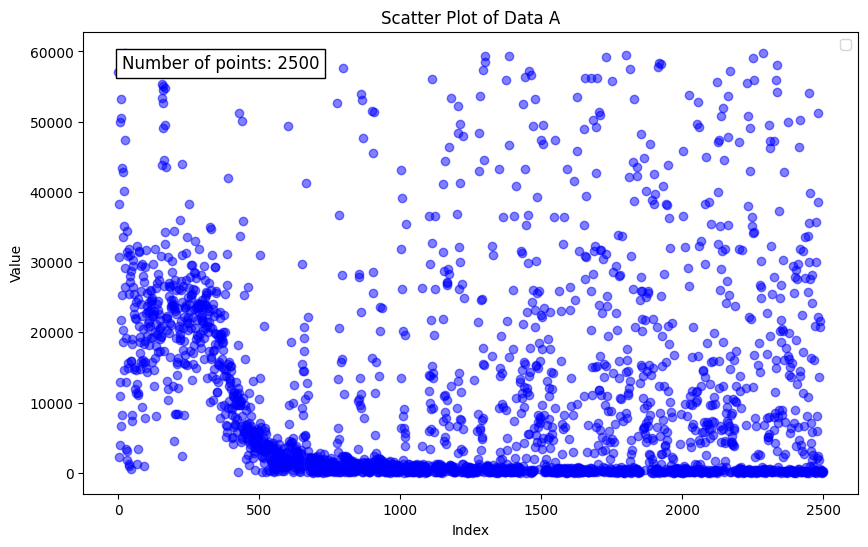

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2500, 1)


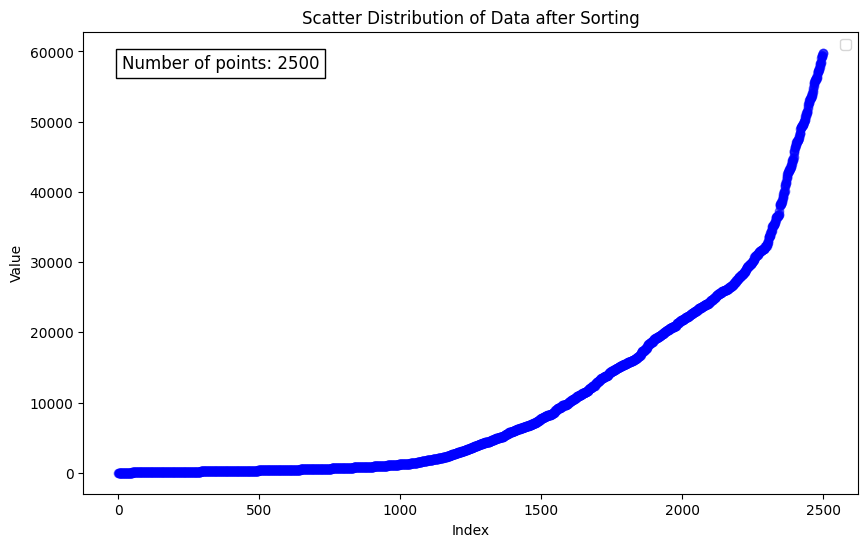

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.029779645158931837, 0.019534065853239257, 0.030249119981172305, 0.03769714730507912, 0.019495968785367548, 0.02683667420725303, 0.019542817237555354, 0.02023914247074953, 0.030105541472778285, 0.01945630425073519]
Error u of fuhe active learning(LHS sampling): 2.529364e-02
[0.013421607759070257, 0.009595756751697947, 0.014207241024633156, 0.01621956787179259, 0.009041470217747963, 0.012623534520499325, 0.01053420511555756, 0.0096110376710621, 0.014244294764981059, 0.011071549120528911]
MAE of fuhe active learning(LHS sampling): 1.205703e-02
[0.0002702828815331621, 0.000149022165654996, 0.00031521940550538653, 0.0004095323338619663, 0.00012992116994624446, 0.00024069773071287262, 0.00015861238034084127, 0.00013684590586915743, 0.0003092571519044298, 0.00017842587832905807]
MSE of fuhe active learning(LHS sampling): 2.297817e-04


[0.029779645158931837, 0.019534065853239257, 0.030249119981172305, 0.03769714730507912, 0.019495968785367548, 0.02683667420725303, 0.019542817237555354, 0.02023914247074953, 0.030105541472778285, 0.01945630425073519]
mean Error u: 2.529364e-02
Variance Error u: 3.835435e-05


/tmp/ipykernel_2951416/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


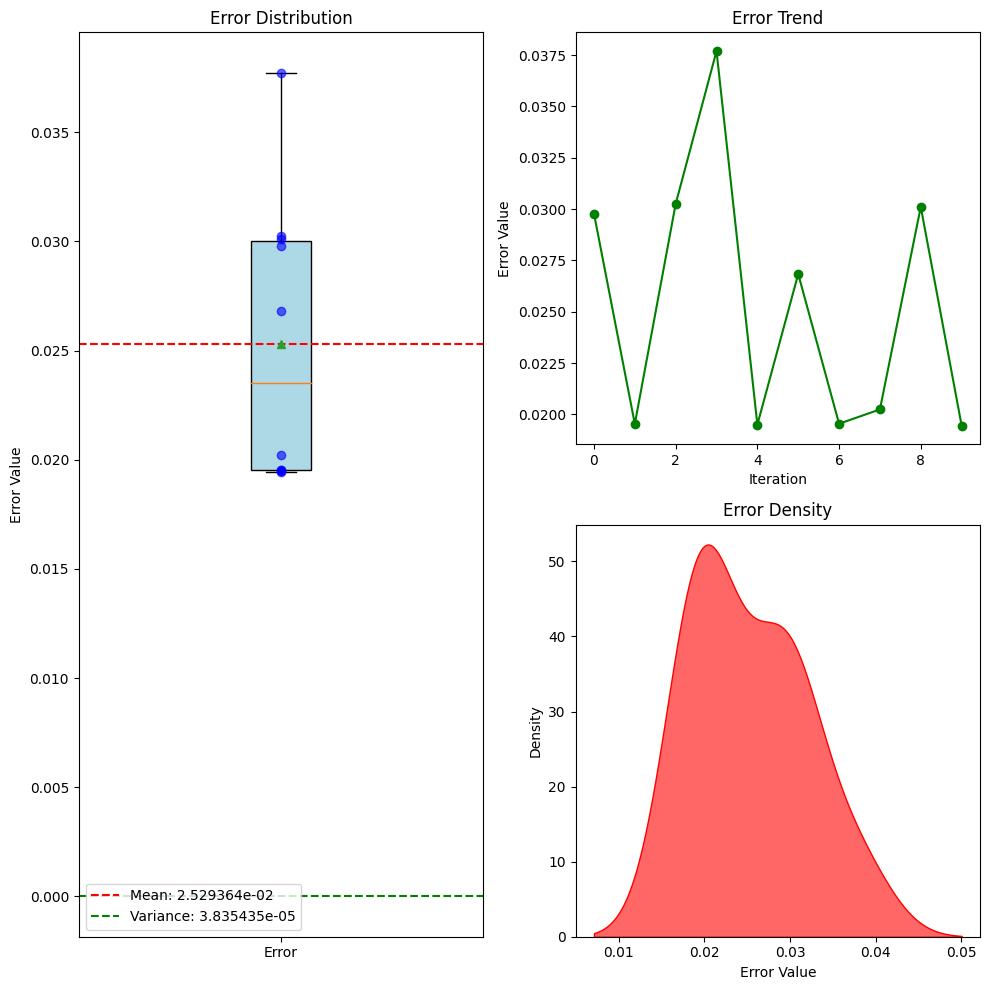

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.013421607759070257, 0.009595756751697947, 0.014207241024633156, 0.01621956787179259, 0.009041470217747963, 0.012623534520499325, 0.01053420511555756, 0.0096110376710621, 0.014244294764981059, 0.011071549120528911]
mean MAE: 1.205703e-02
Variance MAE: 5.334177e-06


/tmp/ipykernel_2951416/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


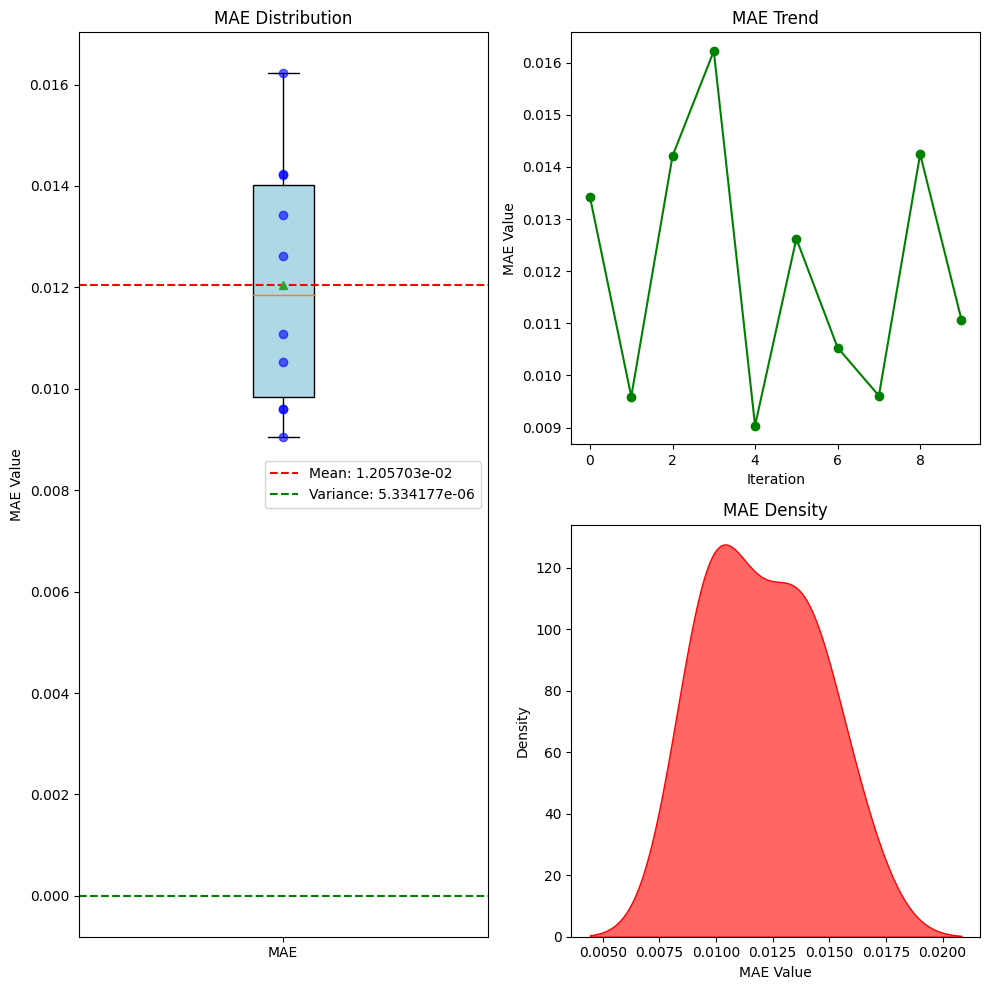

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0002702828815331621, 0.000149022165654996, 0.00031521940550538653, 0.0004095323338619663, 0.00012992116994624446, 0.00024069773071287262, 0.00015861238034084127, 0.00013684590586915743, 0.0003092571519044298, 0.00017842587832905807]
mean MSE: 2.297817e-04
Variance MSE: 8.051953e-09


/tmp/ipykernel_2951416/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


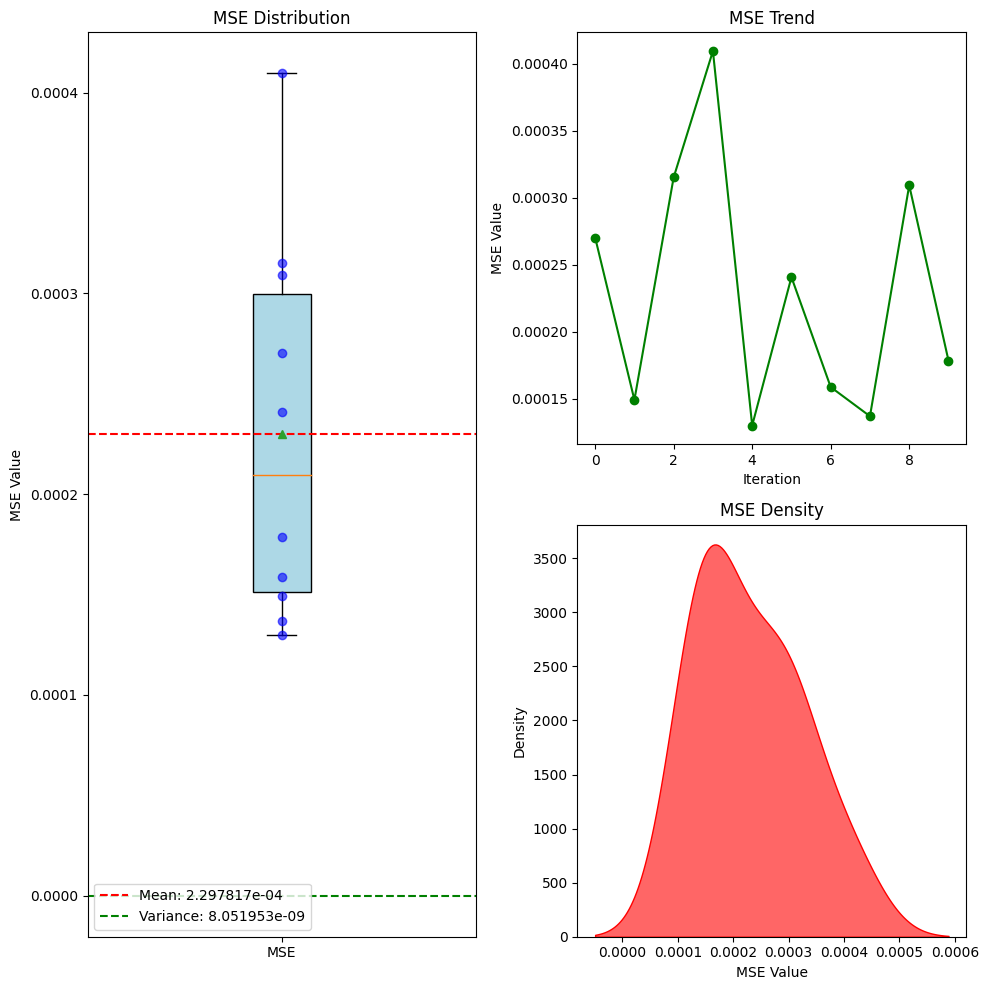

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0019399662, 21381.646, 0.013632856, 0.001172753, 5002.872, 0.018551588, 0.034544412, 1728.4907, 0.011248082, 1318.9294]
mean CHAOS: 2.943202e+03
Variance CHAOS: 4.003065e+07


/tmp/ipykernel_2951416/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


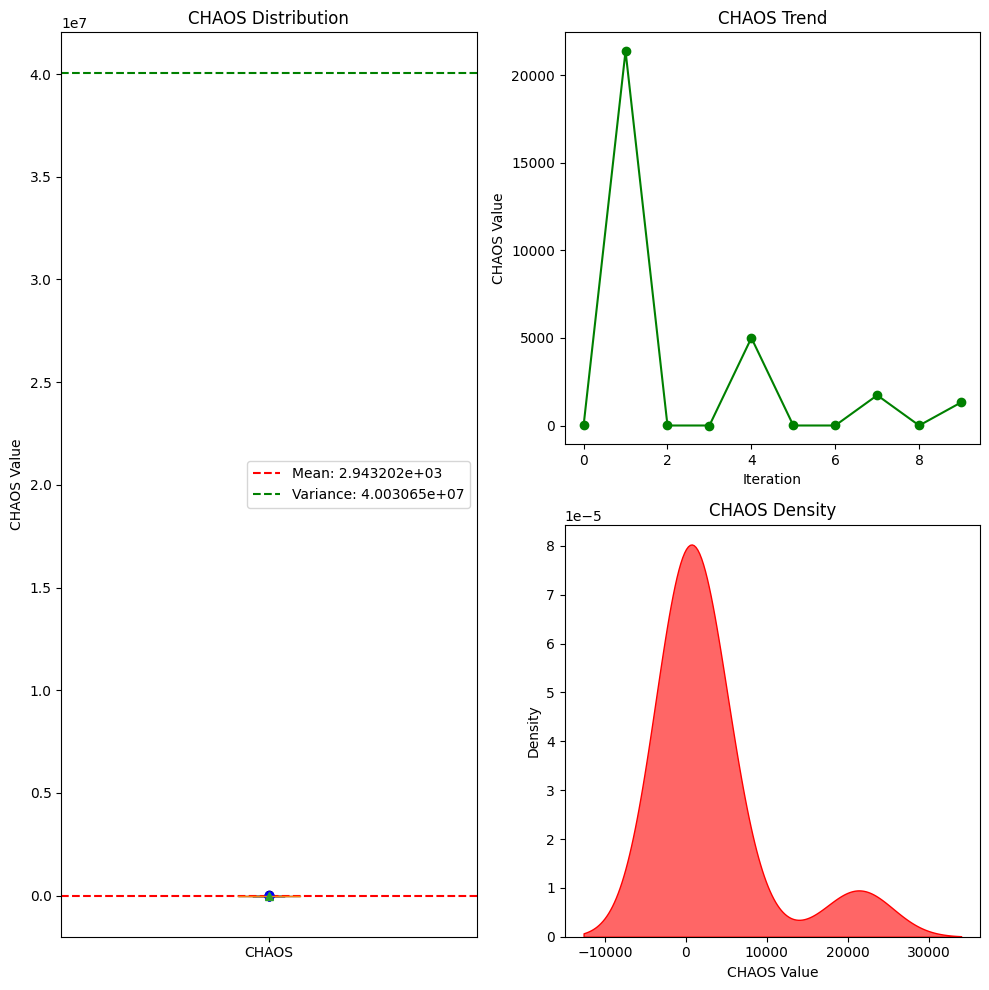

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.6787554e-08, 3.4314155e-08, 3.4833562e-08, 2.9692956e-08, 3.1499212e-08, 3.354876e-08, 2.942258e-08, 3.2742946e-08, 3.0369506e-08, 3.717838e-08]
mean RESIDUAL: 3.303896e-08
Variance RESIDUAL: 7.015176e-18


/tmp/ipykernel_2951416/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


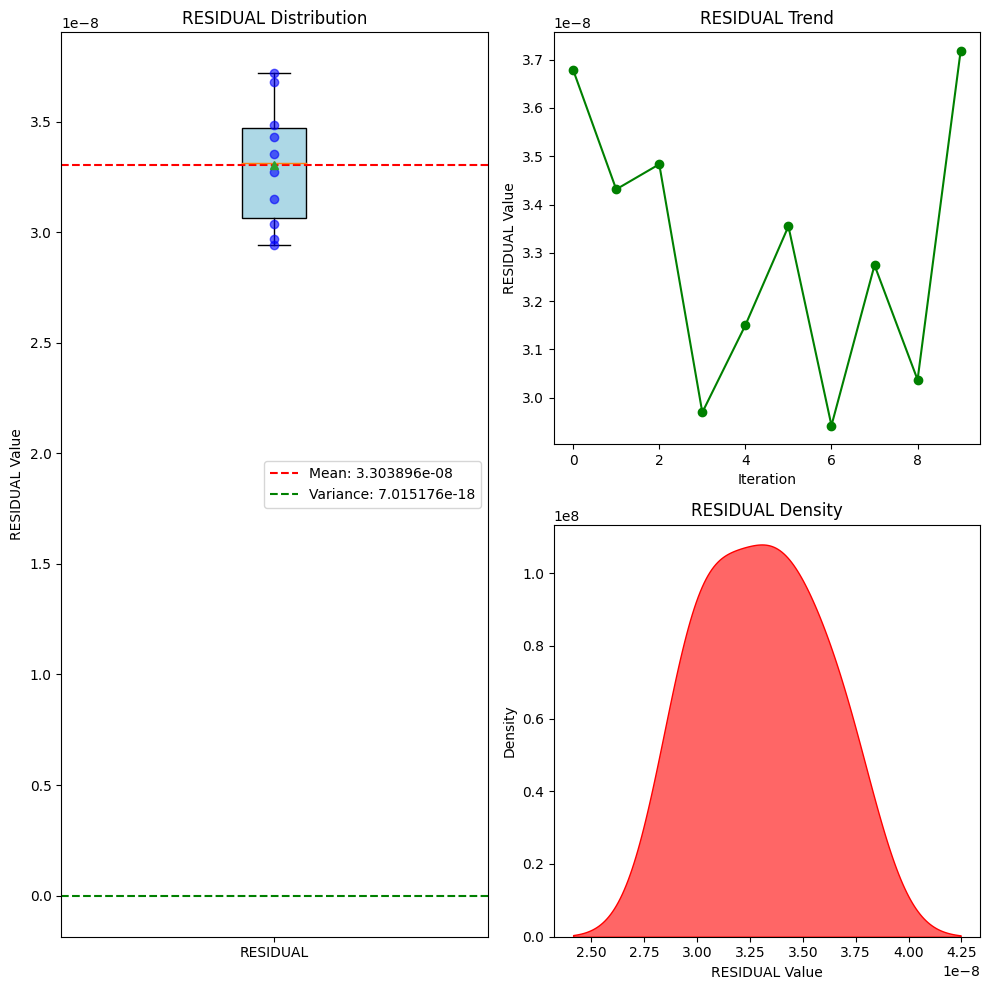

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.9655290e-01 1.6744958e-01 1.4014524e-01 ... 3.3920580e-09 3.3920238e-09
 3.3919916e-09]


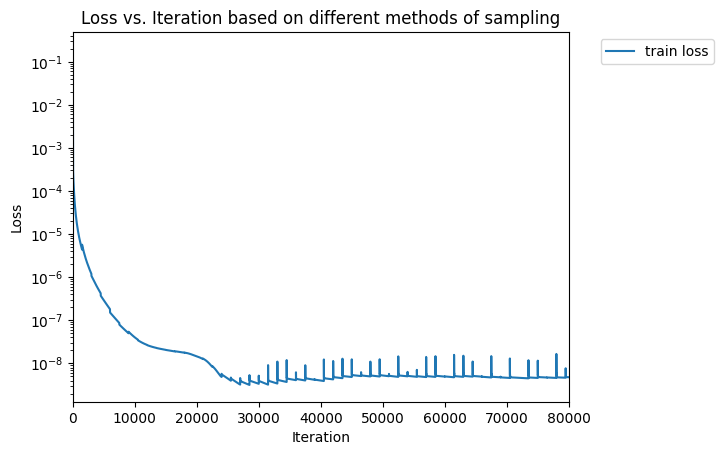

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

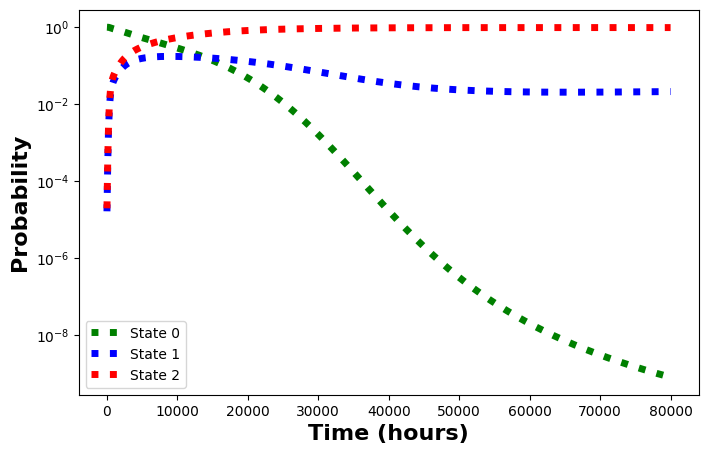

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

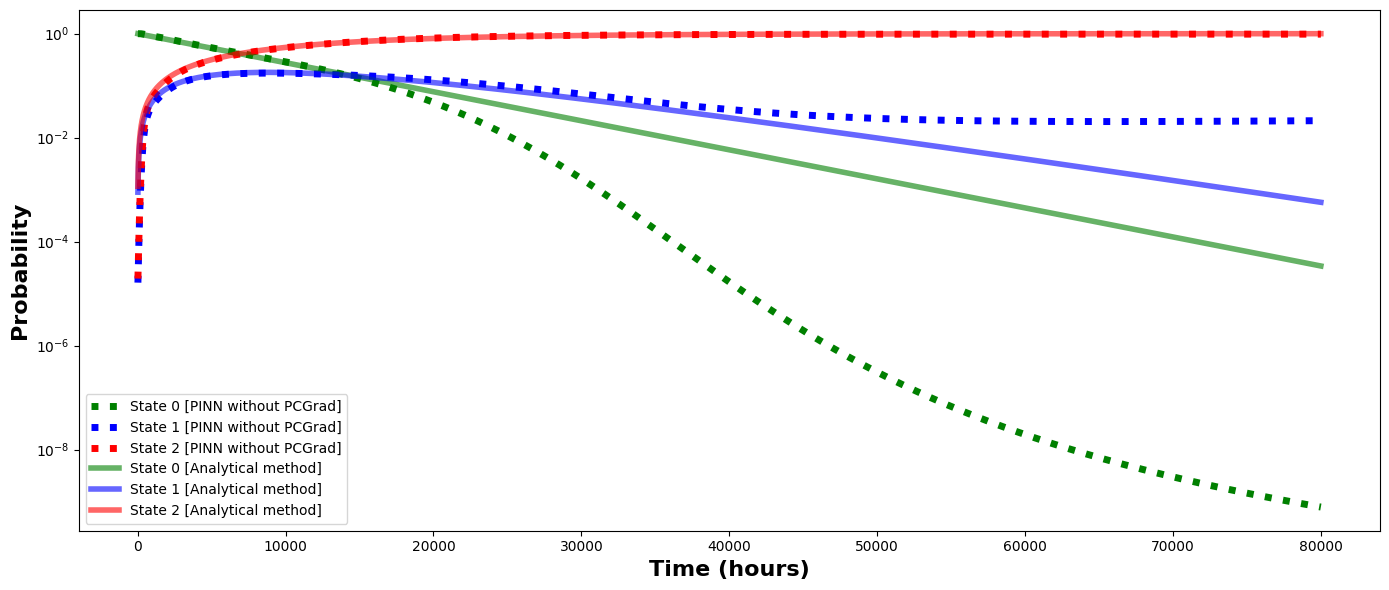

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999964  0.000016  0.000019
1  0.999943  0.000026  0.000031
2  0.999911  0.000040  0.000048
3  0.999864  0.000061  0.000075
4  0.999794  0.000093  0.000113
           state_0   state_1   state_2
4995  7.921429e-10  0.021197  0.978803
4996  7.906971e-10  0.021198  0.978802
4997  7.892510e-10  0.021200  0.978800
4998  7.878105e-10  0.021201  0.978799
4999  7.863712e-10  0.021203  0.978797


In [21]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_eigenvectors['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_eigenvectors['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.02175113957351578
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.02012743858081854
RMSE between PINN without PCGrad and the analytical solution after 60000 is 0.02661705086178272


### 计算混沌度和残差

In [24]:
x_star.shape

(5000, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(1000, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[0.2957403  0.29592896 0.2961148  ... 0.1725935  0.17259318 0.17259403]
(5000,)
1306.3246


In [26]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[ 5.8207661e-11 -1.6807462e-09 -1.1787051e-09 ...  9.0949470e-13
 -1.5916157e-12 -3.4106051e-12]
(5000,)
-2.2886866e-09
